In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('../data/train.csv')
data

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
41995       0  ...         0         0         0         0         0   
41996       0  ...         0         0         0         0         0   
41997       0  ...         0         0         0         0         0   
41998       0  ...         0         0         0         0         0   
41999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
41995         0         0         0         0         0  
41996         0         0         0         0         0  
41997         0         0         0         0         0  
41998         0         0         0         0         0  
41999         0         0         0         0         0  

[42000 rows x 785 columns]

In [3]:
data = np.array(data)
data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

In [4]:
m, n = data.shape
np.random.shuffle(data)

In [5]:
data

array([[4, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [6]:
data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]

X_dev = X_dev / 255

data_train = data[1000:m].T

Y_train = data_dev[0]
X_train = data_dev[1:n]

X_train = X_train / 255

_, m_train = X_train.shape

In [ ]:
!pip install numba

from numba import njit

In [7]:
from numba import njit, jit

In [8]:

def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

In [9]:
@njit
def ReLu(Z):
    return np.maximum(0, Z)


def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A


def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLu(Z1)
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    
    one_hot_Y = one_hot_Y.T
    
    return one_hot_Y

@njit
def deriv_relu(Z):
    return Z > 0


def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_relu(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2


@njit(parallel=True)
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    return W1, b1, W2, b2
    

In [10]:
@njit
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        if i % 50 == 0:
            print('iteration: ', i)
            predictions = get_predictions(A2)
            
            print("Accuracy: ", get_accuracy(predictions, Y))
            
    return W1, b1, W2, b2
    

In [11]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 900, 0.1)

iteration:  0
Accuracy:  0.094
iteration:  50
Accuracy:  0.496
iteration:  100
Accuracy:  0.677
iteration:  150
Accuracy:  0.765
iteration:  200
Accuracy:  0.807
iteration:  250
Accuracy:  0.843
iteration:  300
Accuracy:  0.869
iteration:  350
Accuracy:  0.877
iteration:  400
Accuracy:  0.885
iteration:  450
Accuracy:  0.898
iteration:  500
Accuracy:  0.91
iteration:  550
Accuracy:  0.922
iteration:  600
Accuracy:  0.93
iteration:  650
Accuracy:  0.937
iteration:  700
Accuracy:  0.946
iteration:  750
Accuracy:  0.95
iteration:  800
Accuracy:  0.958
iteration:  850
Accuracy:  0.962


## Testing Neural Network

Prediction:  [4]
Label:  4


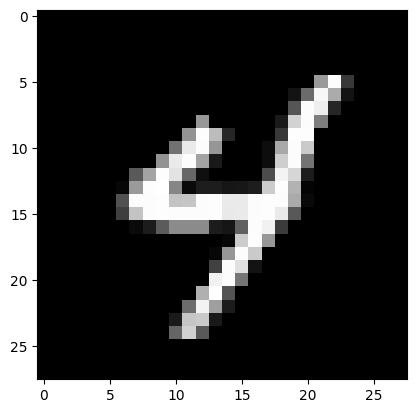

Prediction:  [9]
Label:  9


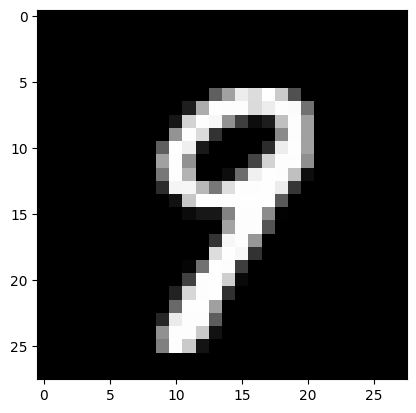

Prediction:  [4]
Label:  9


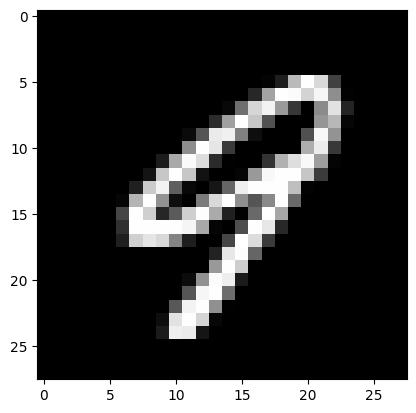

Prediction:  [3]
Label:  3


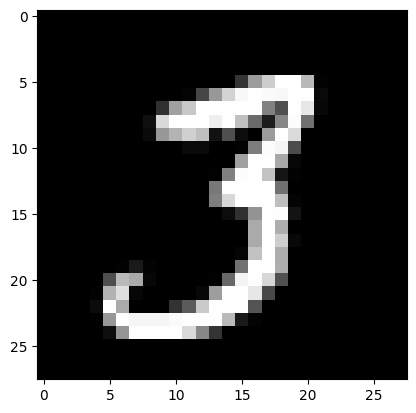

Prediction:  [5]
Label:  5


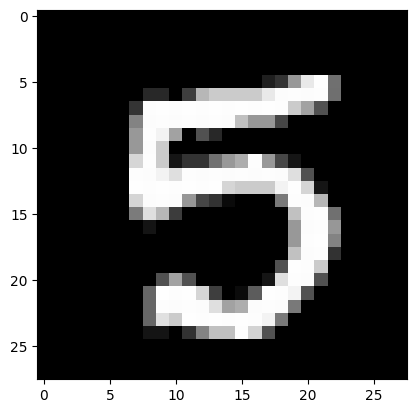

Prediction:  [3]
Label:  3


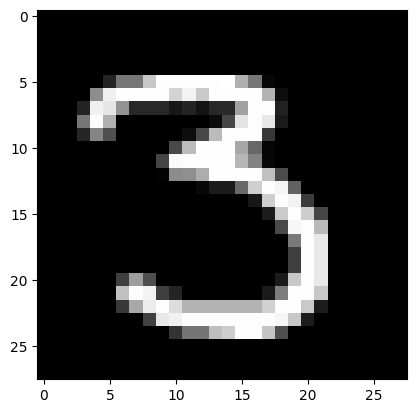

Prediction:  [1]
Label:  1


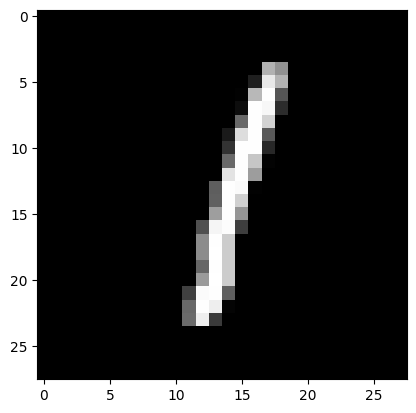

Prediction:  [5]
Label:  5


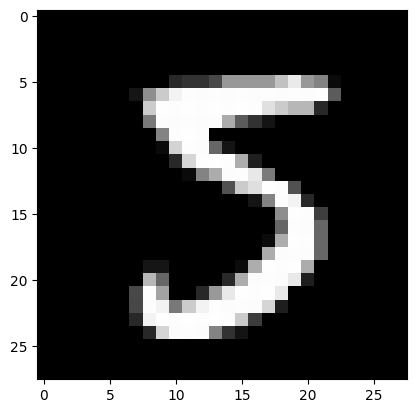

Prediction:  [8]
Label:  8


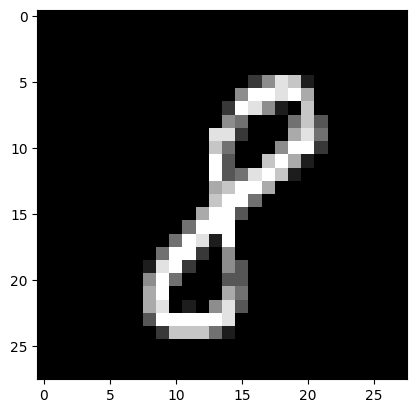

Prediction:  [6]
Label:  6


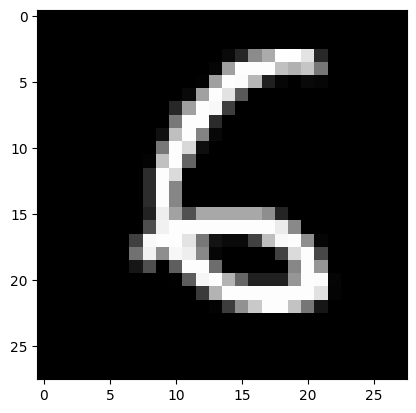

Prediction:  [2]
Label:  2


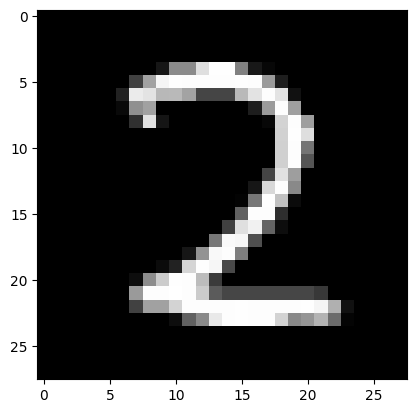

Prediction:  [2]
Label:  2


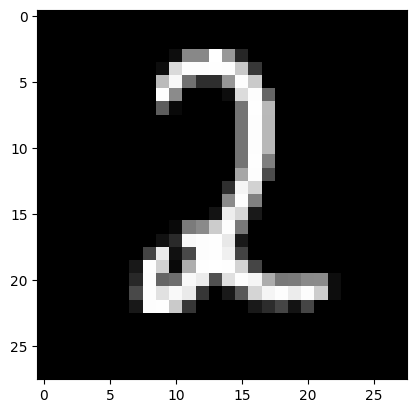

Prediction:  [0]
Label:  0


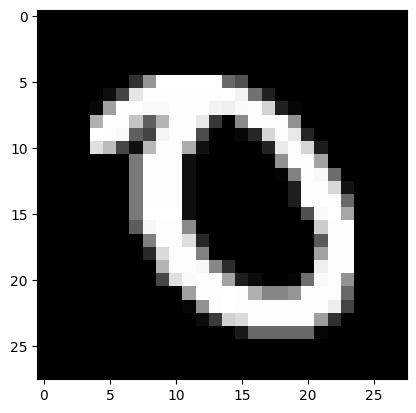

Prediction:  [6]
Label:  6


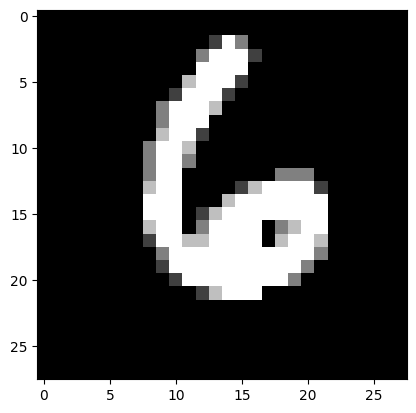

Prediction:  [7]
Label:  7


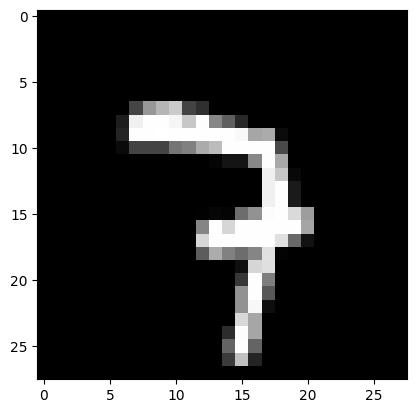

Prediction:  [4]
Label:  4


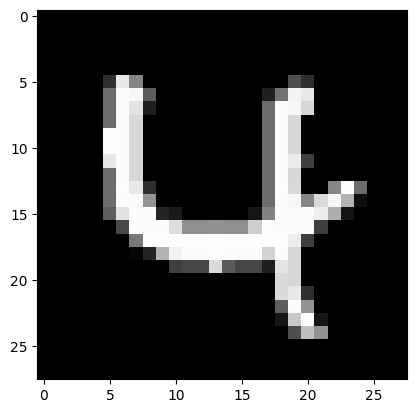

Prediction:  [6]
Label:  6


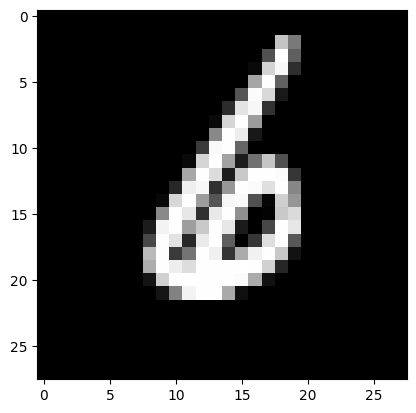

Prediction:  [1]
Label:  1


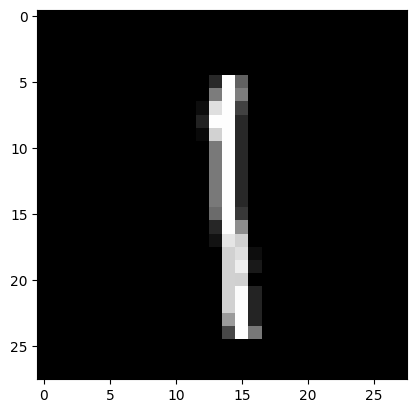

Prediction:  [9]
Label:  9


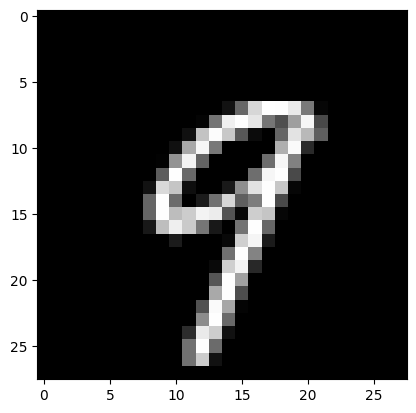

Prediction:  [1]
Label:  1


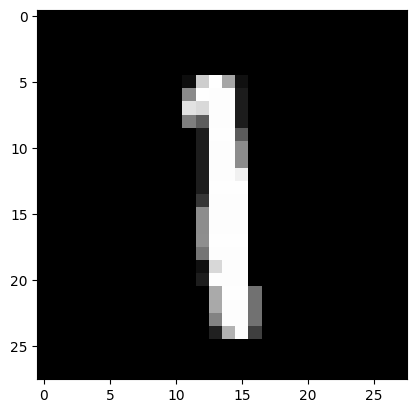

Prediction:  [8]
Label:  8


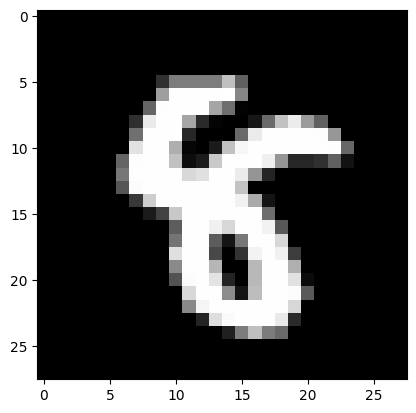

Prediction:  [7]
Label:  7


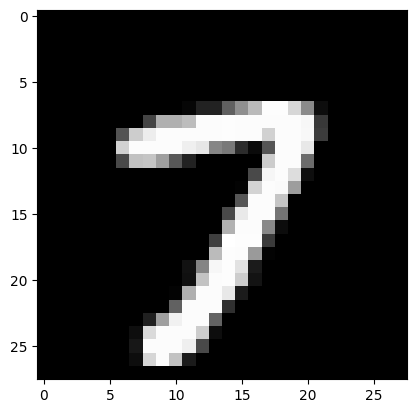

Prediction:  [6]
Label:  6


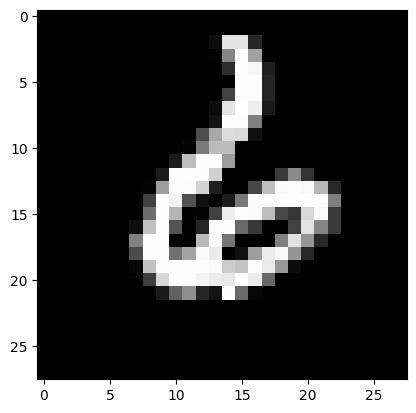

Prediction:  [4]
Label:  4


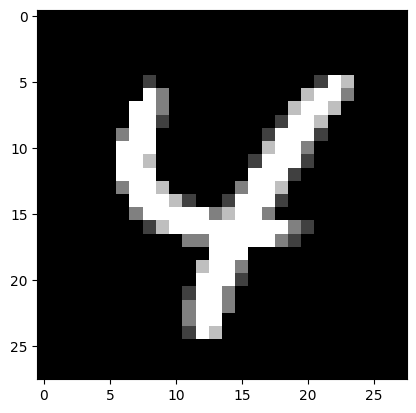

Prediction:  [8]
Label:  8


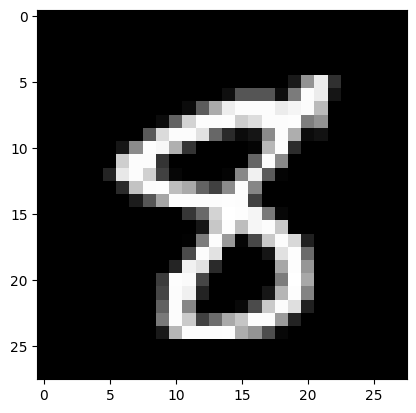

Prediction:  [6]
Label:  6


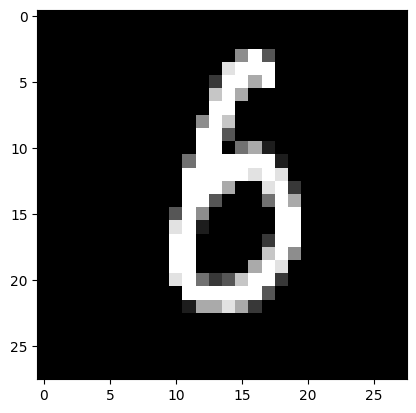

Prediction:  [2]
Label:  2


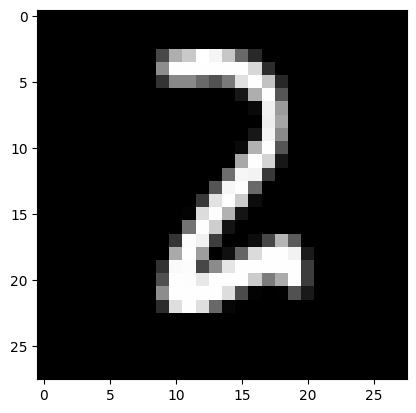

Prediction:  [4]
Label:  4


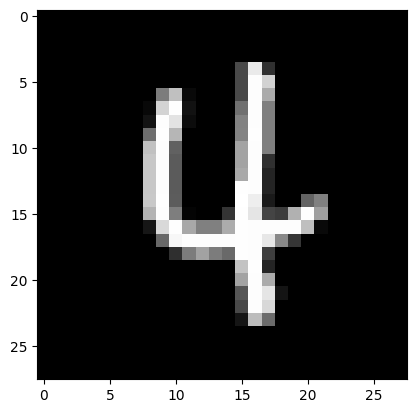

Prediction:  [0]
Label:  0


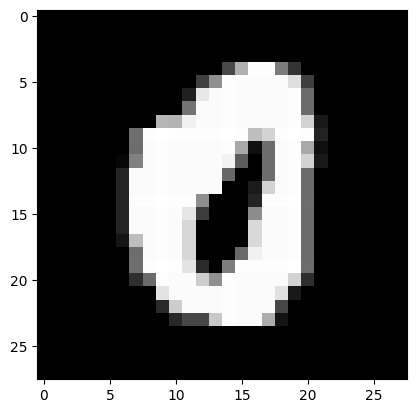

Prediction:  [5]
Label:  5


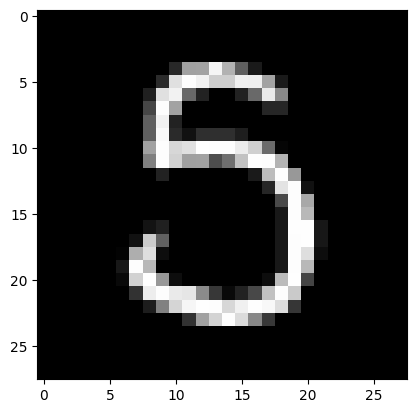

Prediction:  [7]
Label:  7


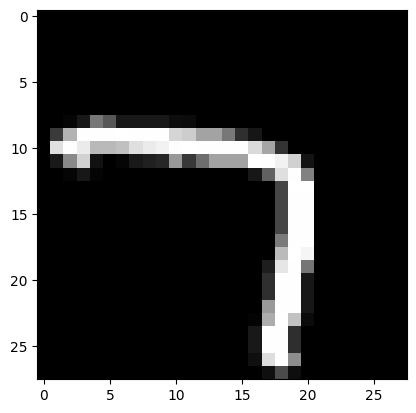

Prediction:  [4]
Label:  4


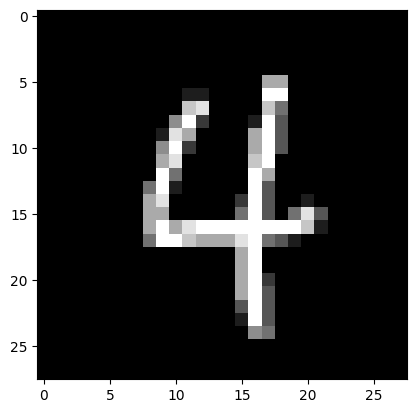

Prediction:  [0]
Label:  0


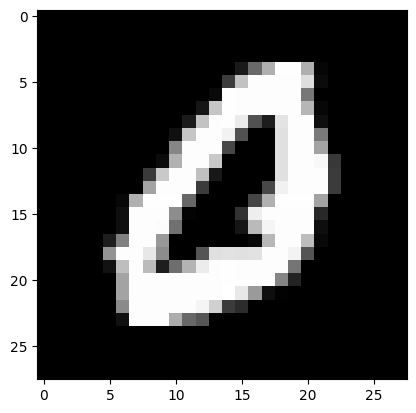

Prediction:  [2]
Label:  3


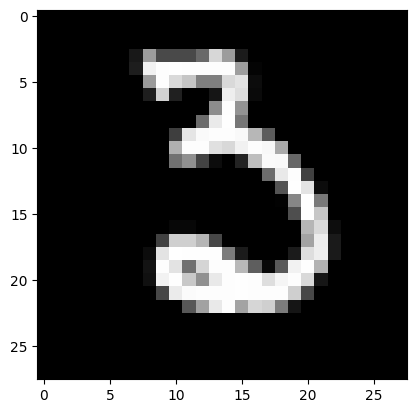

Prediction:  [1]
Label:  1


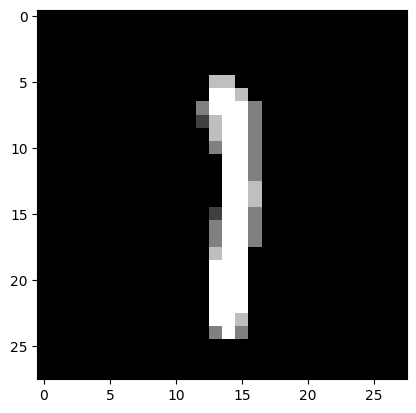

Prediction:  [5]
Label:  5


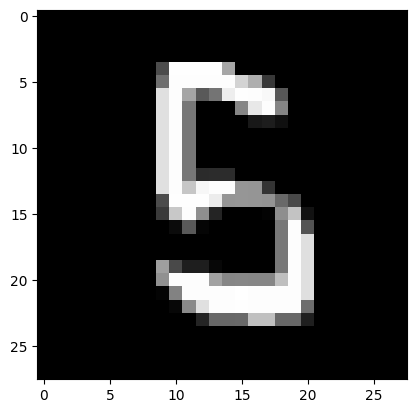

Prediction:  [7]
Label:  7


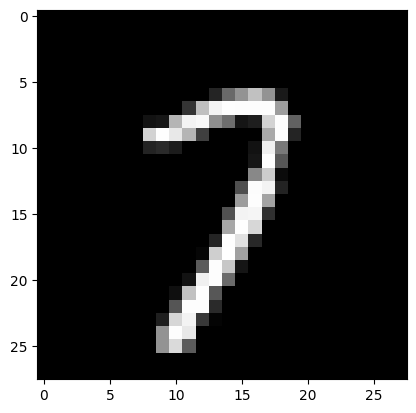

Prediction:  [7]
Label:  7


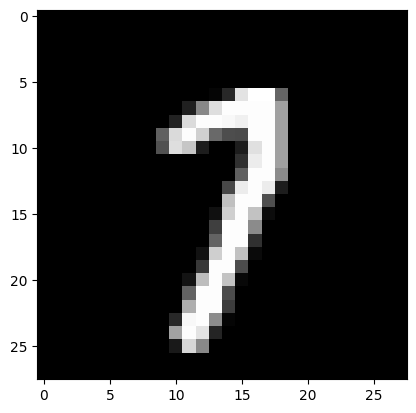

Prediction:  [6]
Label:  6


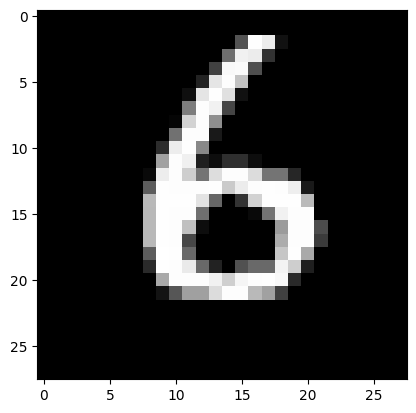

Prediction:  [7]
Label:  7


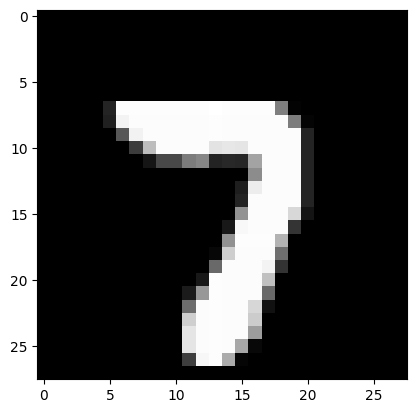

Prediction:  [9]
Label:  9


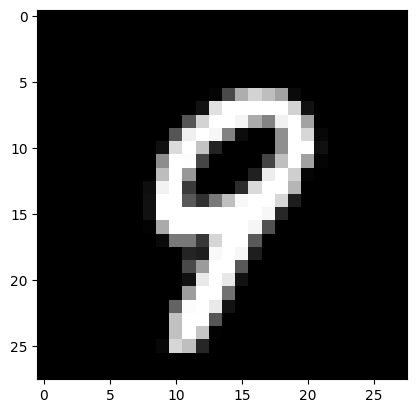

Prediction:  [1]
Label:  1


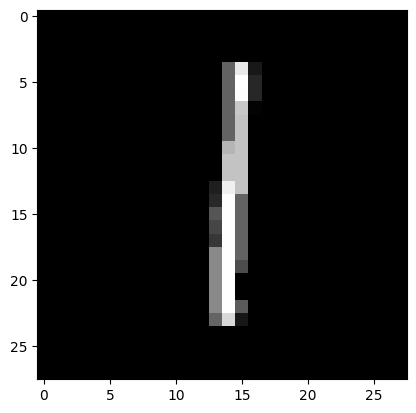

Prediction:  [5]
Label:  5


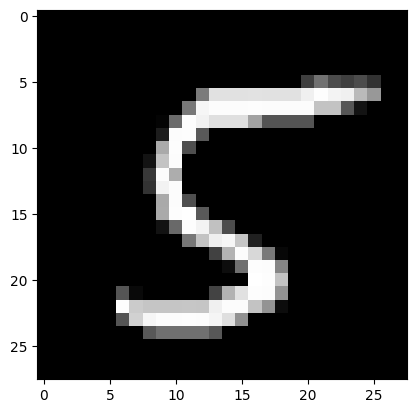

Prediction:  [1]
Label:  1


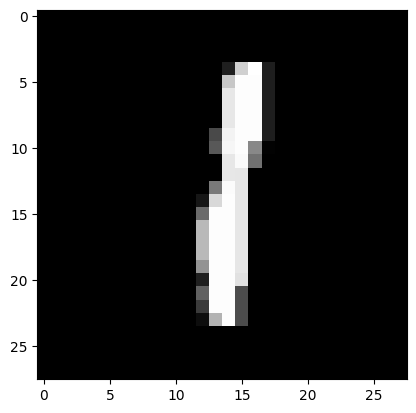

Prediction:  [4]
Label:  4


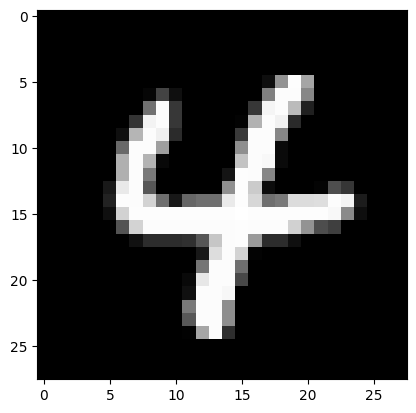

Prediction:  [0]
Label:  0


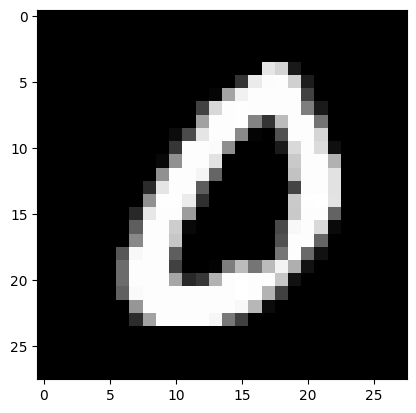

Prediction:  [9]
Label:  9


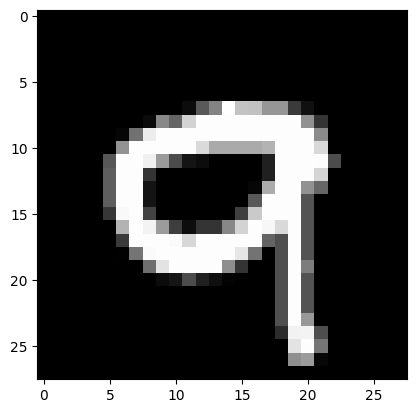

Prediction:  [2]
Label:  2


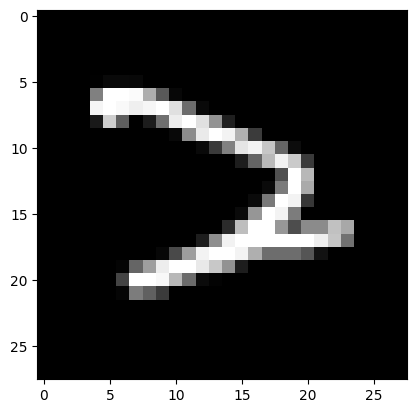

Prediction:  [2]
Label:  2


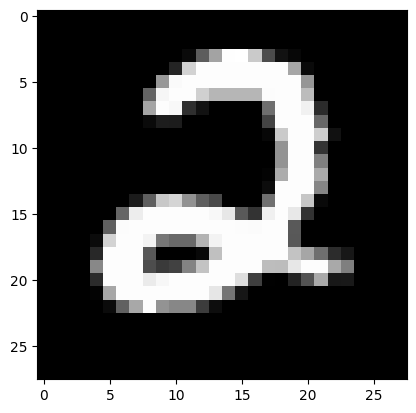

Prediction:  [8]
Label:  8


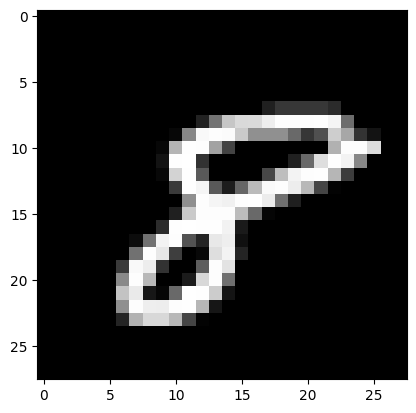

Prediction:  [9]
Label:  9


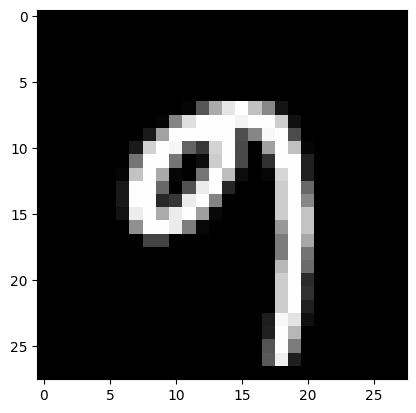

Prediction:  [3]
Label:  5


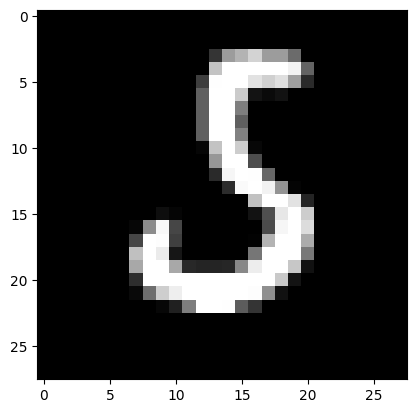

Prediction:  [0]
Label:  0


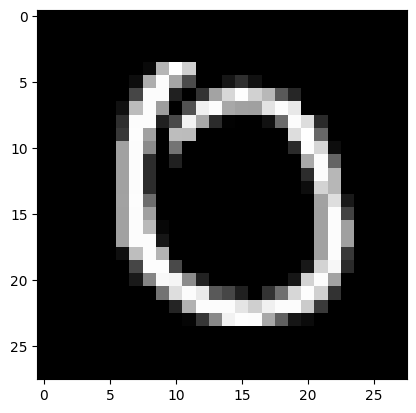

Prediction:  [1]
Label:  1


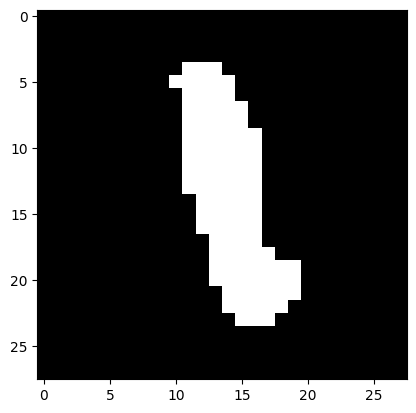

Prediction:  [0]
Label:  0


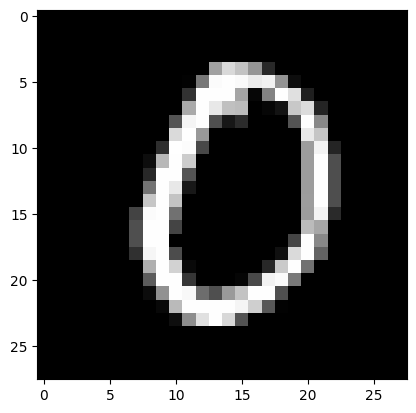

Prediction:  [4]
Label:  4


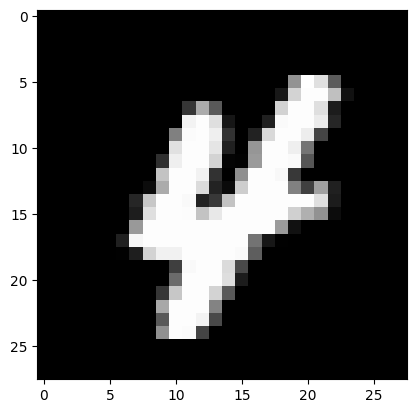

Prediction:  [4]
Label:  4


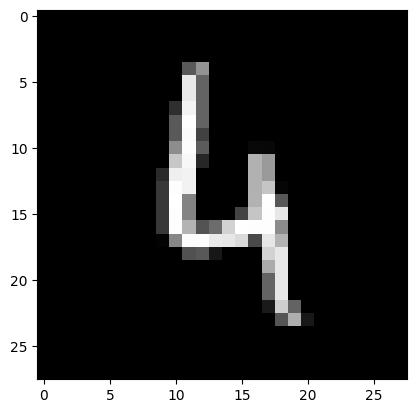

Prediction:  [3]
Label:  3


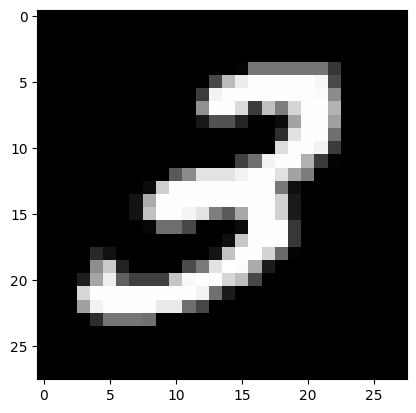

Prediction:  [9]
Label:  9


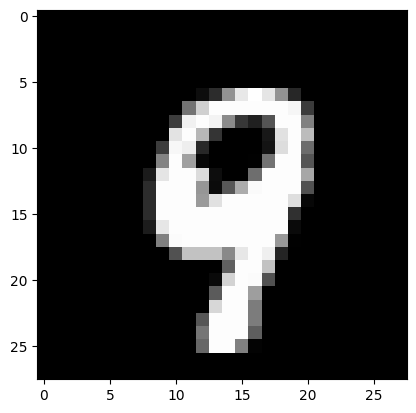

Prediction:  [1]
Label:  1


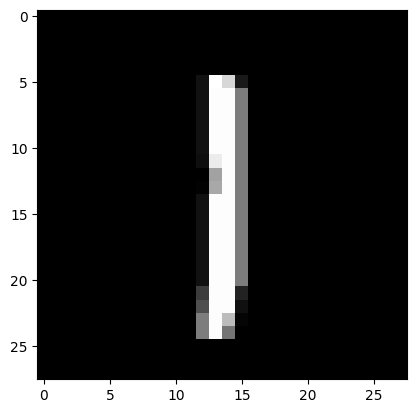

Prediction:  [7]
Label:  7


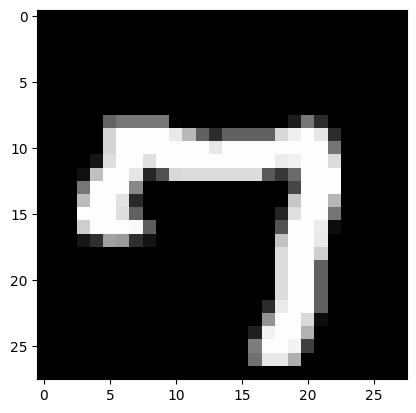

Prediction:  [9]
Label:  9


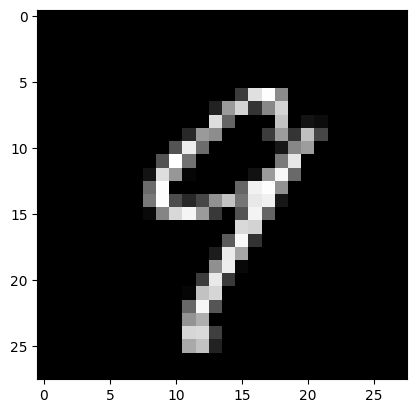

Prediction:  [4]
Label:  4


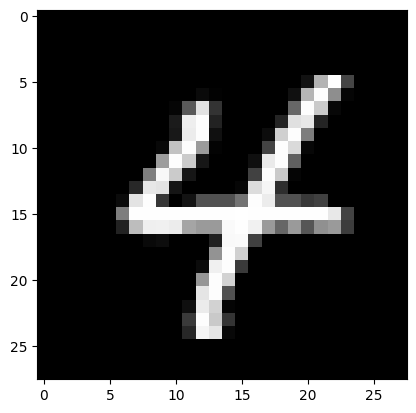

Prediction:  [7]
Label:  7


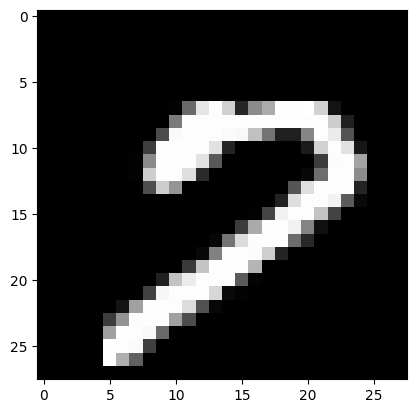

Prediction:  [8]
Label:  8


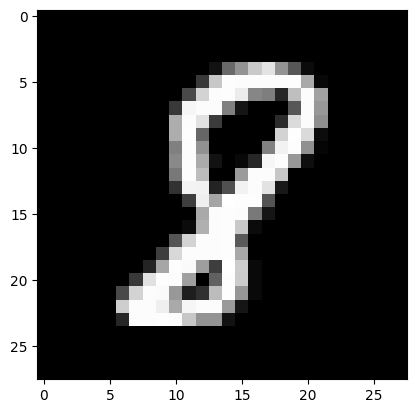

Prediction:  [3]
Label:  3


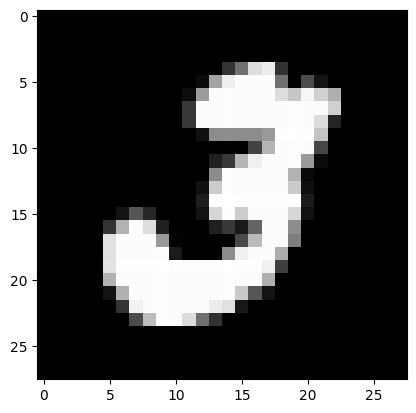

Prediction:  [4]
Label:  4


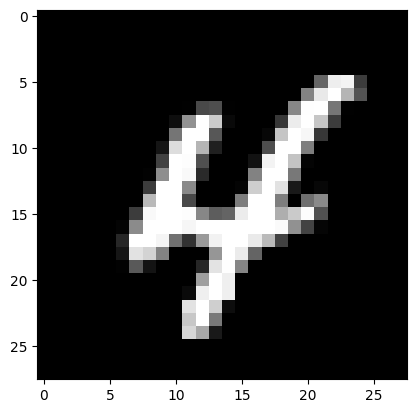

Prediction:  [4]
Label:  4


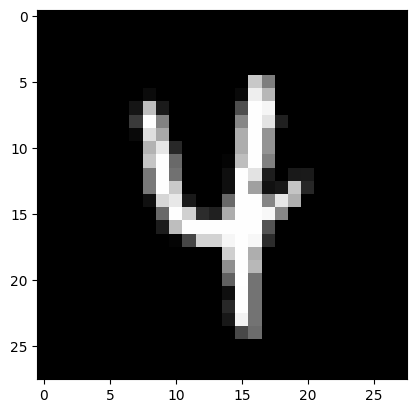

Prediction:  [9]
Label:  9


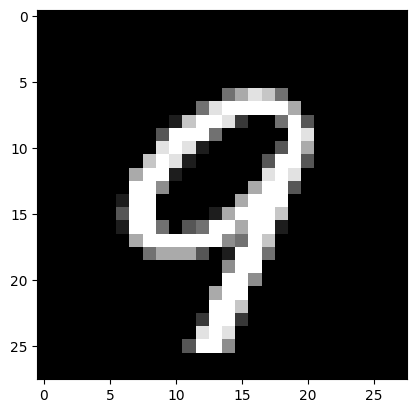

Prediction:  [5]
Label:  5


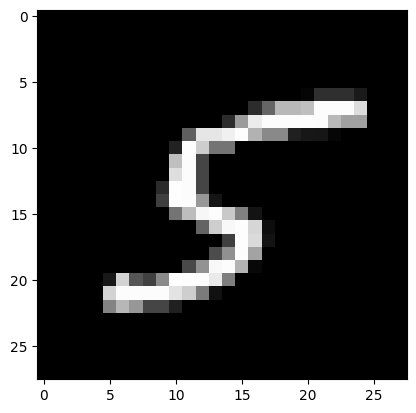

Prediction:  [6]
Label:  6


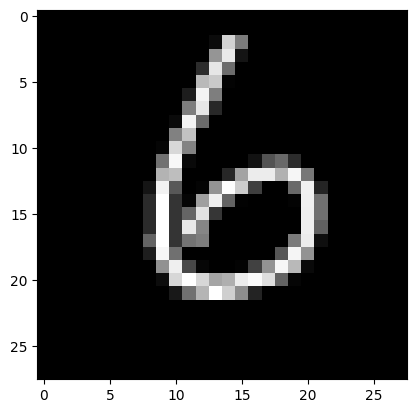

Prediction:  [5]
Label:  5


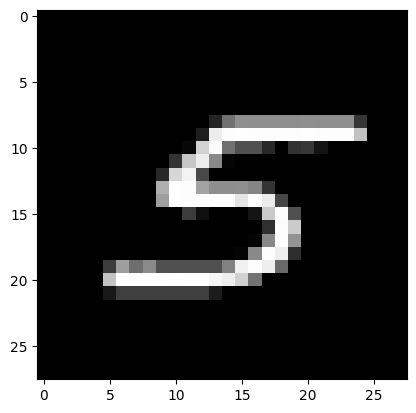

Prediction:  [5]
Label:  5


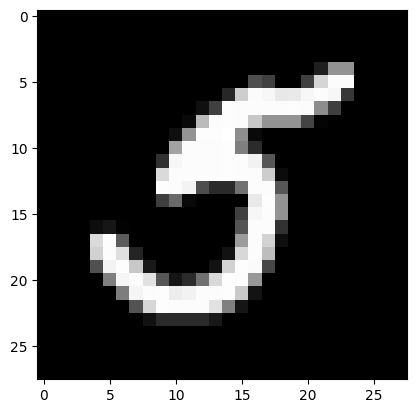

Prediction:  [4]
Label:  4


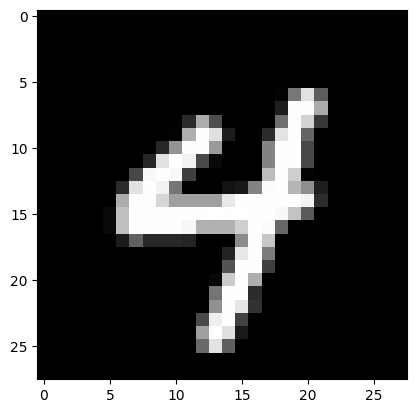

Prediction:  [9]
Label:  9


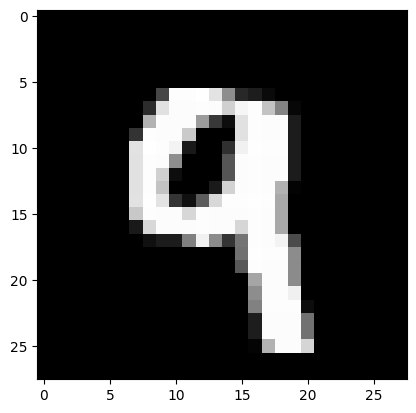

Prediction:  [0]
Label:  0


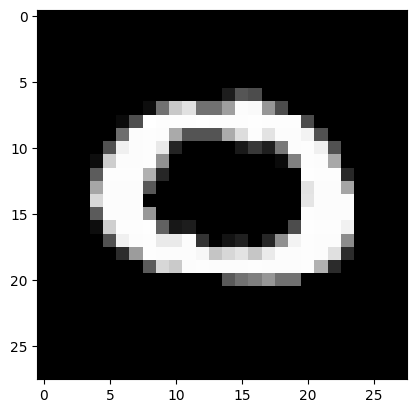

Prediction:  [3]
Label:  3


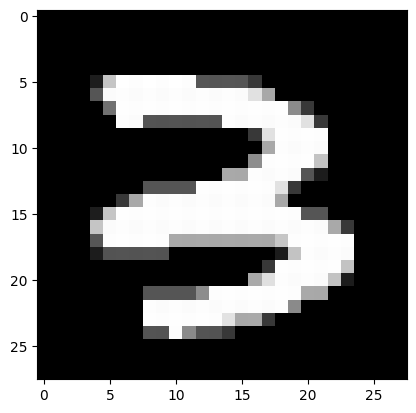

Prediction:  [4]
Label:  4


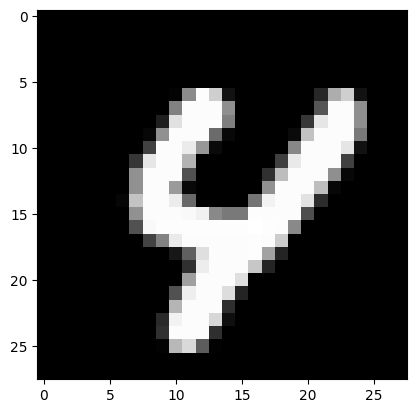

Prediction:  [1]
Label:  1


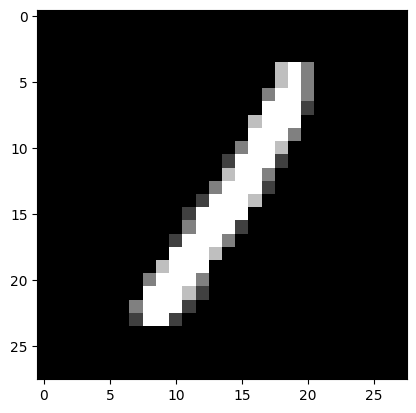

Prediction:  [1]
Label:  1


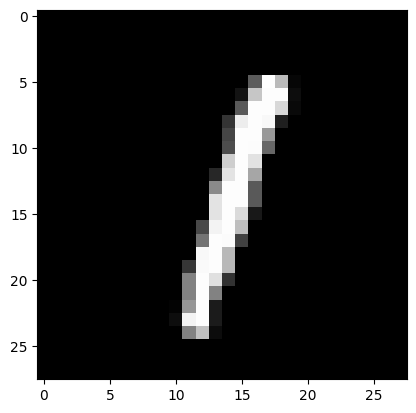

Prediction:  [6]
Label:  6


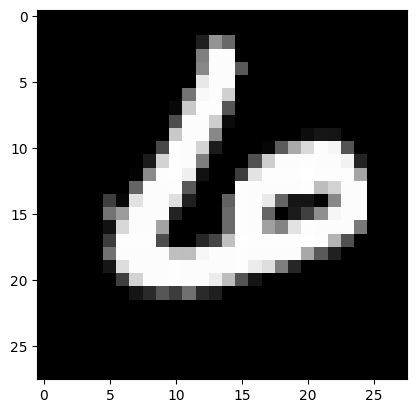

Prediction:  [1]
Label:  1


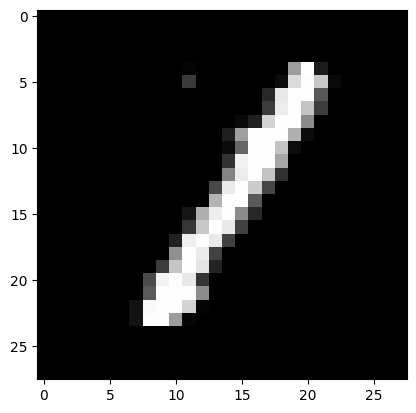

Prediction:  [3]
Label:  3


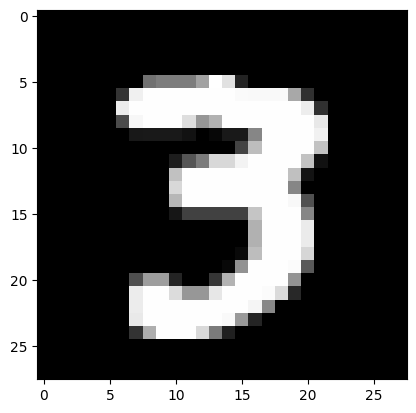

Prediction:  [0]
Label:  0


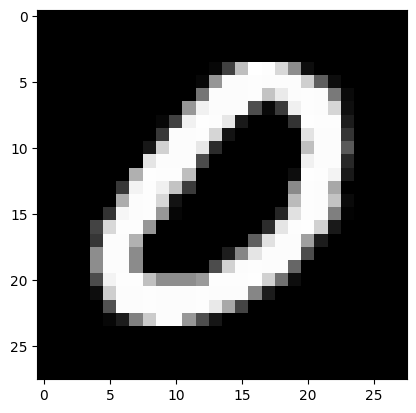

Prediction:  [0]
Label:  0


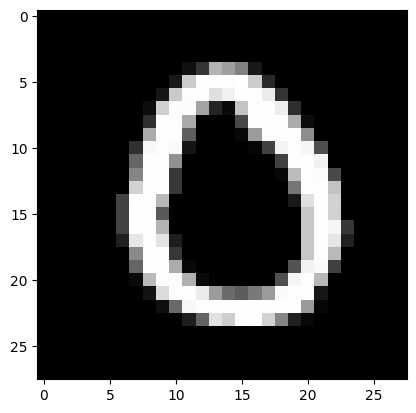

Prediction:  [2]
Label:  2


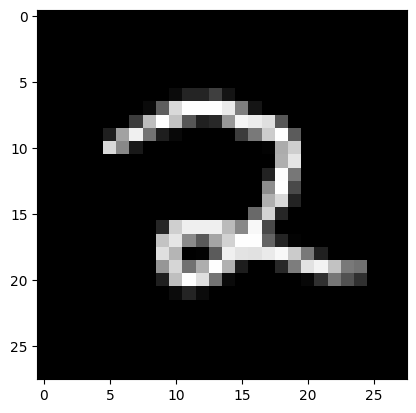

Prediction:  [3]
Label:  3


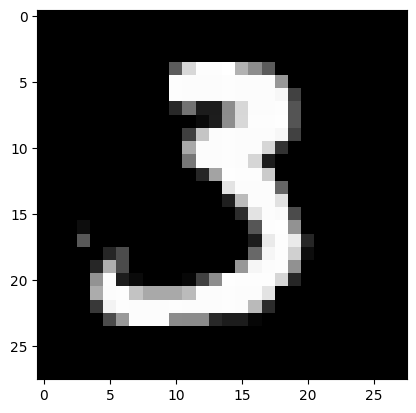

Prediction:  [6]
Label:  6


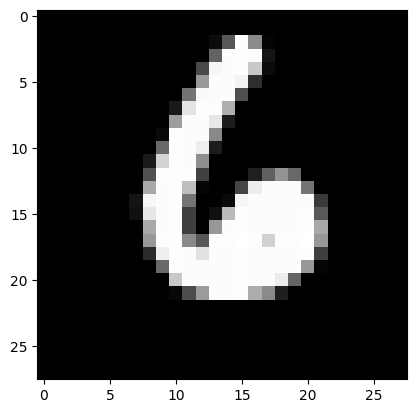

Prediction:  [0]
Label:  0


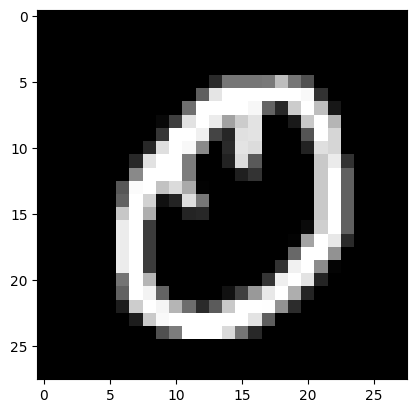

Prediction:  [4]
Label:  9


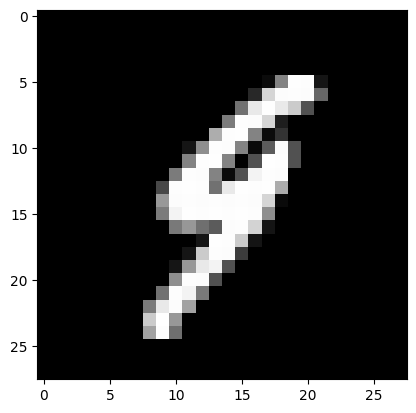

Prediction:  [3]
Label:  3


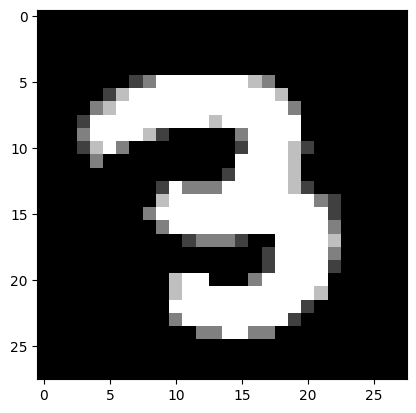

Prediction:  [6]
Label:  6


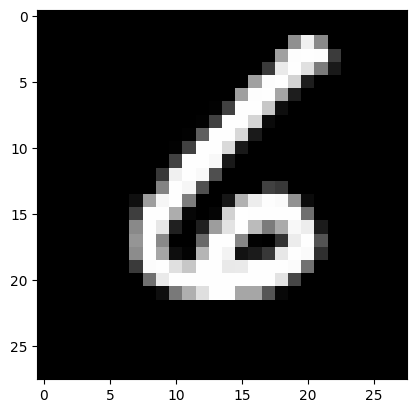

Prediction:  [6]
Label:  6


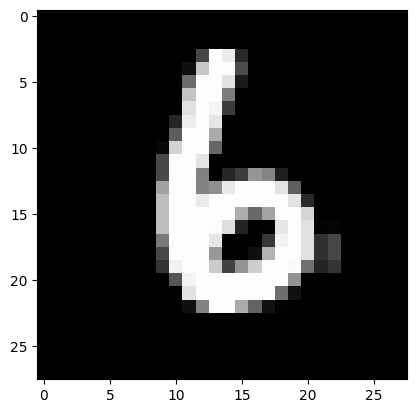

Prediction:  [1]
Label:  1


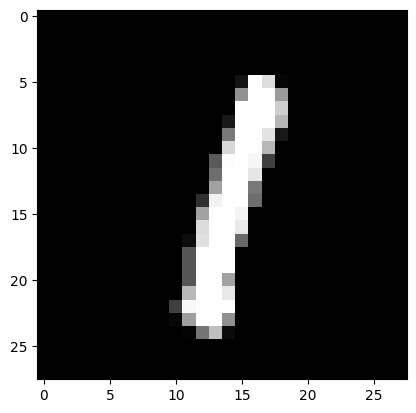

Prediction:  [3]
Label:  3


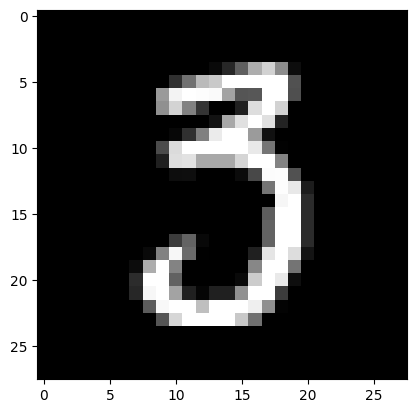

Prediction:  [4]
Label:  4


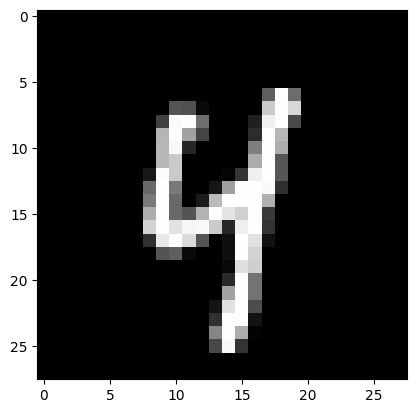

Prediction:  [5]
Label:  5


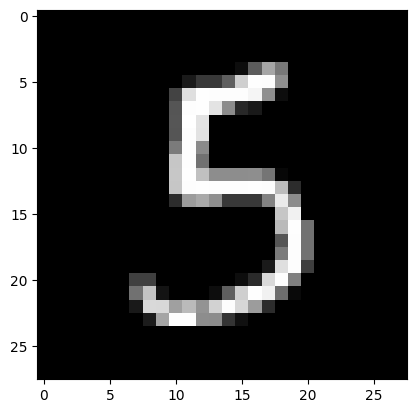

Prediction:  [4]
Label:  4


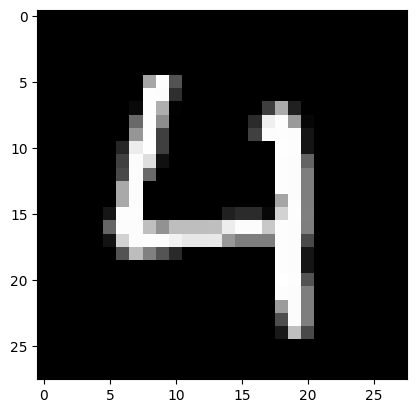

Prediction:  [2]
Label:  2


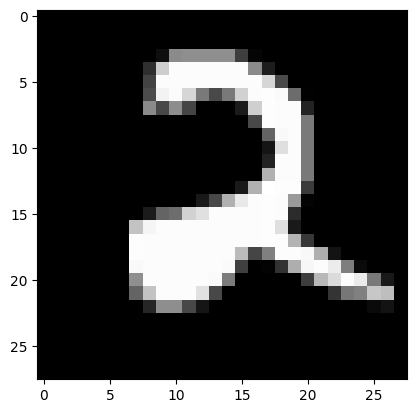

Prediction:  [0]
Label:  0


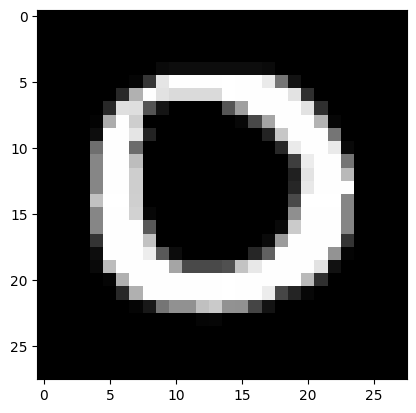

Prediction:  [6]
Label:  6


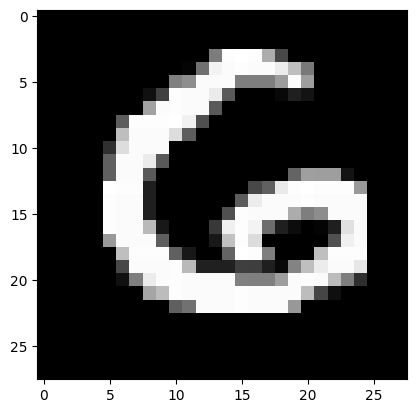

Prediction:  [0]
Label:  9


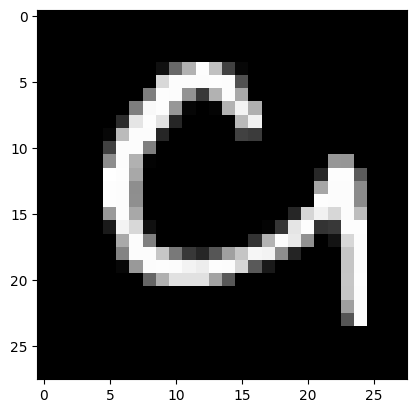

Prediction:  [7]
Label:  7


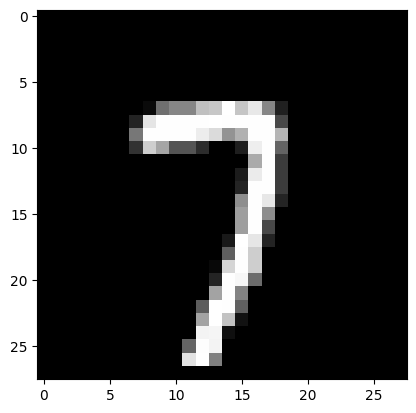

Prediction:  [4]
Label:  4


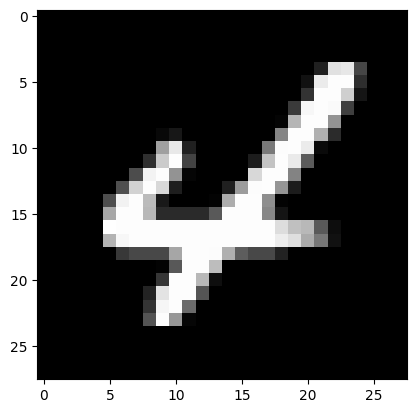

Prediction:  [0]
Label:  0


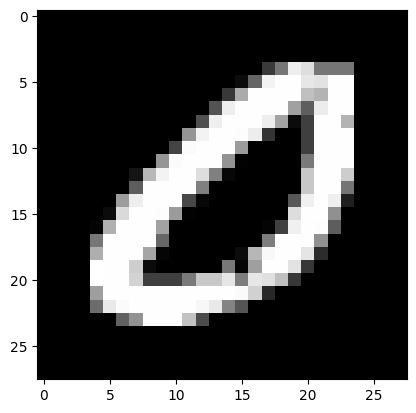

Prediction:  [1]
Label:  1


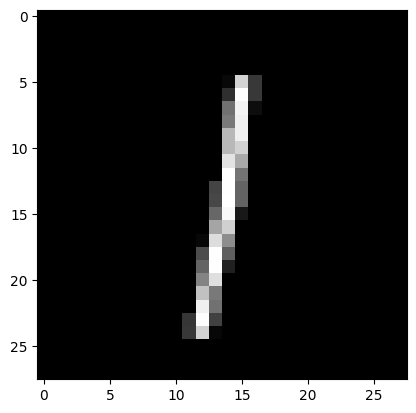

Prediction:  [2]
Label:  2


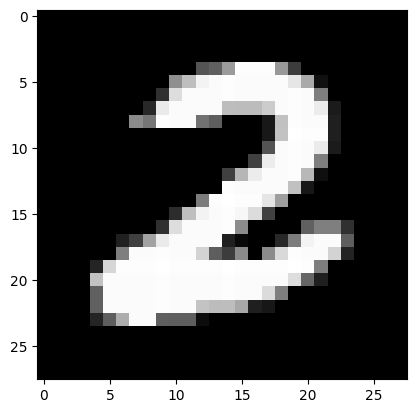

Prediction:  [3]
Label:  3


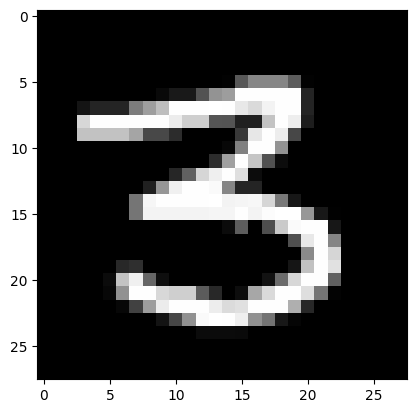

Prediction:  [9]
Label:  9


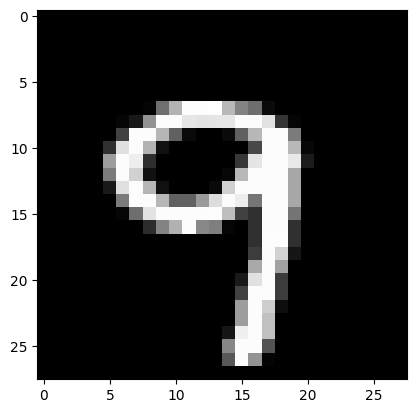

Prediction:  [0]
Label:  0


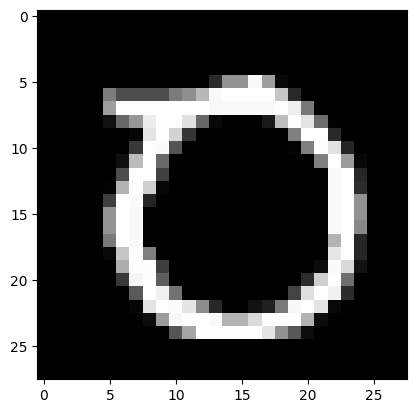

Prediction:  [4]
Label:  4


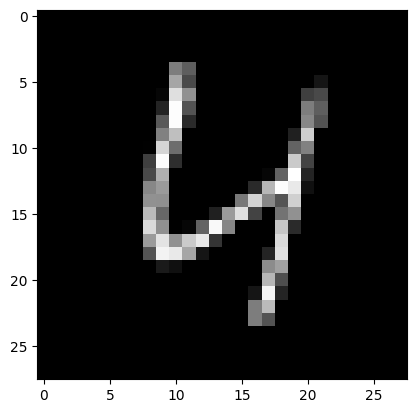

Prediction:  [9]
Label:  9


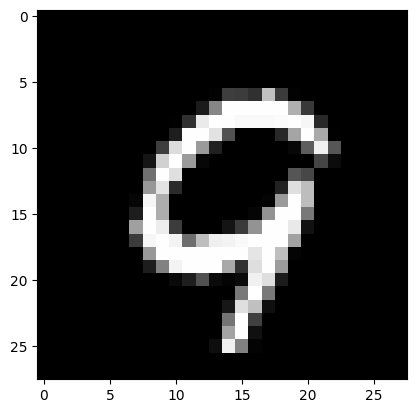

Prediction:  [7]
Label:  7


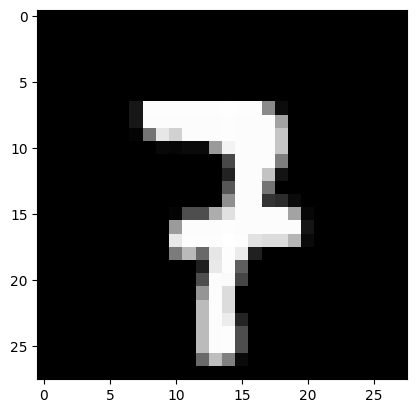

Prediction:  [0]
Label:  0


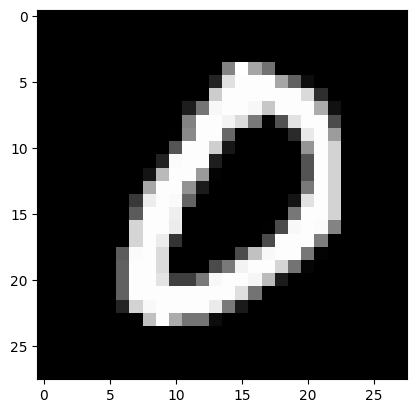

Prediction:  [7]
Label:  7


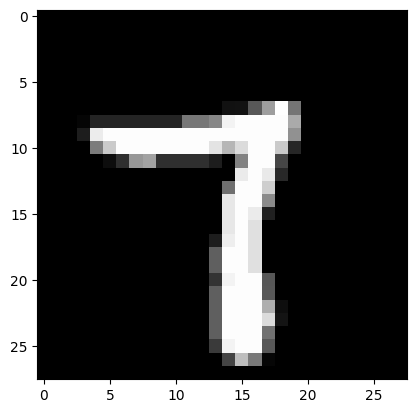

Prediction:  [1]
Label:  1


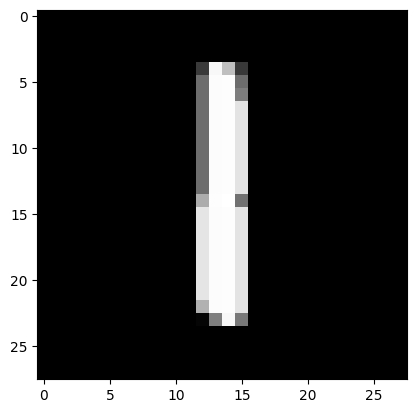

Prediction:  [9]
Label:  9


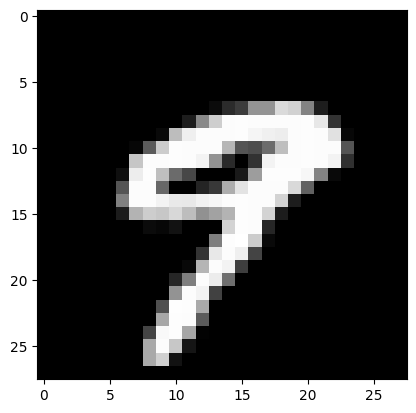

Prediction:  [2]
Label:  2


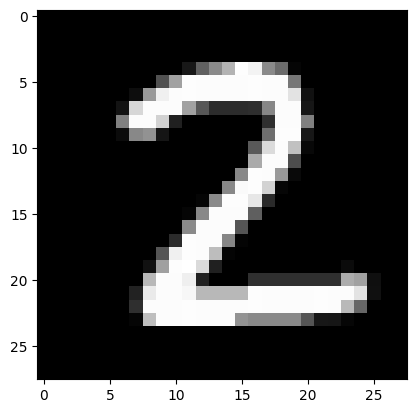

Prediction:  [4]
Label:  4


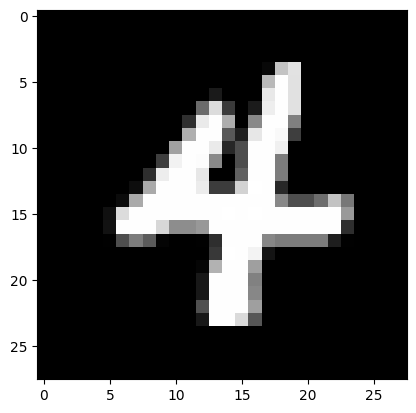

Prediction:  [5]
Label:  5


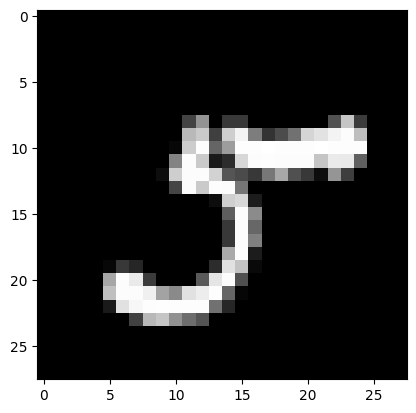

Prediction:  [9]
Label:  9


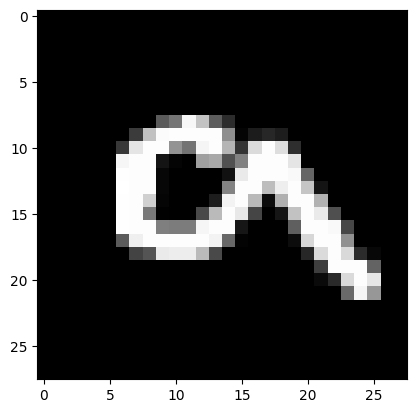

Prediction:  [7]
Label:  7


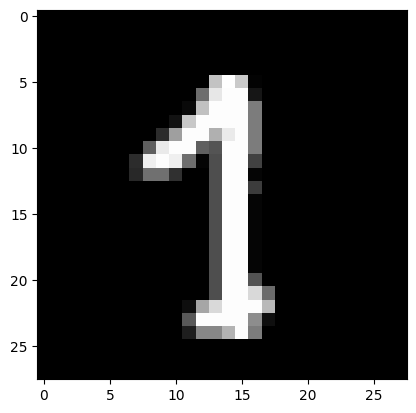

Prediction:  [1]
Label:  1


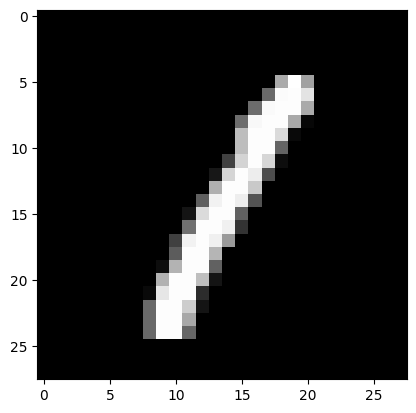

Prediction:  [3]
Label:  3


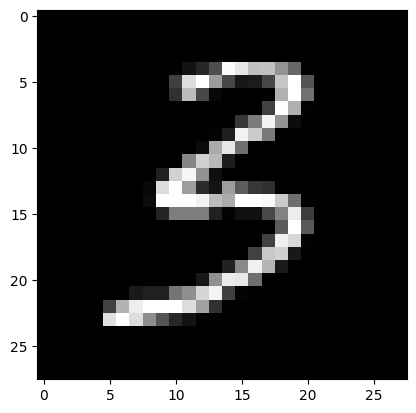

Prediction:  [1]
Label:  1


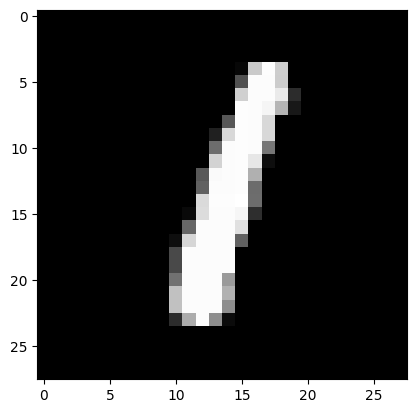

Prediction:  [3]
Label:  3


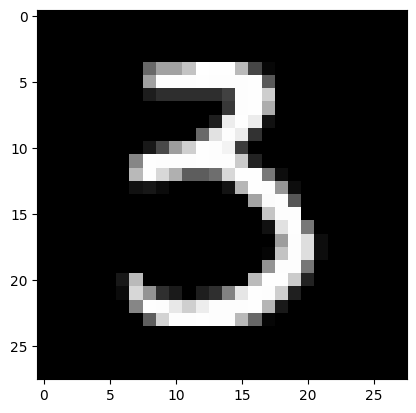

Prediction:  [8]
Label:  8


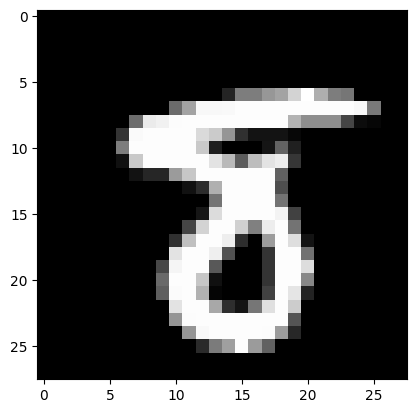

Prediction:  [6]
Label:  6


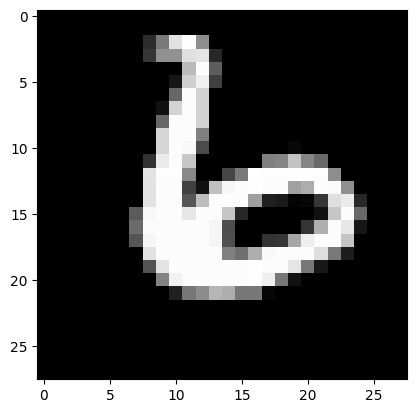

Prediction:  [4]
Label:  4


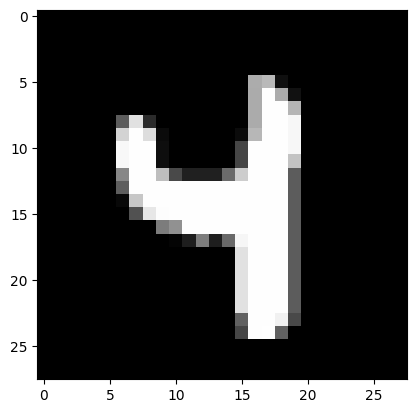

Prediction:  [4]
Label:  4


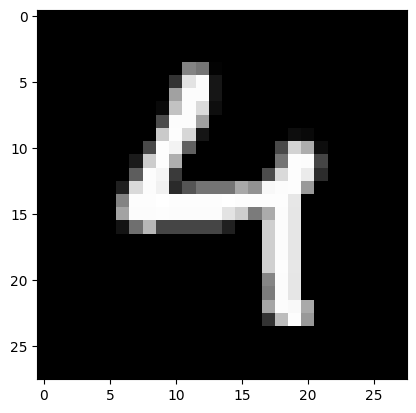

Prediction:  [7]
Label:  7


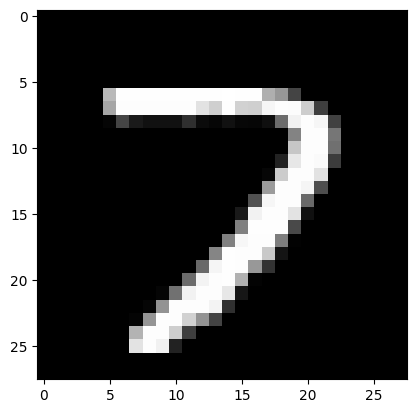

Prediction:  [9]
Label:  9


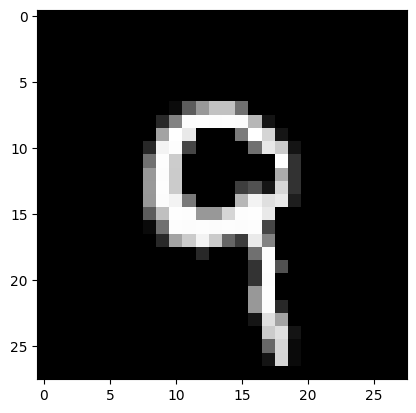

Prediction:  [5]
Label:  5


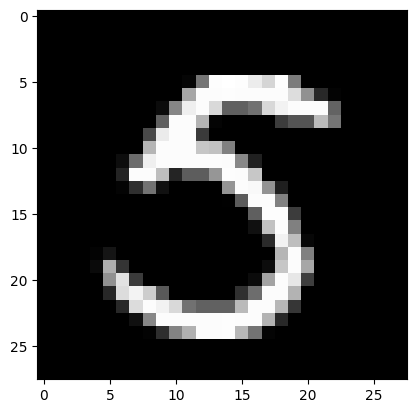

Prediction:  [4]
Label:  4


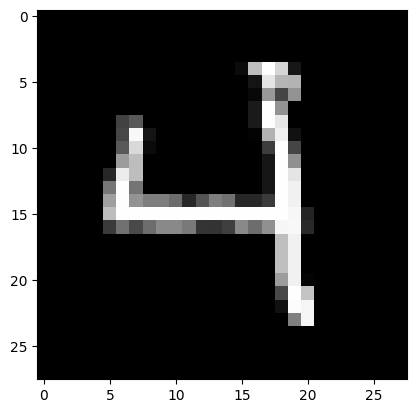

Prediction:  [8]
Label:  8


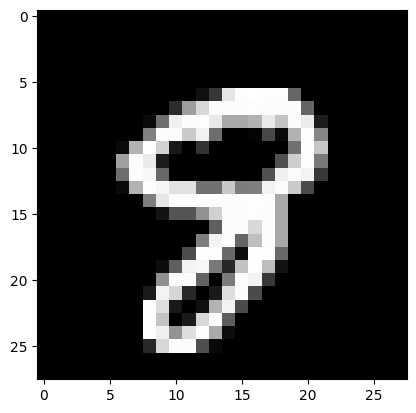

Prediction:  [3]
Label:  3


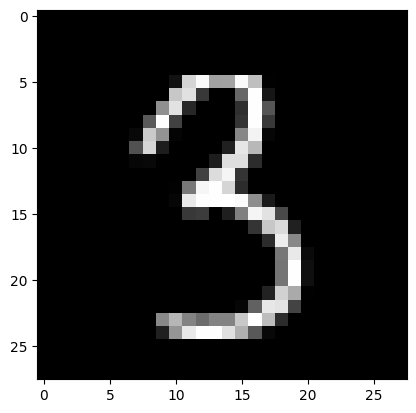

Prediction:  [9]
Label:  9


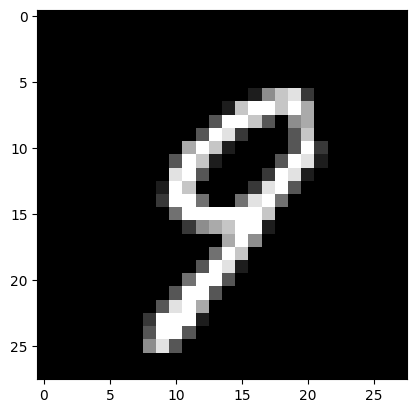

Prediction:  [7]
Label:  7


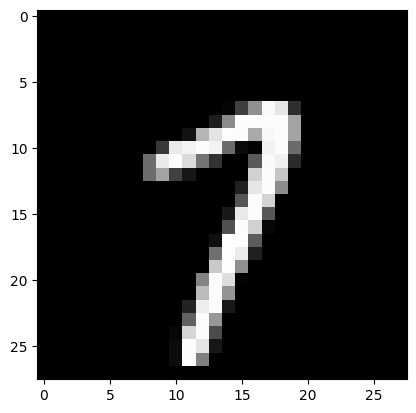

Prediction:  [7]
Label:  7


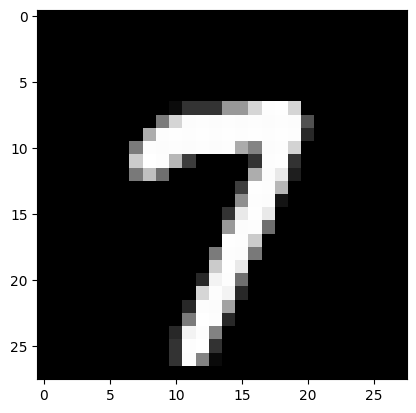

Prediction:  [1]
Label:  1


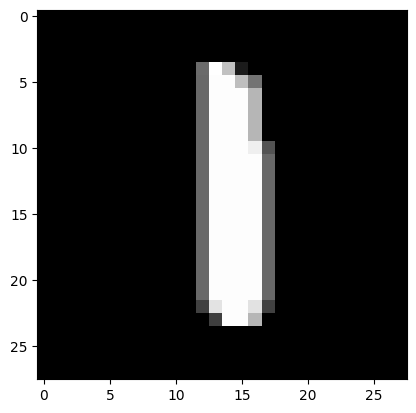

Prediction:  [7]
Label:  7


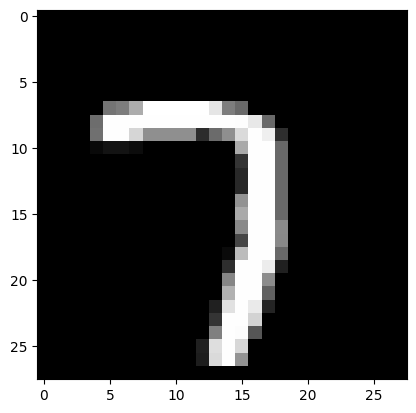

Prediction:  [5]
Label:  5


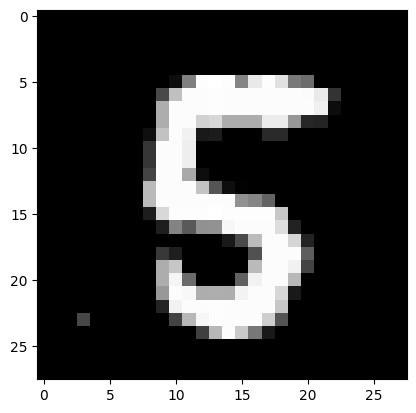

Prediction:  [0]
Label:  0


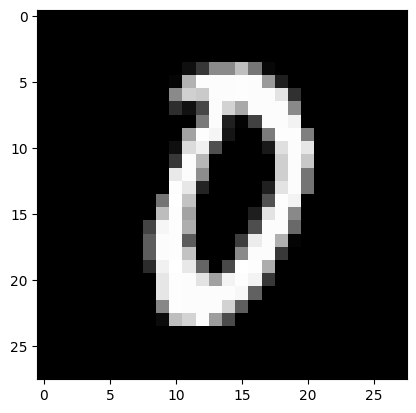

Prediction:  [2]
Label:  2


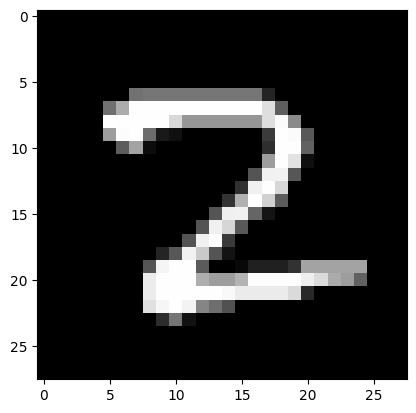

Prediction:  [0]
Label:  0


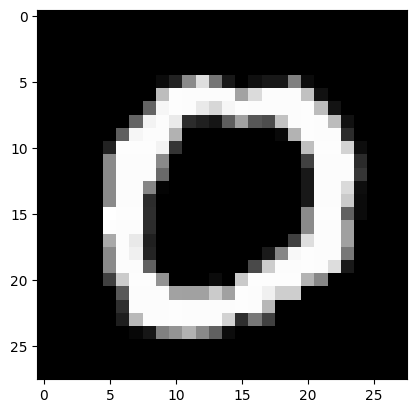

Prediction:  [2]
Label:  2


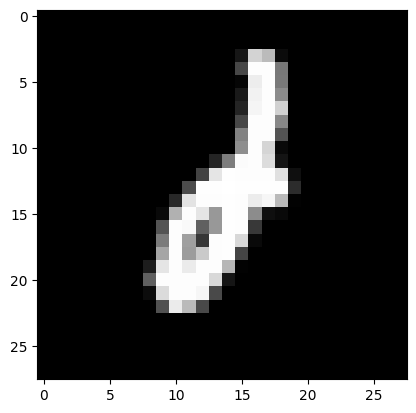

Prediction:  [7]
Label:  7


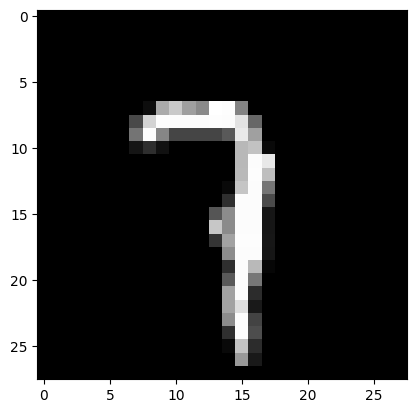

Prediction:  [3]
Label:  5


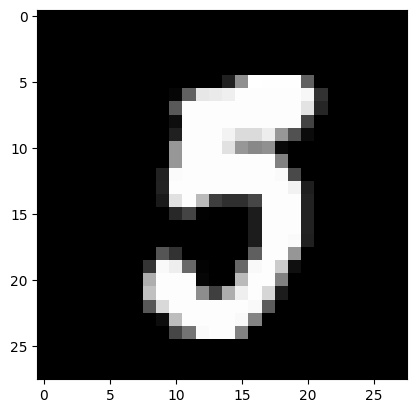

Prediction:  [9]
Label:  9


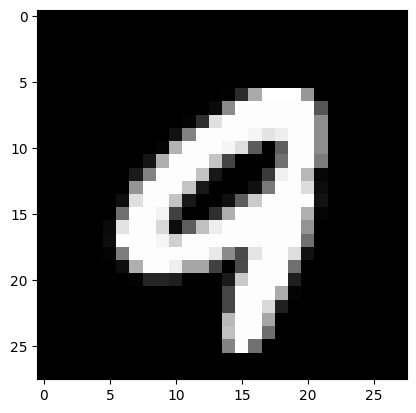

Prediction:  [8]
Label:  8


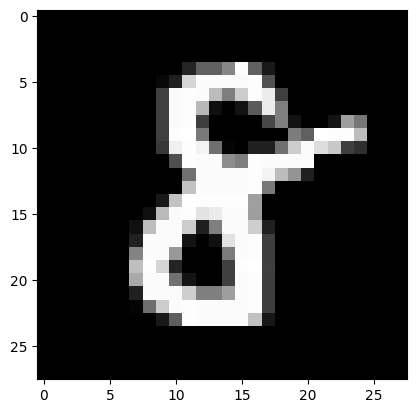

Prediction:  [1]
Label:  7


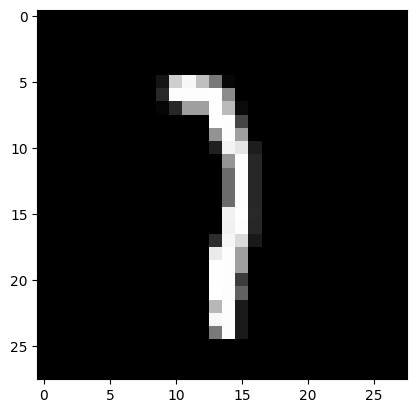

Prediction:  [2]
Label:  2


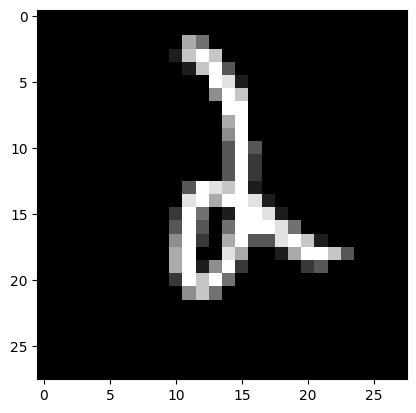

Prediction:  [9]
Label:  9


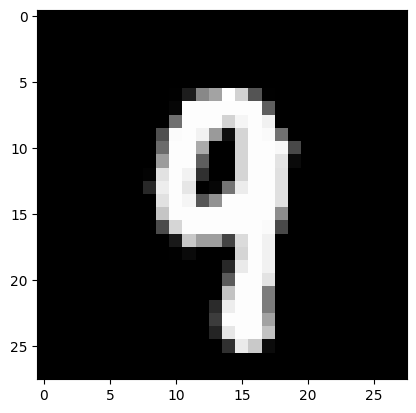

Prediction:  [8]
Label:  8


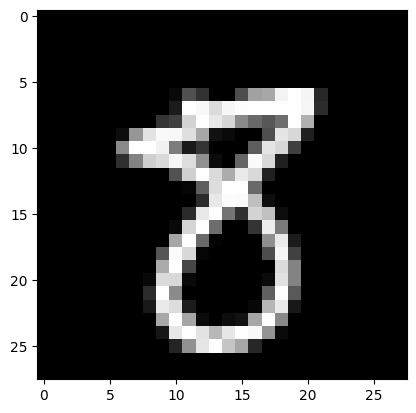

Prediction:  [2]
Label:  2


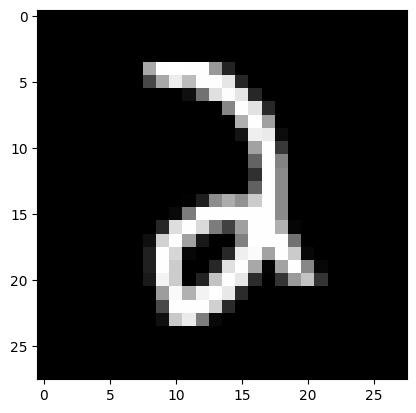

Prediction:  [7]
Label:  7


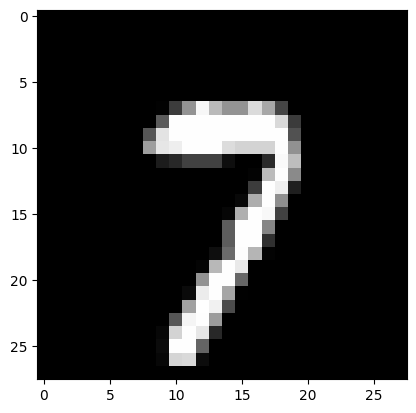

Prediction:  [5]
Label:  5


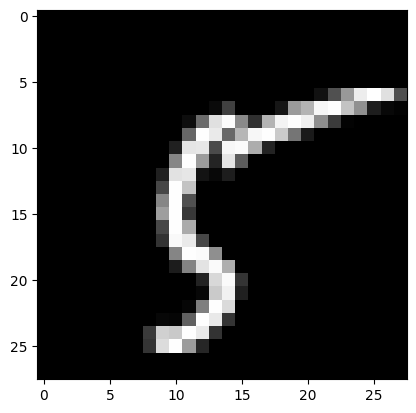

Prediction:  [8]
Label:  8


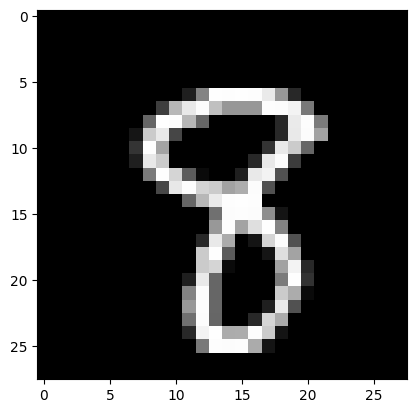

Prediction:  [0]
Label:  0


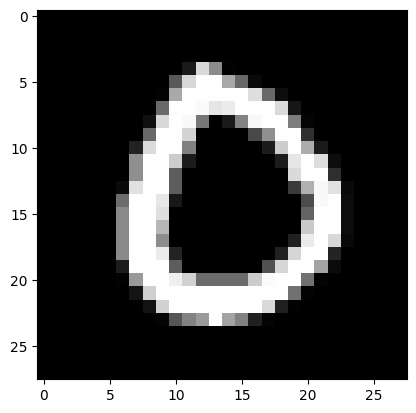

Prediction:  [9]
Label:  9


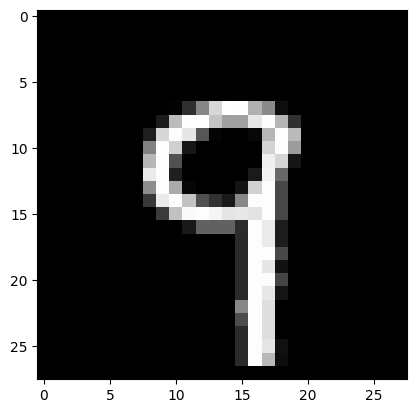

Prediction:  [7]
Label:  7


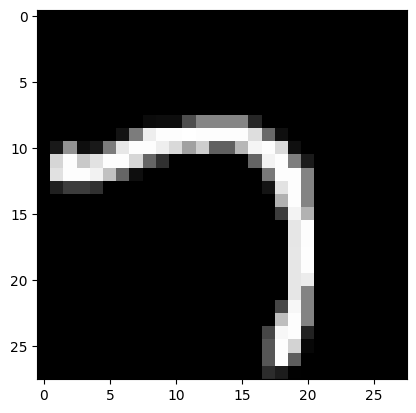

Prediction:  [3]
Label:  3


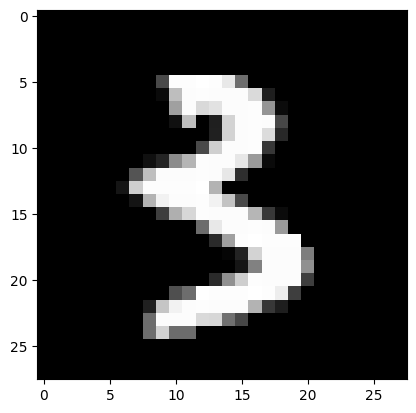

Prediction:  [1]
Label:  1


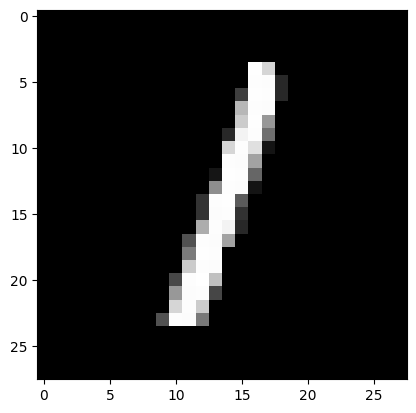

Prediction:  [4]
Label:  4


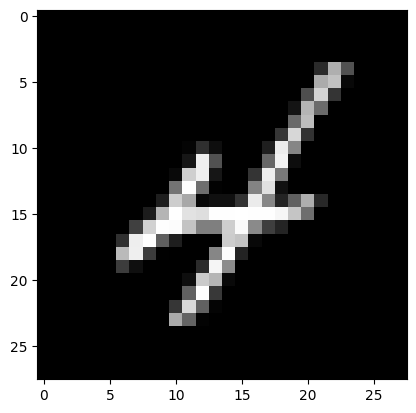

Prediction:  [8]
Label:  8


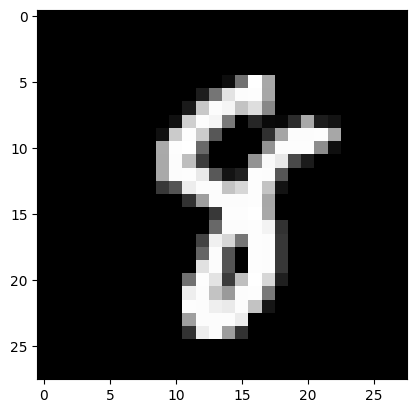

Prediction:  [8]
Label:  8


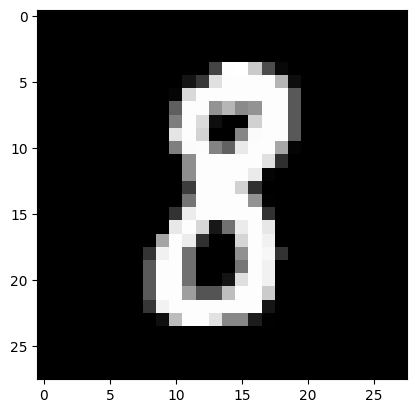

Prediction:  [9]
Label:  9


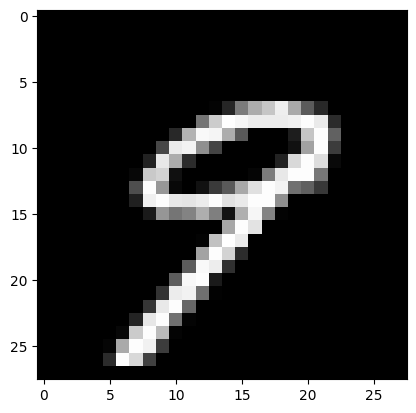

Prediction:  [4]
Label:  4


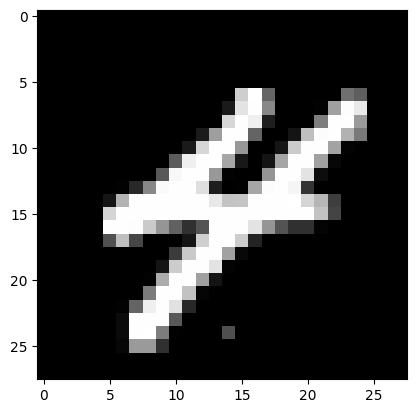

Prediction:  [9]
Label:  9


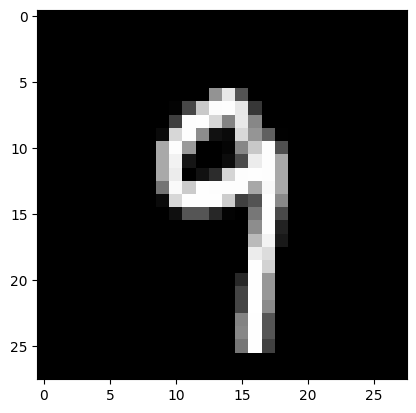

Prediction:  [7]
Label:  7


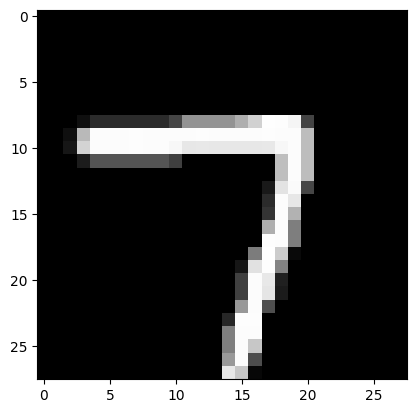

Prediction:  [4]
Label:  4


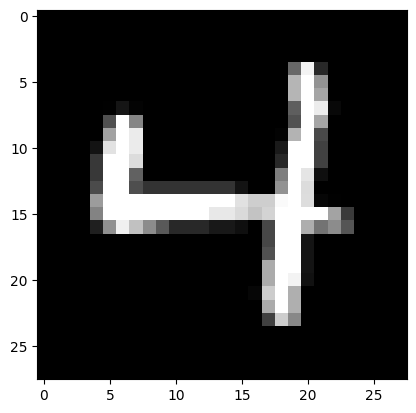

Prediction:  [5]
Label:  5


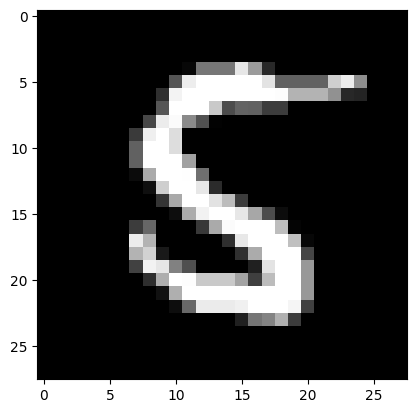

Prediction:  [2]
Label:  2


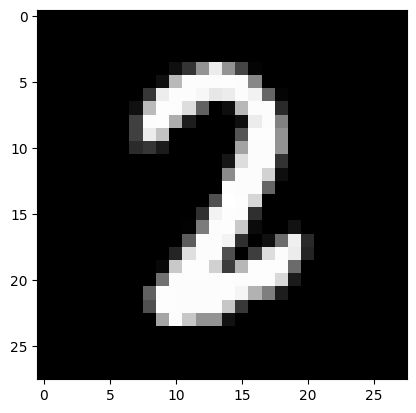

Prediction:  [2]
Label:  2


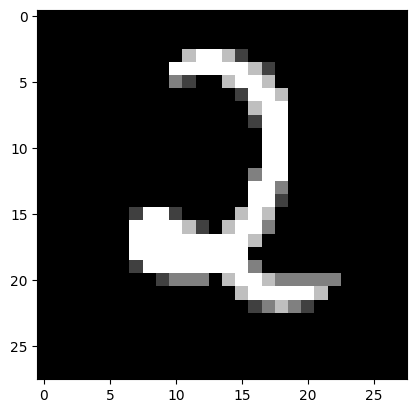

Prediction:  [0]
Label:  0


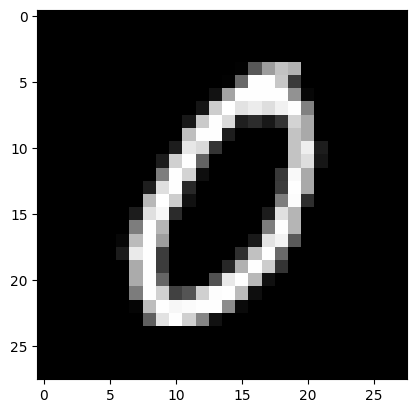

Prediction:  [4]
Label:  4


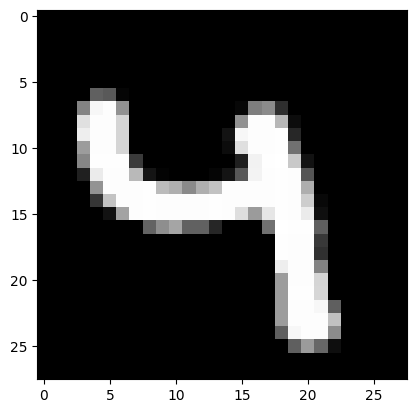

Prediction:  [0]
Label:  0


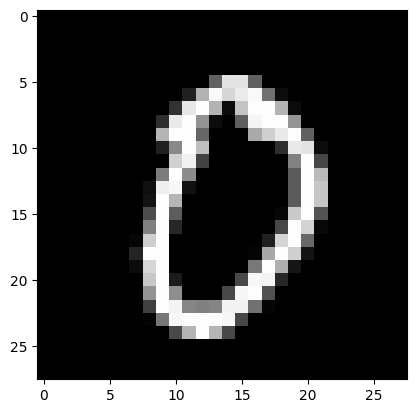

Prediction:  [7]
Label:  7


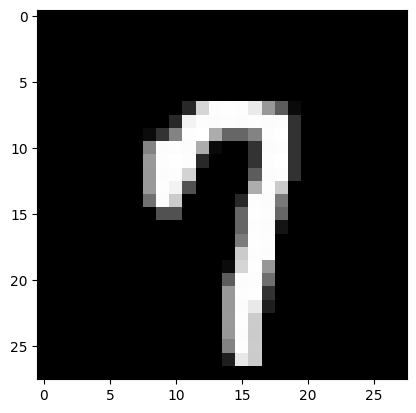

Prediction:  [5]
Label:  5


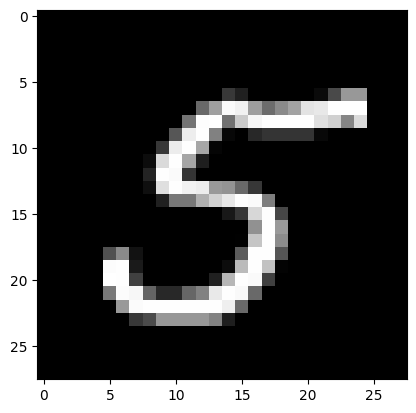

Prediction:  [9]
Label:  4


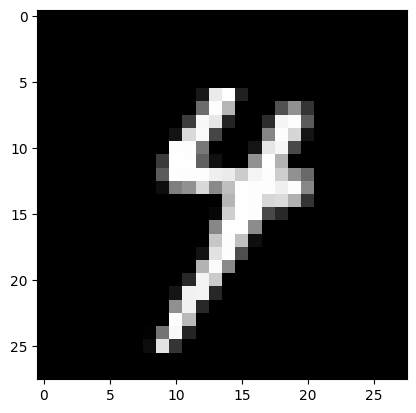

Prediction:  [6]
Label:  6


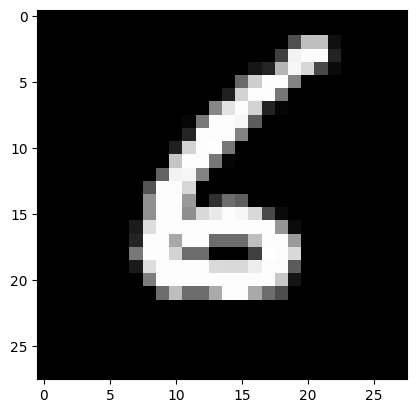

Prediction:  [9]
Label:  9


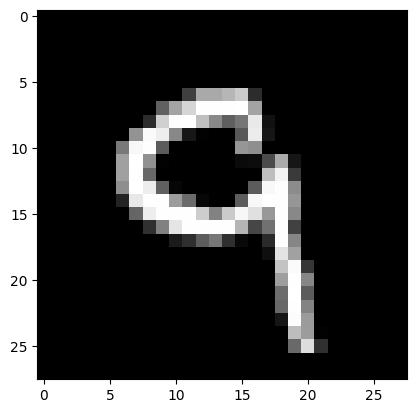

Prediction:  [1]
Label:  1


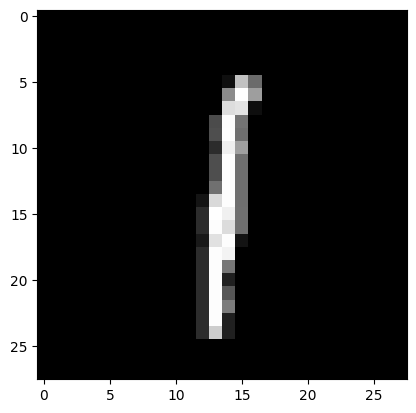

Prediction:  [5]
Label:  5


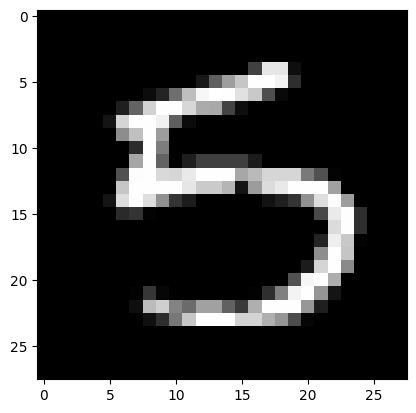

Prediction:  [8]
Label:  8


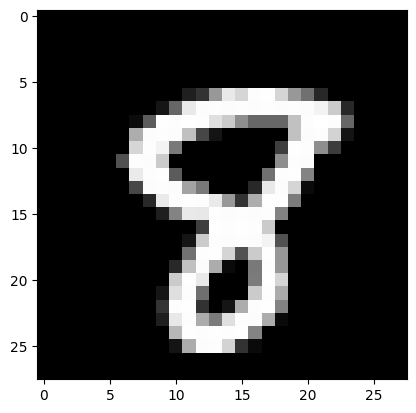

Prediction:  [5]
Label:  3


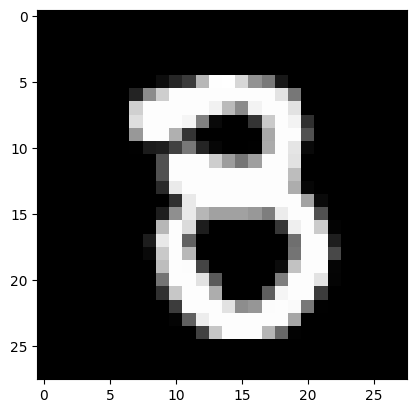

Prediction:  [3]
Label:  3


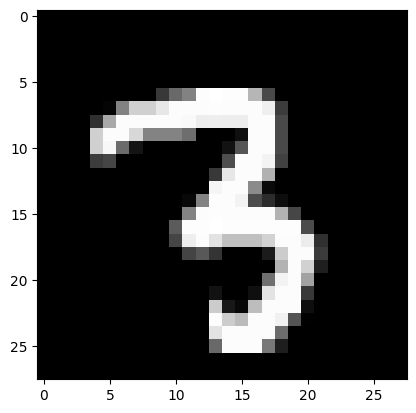

Prediction:  [1]
Label:  1


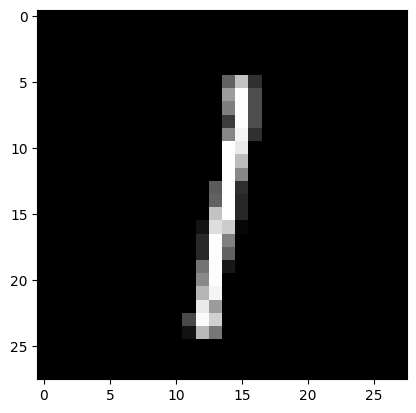

Prediction:  [4]
Label:  4


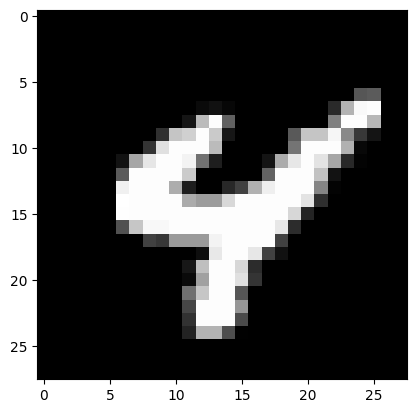

Prediction:  [8]
Label:  8


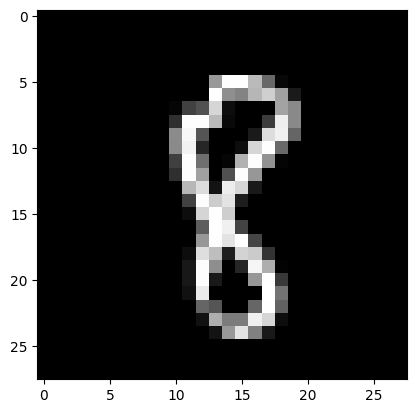

Prediction:  [0]
Label:  0


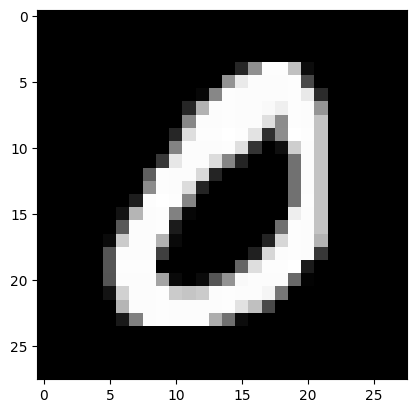

Prediction:  [8]
Label:  8


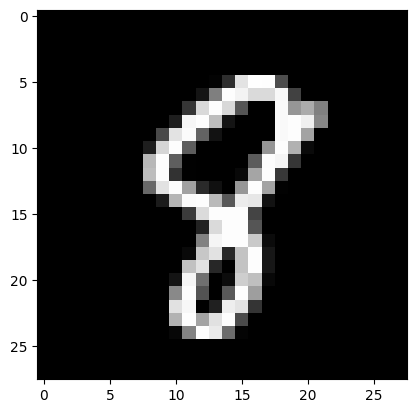

Prediction:  [1]
Label:  1


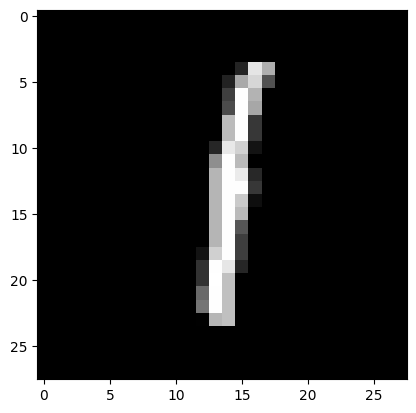

Prediction:  [9]
Label:  9


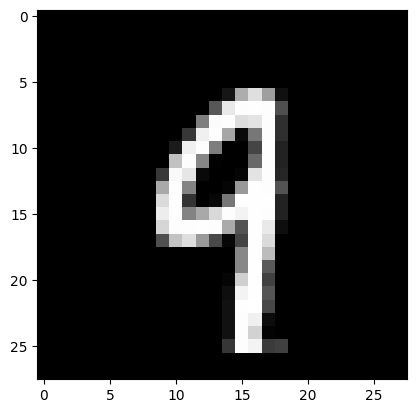

Prediction:  [1]
Label:  1


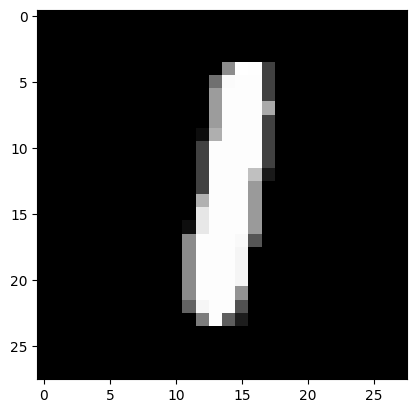

Prediction:  [9]
Label:  9


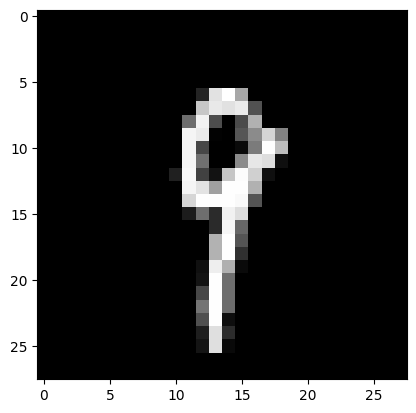

Prediction:  [7]
Label:  7


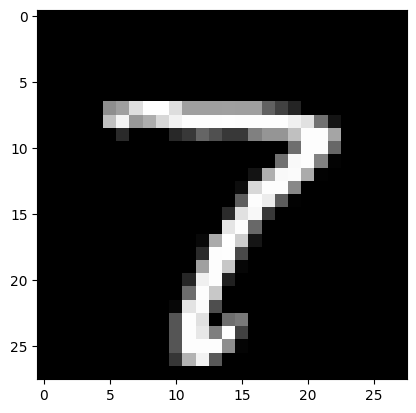

Prediction:  [4]
Label:  4


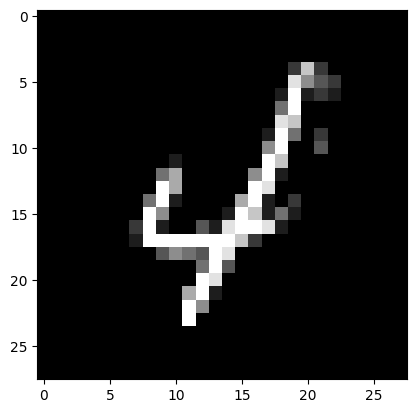

Prediction:  [7]
Label:  7


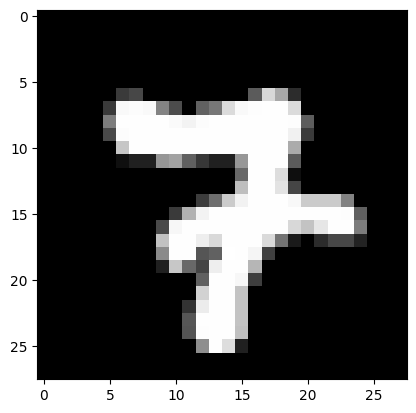

Prediction:  [9]
Label:  9


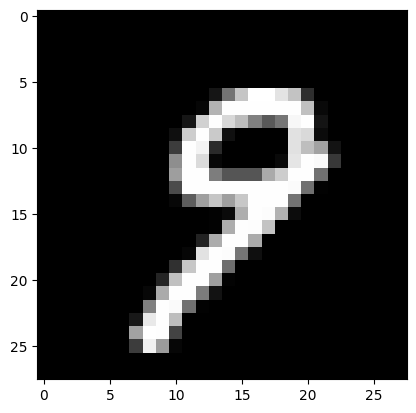

Prediction:  [9]
Label:  9


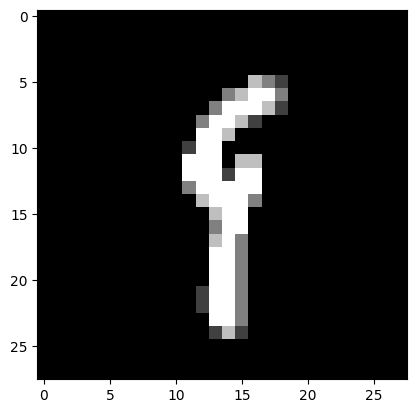

Prediction:  [3]
Label:  3


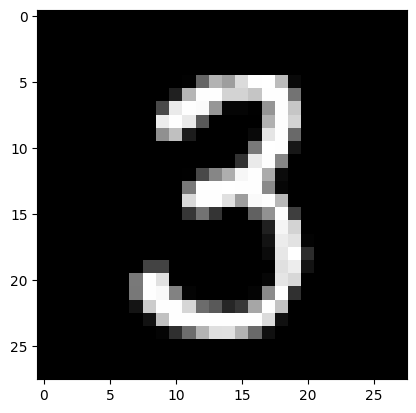

Prediction:  [0]
Label:  0


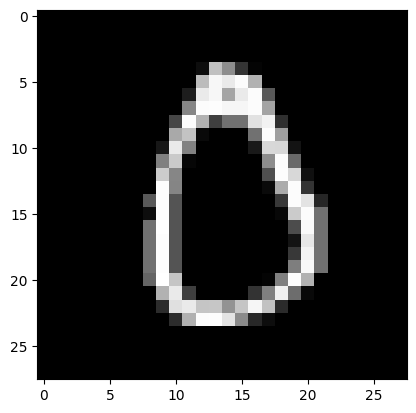

Prediction:  [3]
Label:  3


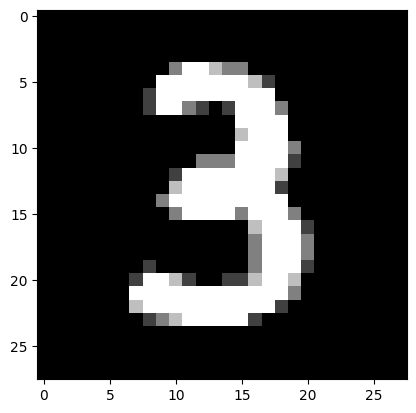

Prediction:  [3]
Label:  3


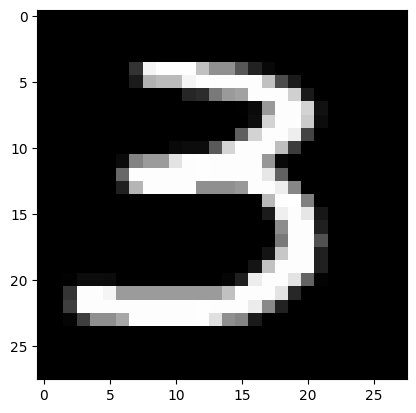

Prediction:  [6]
Label:  6


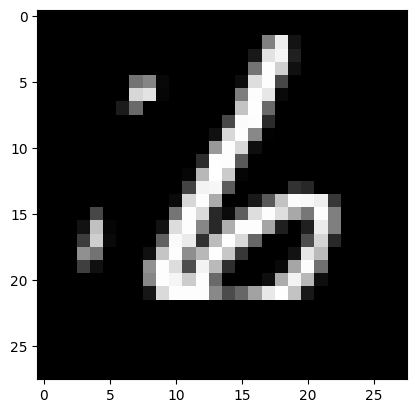

Prediction:  [5]
Label:  5


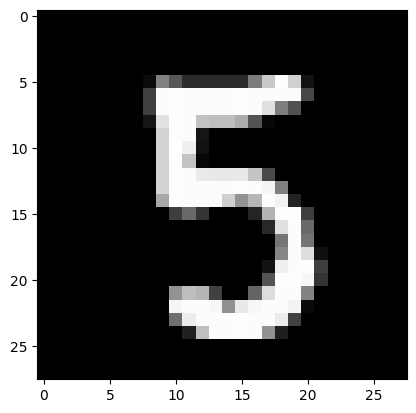

Prediction:  [2]
Label:  2


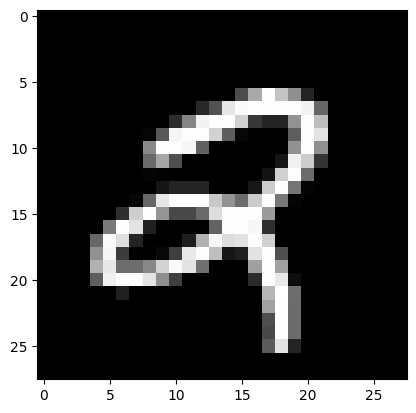

Prediction:  [9]
Label:  9


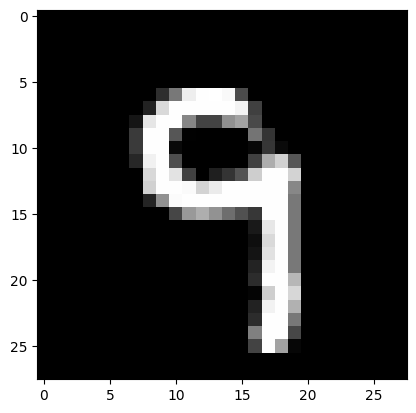

Prediction:  [8]
Label:  8


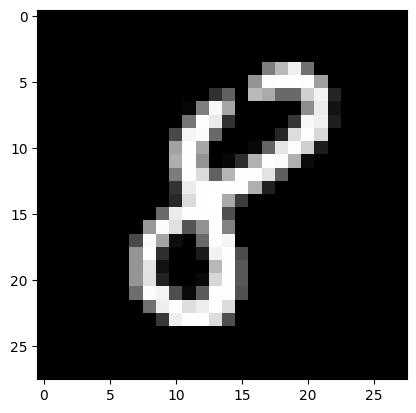

Prediction:  [0]
Label:  0


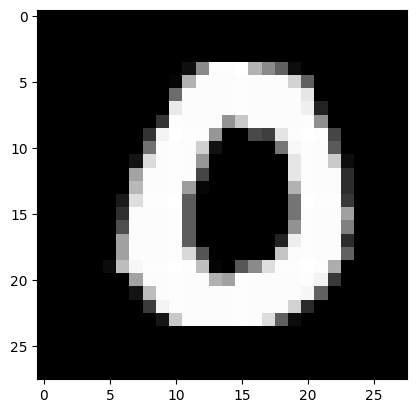

Prediction:  [8]
Label:  8


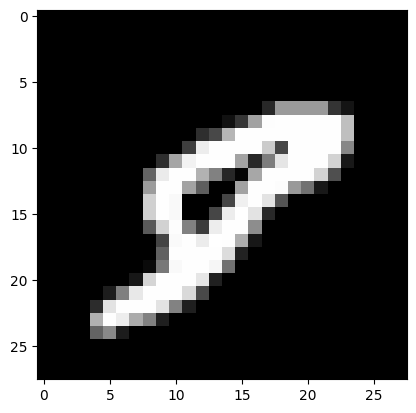

Prediction:  [4]
Label:  4


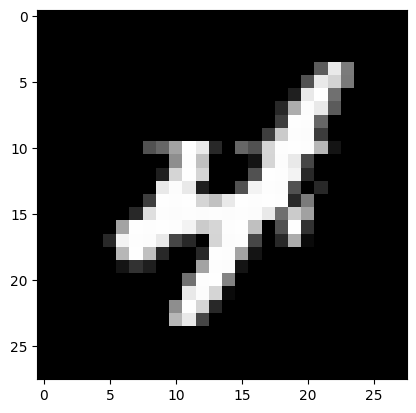

Prediction:  [8]
Label:  9


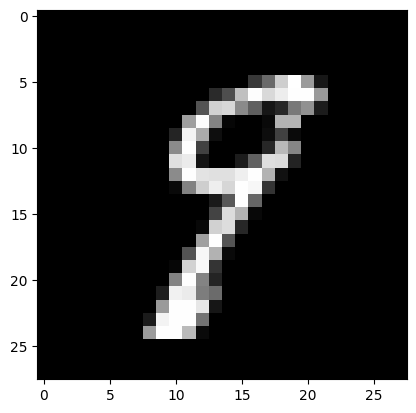

Prediction:  [1]
Label:  1


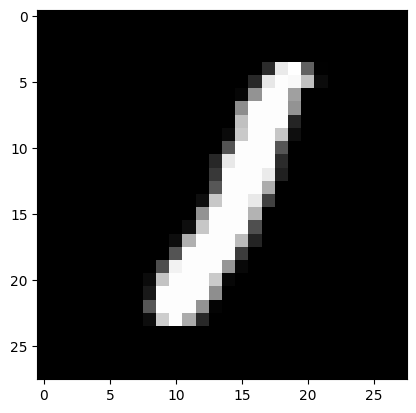

Prediction:  [6]
Label:  6


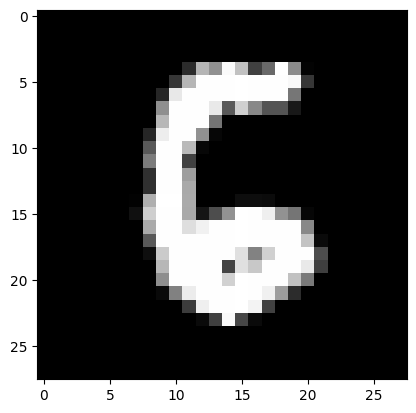

Prediction:  [0]
Label:  0


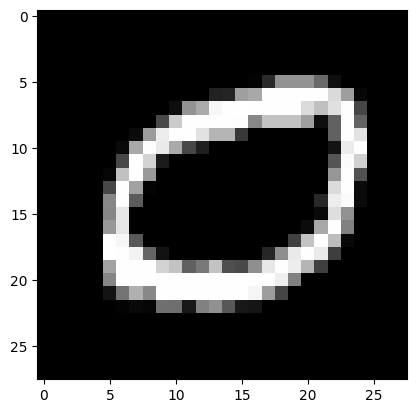

Prediction:  [0]
Label:  0


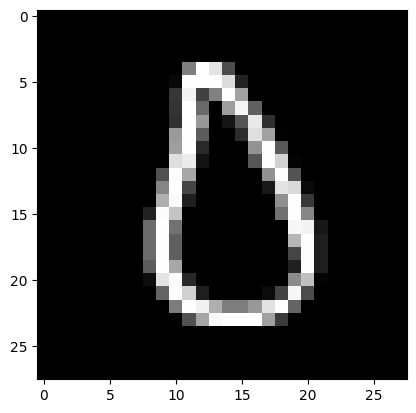

Prediction:  [2]
Label:  2


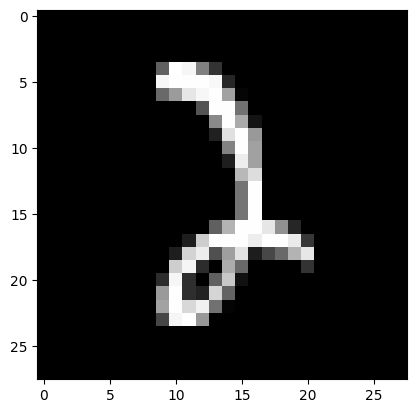

Prediction:  [9]
Label:  9


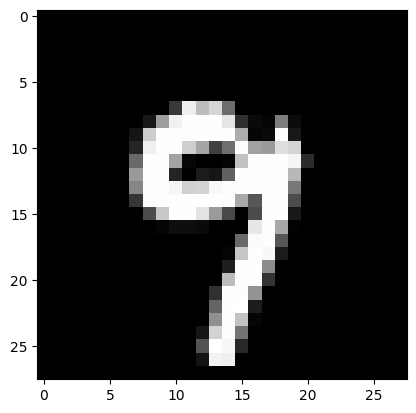

Prediction:  [3]
Label:  3


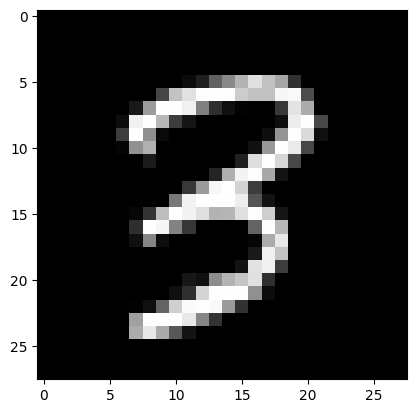

Prediction:  [8]
Label:  8


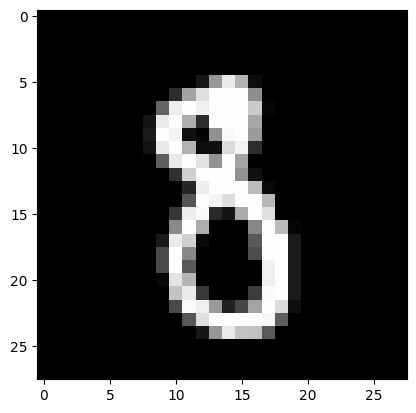

Prediction:  [9]
Label:  9


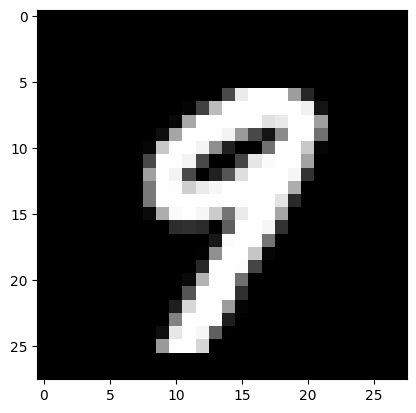

Prediction:  [9]
Label:  9


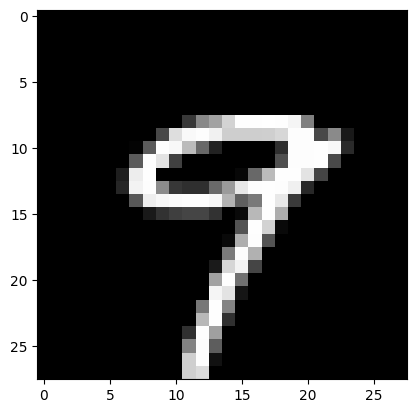

Prediction:  [0]
Label:  0


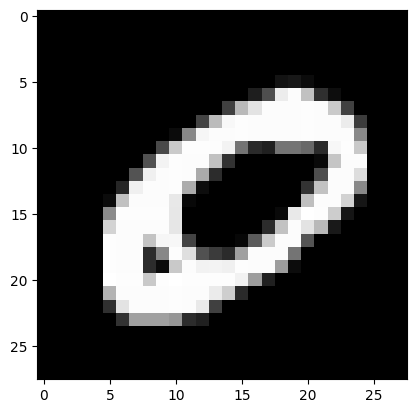

Prediction:  [0]
Label:  0


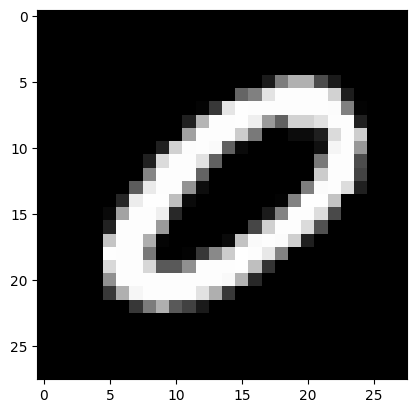

Prediction:  [2]
Label:  2


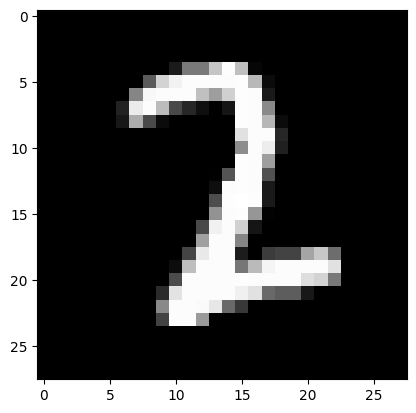

Prediction:  [2]
Label:  2


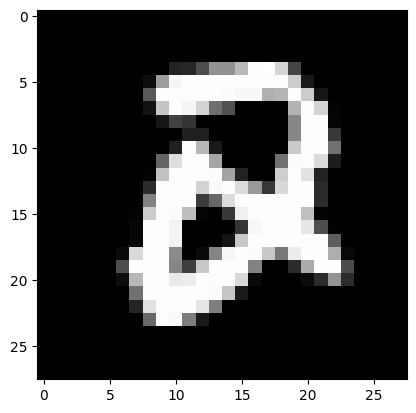

Prediction:  [3]
Label:  3


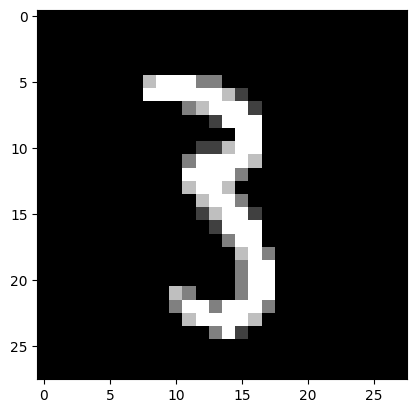

Prediction:  [0]
Label:  0


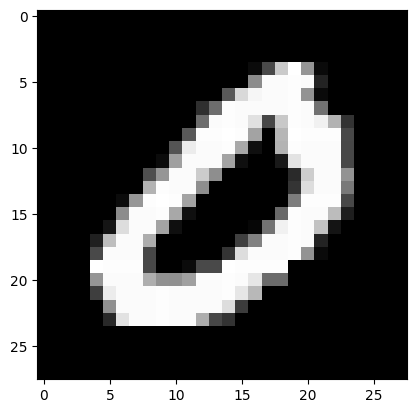

Prediction:  [9]
Label:  9


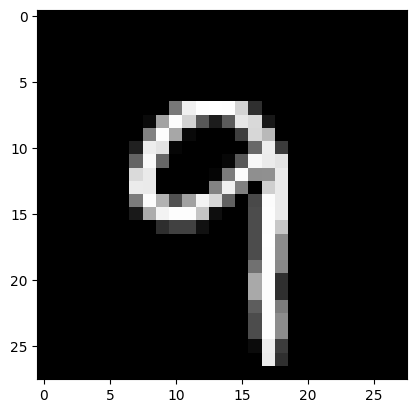

Prediction:  [2]
Label:  2


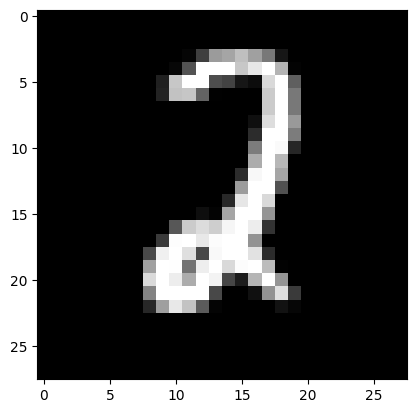

Prediction:  [1]
Label:  1


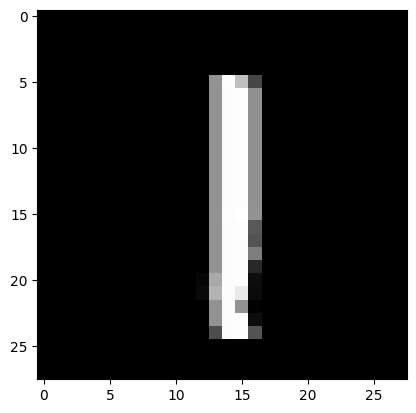

Prediction:  [2]
Label:  2


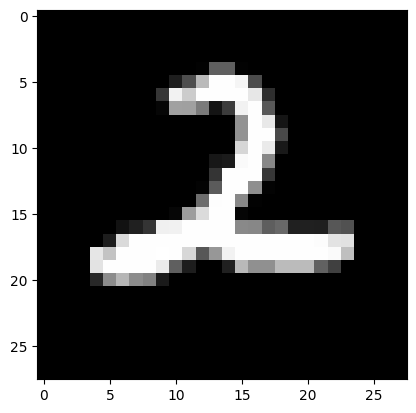

Prediction:  [3]
Label:  3


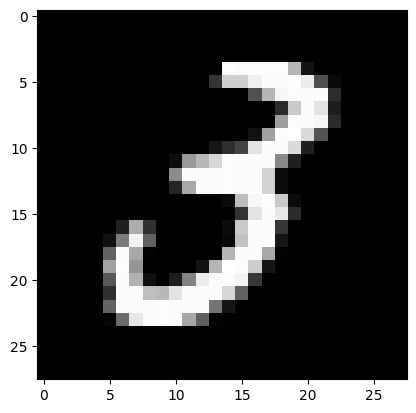

Prediction:  [6]
Label:  6


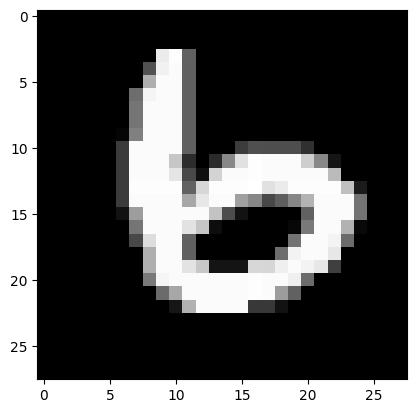

Prediction:  [6]
Label:  6


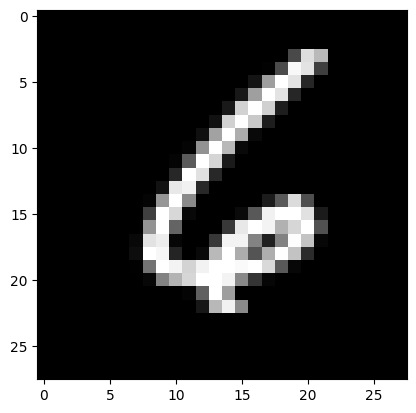

Prediction:  [9]
Label:  9


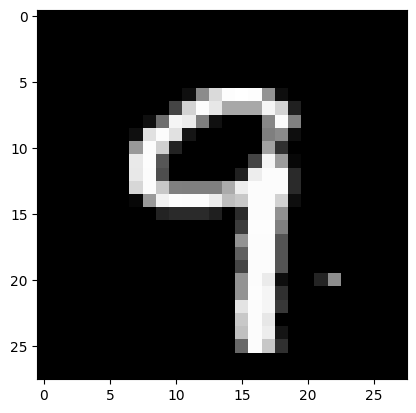

Prediction:  [1]
Label:  1


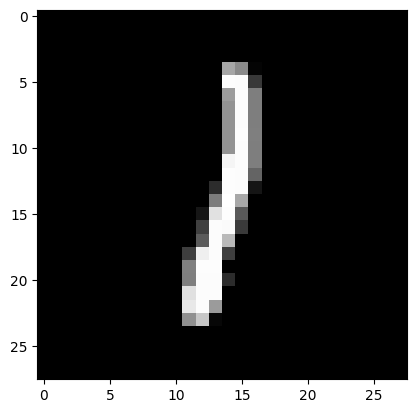

Prediction:  [3]
Label:  3


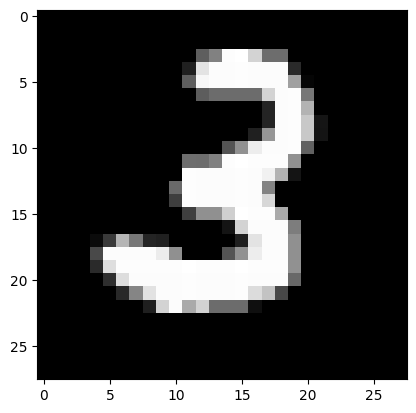

Prediction:  [2]
Label:  2


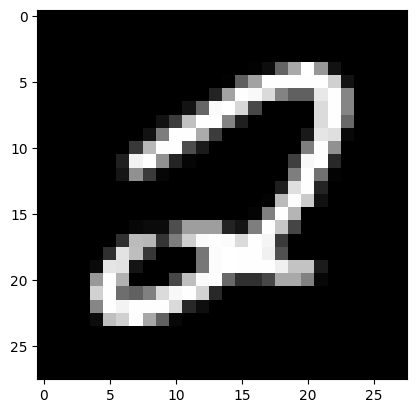

Prediction:  [6]
Label:  6


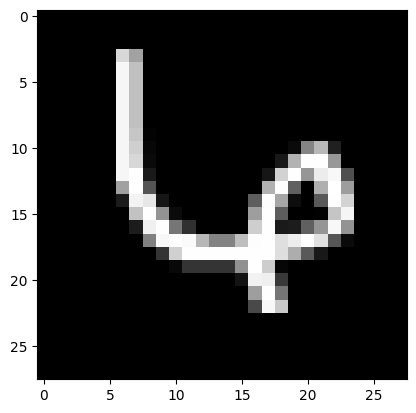

Prediction:  [1]
Label:  1


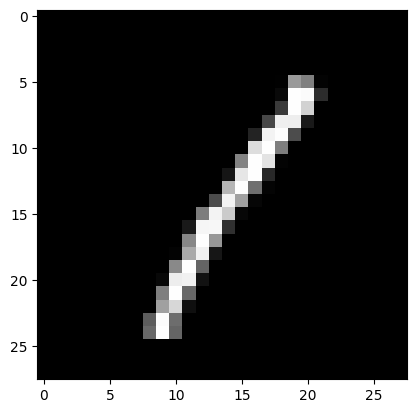

Prediction:  [8]
Label:  8


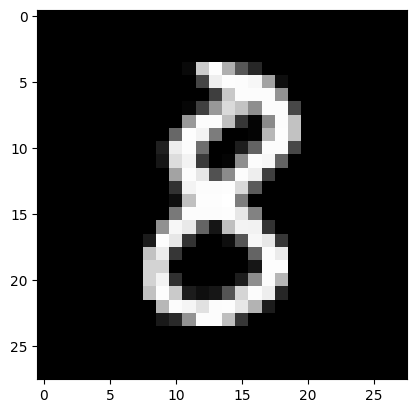

Prediction:  [5]
Label:  5


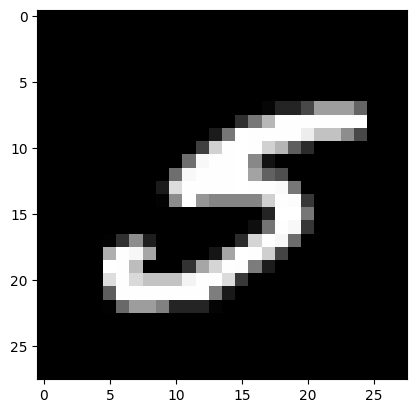

Prediction:  [9]
Label:  9


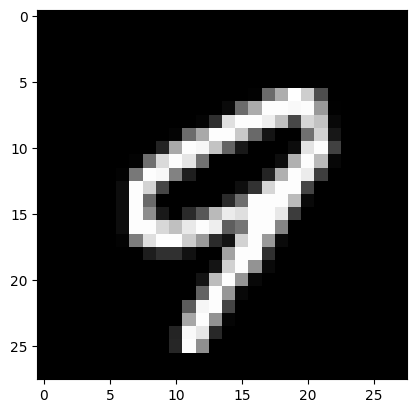

Prediction:  [1]
Label:  1


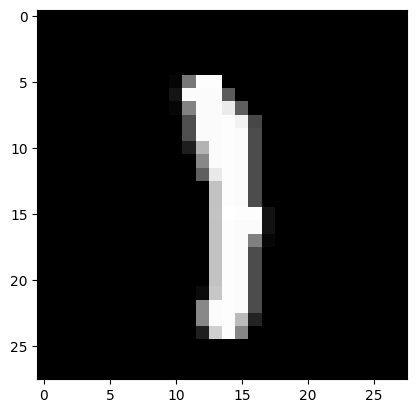

Prediction:  [1]
Label:  1


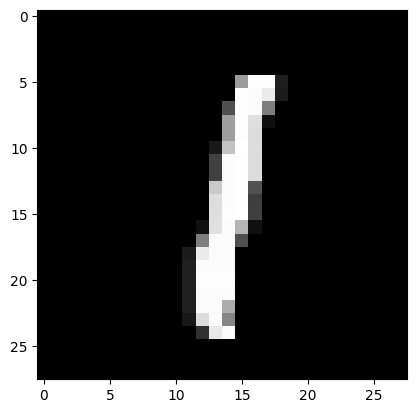

Prediction:  [7]
Label:  7


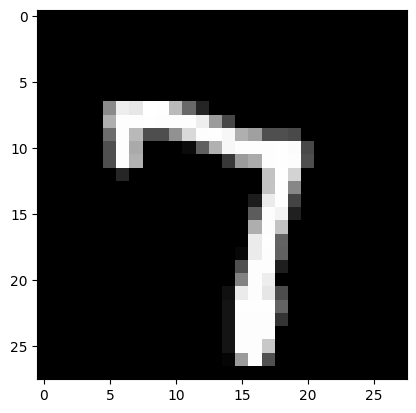

Prediction:  [0]
Label:  0


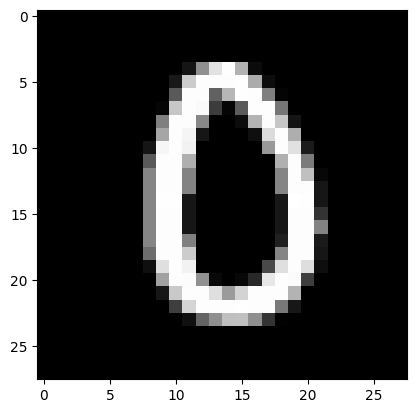

Prediction:  [5]
Label:  5


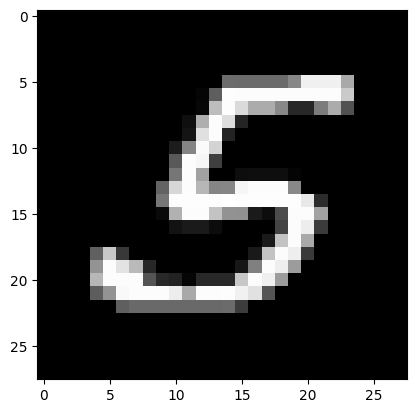

Prediction:  [6]
Label:  6


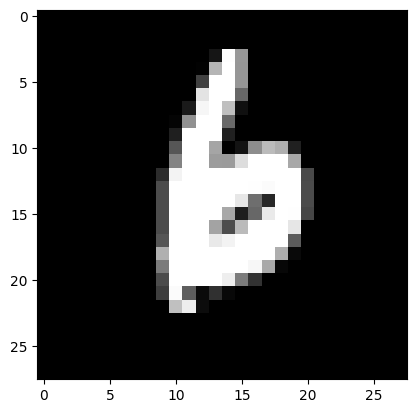

Prediction:  [5]
Label:  3


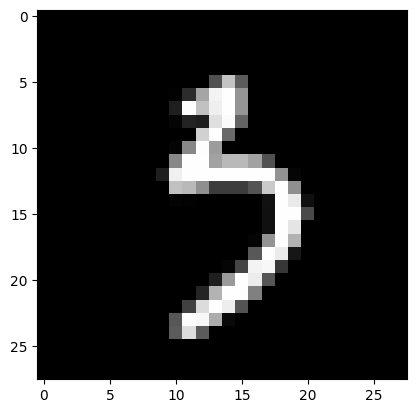

Prediction:  [0]
Label:  0


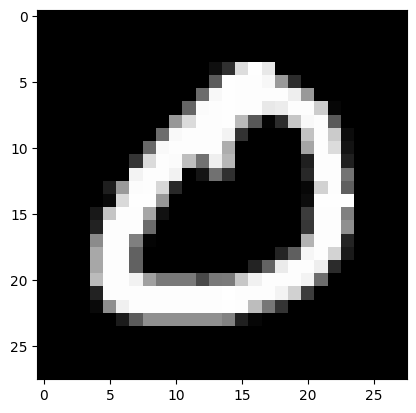

Prediction:  [7]
Label:  7


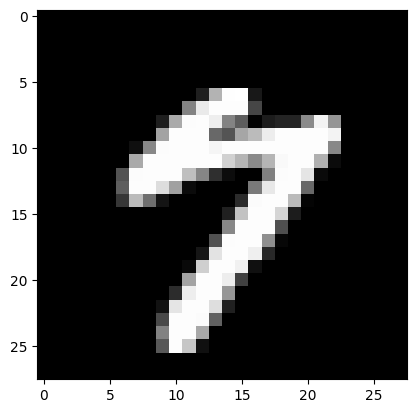

Prediction:  [6]
Label:  6


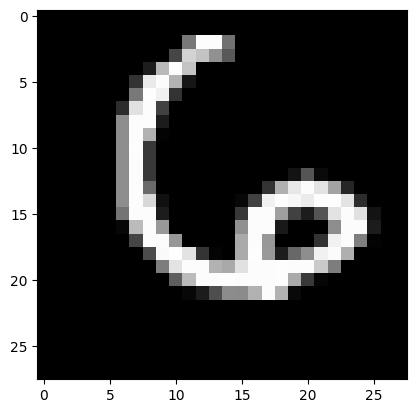

Prediction:  [0]
Label:  0


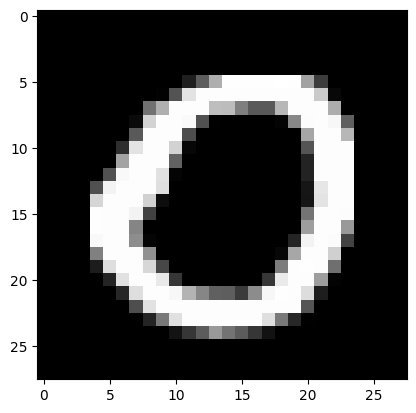

Prediction:  [0]
Label:  0


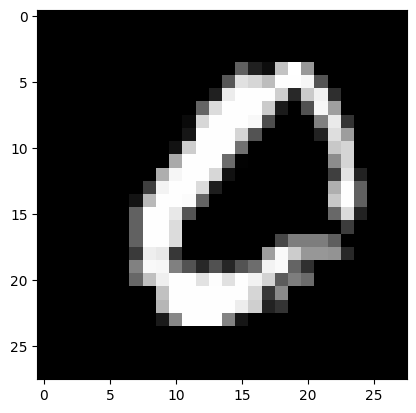

Prediction:  [8]
Label:  8


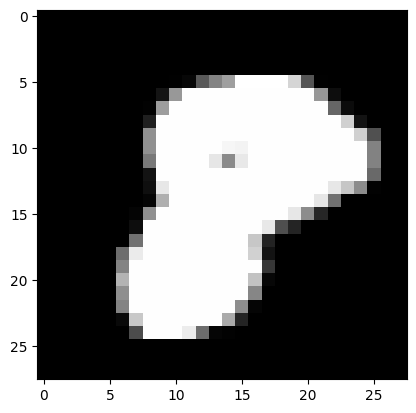

Prediction:  [3]
Label:  3


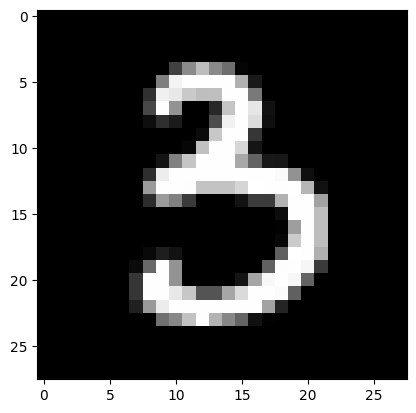

Prediction:  [6]
Label:  6


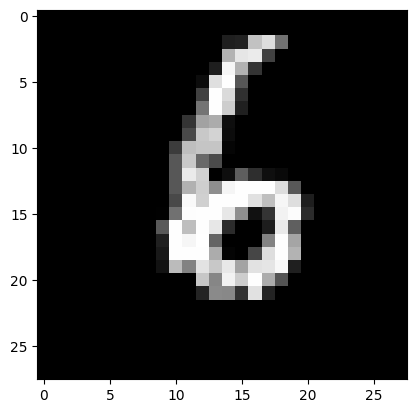

Prediction:  [8]
Label:  8


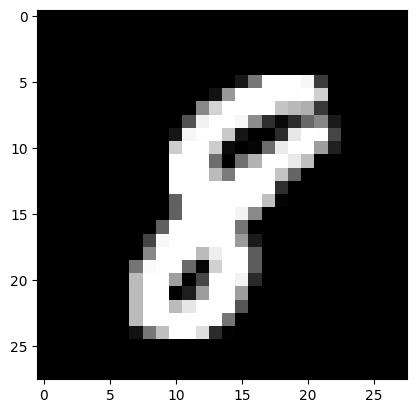

Prediction:  [6]
Label:  6


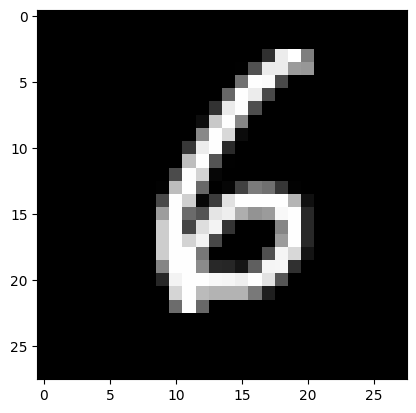

Prediction:  [1]
Label:  1


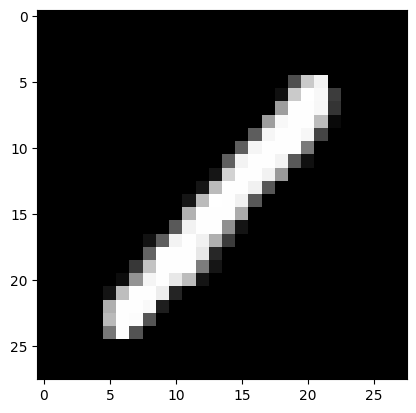

Prediction:  [4]
Label:  4


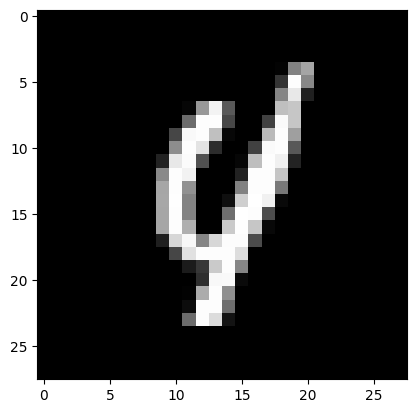

Prediction:  [1]
Label:  1


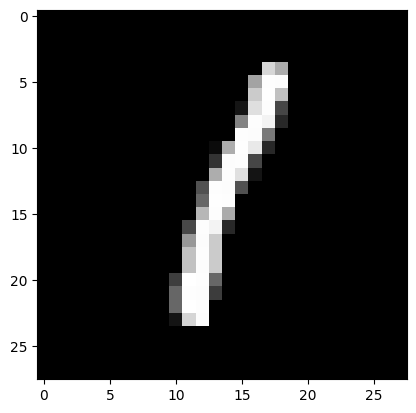

Prediction:  [1]
Label:  1


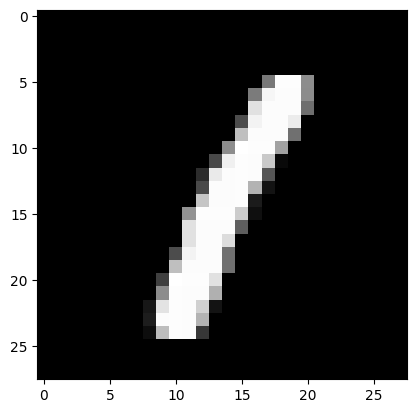

Prediction:  [6]
Label:  6


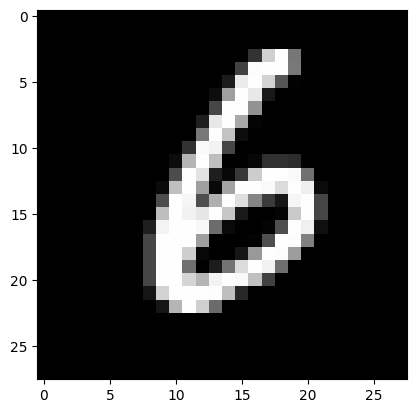

Prediction:  [3]
Label:  3


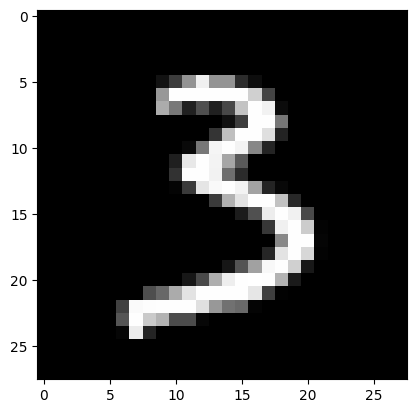

Prediction:  [4]
Label:  4


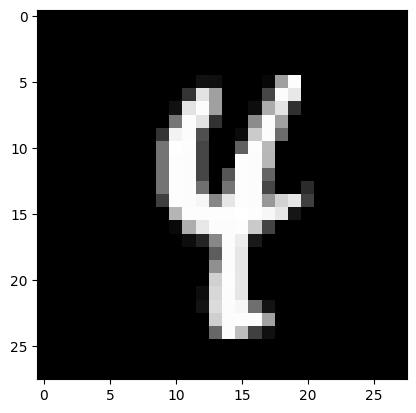

Prediction:  [5]
Label:  5


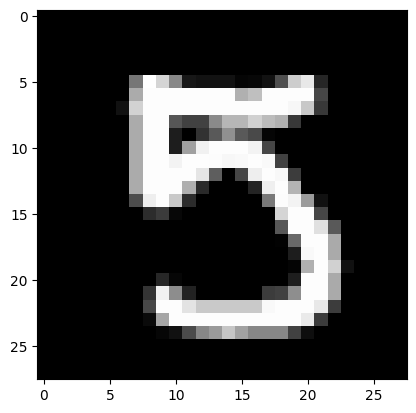

Prediction:  [9]
Label:  9


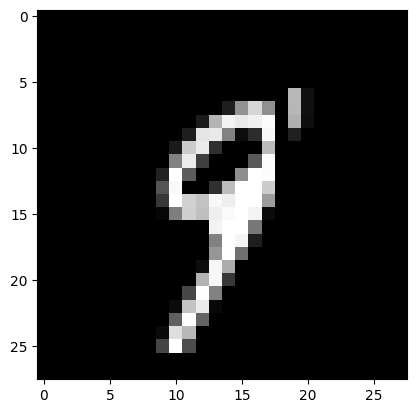

Prediction:  [1]
Label:  1


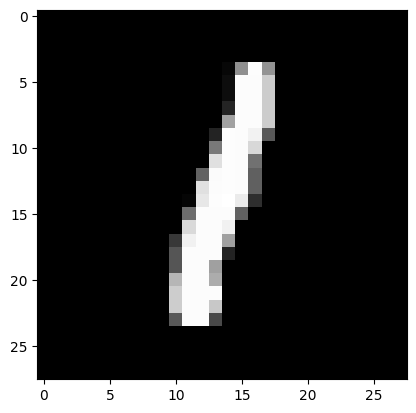

Prediction:  [7]
Label:  7


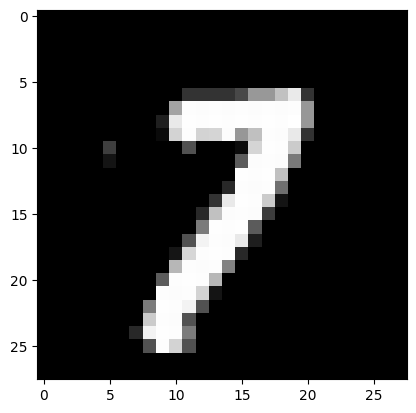

Prediction:  [8]
Label:  8


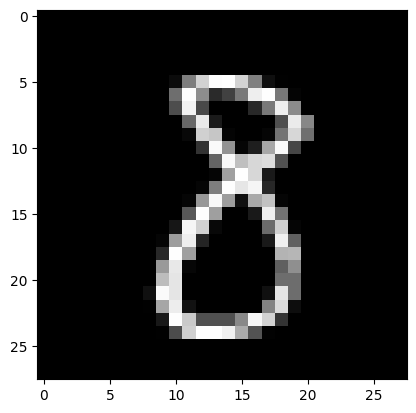

Prediction:  [1]
Label:  1


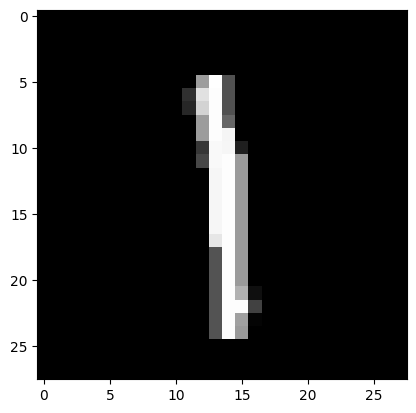

Prediction:  [1]
Label:  1


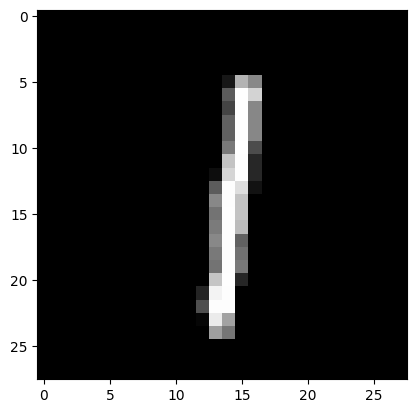

Prediction:  [8]
Label:  8


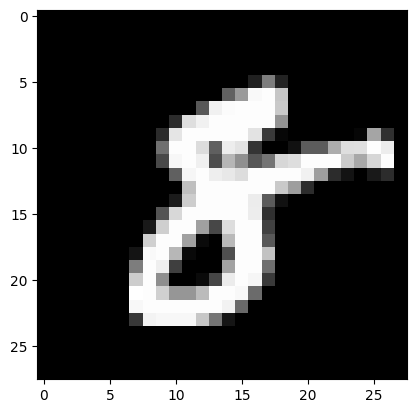

Prediction:  [9]
Label:  9


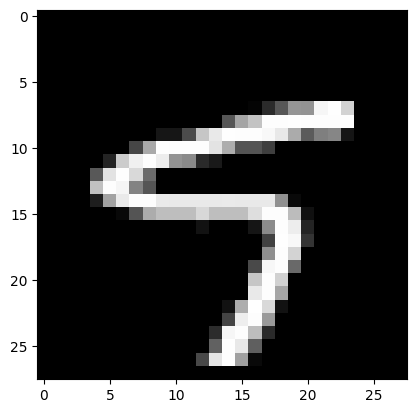

Prediction:  [0]
Label:  0


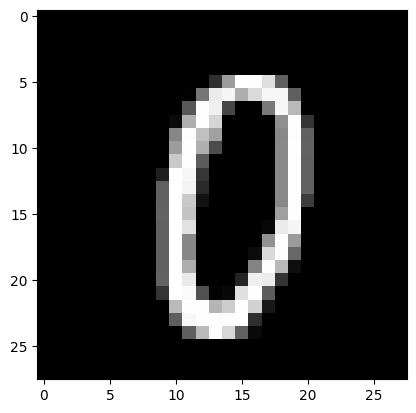

Prediction:  [8]
Label:  8


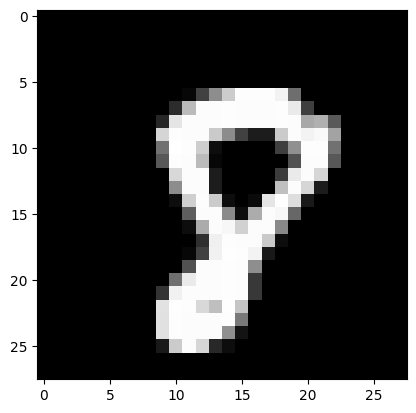

Prediction:  [5]
Label:  5


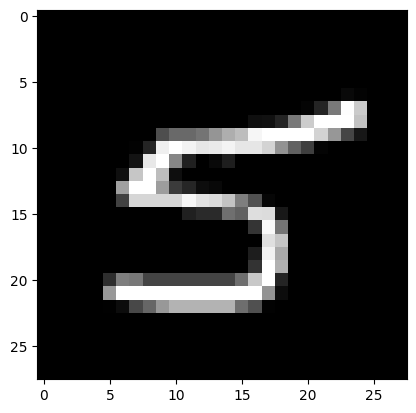

Prediction:  [1]
Label:  1


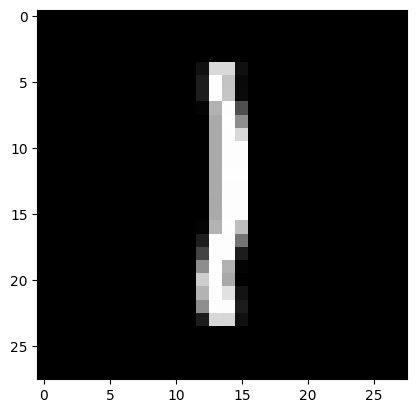

Prediction:  [3]
Label:  3


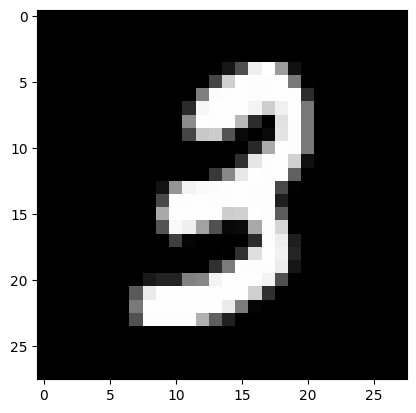

Prediction:  [7]
Label:  7


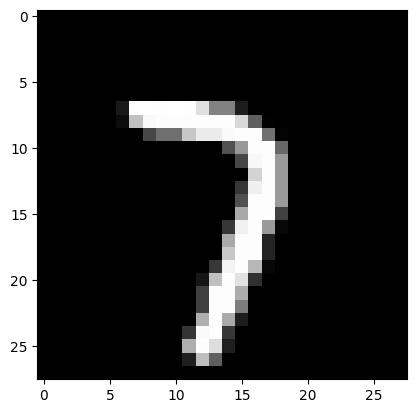

Prediction:  [1]
Label:  1


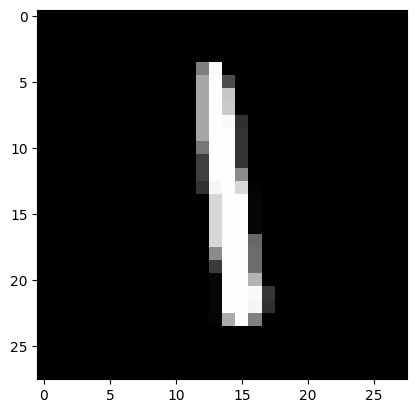

Prediction:  [6]
Label:  6


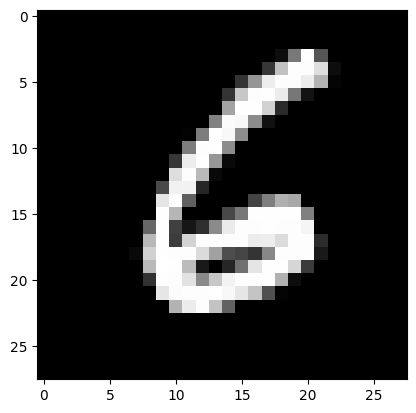

Prediction:  [4]
Label:  4


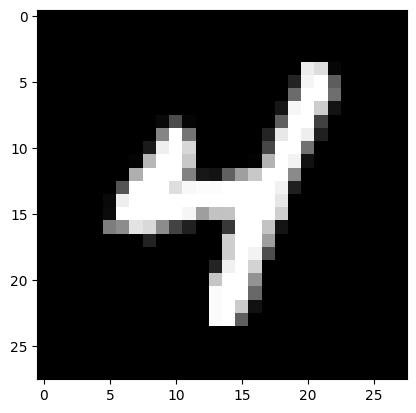

Prediction:  [2]
Label:  2


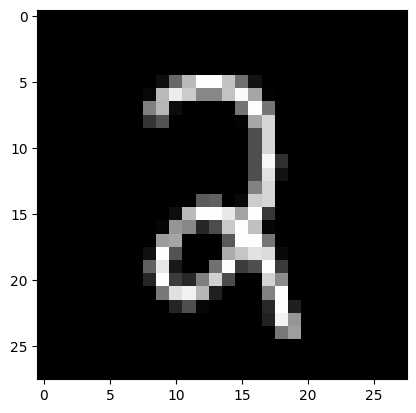

Prediction:  [1]
Label:  1


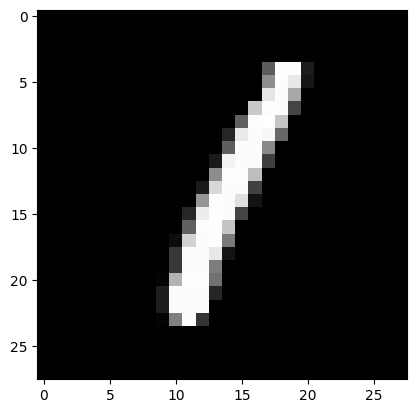

Prediction:  [0]
Label:  0


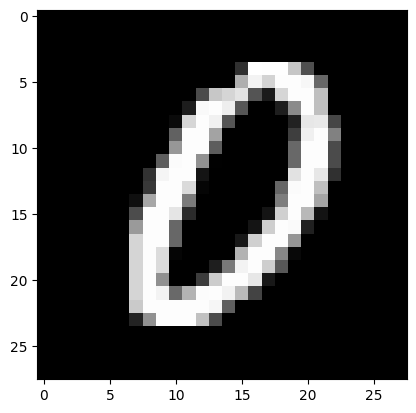

Prediction:  [6]
Label:  6


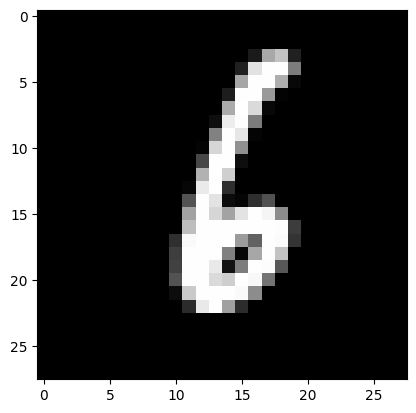

Prediction:  [7]
Label:  7


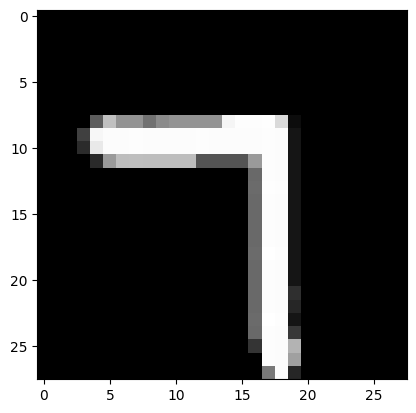

Prediction:  [0]
Label:  0


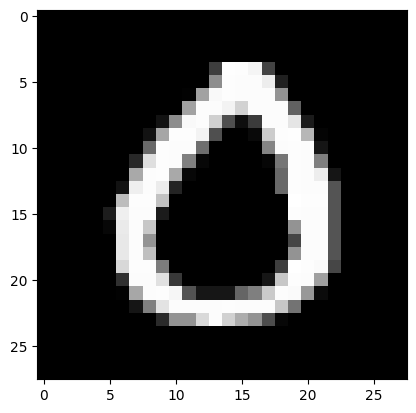

Prediction:  [8]
Label:  8


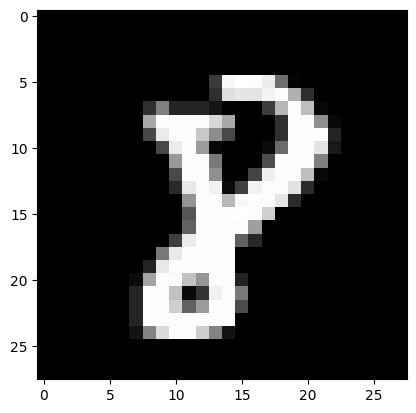

Prediction:  [4]
Label:  4


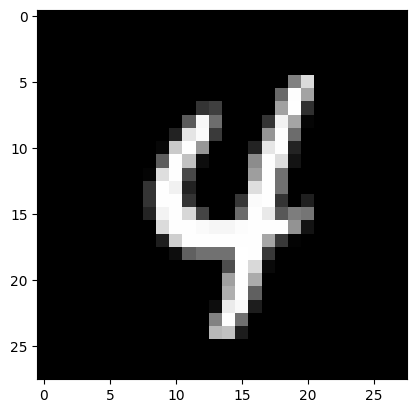

Prediction:  [0]
Label:  0


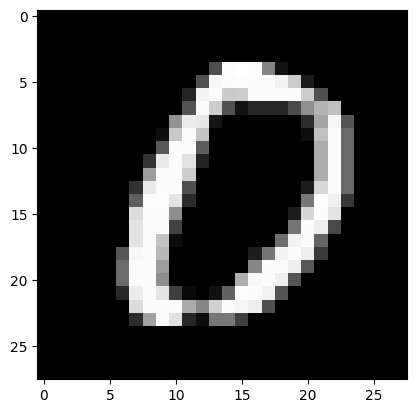

Prediction:  [1]
Label:  1


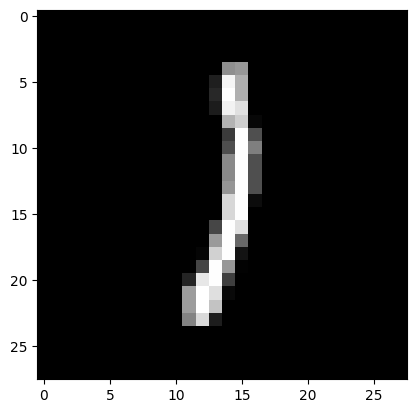

Prediction:  [2]
Label:  2


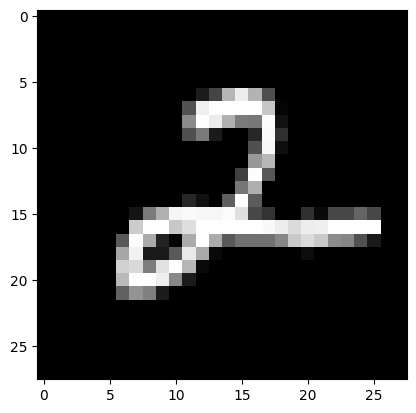

Prediction:  [8]
Label:  8


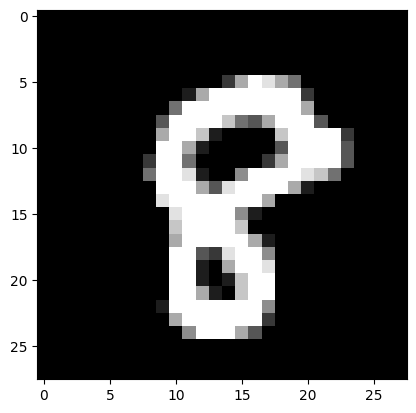

Prediction:  [2]
Label:  2


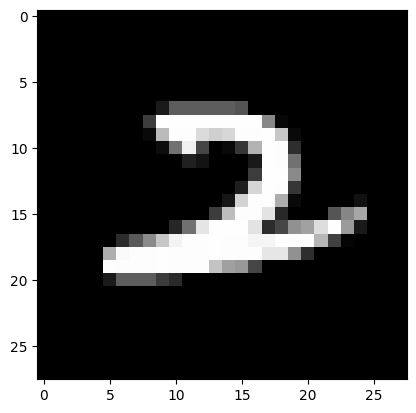

Prediction:  [1]
Label:  1


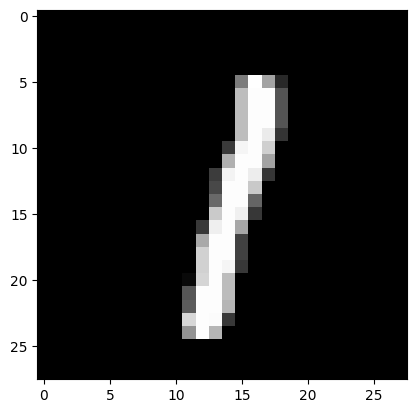

Prediction:  [2]
Label:  2


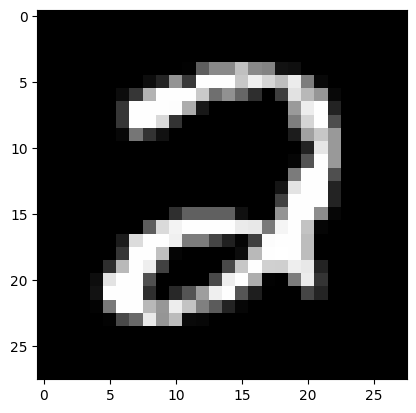

Prediction:  [7]
Label:  9


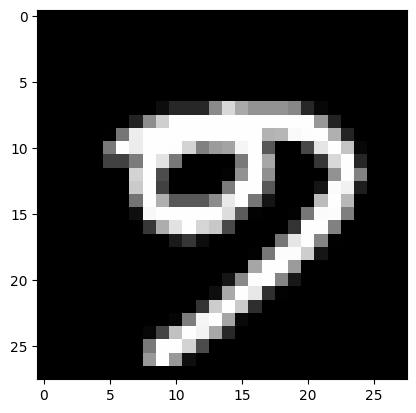

Prediction:  [9]
Label:  9


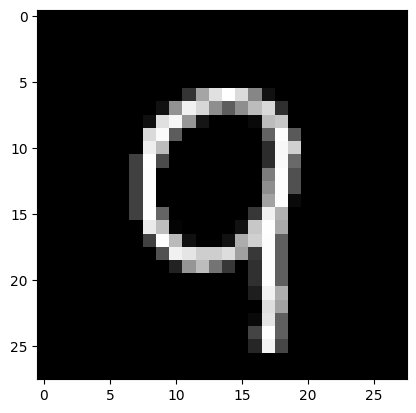

Prediction:  [9]
Label:  9


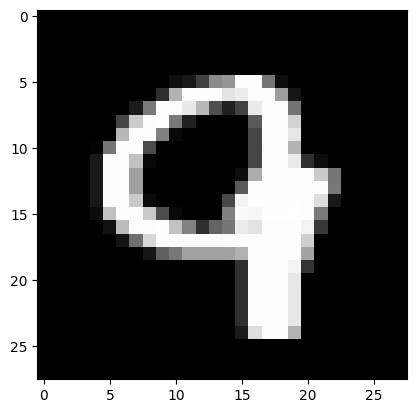

Prediction:  [4]
Label:  4


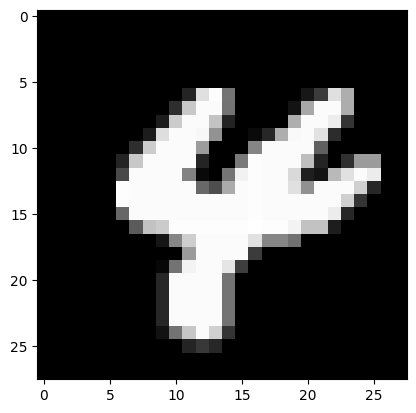

Prediction:  [6]
Label:  6


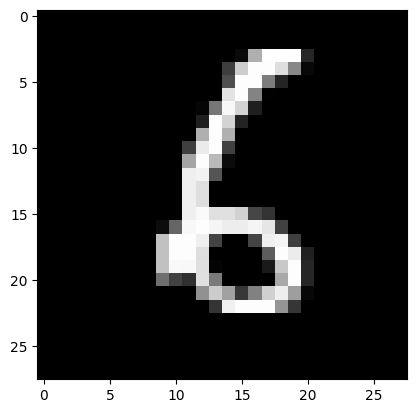

Prediction:  [3]
Label:  3


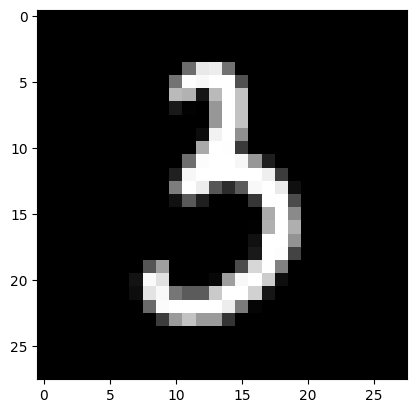

Prediction:  [4]
Label:  4


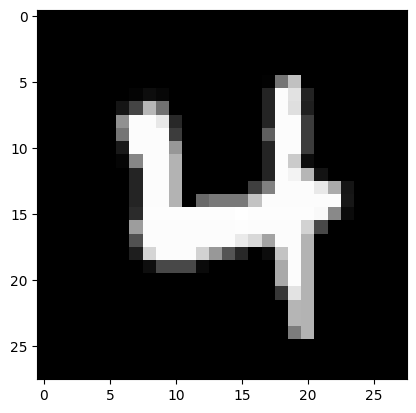

Prediction:  [1]
Label:  1


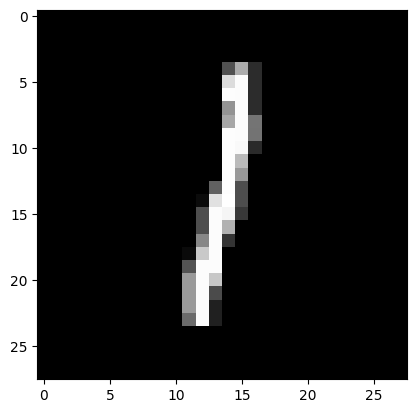

Prediction:  [3]
Label:  3


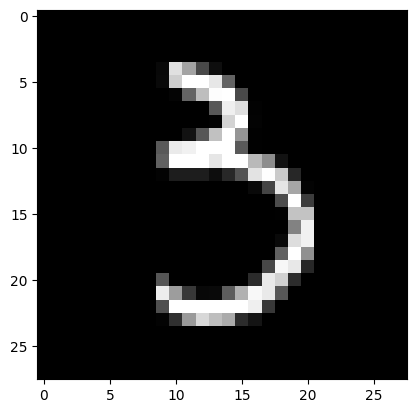

Prediction:  [0]
Label:  0


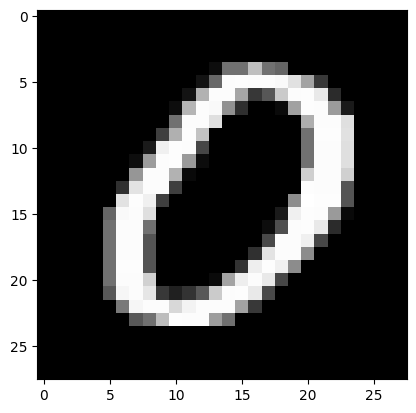

Prediction:  [6]
Label:  6


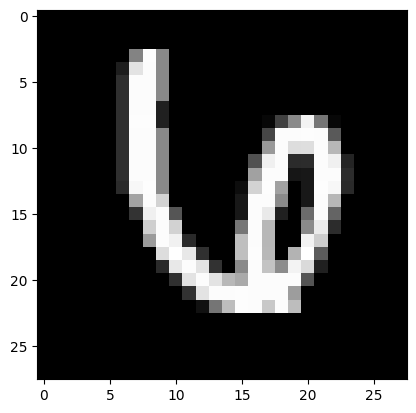

Prediction:  [4]
Label:  4


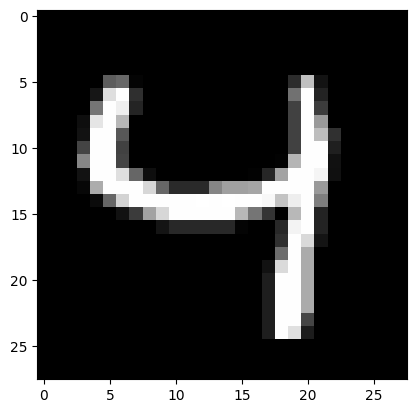

Prediction:  [8]
Label:  3


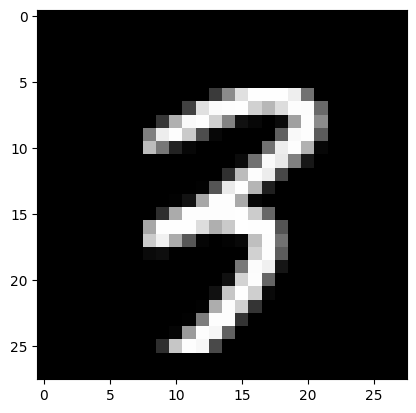

Prediction:  [2]
Label:  2


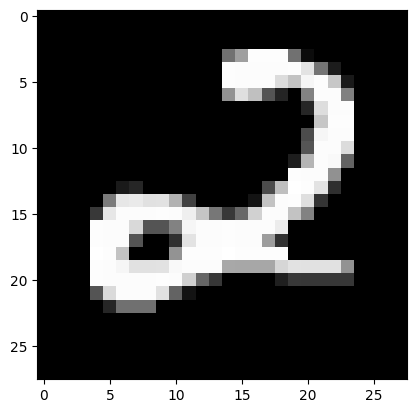

Prediction:  [1]
Label:  1


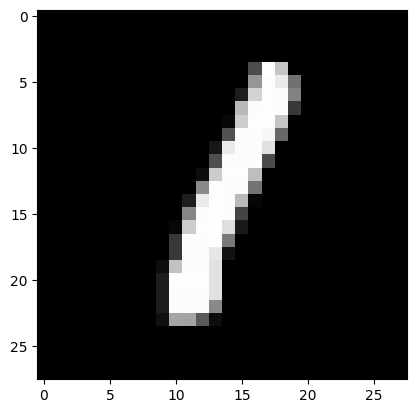

Prediction:  [5]
Label:  5


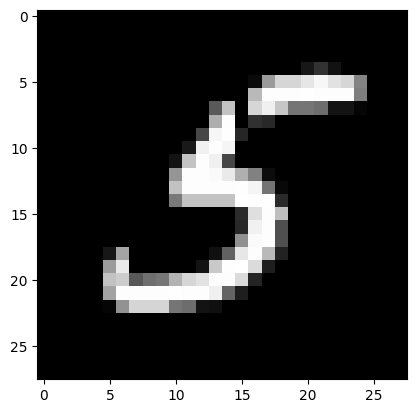

Prediction:  [8]
Label:  8


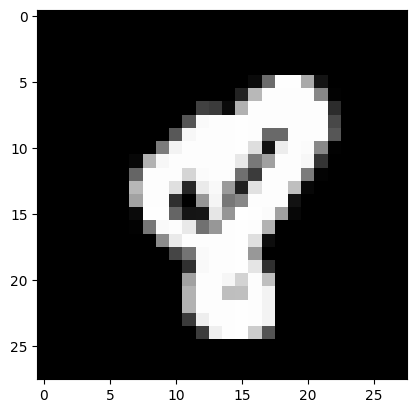

Prediction:  [7]
Label:  7


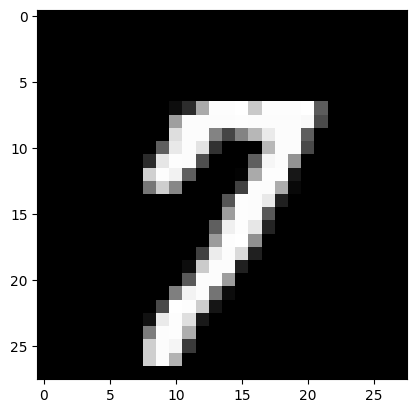

Prediction:  [7]
Label:  7


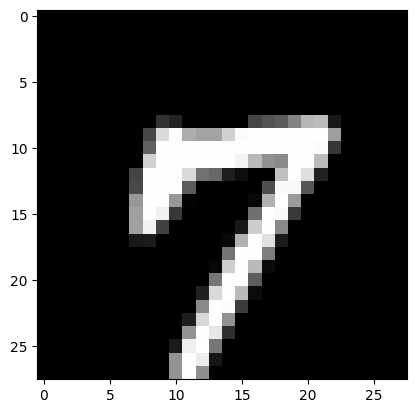

Prediction:  [1]
Label:  1


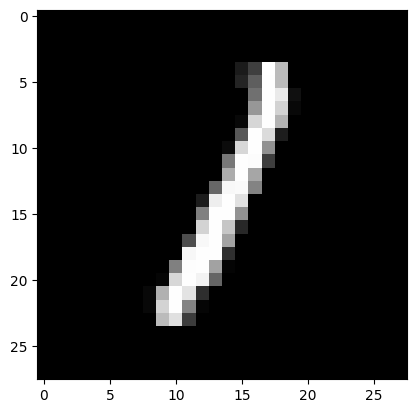

Prediction:  [3]
Label:  3


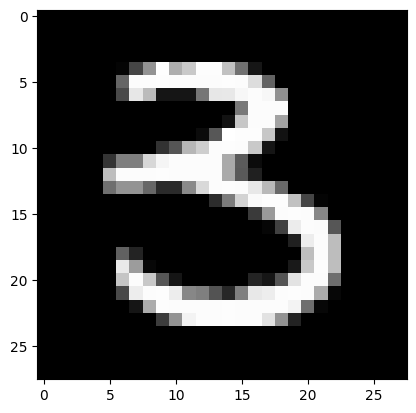

Prediction:  [8]
Label:  8


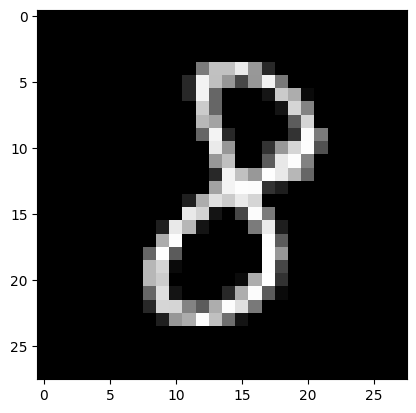

Prediction:  [4]
Label:  4


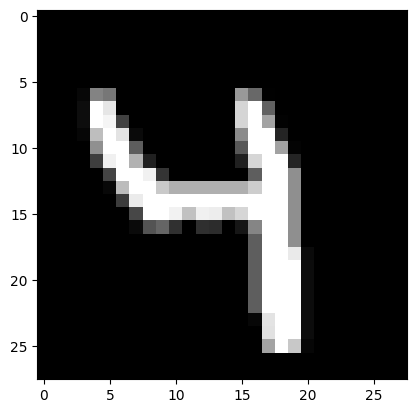

Prediction:  [6]
Label:  6


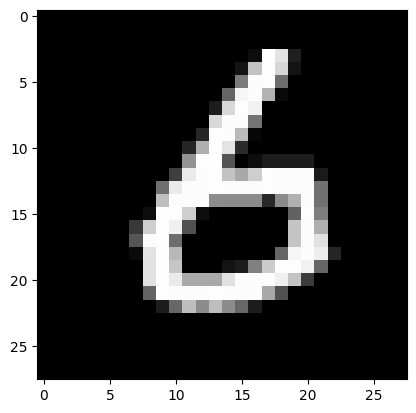

Prediction:  [0]
Label:  0


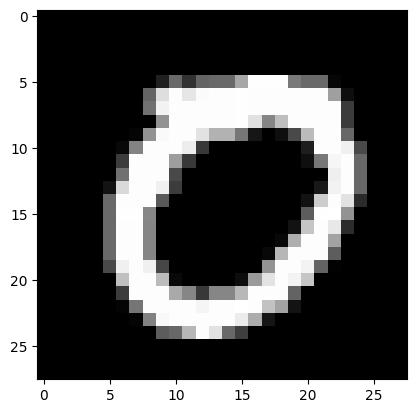

Prediction:  [5]
Label:  5


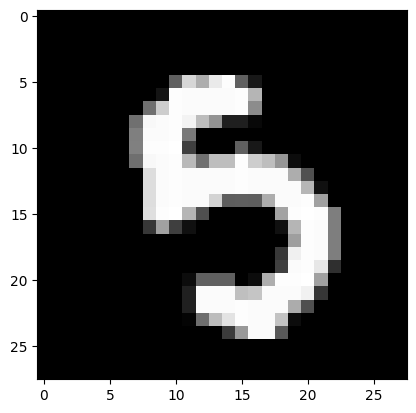

Prediction:  [4]
Label:  4


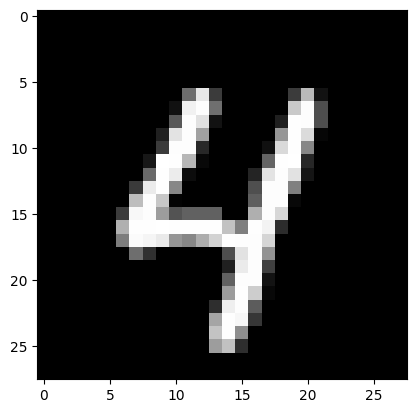

Prediction:  [1]
Label:  1


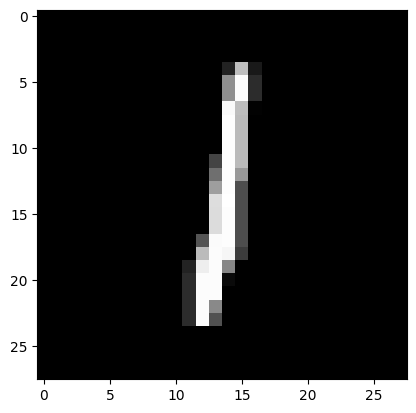

Prediction:  [9]
Label:  9


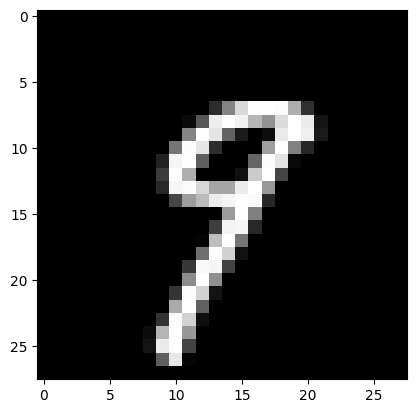

Prediction:  [2]
Label:  2


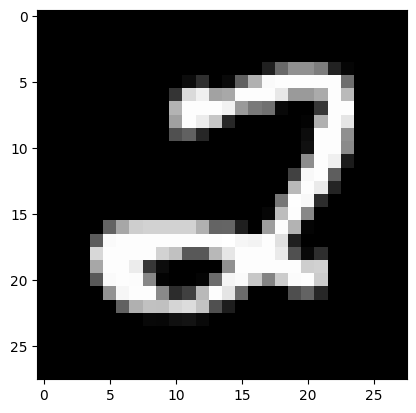

Prediction:  [1]
Label:  1


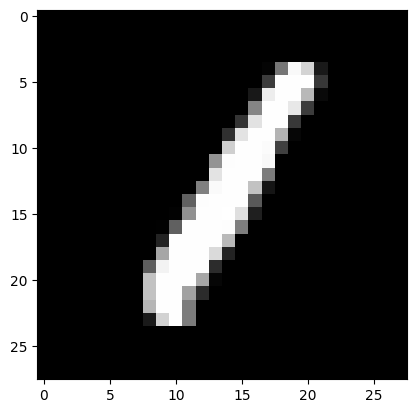

Prediction:  [2]
Label:  2


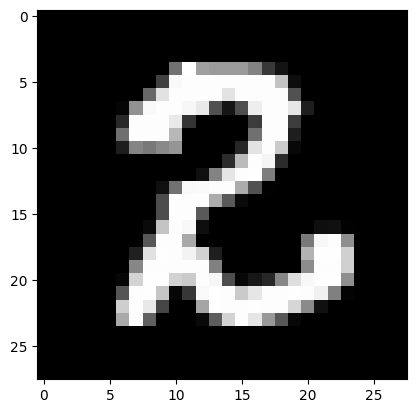

Prediction:  [2]
Label:  2


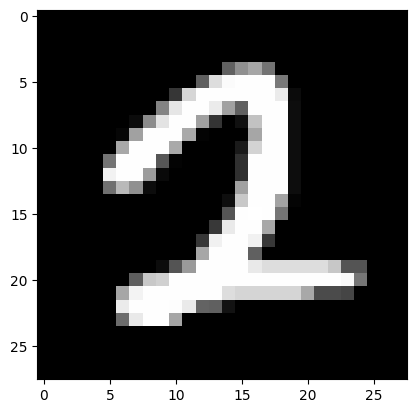

Prediction:  [8]
Label:  8


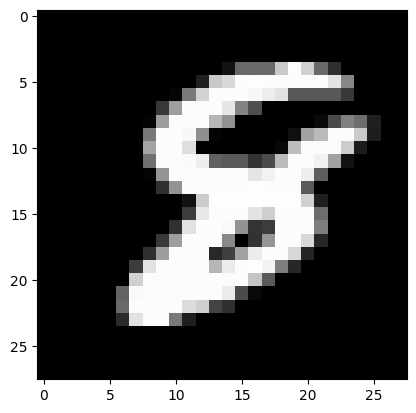

Prediction:  [2]
Label:  2


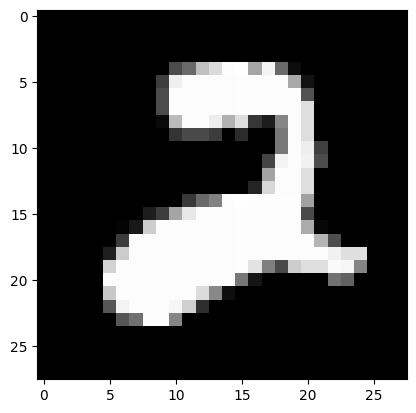

Prediction:  [6]
Label:  6


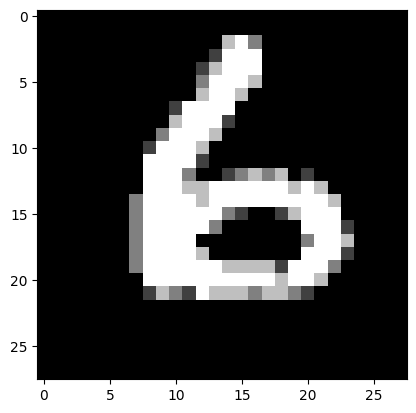

Prediction:  [0]
Label:  0


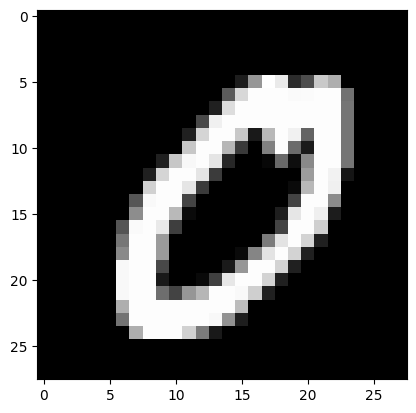

Prediction:  [3]
Label:  3


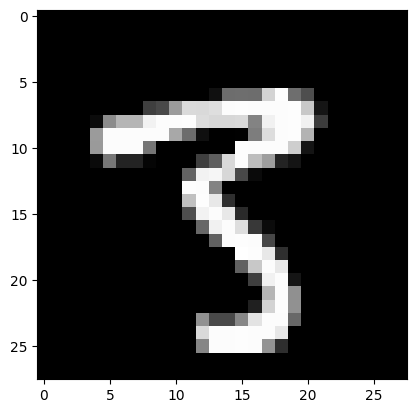

Prediction:  [8]
Label:  8


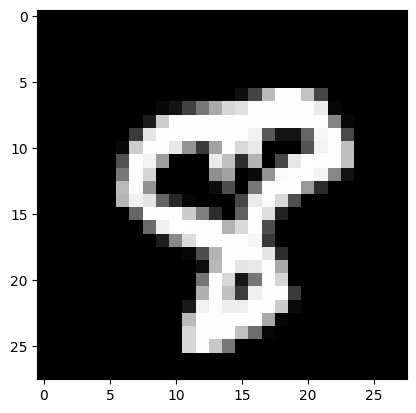

Prediction:  [5]
Label:  5


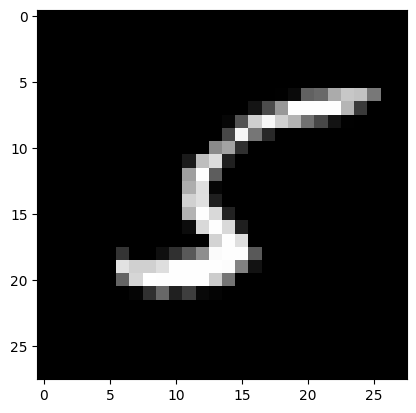

Prediction:  [8]
Label:  8


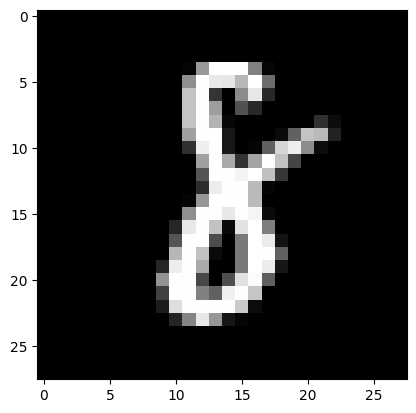

Prediction:  [5]
Label:  5


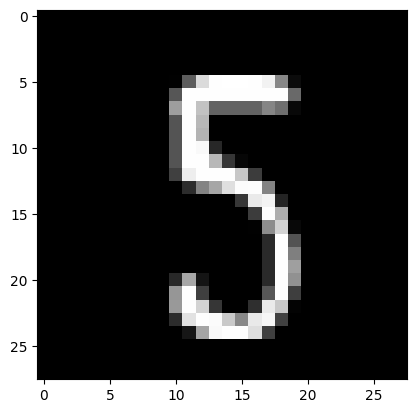

Prediction:  [5]
Label:  5


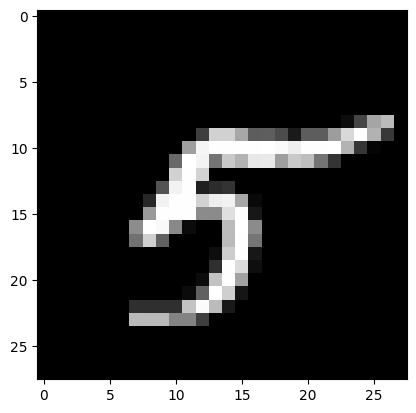

Prediction:  [7]
Label:  7


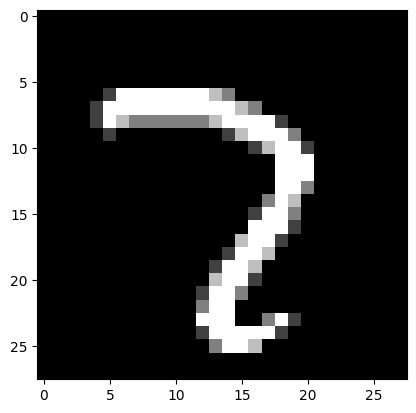

Prediction:  [7]
Label:  7


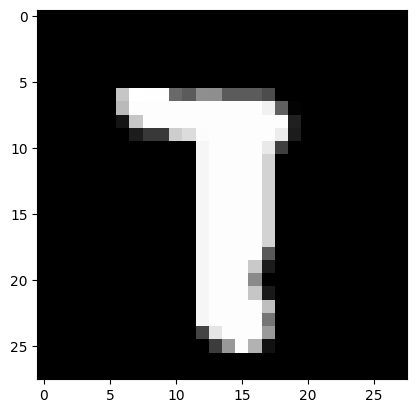

Prediction:  [6]
Label:  6


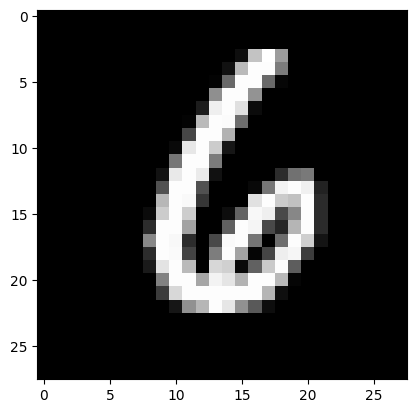

Prediction:  [1]
Label:  1


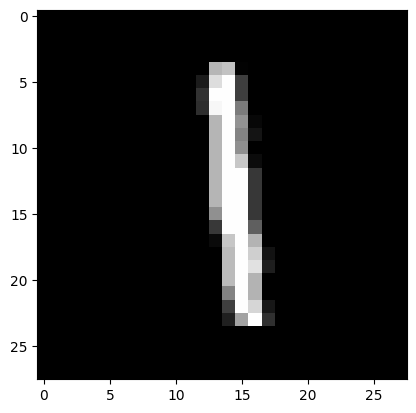

Prediction:  [3]
Label:  3


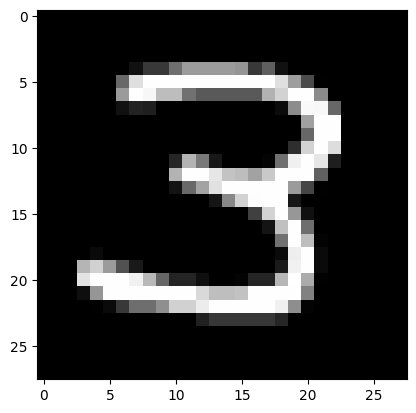

Prediction:  [0]
Label:  0


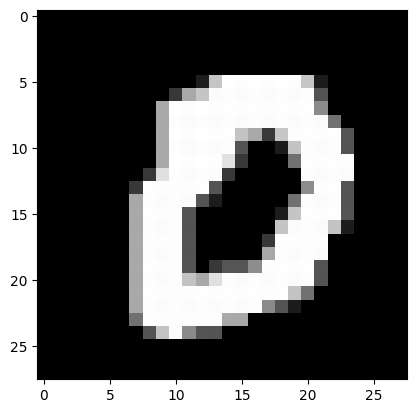

Prediction:  [7]
Label:  7


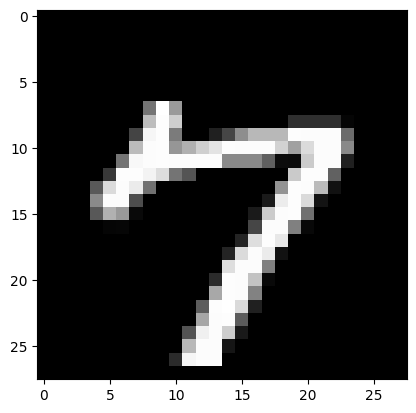

Prediction:  [8]
Label:  8


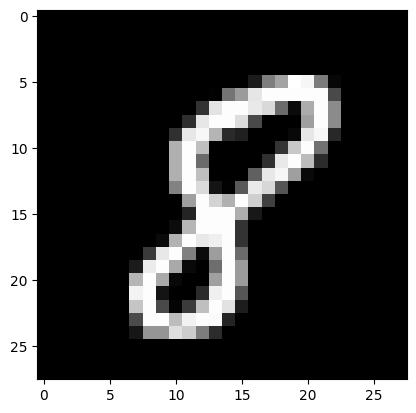

Prediction:  [7]
Label:  7


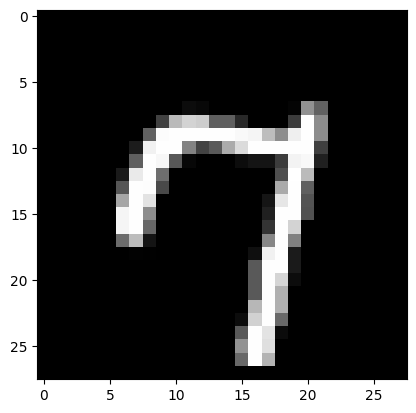

Prediction:  [1]
Label:  1


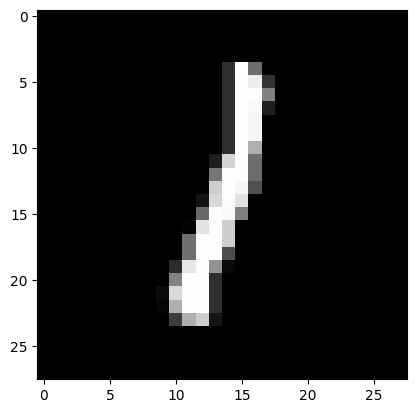

Prediction:  [4]
Label:  4


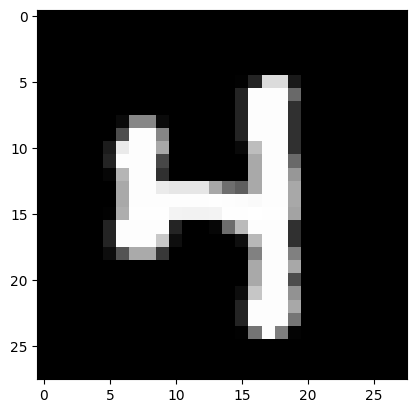

Prediction:  [3]
Label:  3


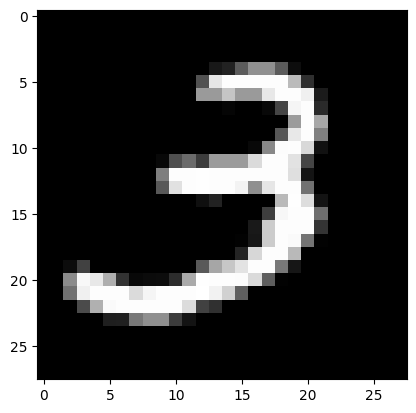

Prediction:  [3]
Label:  3


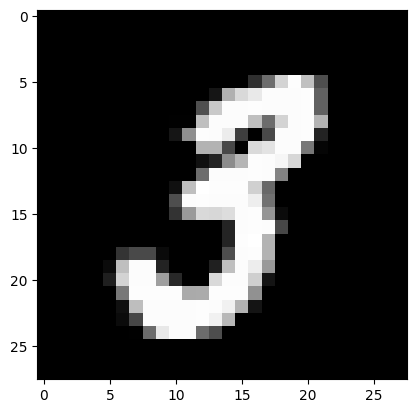

Prediction:  [8]
Label:  8


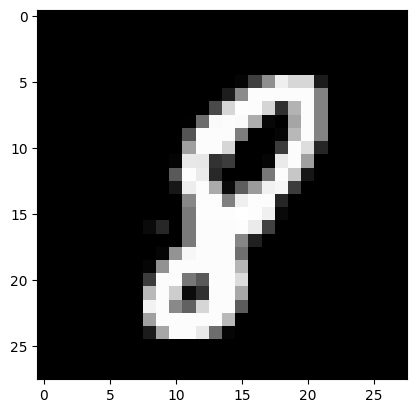

Prediction:  [2]
Label:  2


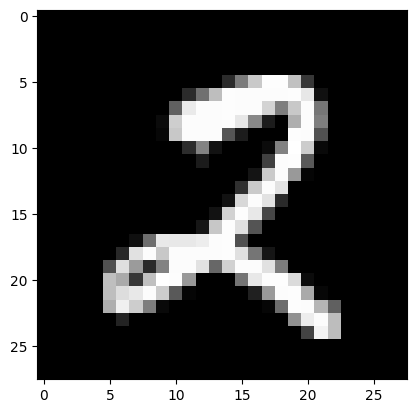

Prediction:  [6]
Label:  6


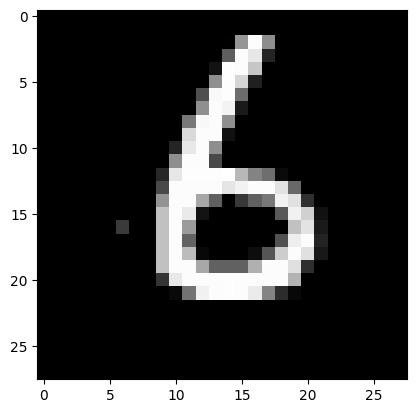

Prediction:  [3]
Label:  3


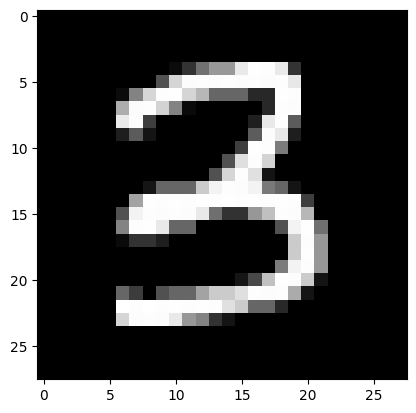

Prediction:  [5]
Label:  5


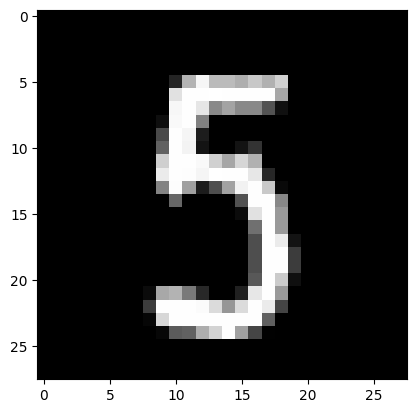

Prediction:  [6]
Label:  6


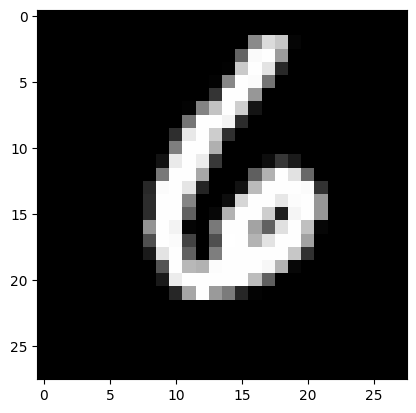

Prediction:  [3]
Label:  3


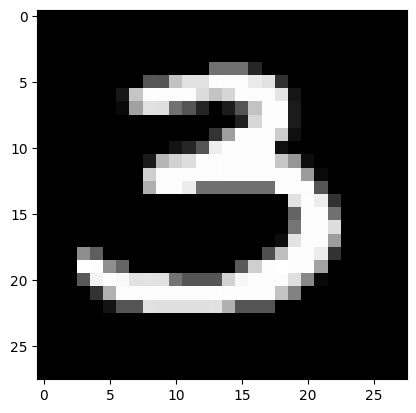

Prediction:  [9]
Label:  9


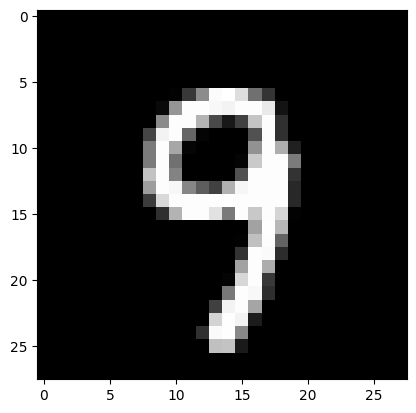

Prediction:  [4]
Label:  4


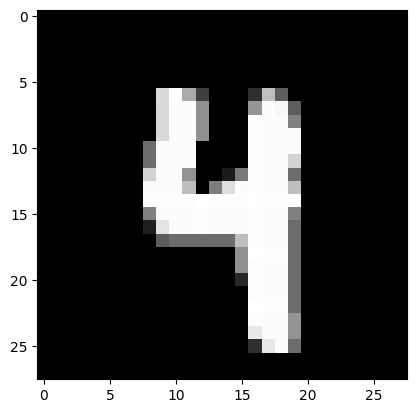

Prediction:  [2]
Label:  2


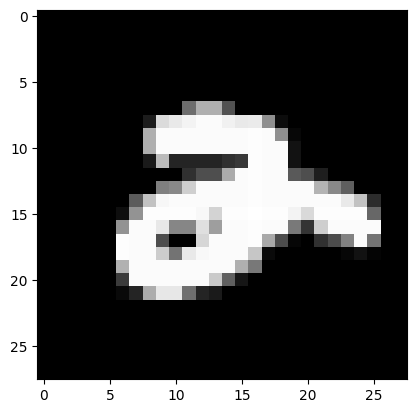

Prediction:  [6]
Label:  6


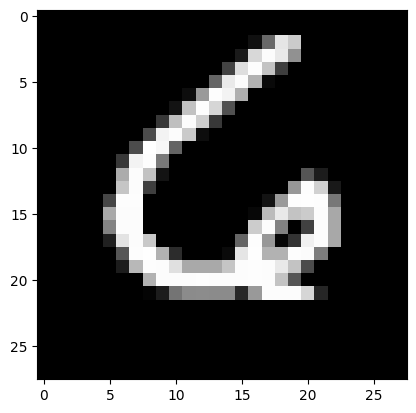

Prediction:  [2]
Label:  2


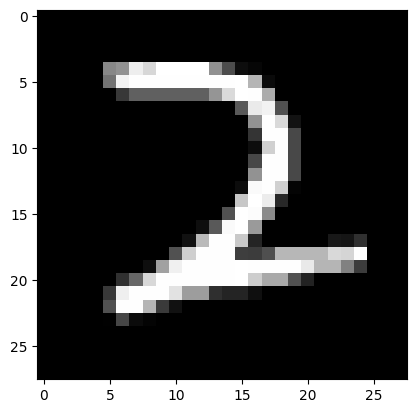

Prediction:  [8]
Label:  8


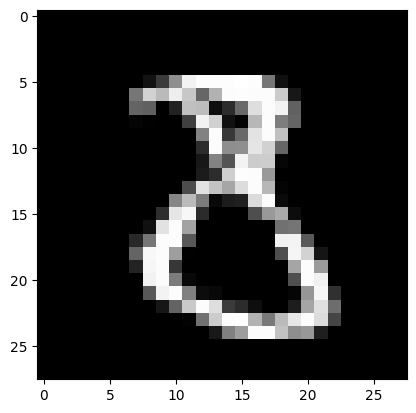

Prediction:  [5]
Label:  5


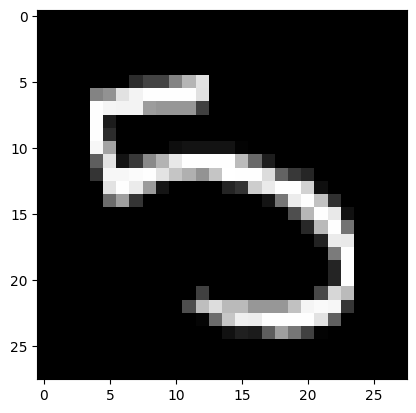

Prediction:  [8]
Label:  8


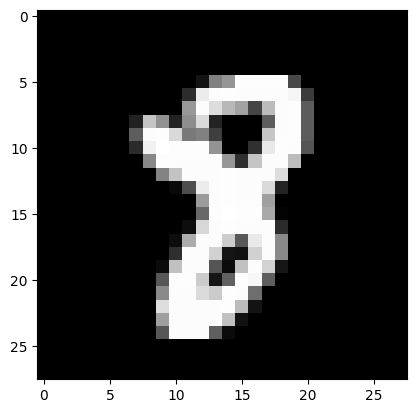

Prediction:  [3]
Label:  3


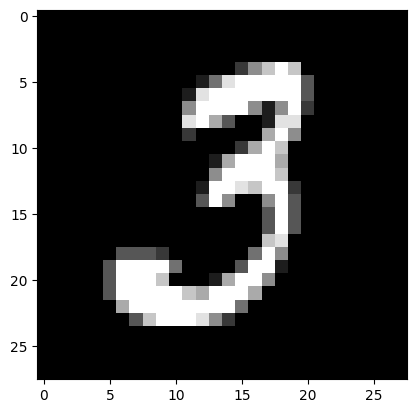

Prediction:  [7]
Label:  7


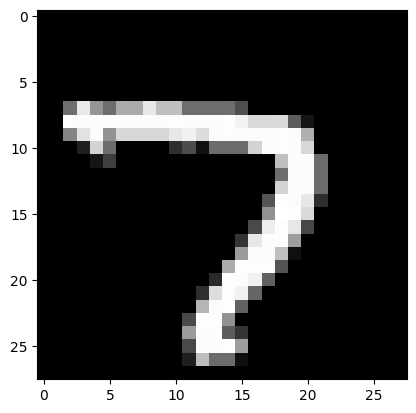

Prediction:  [7]
Label:  7


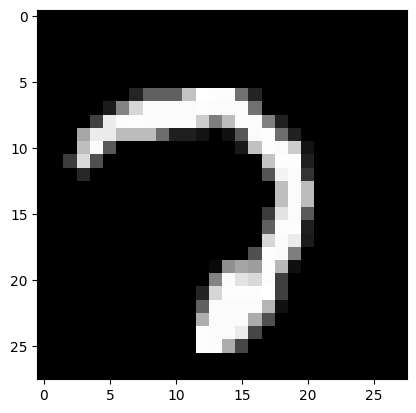

Prediction:  [3]
Label:  3


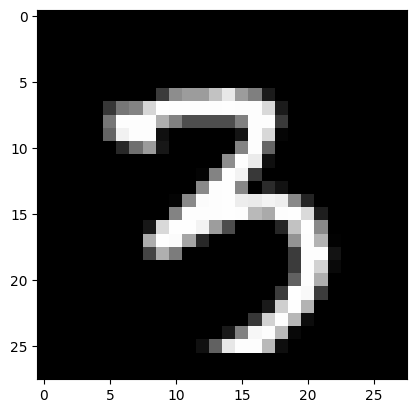

Prediction:  [9]
Label:  9


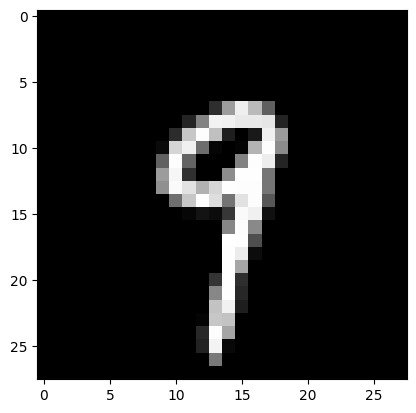

Prediction:  [3]
Label:  3


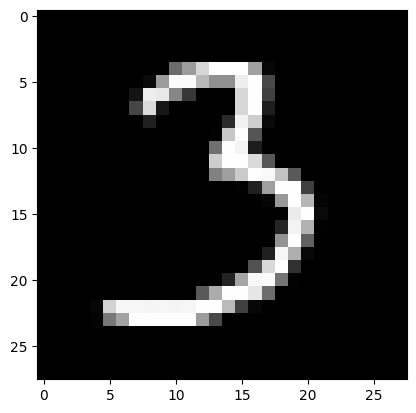

Prediction:  [6]
Label:  6


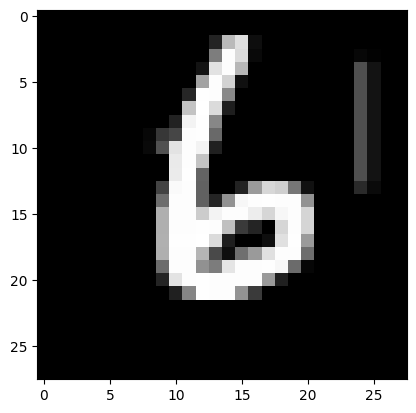

Prediction:  [2]
Label:  2


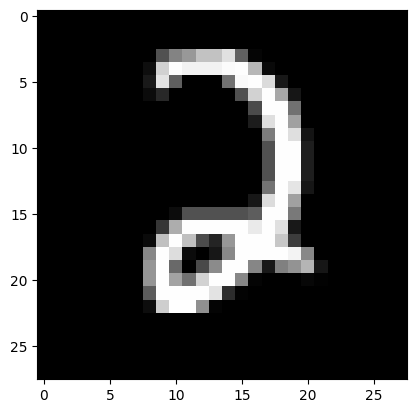

Prediction:  [4]
Label:  4


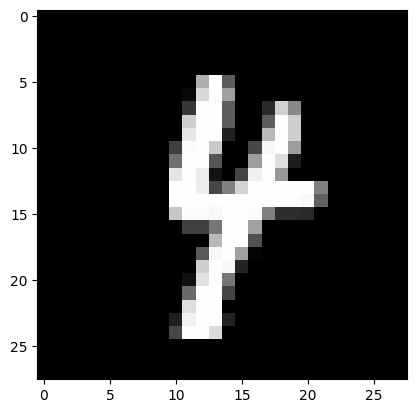

Prediction:  [1]
Label:  1


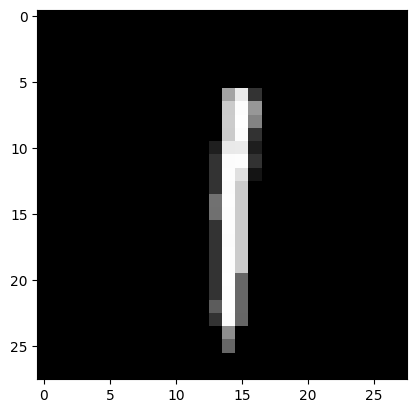

Prediction:  [3]
Label:  3


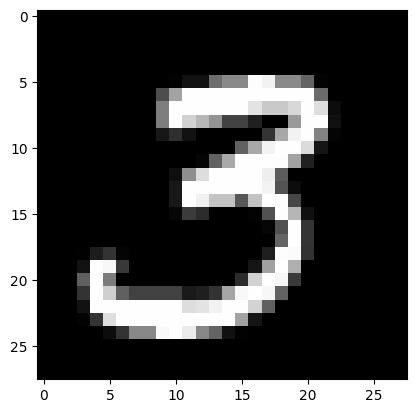

Prediction:  [6]
Label:  6


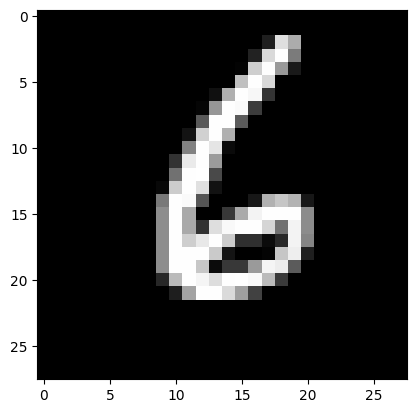

Prediction:  [4]
Label:  4


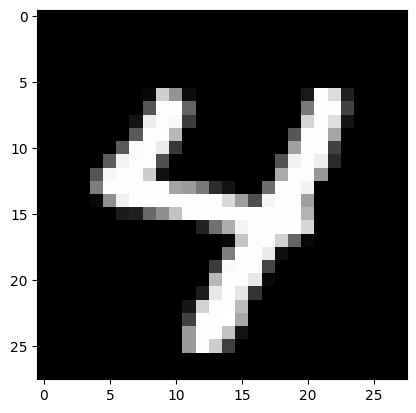

Prediction:  [4]
Label:  4


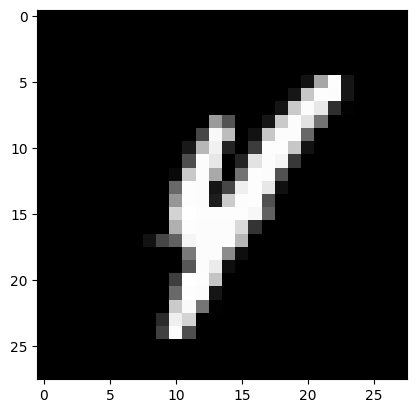

Prediction:  [4]
Label:  4


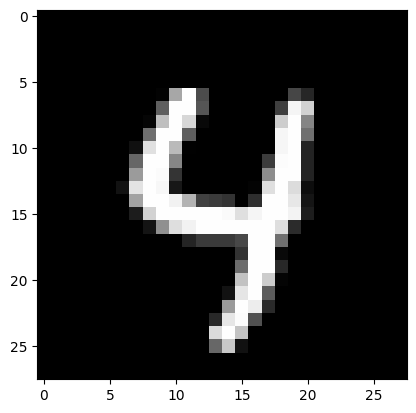

Prediction:  [6]
Label:  6


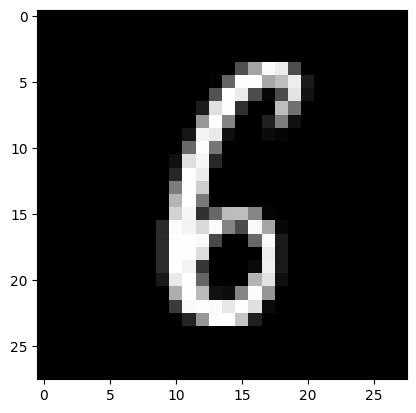

Prediction:  [0]
Label:  0


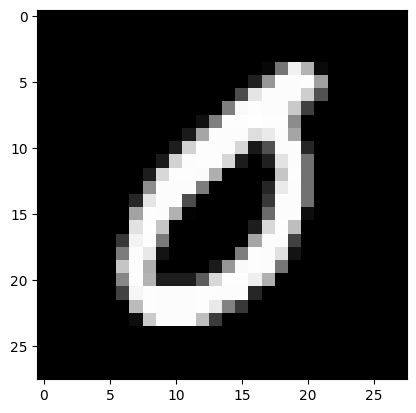

Prediction:  [8]
Label:  8


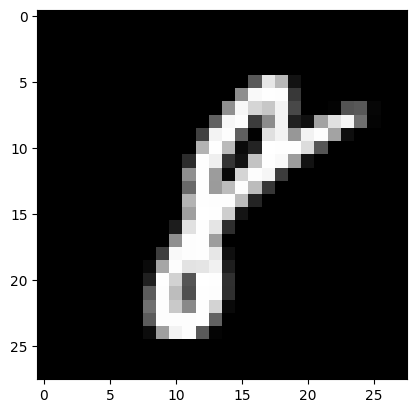

Prediction:  [5]
Label:  5


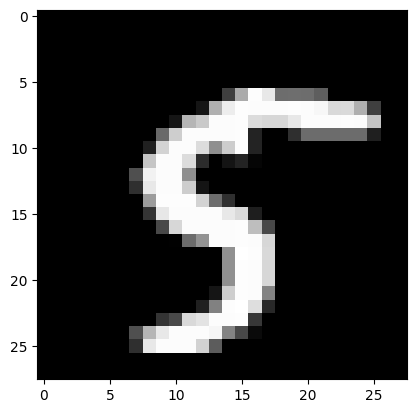

Prediction:  [6]
Label:  6


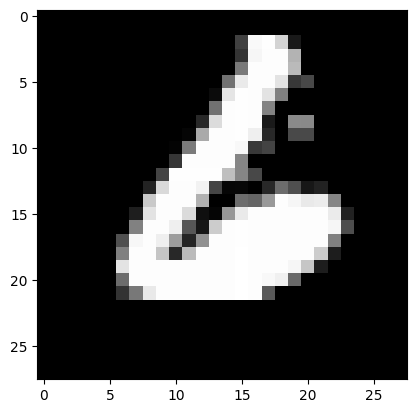

Prediction:  [0]
Label:  0


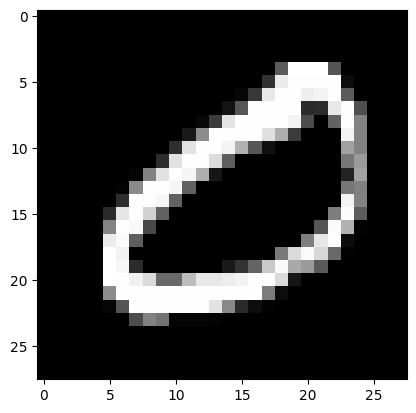

Prediction:  [3]
Label:  3


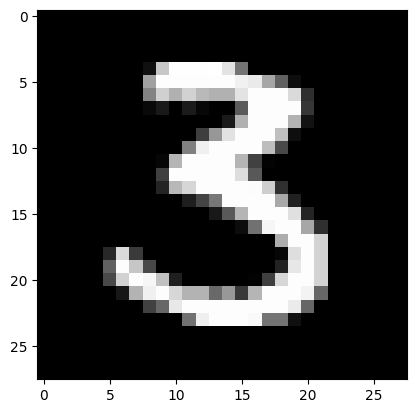

Prediction:  [6]
Label:  6


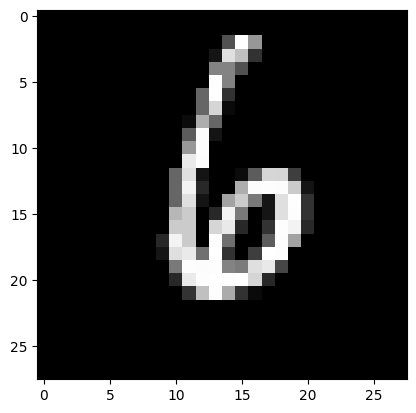

Prediction:  [7]
Label:  7


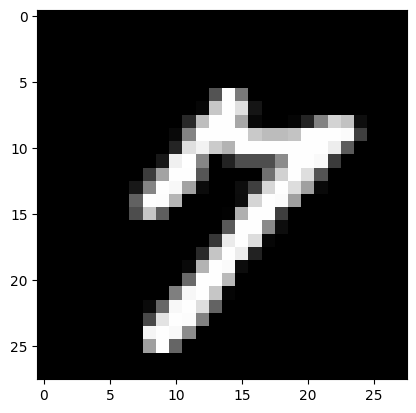

Prediction:  [7]
Label:  7


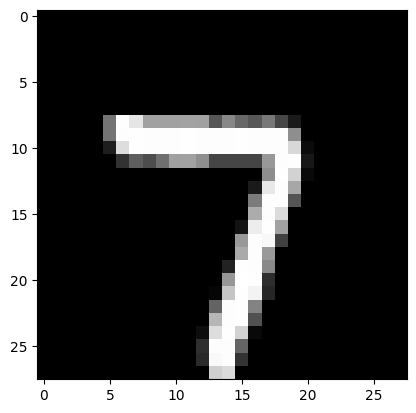

Prediction:  [1]
Label:  1


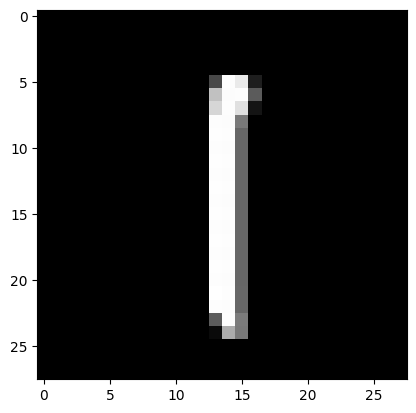

Prediction:  [6]
Label:  6


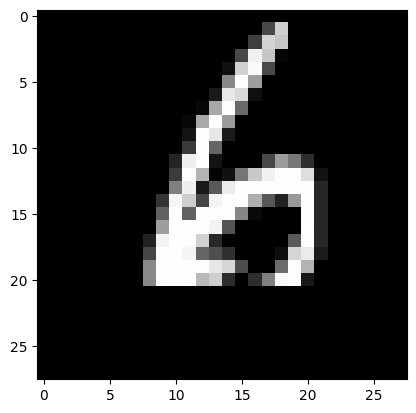

Prediction:  [3]
Label:  3


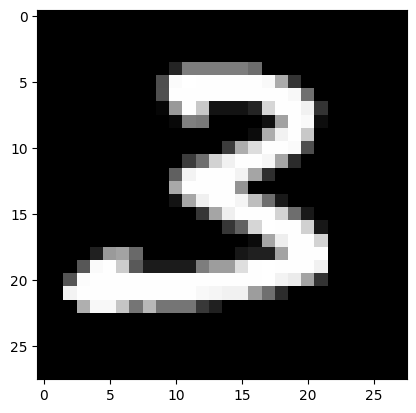

Prediction:  [5]
Label:  5


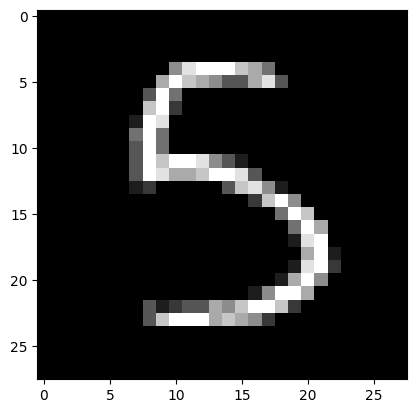

Prediction:  [3]
Label:  3


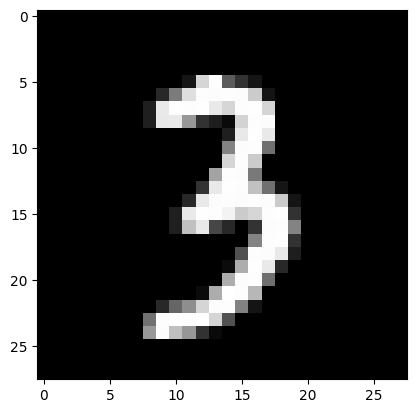

Prediction:  [3]
Label:  3


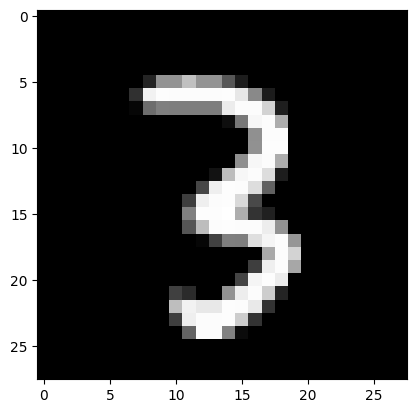

Prediction:  [2]
Label:  2


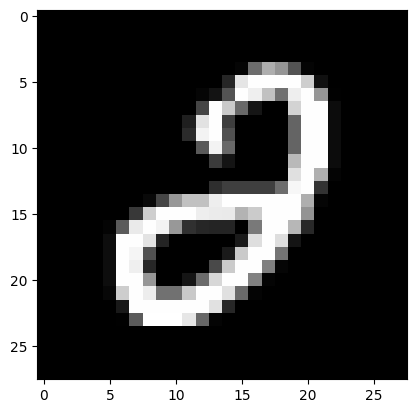

Prediction:  [6]
Label:  6


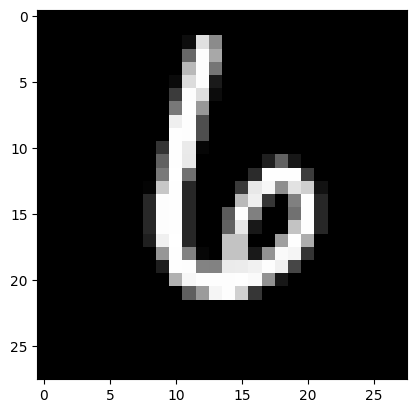

Prediction:  [7]
Label:  7


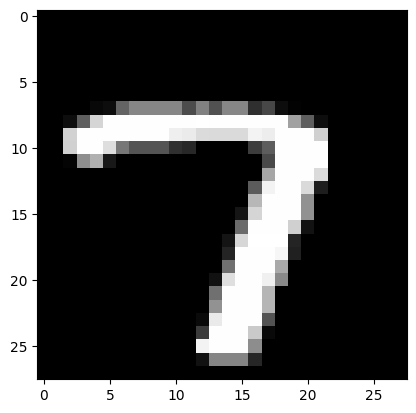

Prediction:  [9]
Label:  3


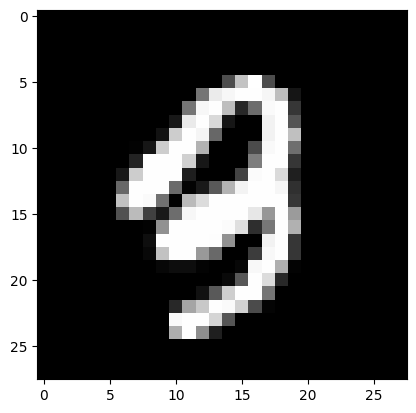

Prediction:  [7]
Label:  7


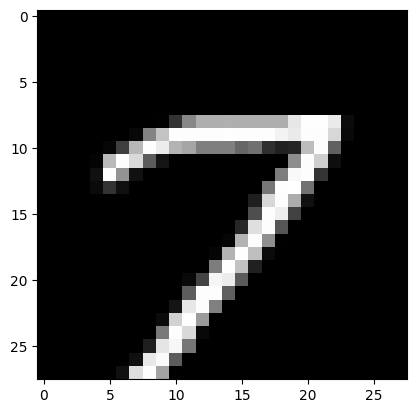

Prediction:  [4]
Label:  4


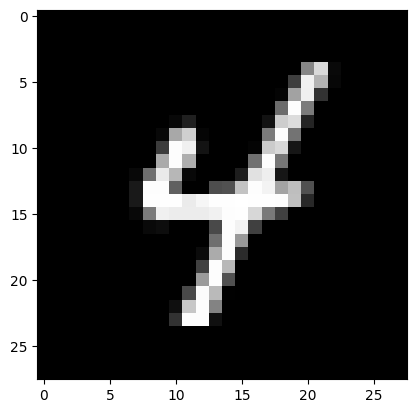

Prediction:  [3]
Label:  3


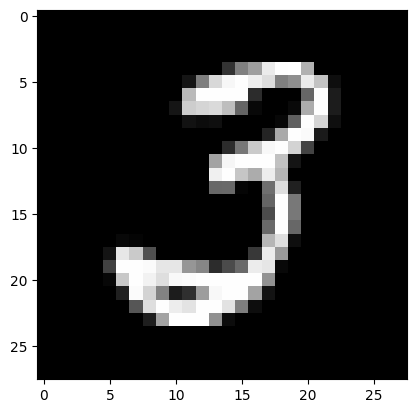

Prediction:  [4]
Label:  4


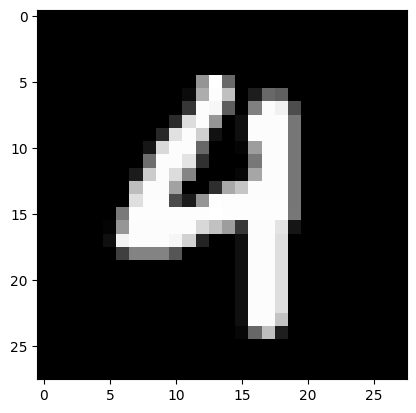

Prediction:  [3]
Label:  3


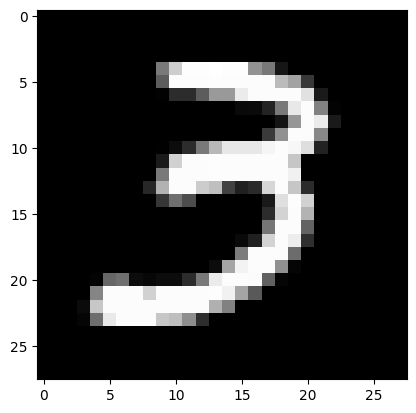

Prediction:  [2]
Label:  2


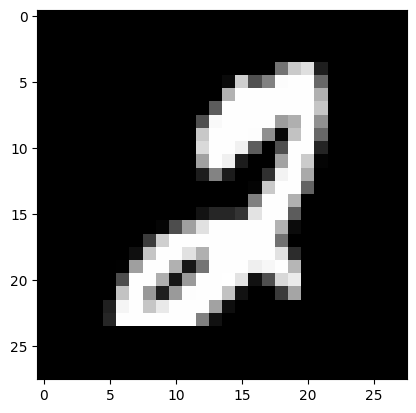

Prediction:  [6]
Label:  6


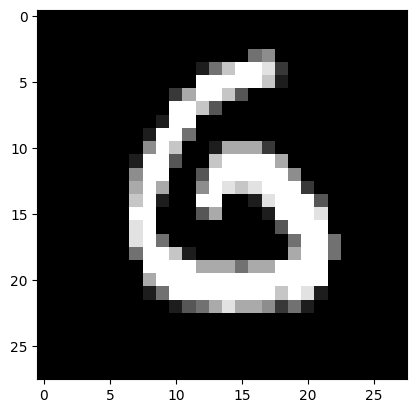

Prediction:  [2]
Label:  2


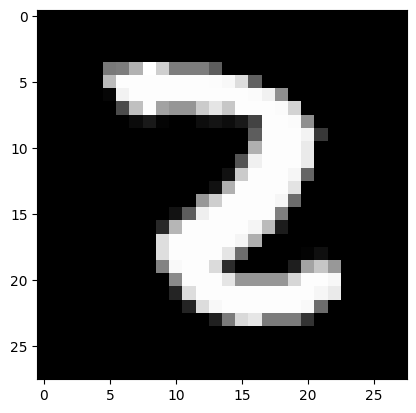

Prediction:  [6]
Label:  6


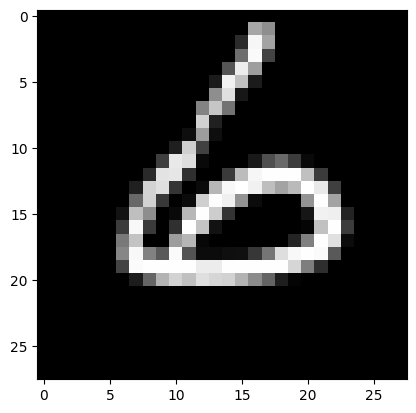

Prediction:  [2]
Label:  2


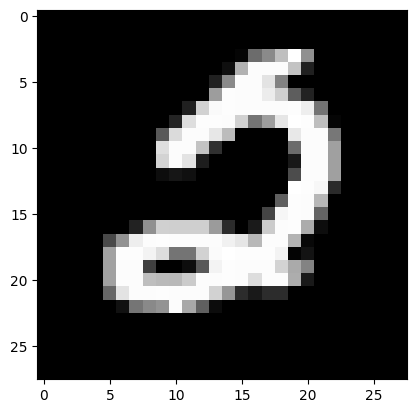

Prediction:  [2]
Label:  8


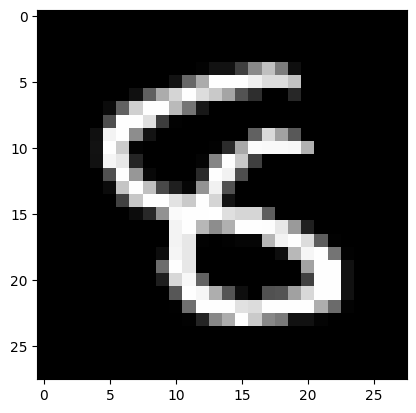

Prediction:  [4]
Label:  4


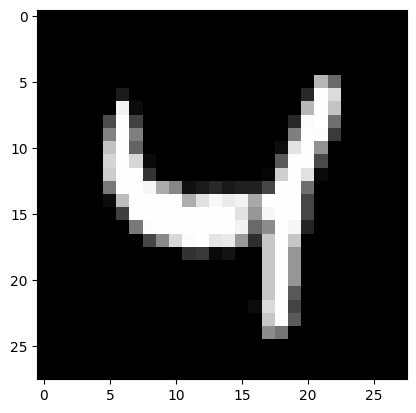

Prediction:  [7]
Label:  7


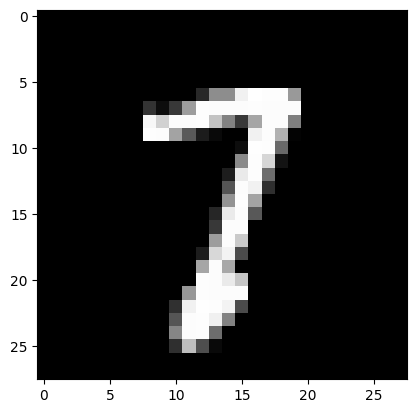

Prediction:  [2]
Label:  2


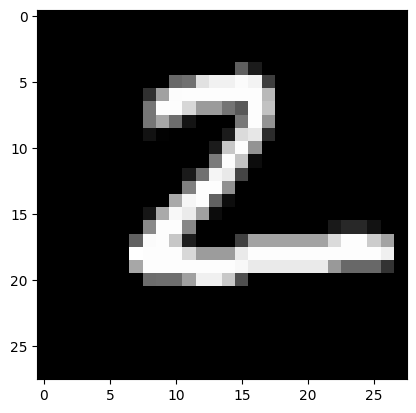

Prediction:  [5]
Label:  5


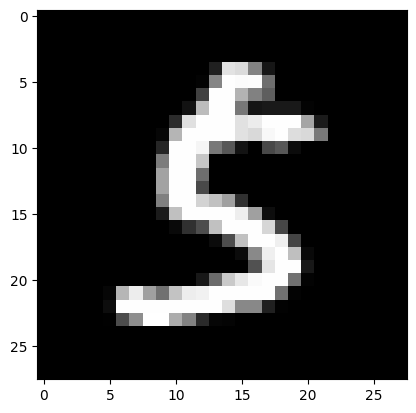

Prediction:  [8]
Label:  8


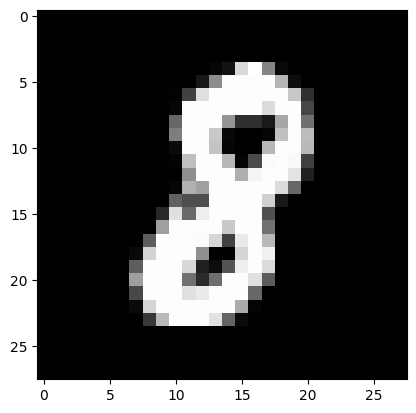

Prediction:  [6]
Label:  6


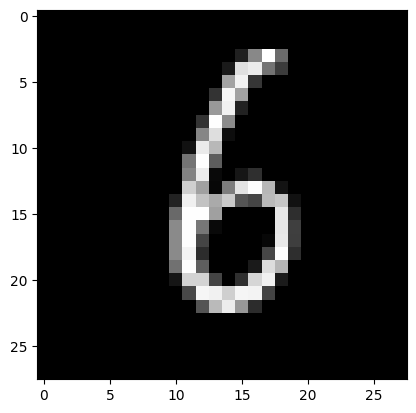

Prediction:  [3]
Label:  3


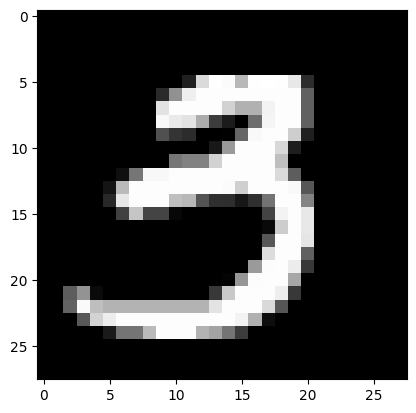

Prediction:  [7]
Label:  7


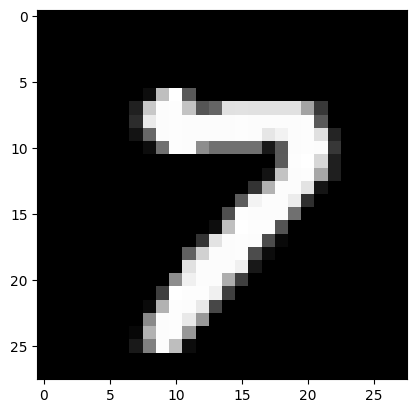

Prediction:  [2]
Label:  2


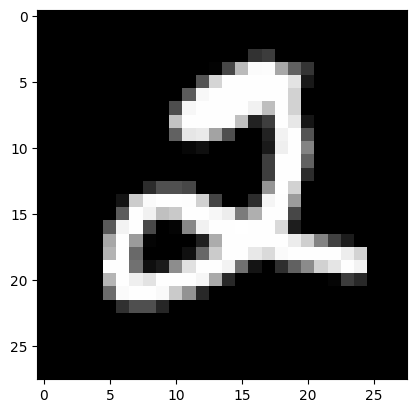

Prediction:  [5]
Label:  5


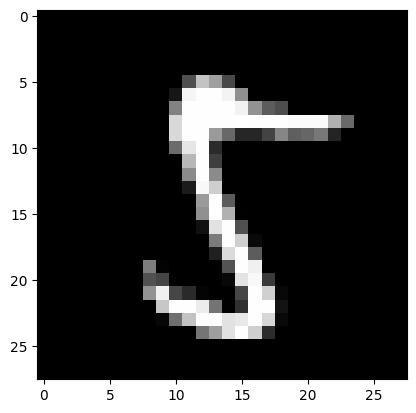

Prediction:  [6]
Label:  6


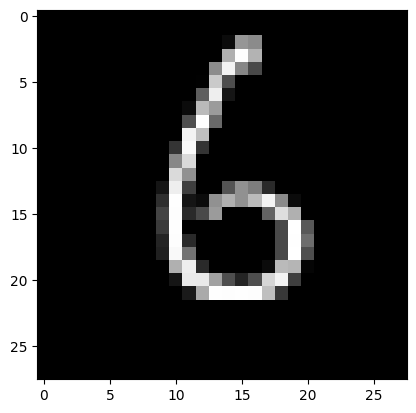

Prediction:  [5]
Label:  5


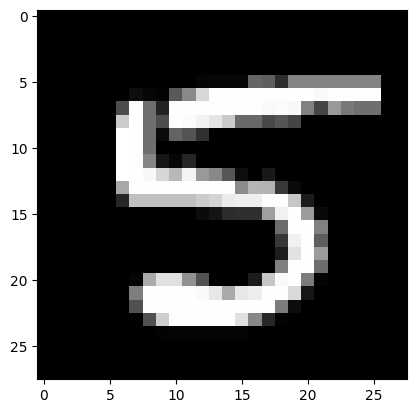

Prediction:  [1]
Label:  1


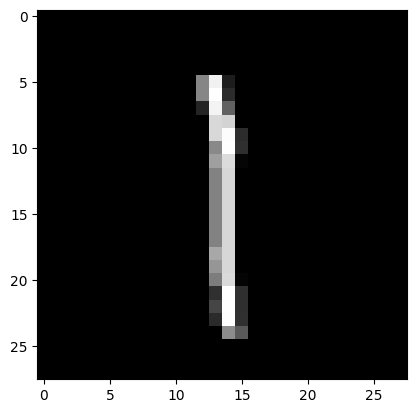

Prediction:  [2]
Label:  2


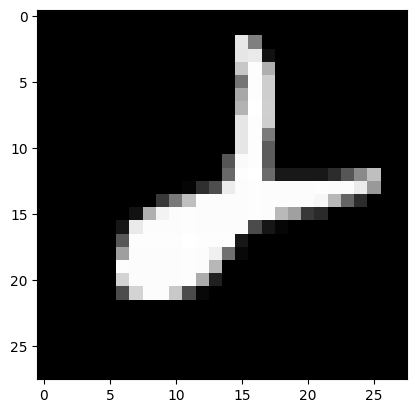

Prediction:  [8]
Label:  8


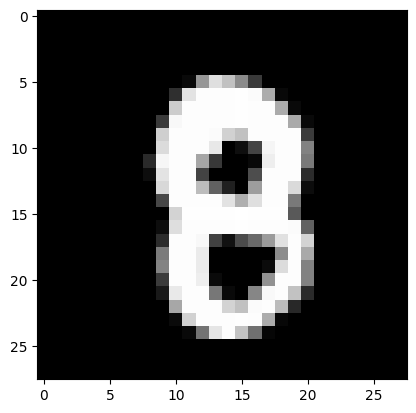

Prediction:  [9]
Label:  9


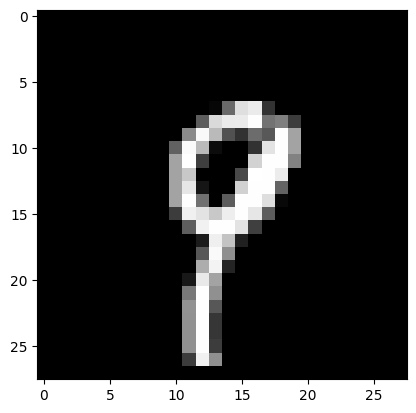

Prediction:  [1]
Label:  1


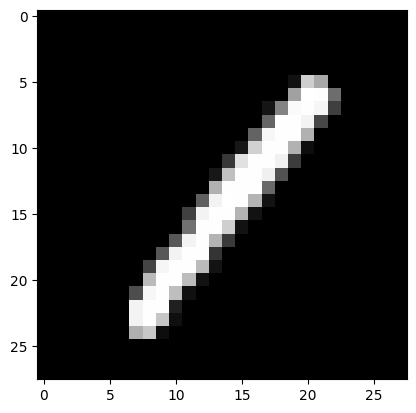

Prediction:  [5]
Label:  5


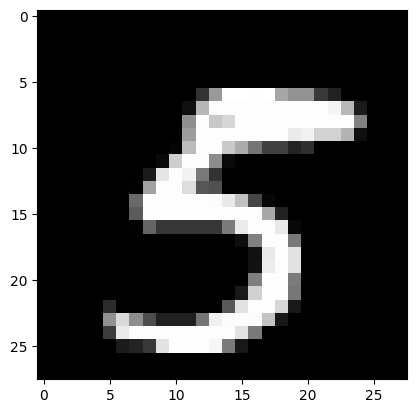

Prediction:  [2]
Label:  2


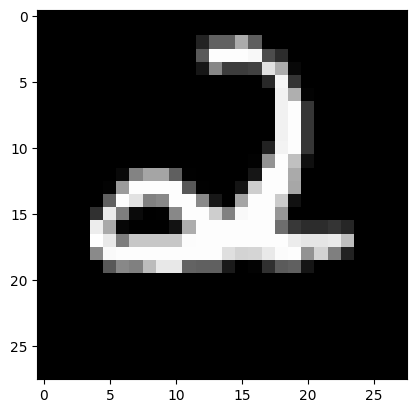

Prediction:  [6]
Label:  6


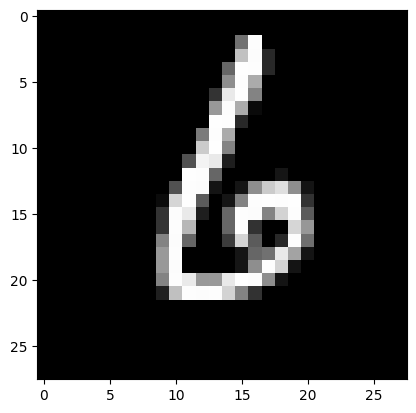

Prediction:  [3]
Label:  3


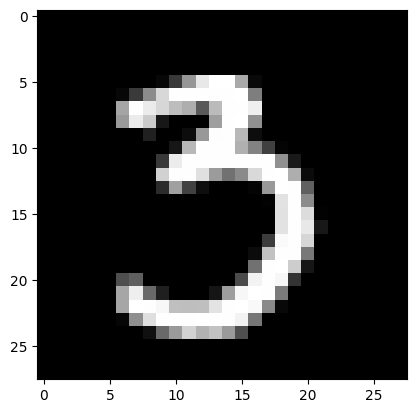

Prediction:  [5]
Label:  5


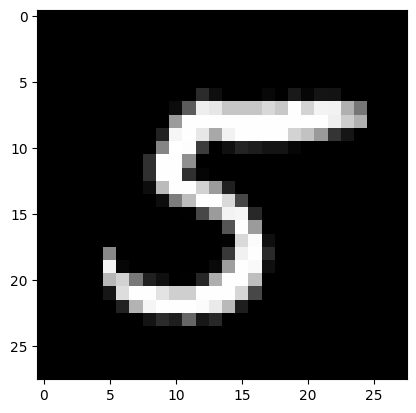

Prediction:  [5]
Label:  5


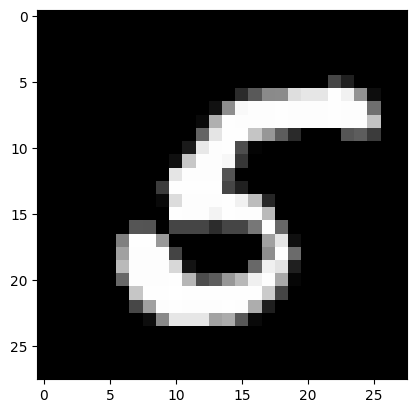

Prediction:  [2]
Label:  2


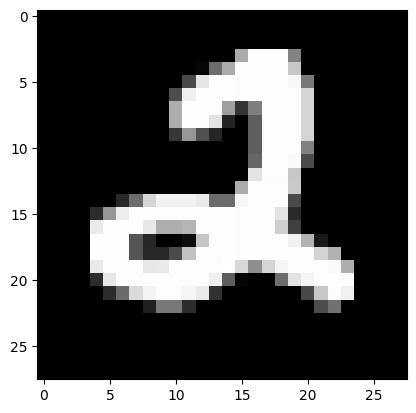

Prediction:  [3]
Label:  3


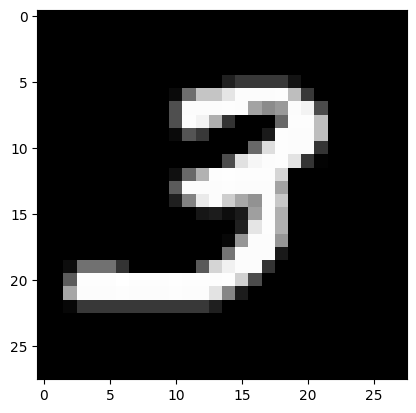

Prediction:  [0]
Label:  0


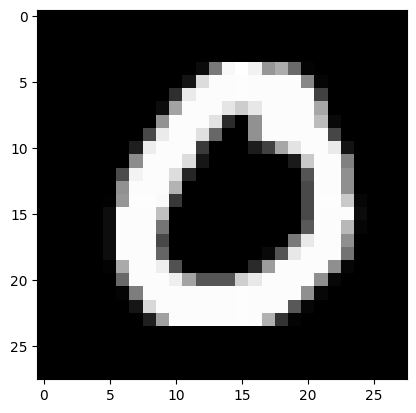

Prediction:  [0]
Label:  0


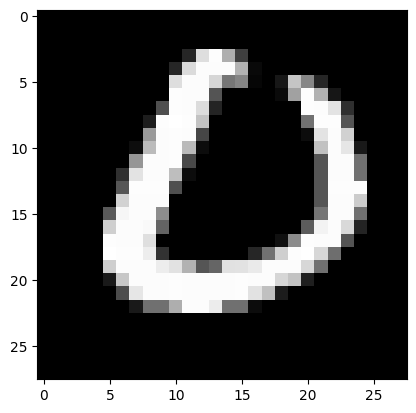

Prediction:  [2]
Label:  2


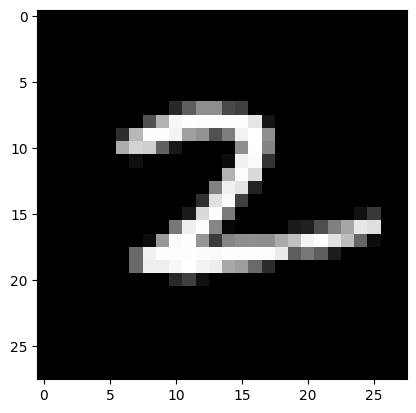

Prediction:  [8]
Label:  8


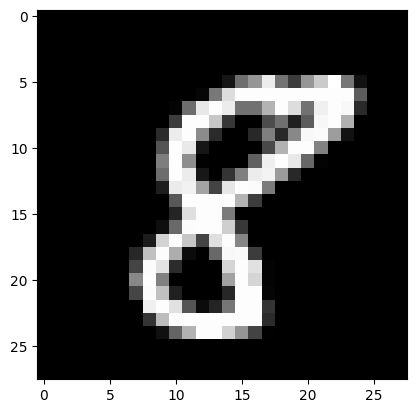

Prediction:  [9]
Label:  9


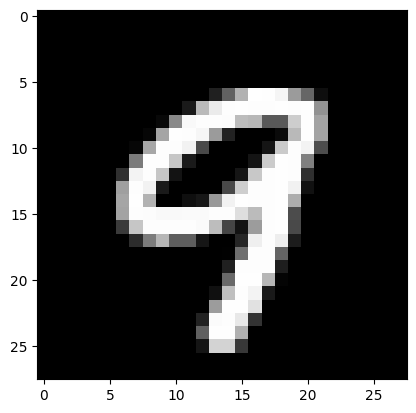

Prediction:  [1]
Label:  1


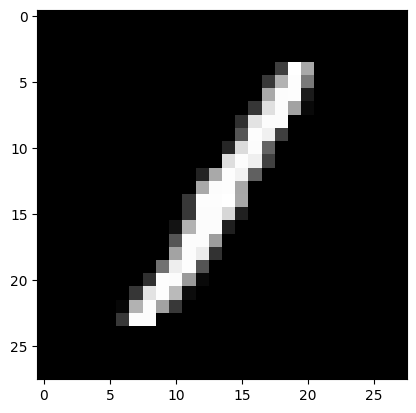

Prediction:  [6]
Label:  6


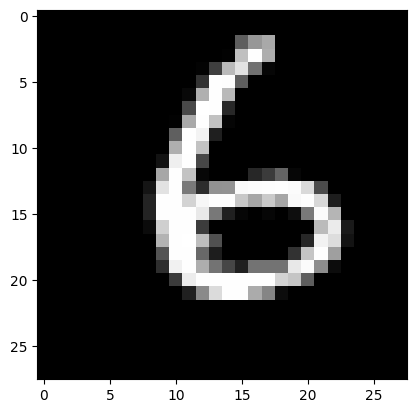

Prediction:  [6]
Label:  6


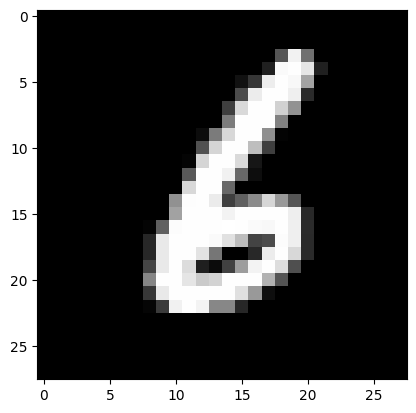

Prediction:  [7]
Label:  7


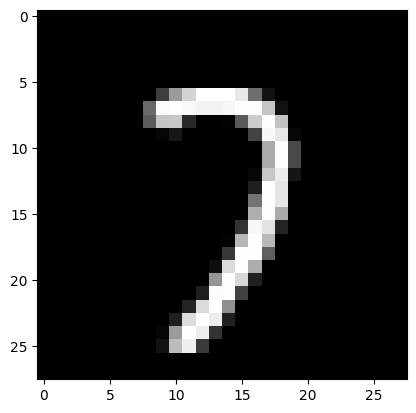

Prediction:  [3]
Label:  3


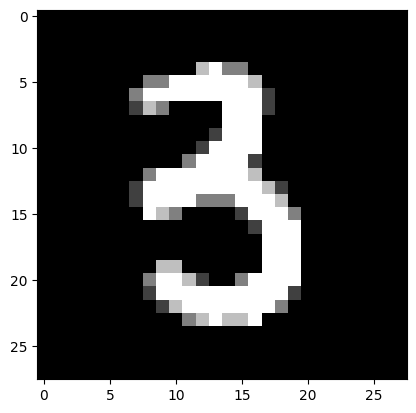

Prediction:  [8]
Label:  8


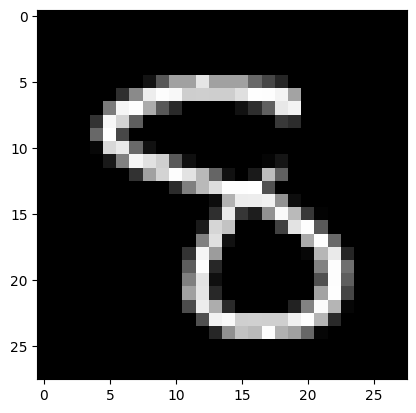

Prediction:  [7]
Label:  7


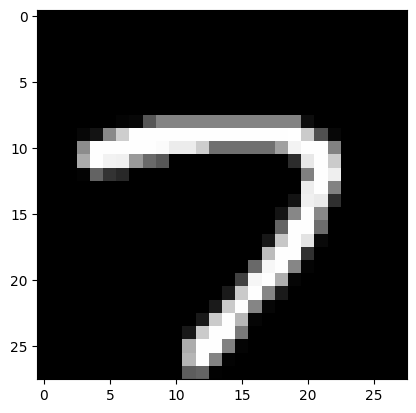

Prediction:  [5]
Label:  5


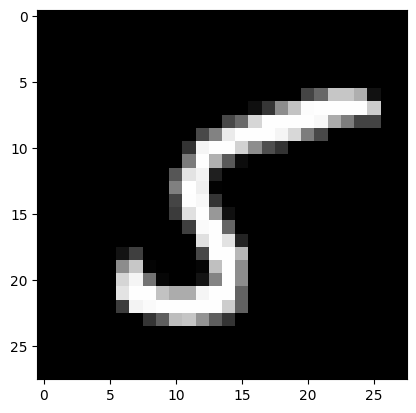

Prediction:  [9]
Label:  9


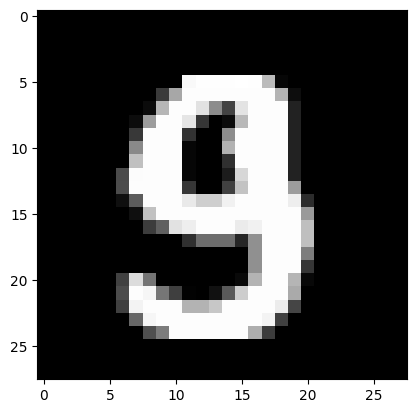

Prediction:  [6]
Label:  6


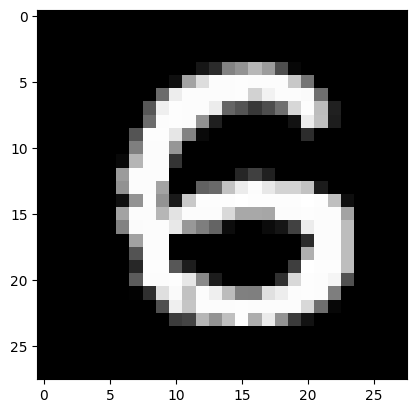

Prediction:  [4]
Label:  4


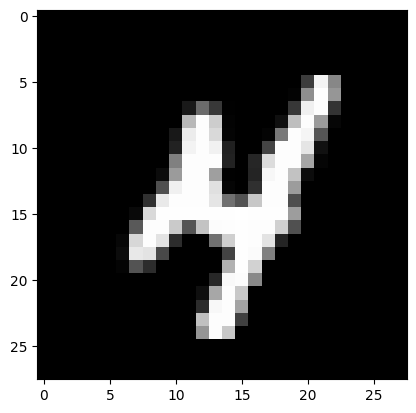

Prediction:  [8]
Label:  8


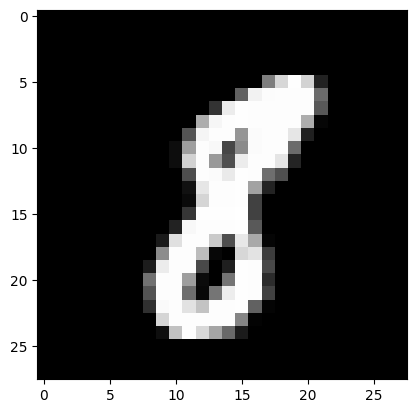

Prediction:  [7]
Label:  7


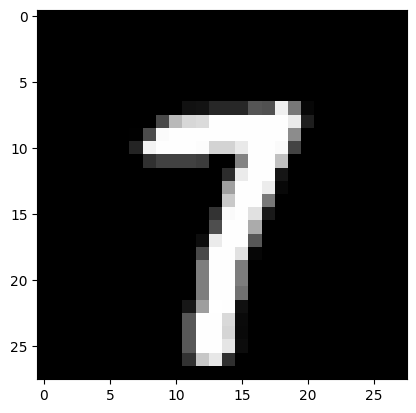

Prediction:  [0]
Label:  0


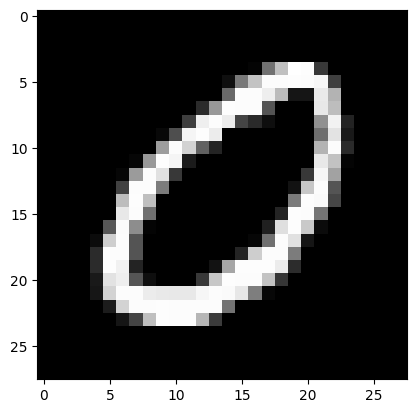

Prediction:  [9]
Label:  9


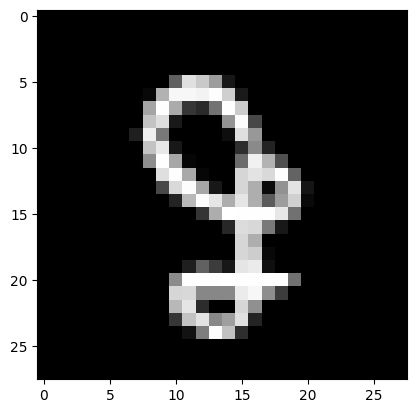

Prediction:  [2]
Label:  2


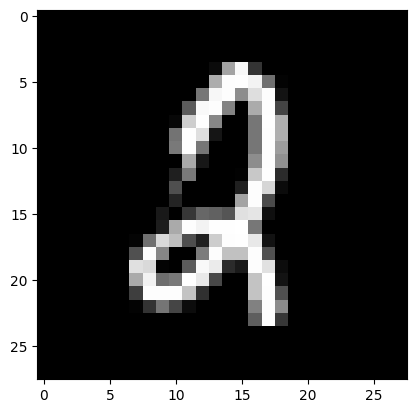

Prediction:  [4]
Label:  4


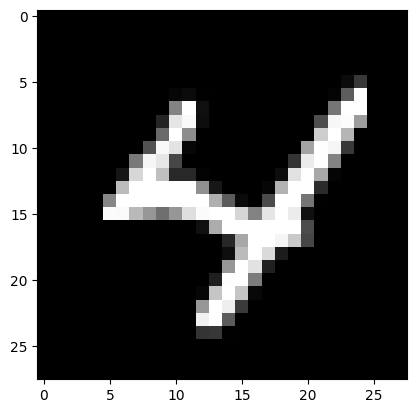

Prediction:  [8]
Label:  8


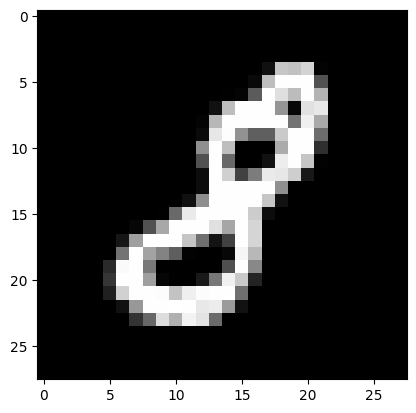

Prediction:  [5]
Label:  5


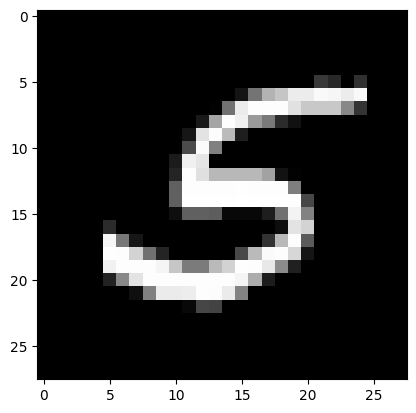

Prediction:  [4]
Label:  4


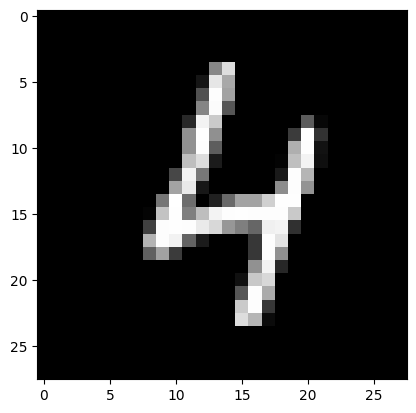

Prediction:  [4]
Label:  4


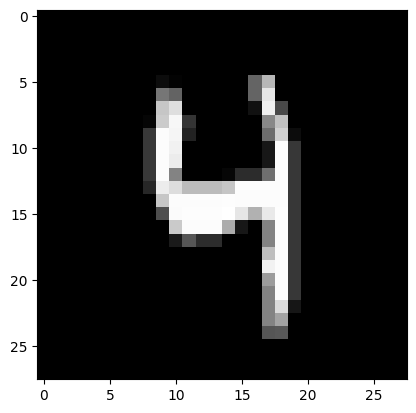

Prediction:  [2]
Label:  2


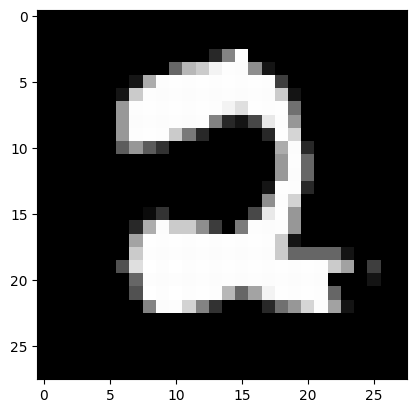

Prediction:  [8]
Label:  8


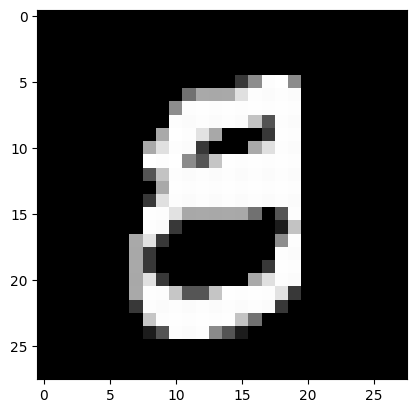

Prediction:  [8]
Label:  8


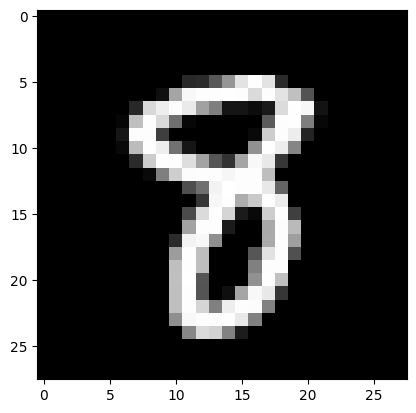

Prediction:  [5]
Label:  5


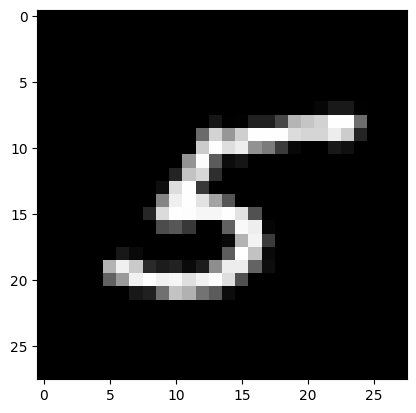

Prediction:  [2]
Label:  2


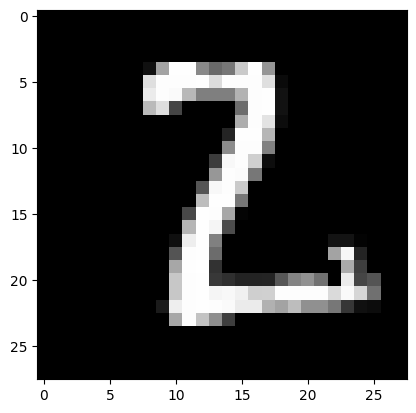

Prediction:  [1]
Label:  1


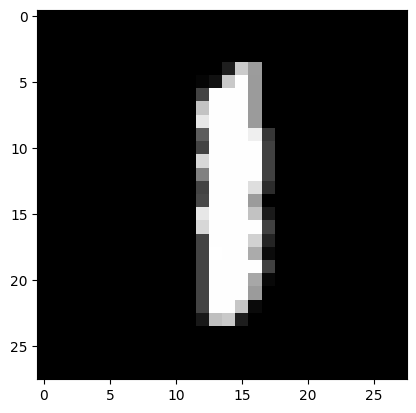

Prediction:  [3]
Label:  3


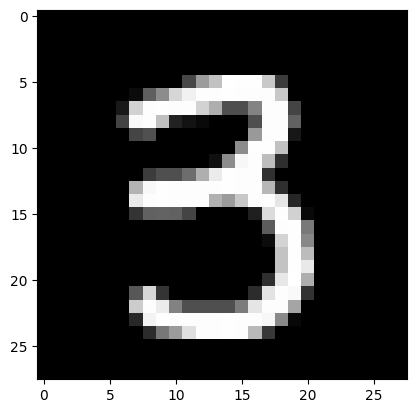

Prediction:  [8]
Label:  8


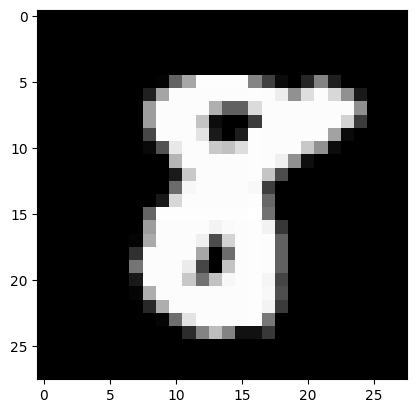

Prediction:  [4]
Label:  4


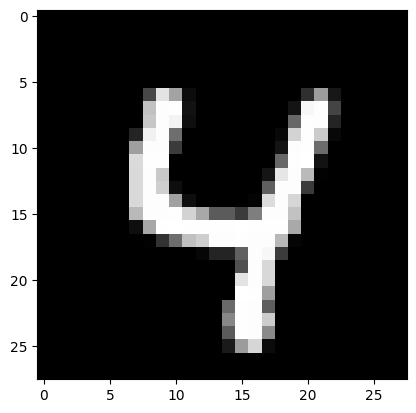

Prediction:  [7]
Label:  7


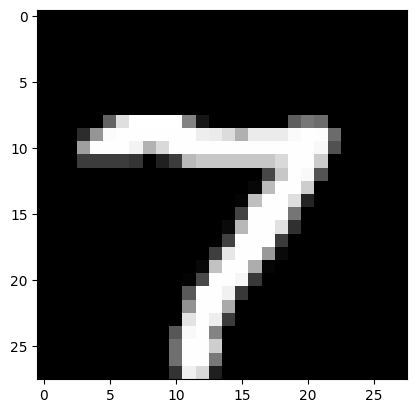

Prediction:  [6]
Label:  6


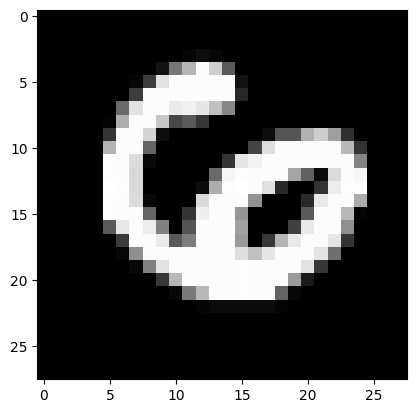

Prediction:  [5]
Label:  5


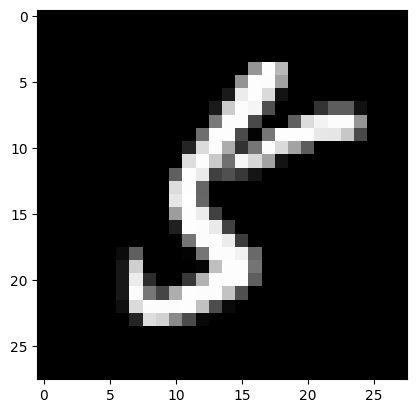

Prediction:  [5]
Label:  5


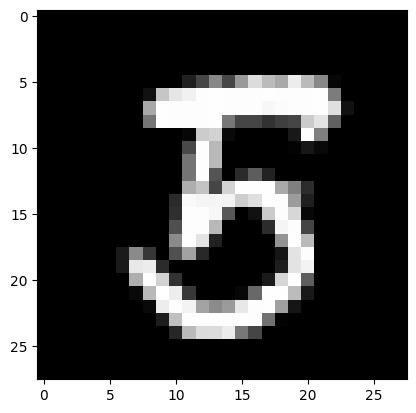

Prediction:  [3]
Label:  3


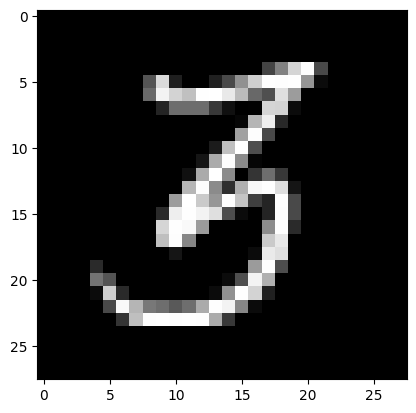

Prediction:  [9]
Label:  9


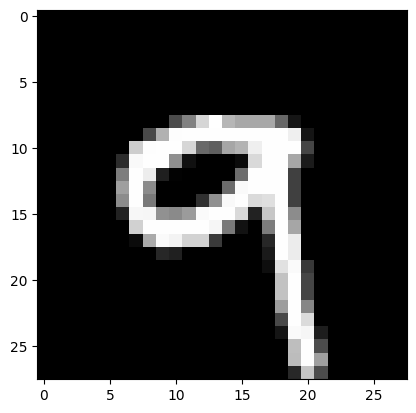

Prediction:  [1]
Label:  1


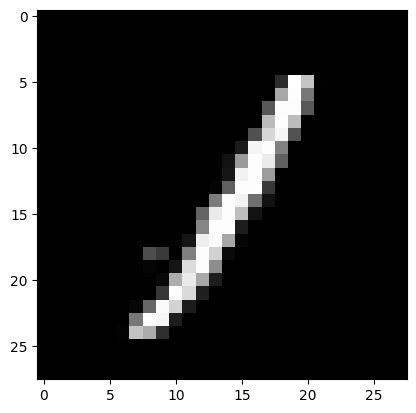

Prediction:  [2]
Label:  2


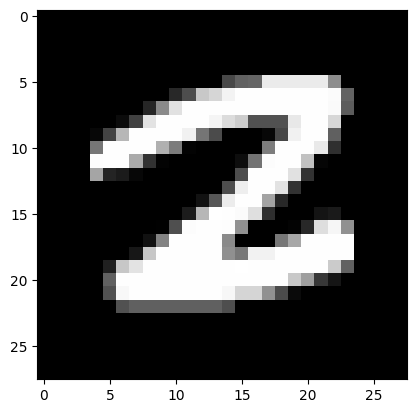

Prediction:  [7]
Label:  7


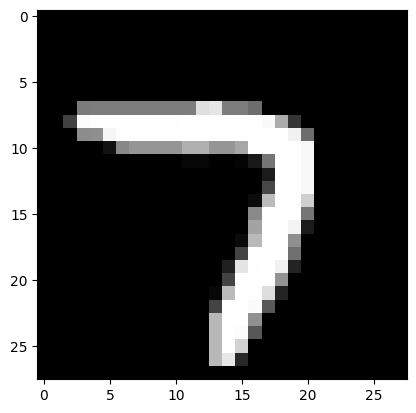

Prediction:  [6]
Label:  6


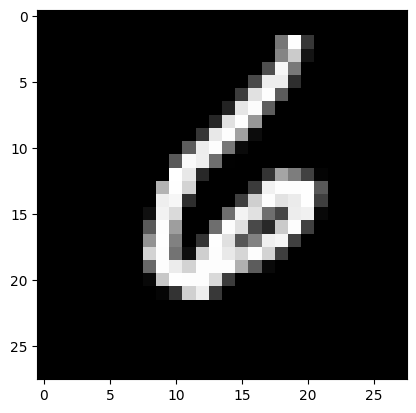

Prediction:  [7]
Label:  7


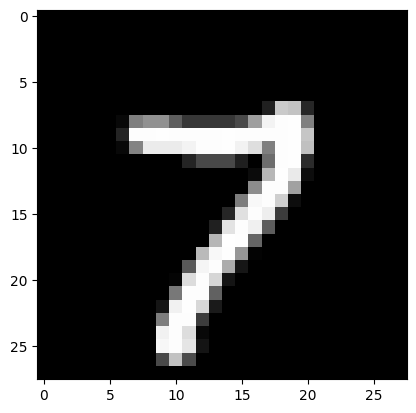

Prediction:  [3]
Label:  3


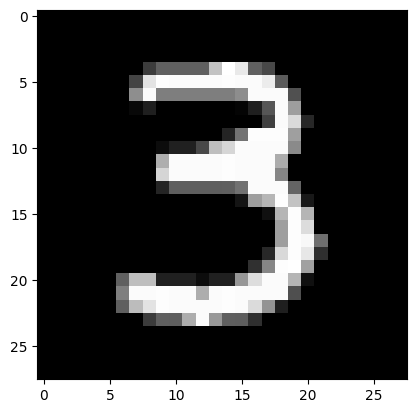

Prediction:  [6]
Label:  6


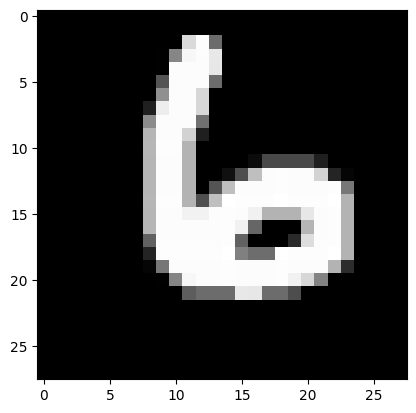

Prediction:  [4]
Label:  4


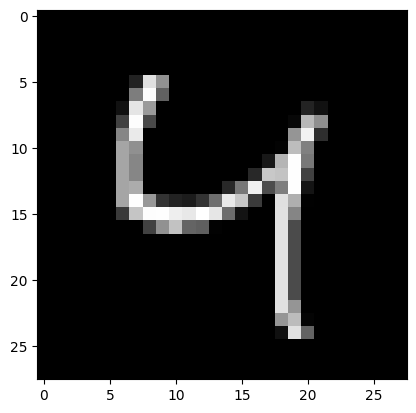

Prediction:  [7]
Label:  7


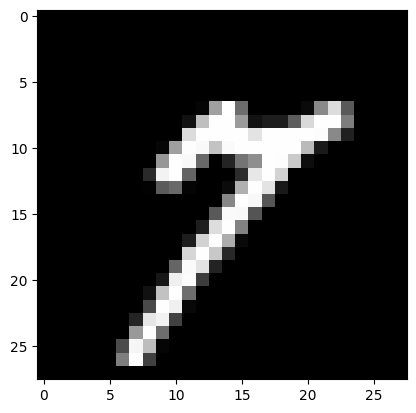

Prediction:  [3]
Label:  3


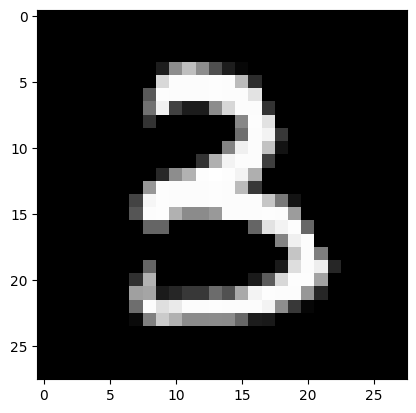

Prediction:  [9]
Label:  9


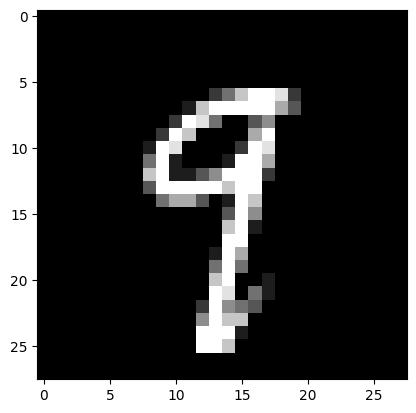

Prediction:  [6]
Label:  6


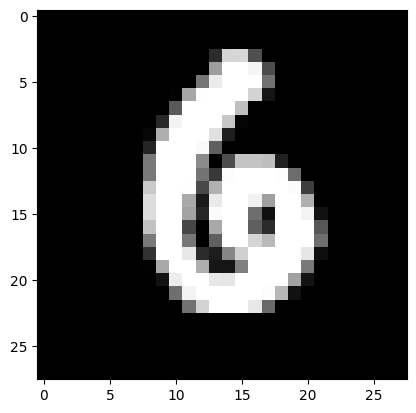

Prediction:  [6]
Label:  6


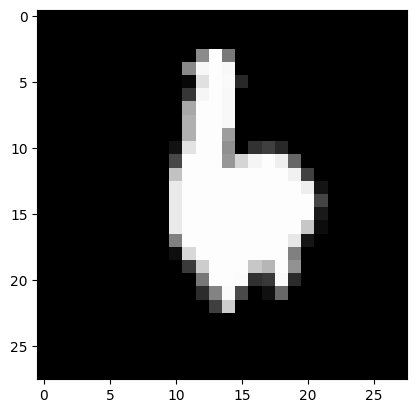

Prediction:  [3]
Label:  3


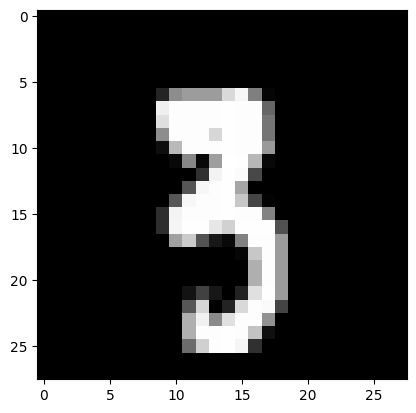

Prediction:  [6]
Label:  0


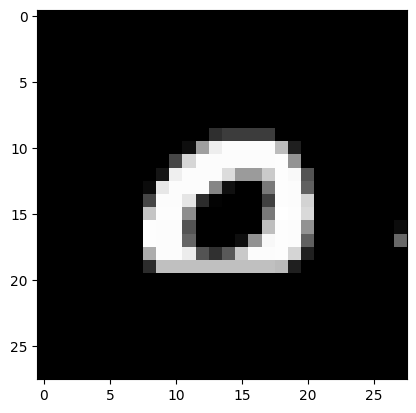

Prediction:  [0]
Label:  0


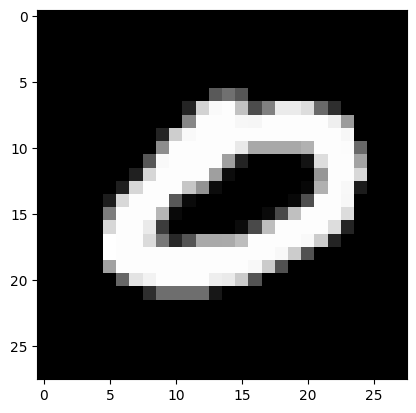

Prediction:  [9]
Label:  9


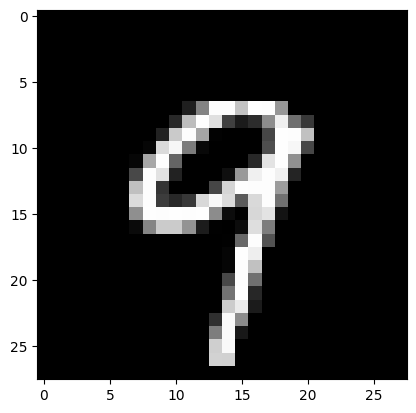

Prediction:  [6]
Label:  6


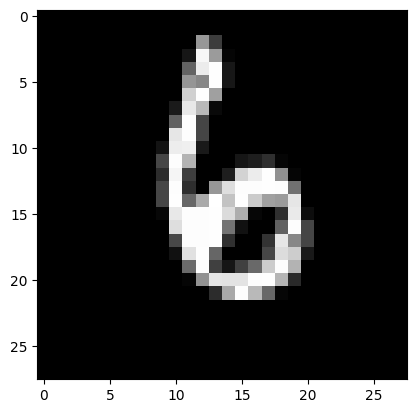

Prediction:  [2]
Label:  2


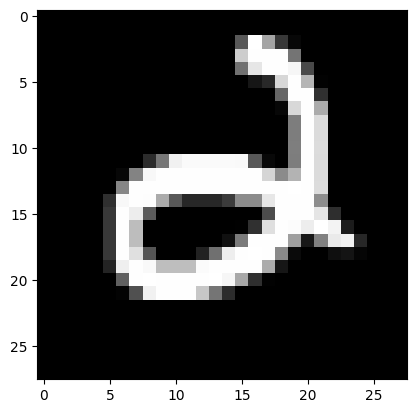

Prediction:  [1]
Label:  1


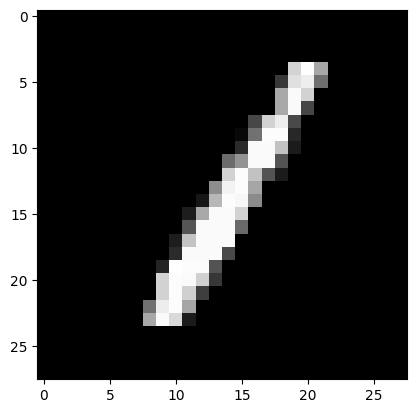

Prediction:  [1]
Label:  1


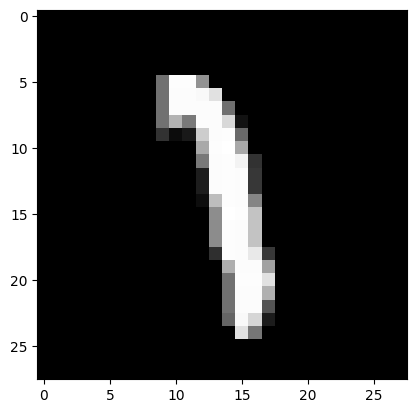

Prediction:  [3]
Label:  3


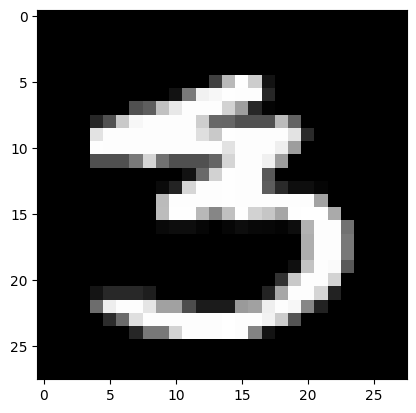

Prediction:  [7]
Label:  7


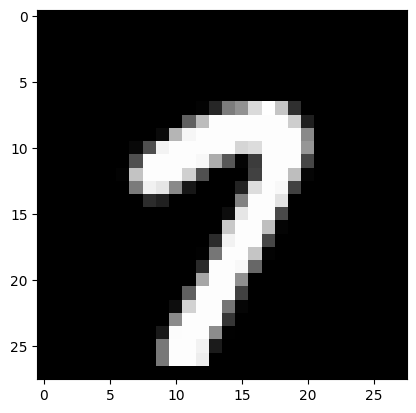

Prediction:  [4]
Label:  4


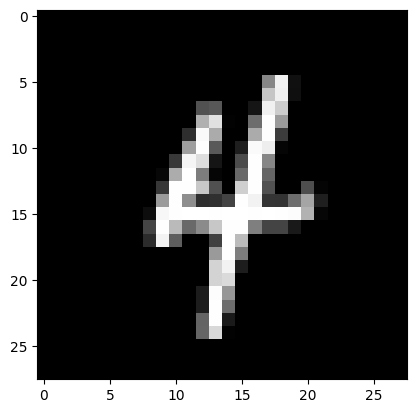

Prediction:  [2]
Label:  2


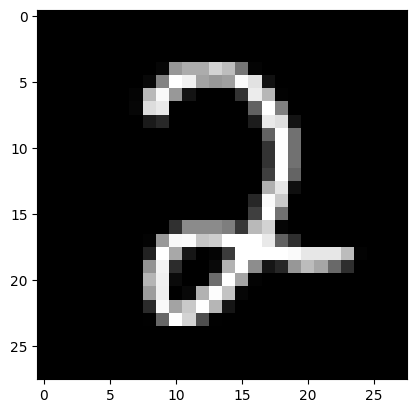

Prediction:  [0]
Label:  0


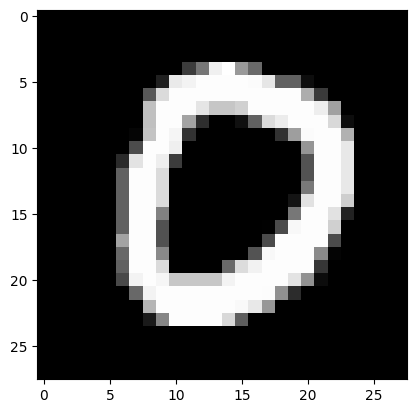

Prediction:  [1]
Label:  1


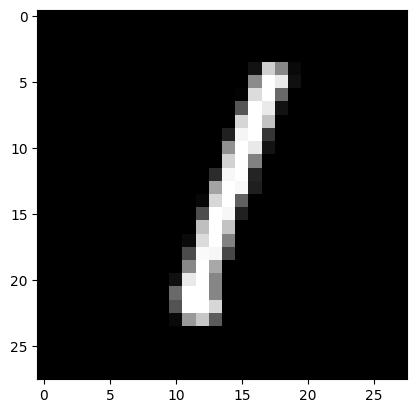

Prediction:  [1]
Label:  1


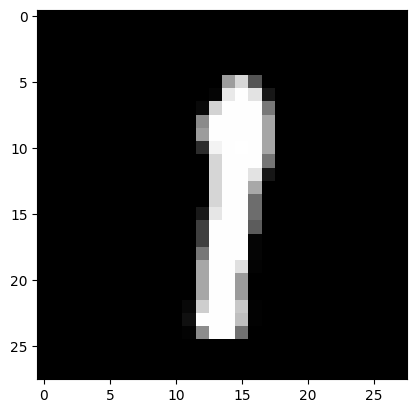

Prediction:  [5]
Label:  5


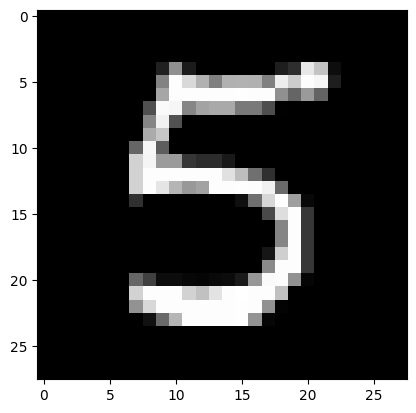

Prediction:  [1]
Label:  1


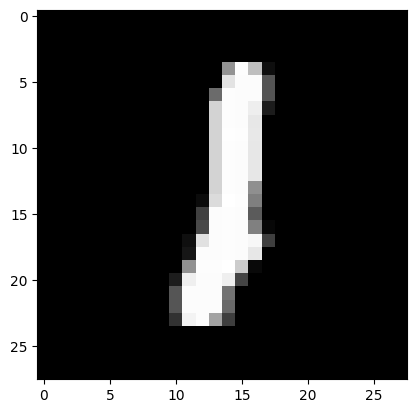

Prediction:  [7]
Label:  7


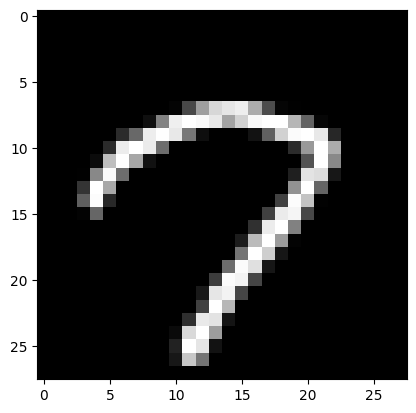

Prediction:  [7]
Label:  7


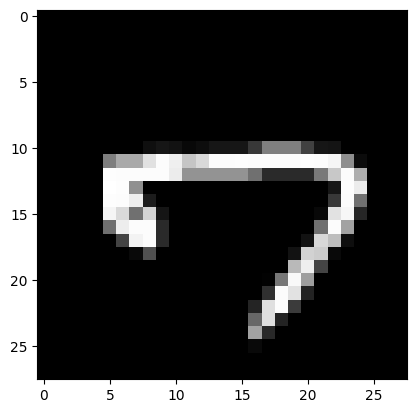

Prediction:  [6]
Label:  6


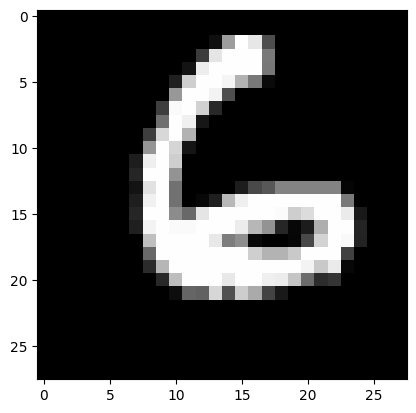

Prediction:  [1]
Label:  1


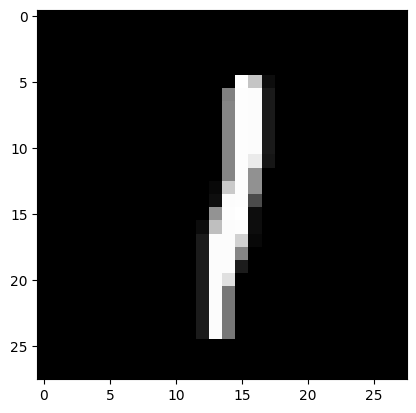

Prediction:  [7]
Label:  7


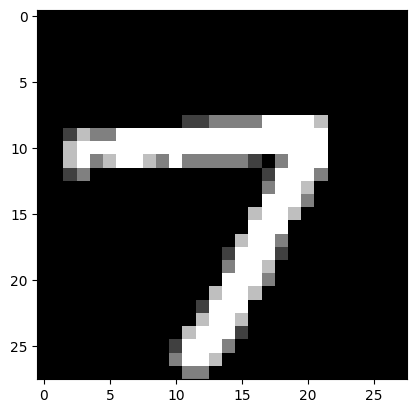

Prediction:  [9]
Label:  9


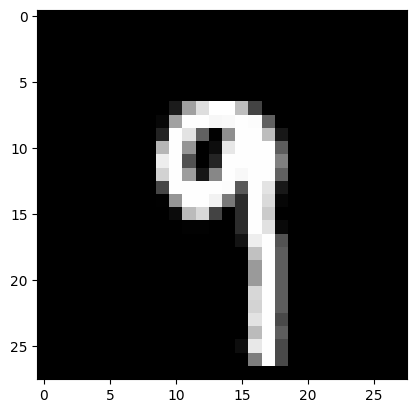

Prediction:  [0]
Label:  0


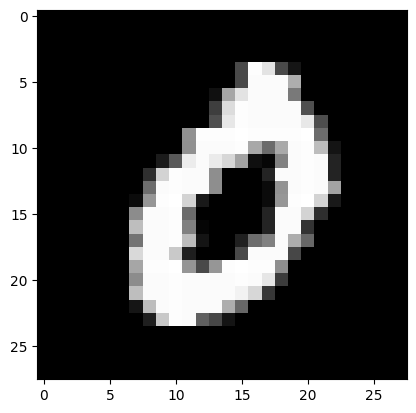

Prediction:  [6]
Label:  6


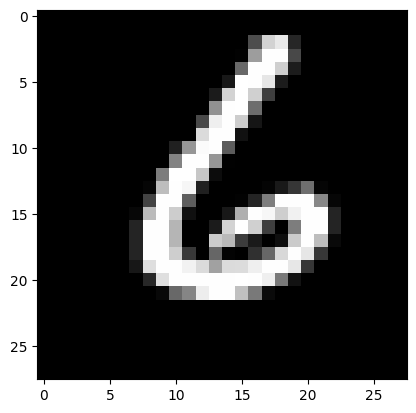

Prediction:  [1]
Label:  1


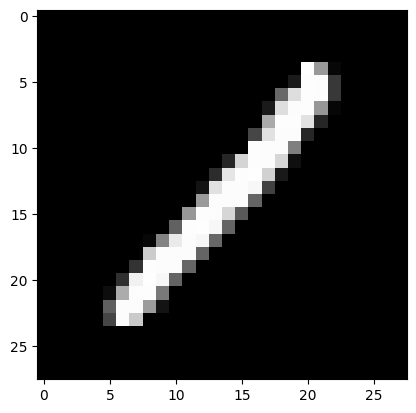

Prediction:  [9]
Label:  9


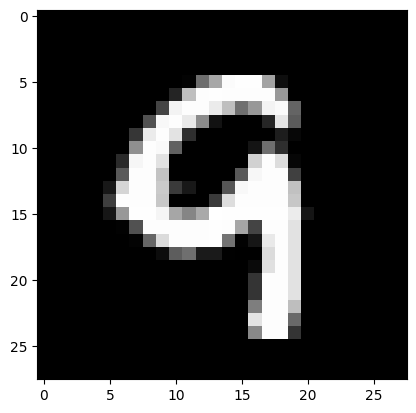

Prediction:  [7]
Label:  7


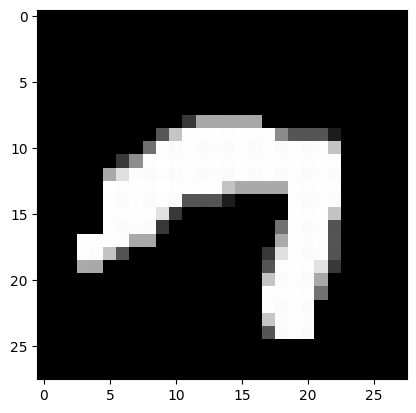

Prediction:  [9]
Label:  9


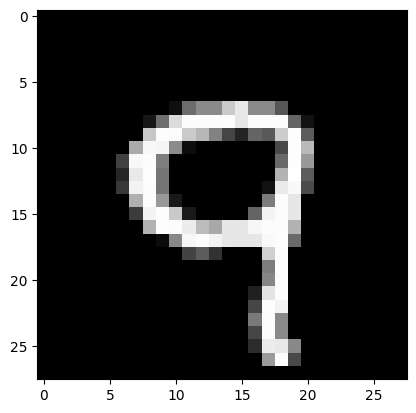

Prediction:  [3]
Label:  3


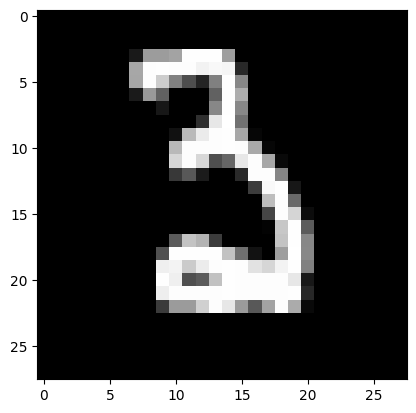

Prediction:  [9]
Label:  9


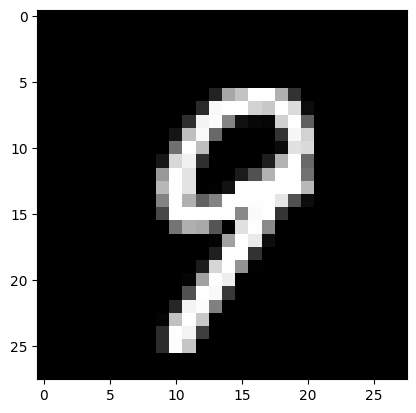

Prediction:  [1]
Label:  1


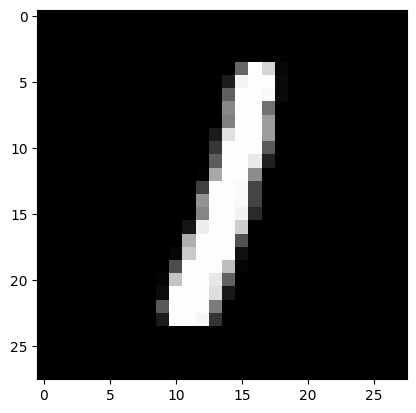

Prediction:  [2]
Label:  8


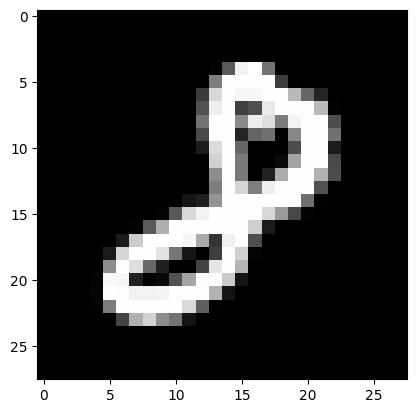

Prediction:  [9]
Label:  9


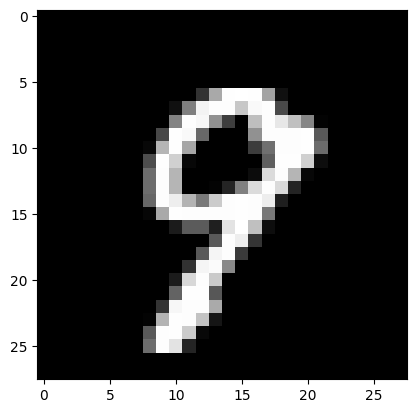

Prediction:  [9]
Label:  9


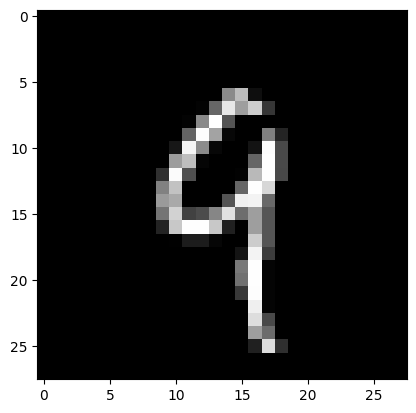

Prediction:  [3]
Label:  3


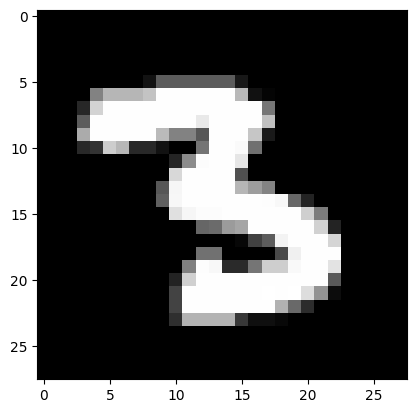

Prediction:  [3]
Label:  3


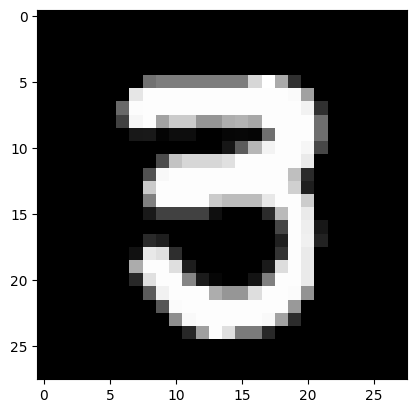

Prediction:  [7]
Label:  7


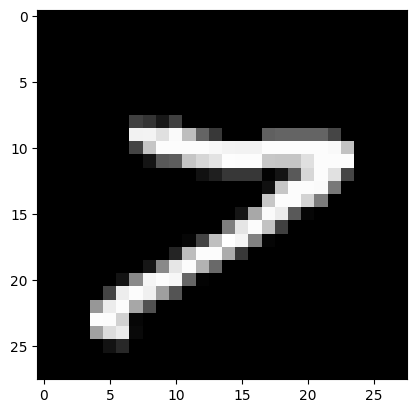

Prediction:  [8]
Label:  8


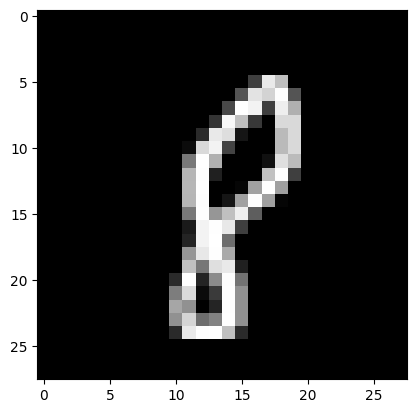

Prediction:  [2]
Label:  2


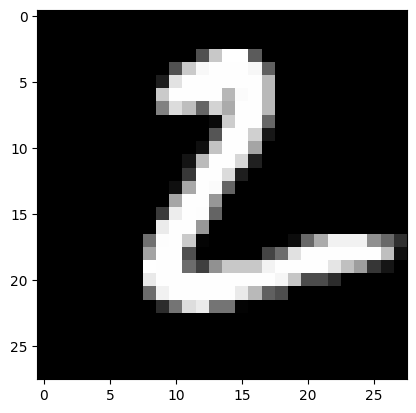

Prediction:  [6]
Label:  6


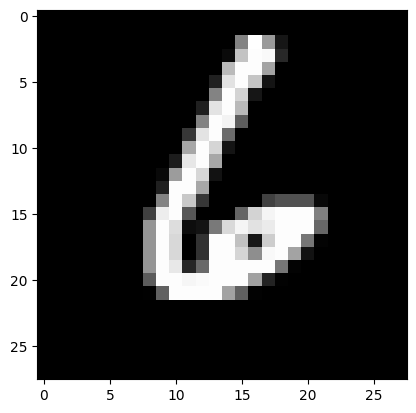

Prediction:  [3]
Label:  3


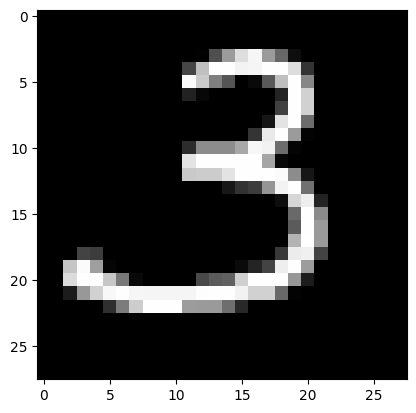

Prediction:  [9]
Label:  9


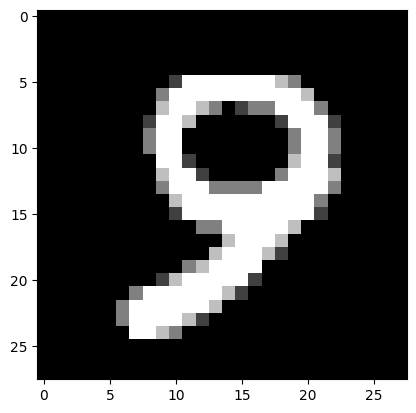

Prediction:  [7]
Label:  7


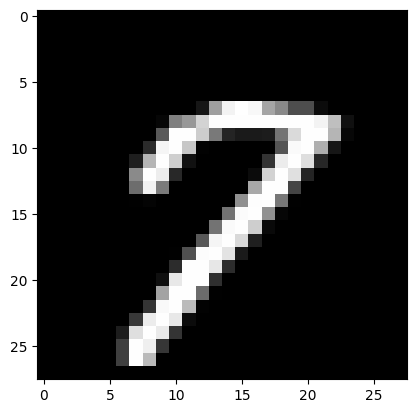

Prediction:  [9]
Label:  9


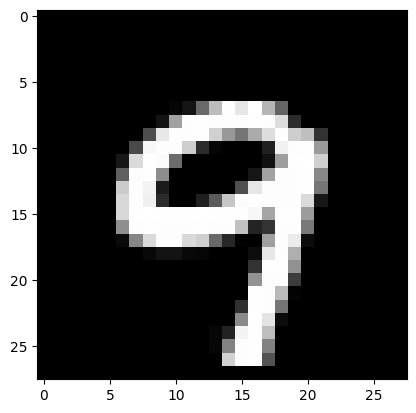

Prediction:  [2]
Label:  2


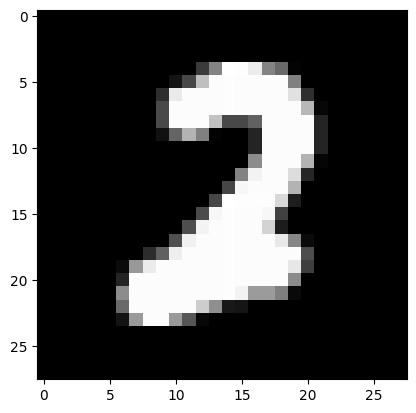

Prediction:  [0]
Label:  0


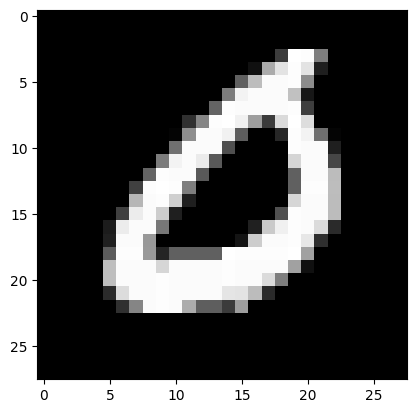

Prediction:  [1]
Label:  1


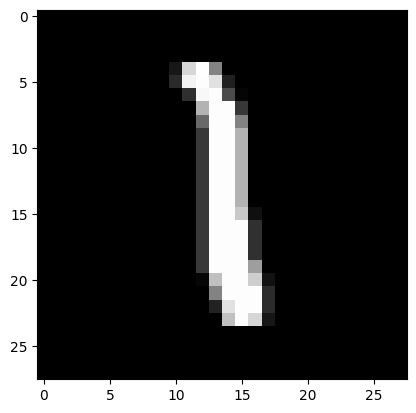

Prediction:  [0]
Label:  0


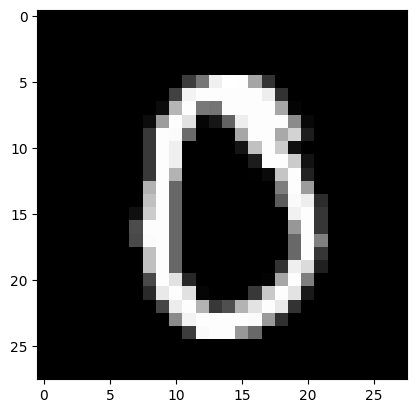

Prediction:  [9]
Label:  9


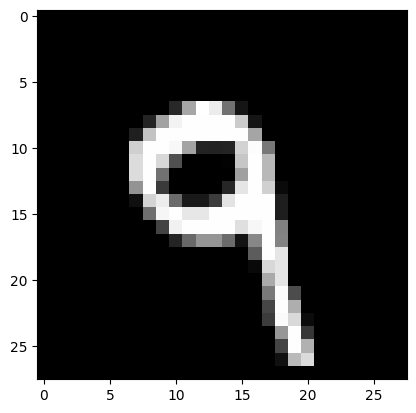

Prediction:  [1]
Label:  1


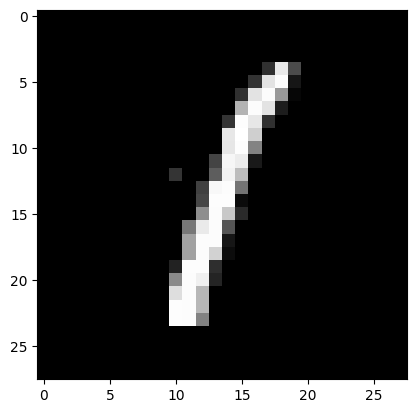

Prediction:  [6]
Label:  6


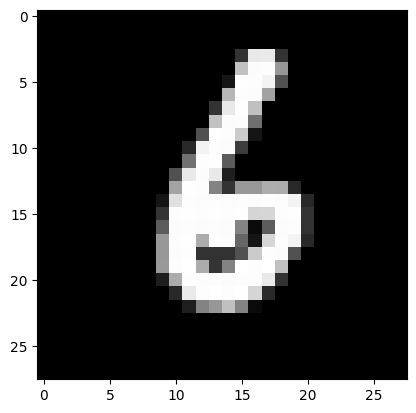

Prediction:  [4]
Label:  4


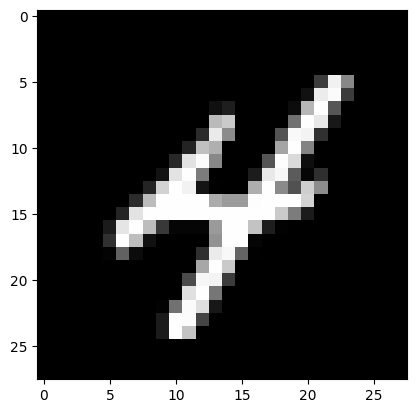

Prediction:  [2]
Label:  2


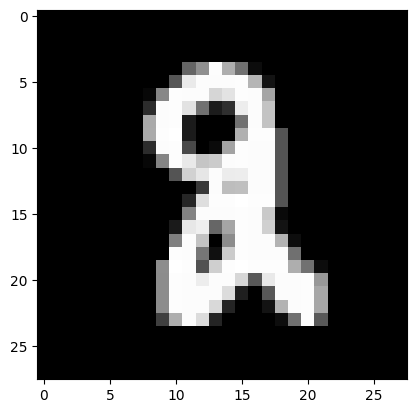

Prediction:  [3]
Label:  3


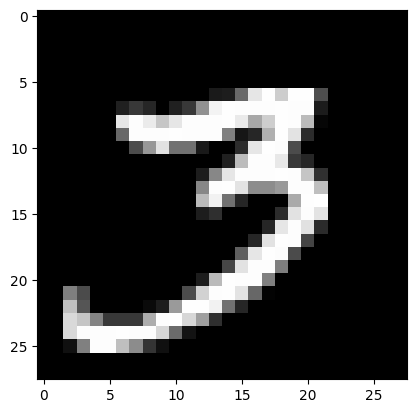

Prediction:  [0]
Label:  0


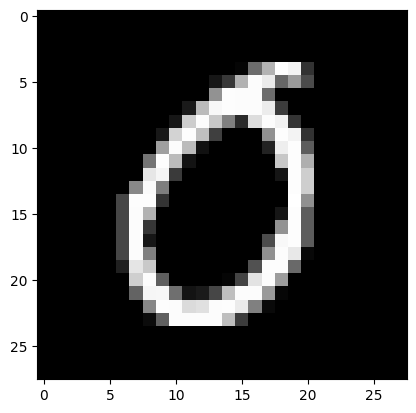

Prediction:  [3]
Label:  3


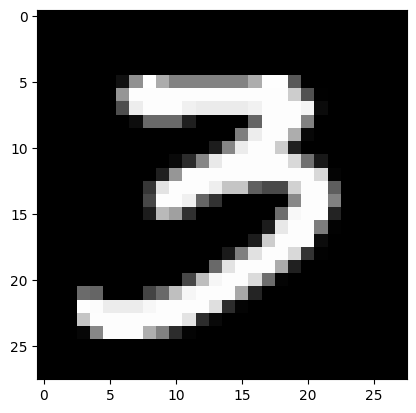

Prediction:  [4]
Label:  4


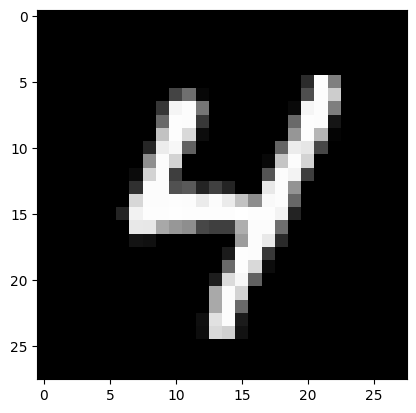

Prediction:  [1]
Label:  1


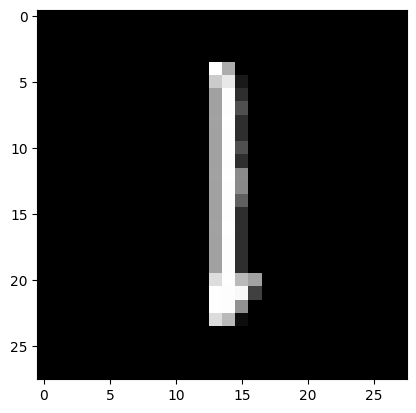

Prediction:  [9]
Label:  9


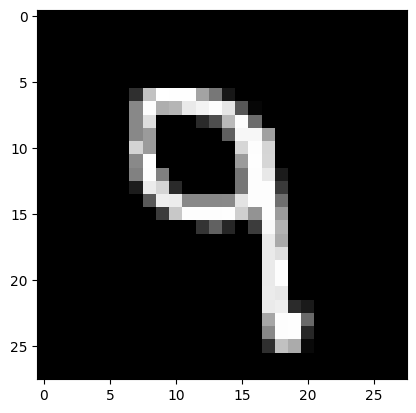

Prediction:  [3]
Label:  3


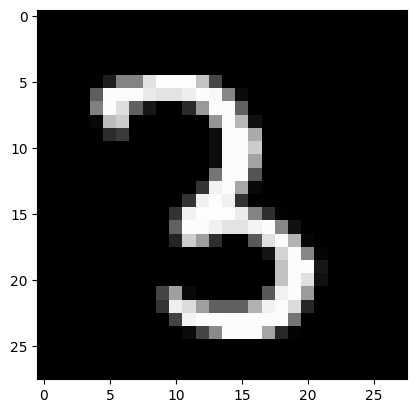

Prediction:  [4]
Label:  4


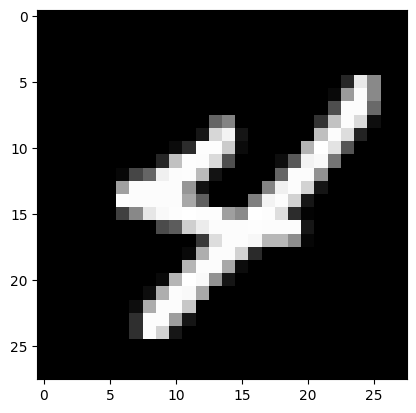

Prediction:  [7]
Label:  7


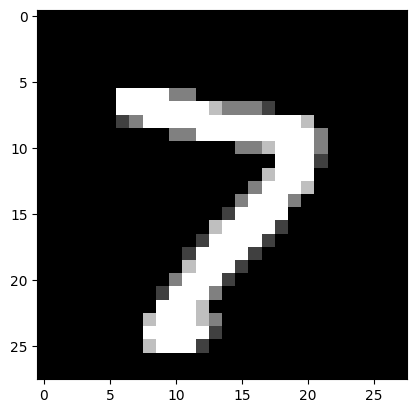

Prediction:  [1]
Label:  1


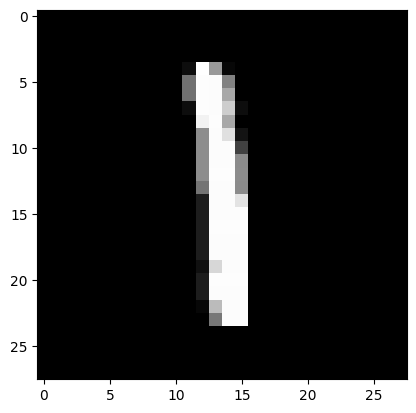

Prediction:  [6]
Label:  6


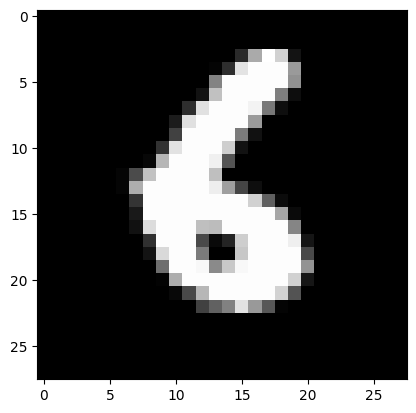

Prediction:  [4]
Label:  4


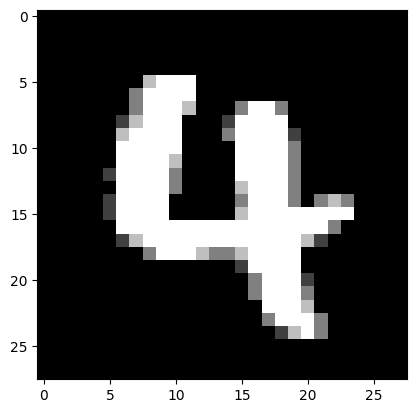

Prediction:  [5]
Label:  5


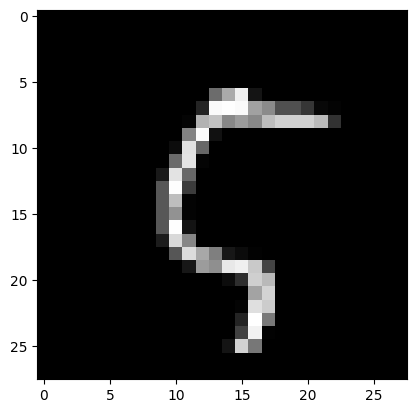

Prediction:  [6]
Label:  6


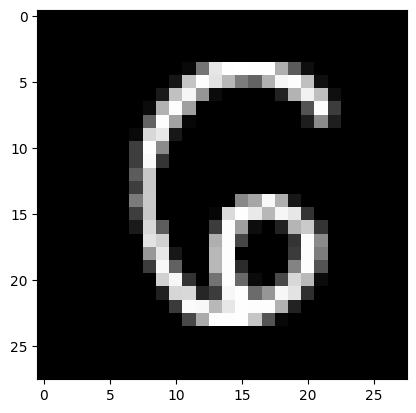

Prediction:  [3]
Label:  3


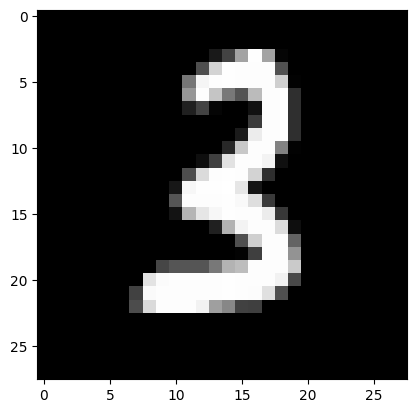

Prediction:  [1]
Label:  1


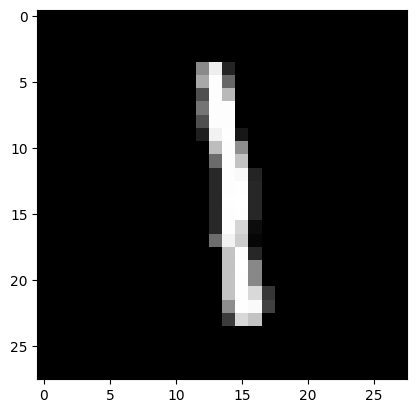

Prediction:  [0]
Label:  0


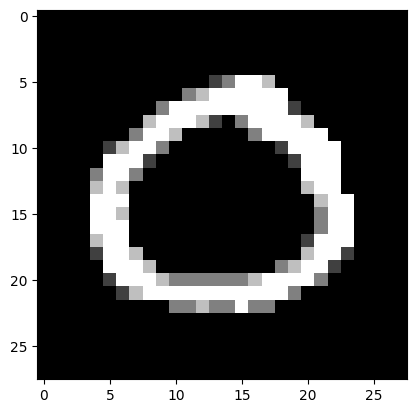

Prediction:  [9]
Label:  9


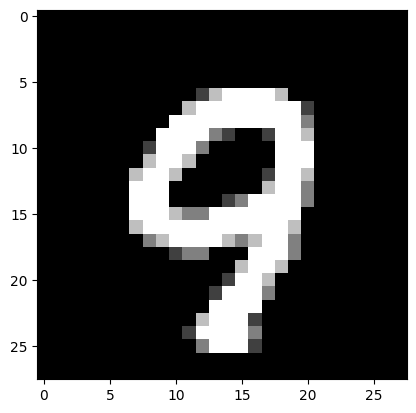

Prediction:  [5]
Label:  3


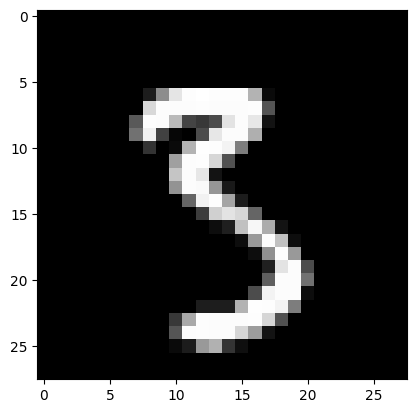

Prediction:  [3]
Label:  5


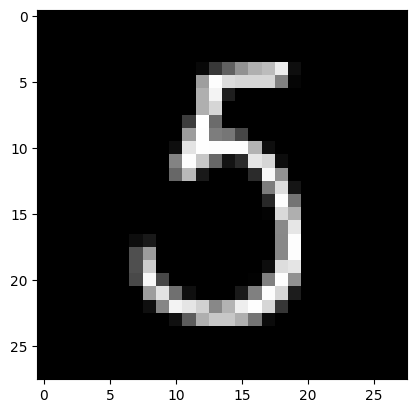

Prediction:  [0]
Label:  0


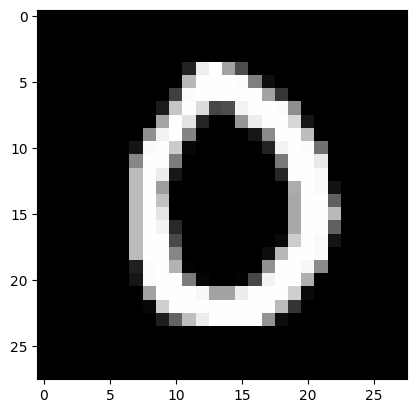

Prediction:  [7]
Label:  7


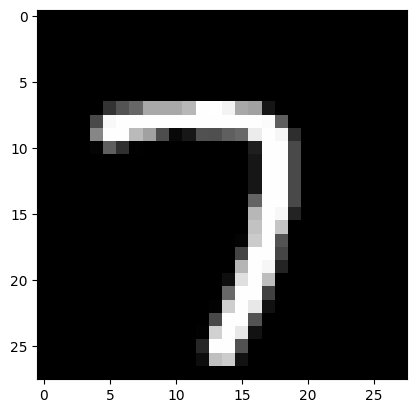

Prediction:  [7]
Label:  7


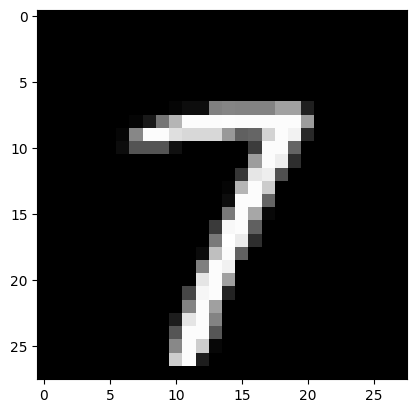

Prediction:  [5]
Label:  3


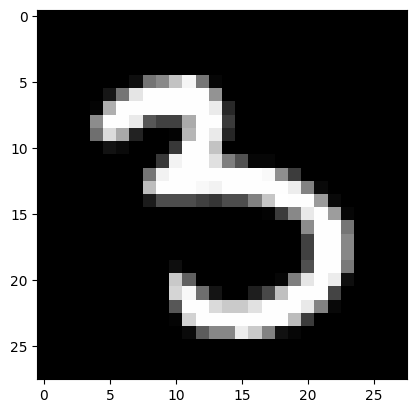

Prediction:  [4]
Label:  4


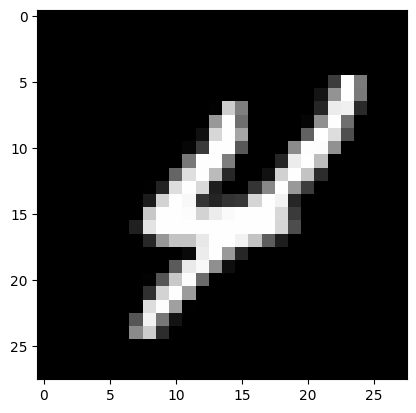

Prediction:  [2]
Label:  2


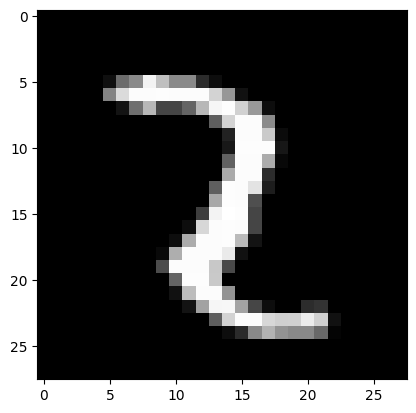

Prediction:  [5]
Label:  5


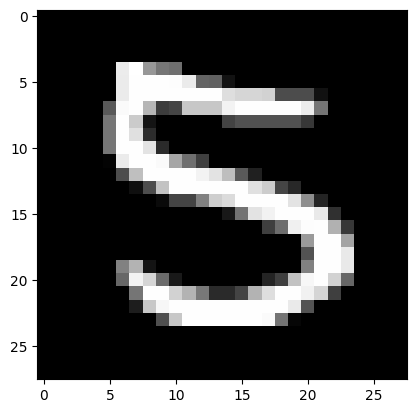

Prediction:  [3]
Label:  3


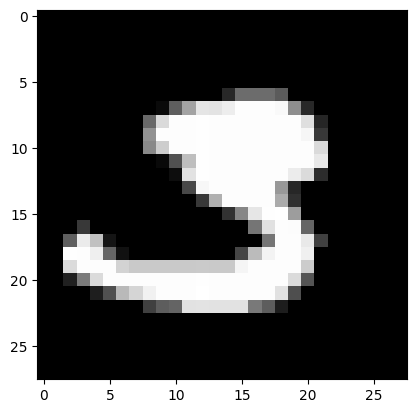

Prediction:  [5]
Label:  5


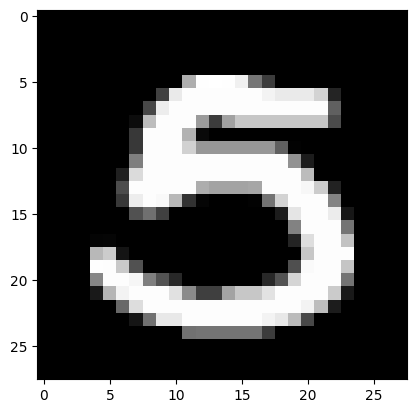

Prediction:  [6]
Label:  6


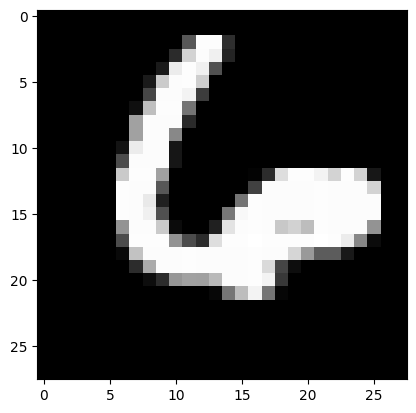

Prediction:  [5]
Label:  5


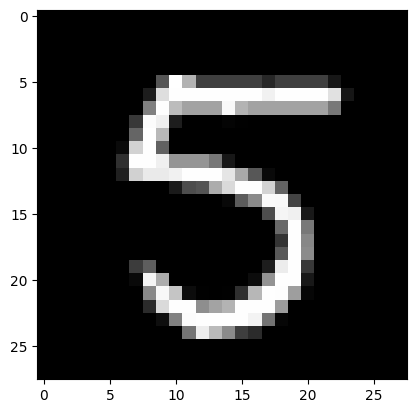

Prediction:  [2]
Label:  2


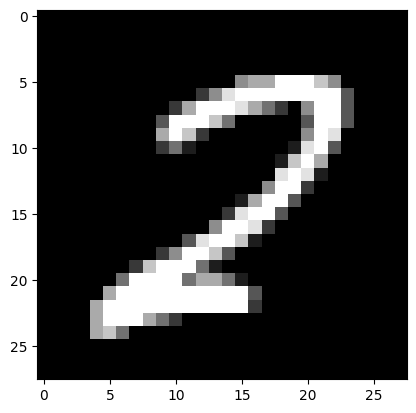

Prediction:  [3]
Label:  3


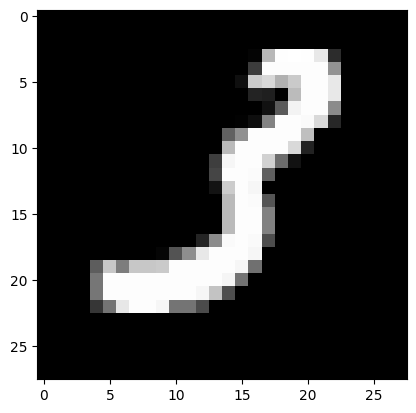

Prediction:  [4]
Label:  4


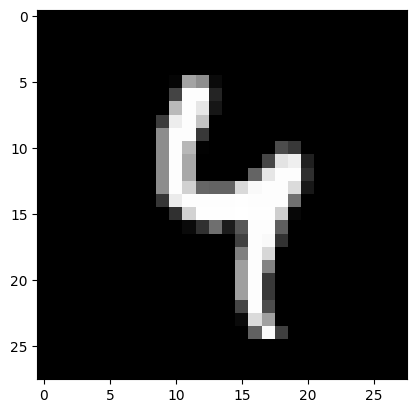

Prediction:  [1]
Label:  1


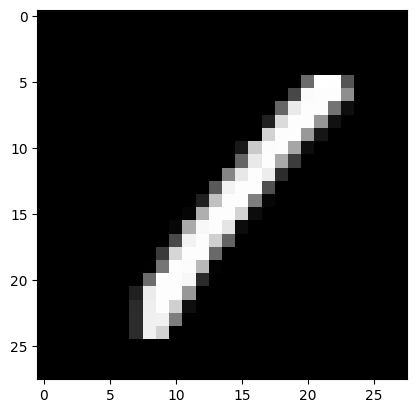

Prediction:  [0]
Label:  0


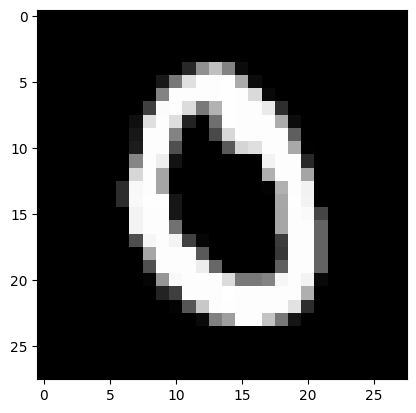

Prediction:  [9]
Label:  9


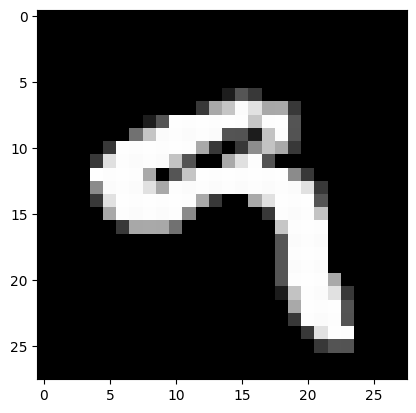

Prediction:  [9]
Label:  9


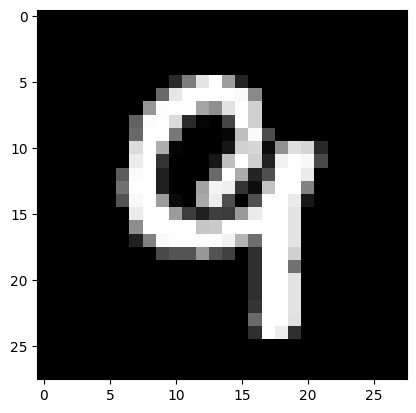

Prediction:  [8]
Label:  8


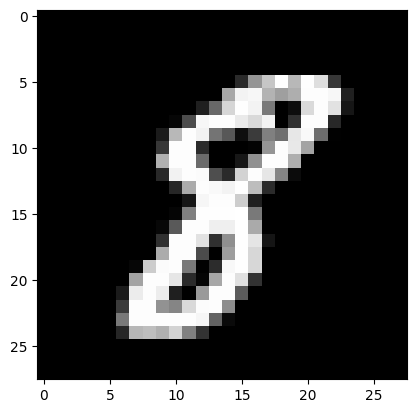

Prediction:  [1]
Label:  1


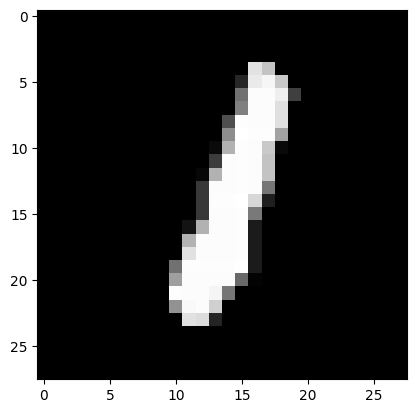

Prediction:  [2]
Label:  2


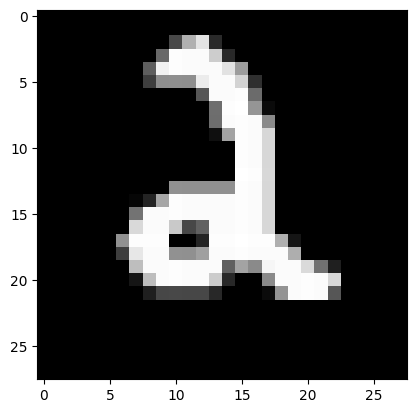

Prediction:  [7]
Label:  7


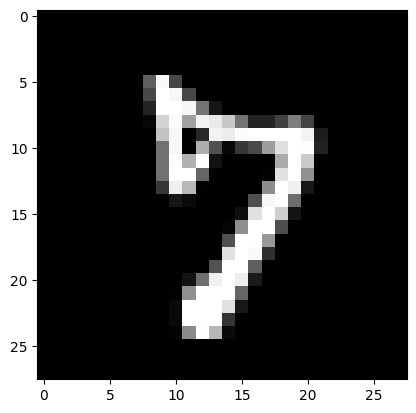

Prediction:  [6]
Label:  6


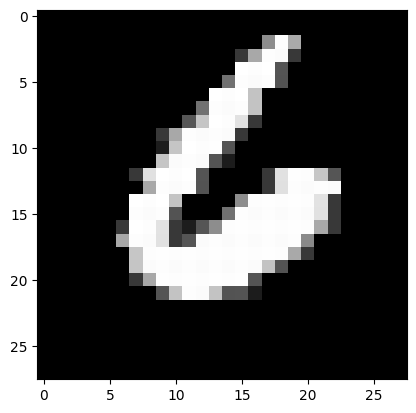

Prediction:  [6]
Label:  6


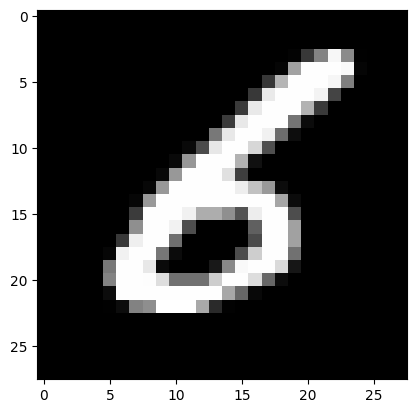

Prediction:  [5]
Label:  5


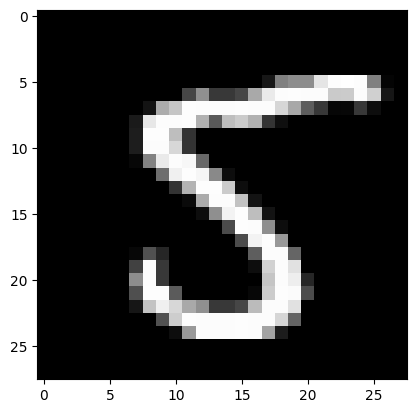

Prediction:  [9]
Label:  9


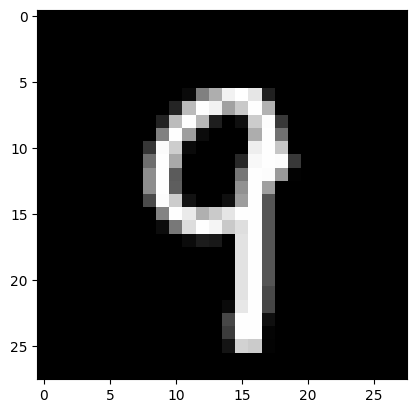

Prediction:  [2]
Label:  2


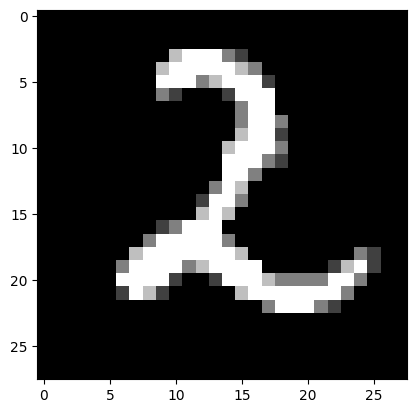

Prediction:  [1]
Label:  1


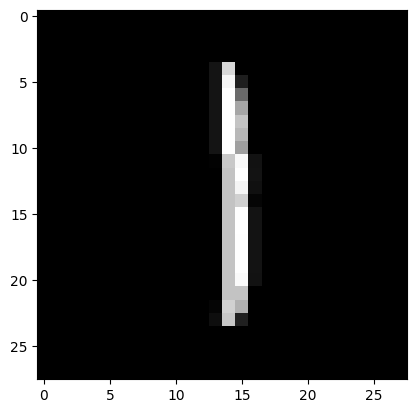

Prediction:  [0]
Label:  0


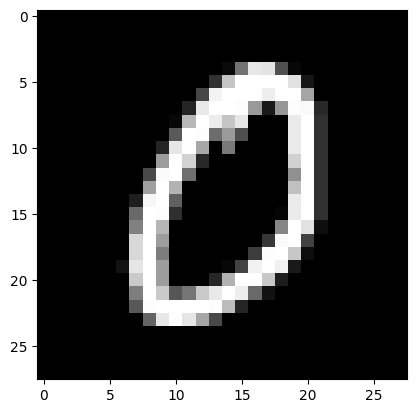

Prediction:  [1]
Label:  1


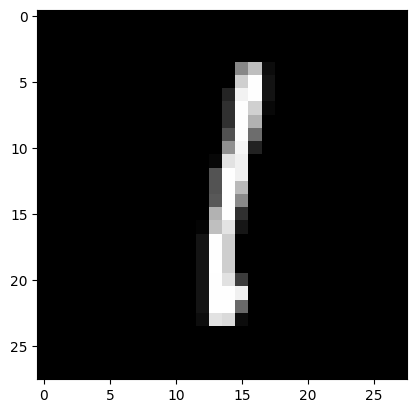

Prediction:  [6]
Label:  6


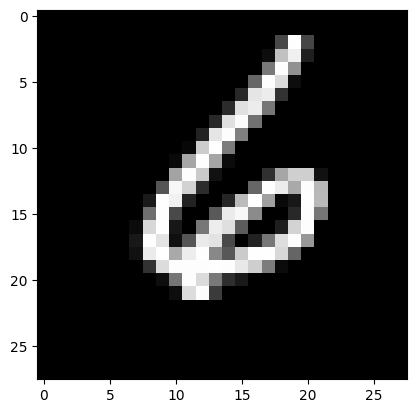

Prediction:  [3]
Label:  3


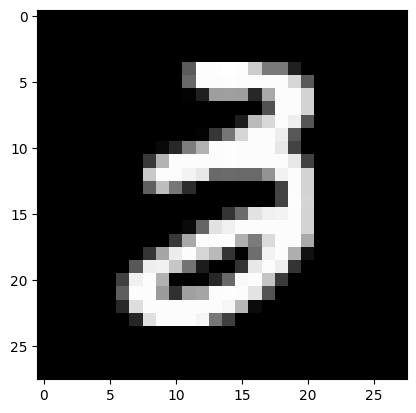

Prediction:  [1]
Label:  1


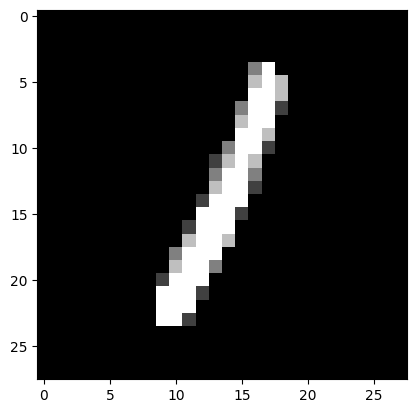

Prediction:  [6]
Label:  4


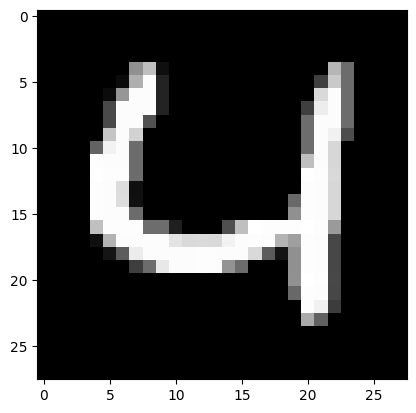

Prediction:  [5]
Label:  5


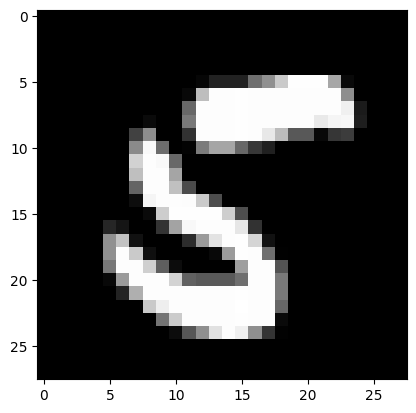

Prediction:  [5]
Label:  5


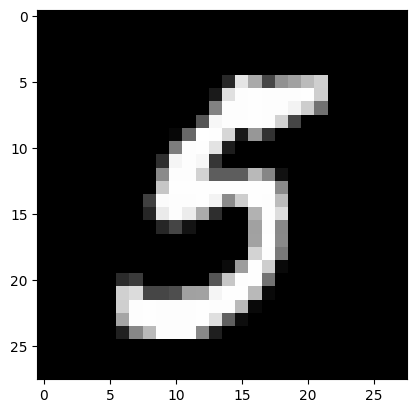

Prediction:  [0]
Label:  0


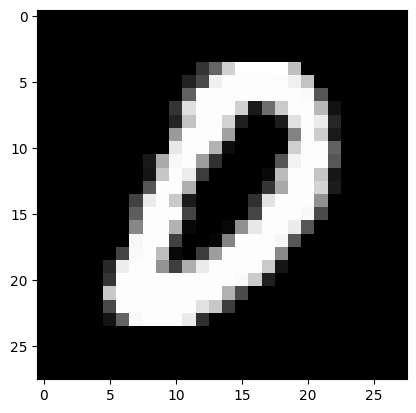

Prediction:  [3]
Label:  3


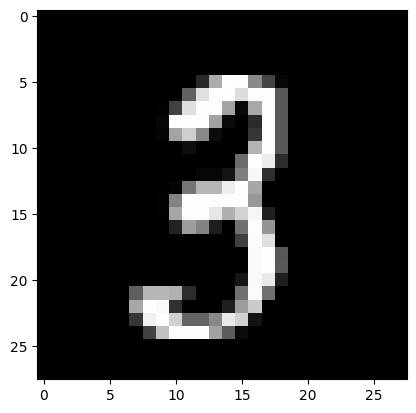

Prediction:  [6]
Label:  6


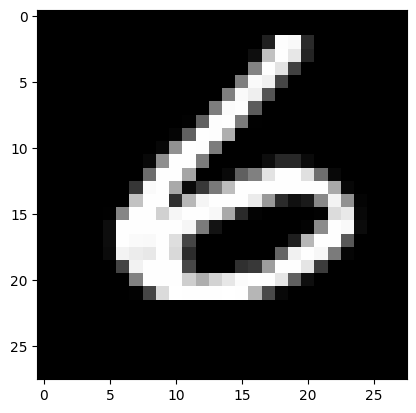

Prediction:  [0]
Label:  0


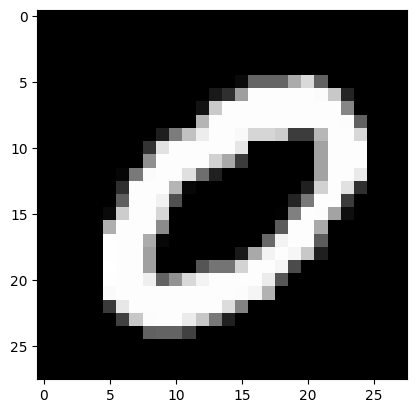

Prediction:  [4]
Label:  4


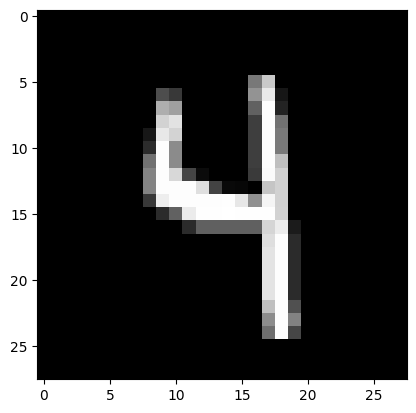

Prediction:  [6]
Label:  6


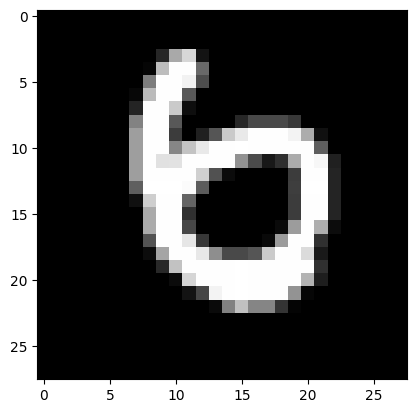

Prediction:  [7]
Label:  7


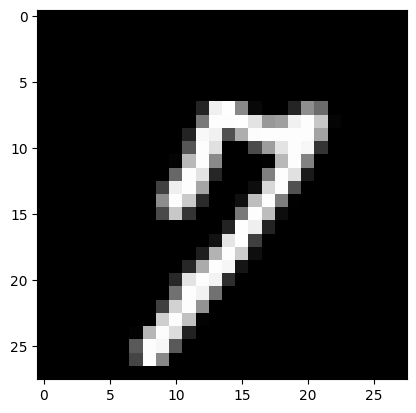

Prediction:  [7]
Label:  7


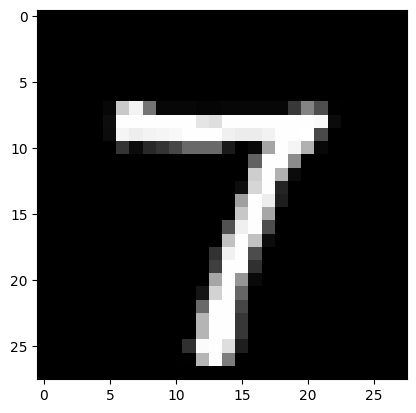

Prediction:  [6]
Label:  6


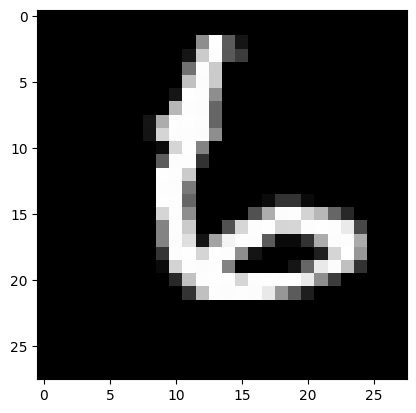

Prediction:  [8]
Label:  8


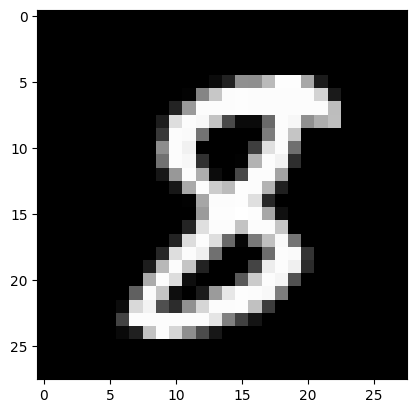

Prediction:  [0]
Label:  0


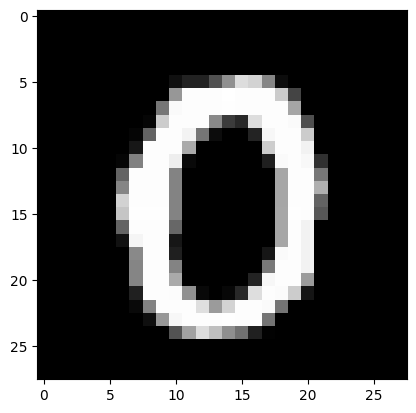

Prediction:  [4]
Label:  4


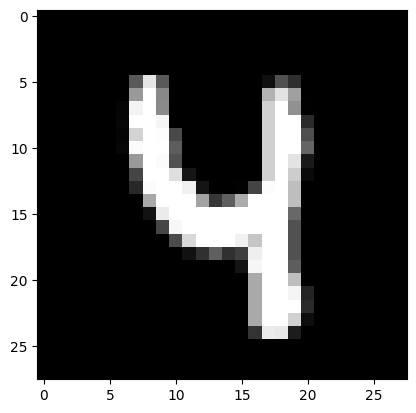

Prediction:  [9]
Label:  9


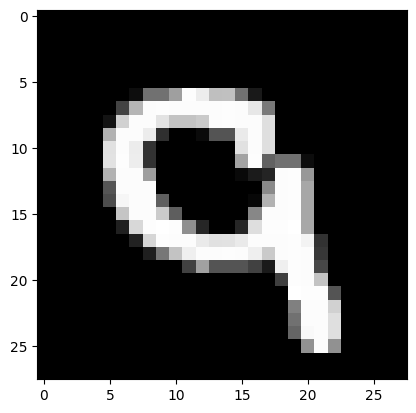

Prediction:  [1]
Label:  1


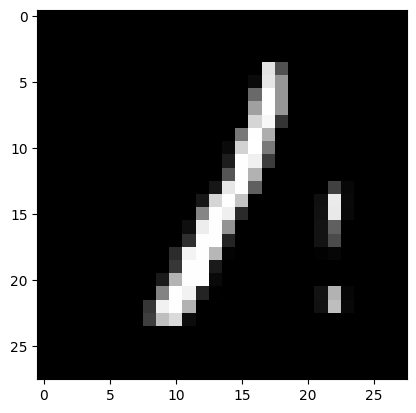

Prediction:  [9]
Label:  9


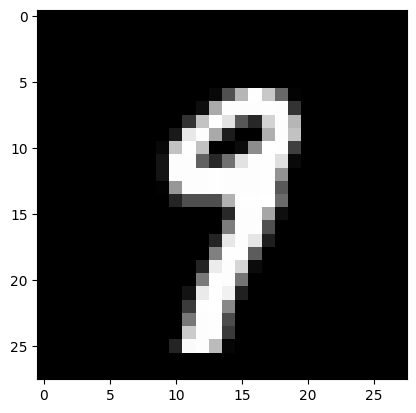

Prediction:  [0]
Label:  0


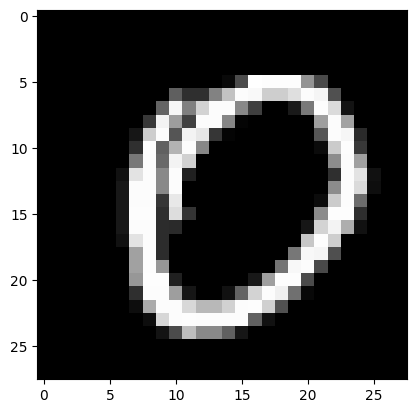

Prediction:  [6]
Label:  6


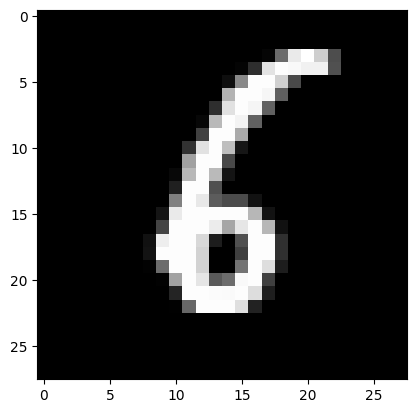

Prediction:  [1]
Label:  1


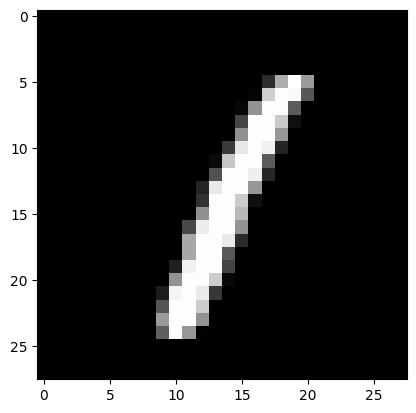

Prediction:  [4]
Label:  4


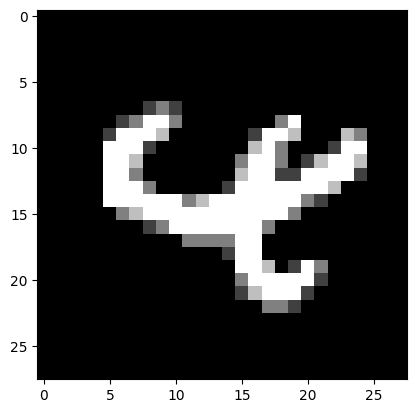

Prediction:  [1]
Label:  1


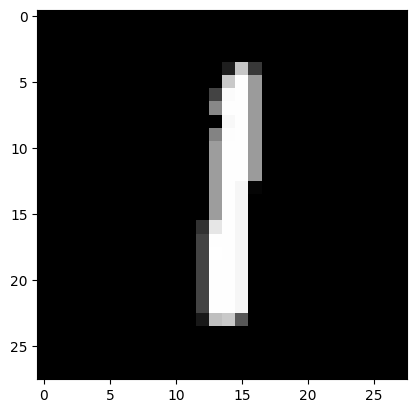

Prediction:  [1]
Label:  1


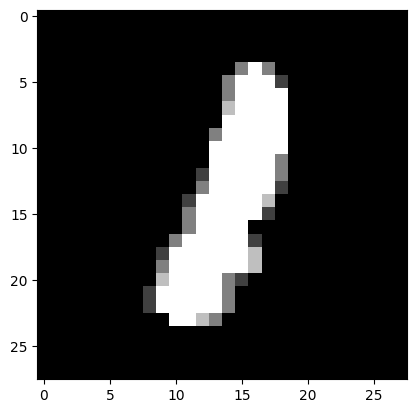

Prediction:  [8]
Label:  8


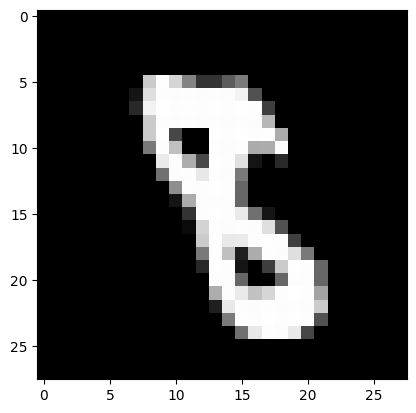

Prediction:  [3]
Label:  3


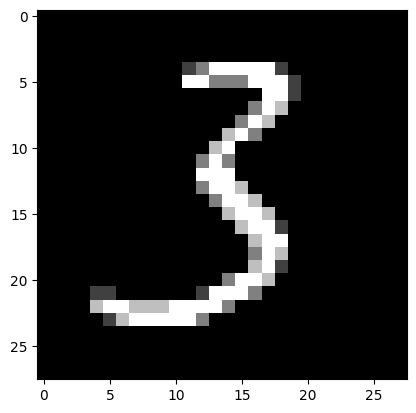

Prediction:  [3]
Label:  3


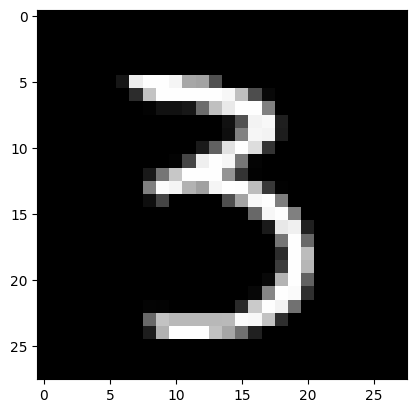

Prediction:  [3]
Label:  3


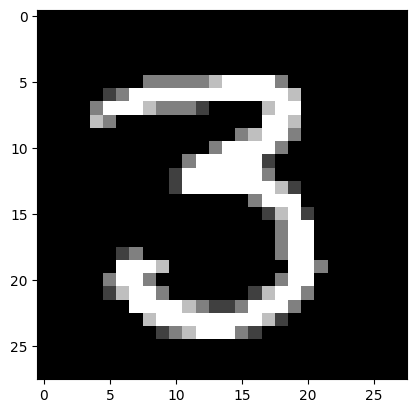

Prediction:  [4]
Label:  4


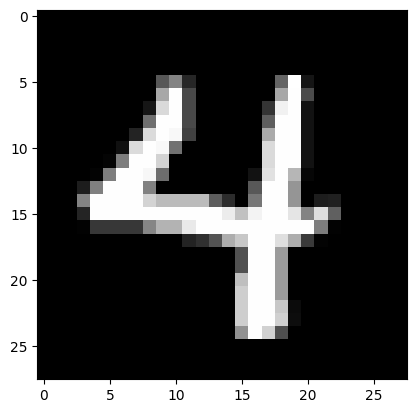

Prediction:  [7]
Label:  7


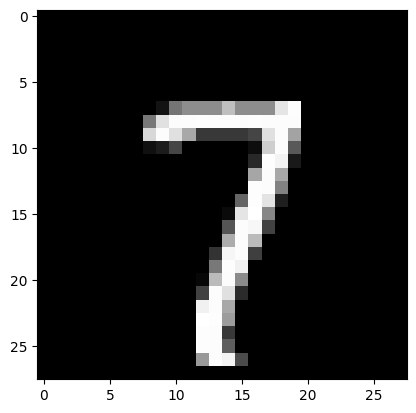

Prediction:  [5]
Label:  5


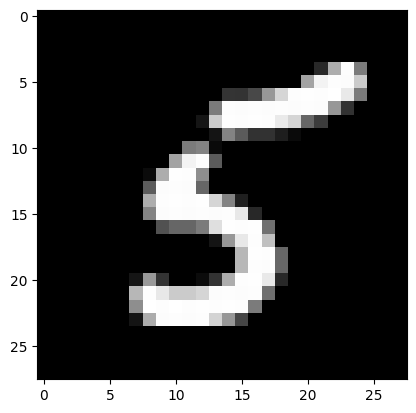

Prediction:  [7]
Label:  7


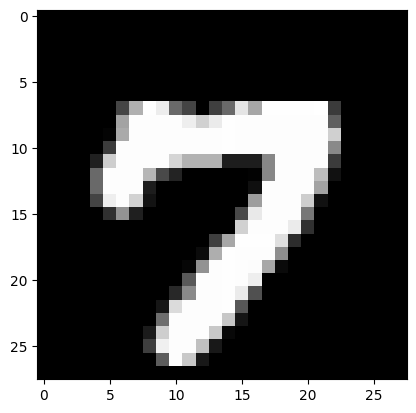

Prediction:  [6]
Label:  6


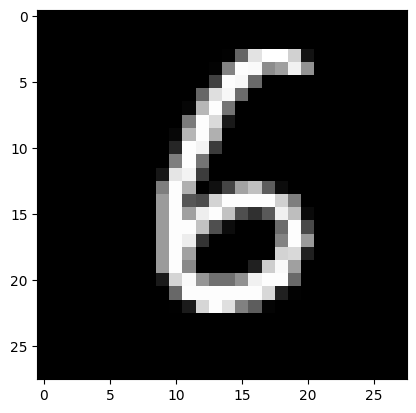

Prediction:  [0]
Label:  0


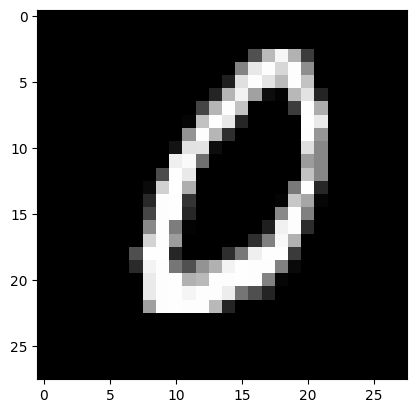

Prediction:  [5]
Label:  5


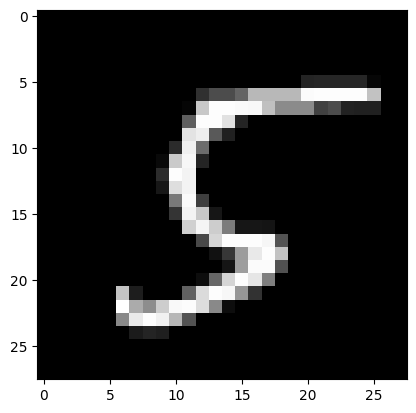

Prediction:  [7]
Label:  7


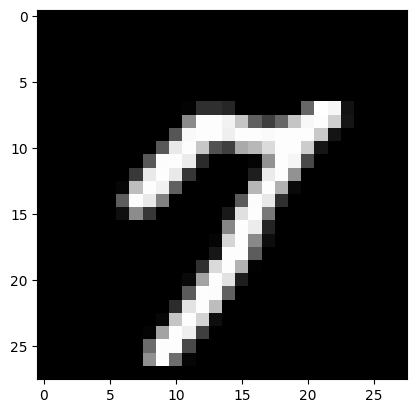

Prediction:  [8]
Label:  8


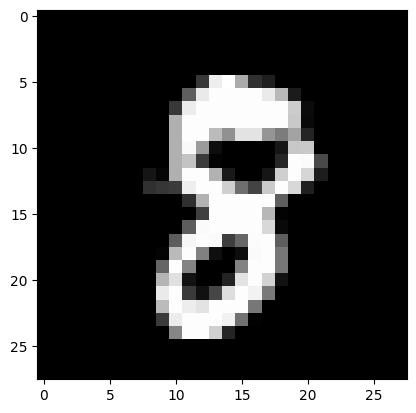

Prediction:  [1]
Label:  1


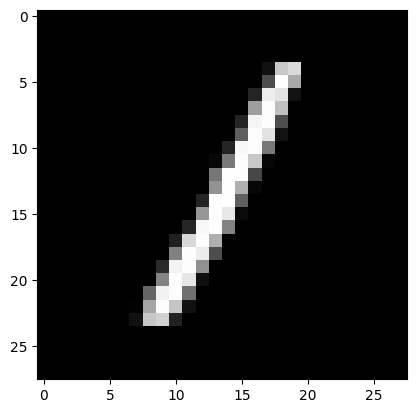

Prediction:  [3]
Label:  3


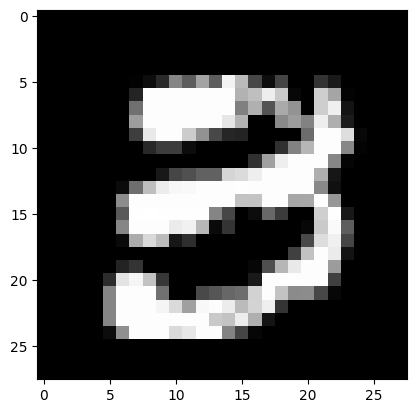

Prediction:  [3]
Label:  3


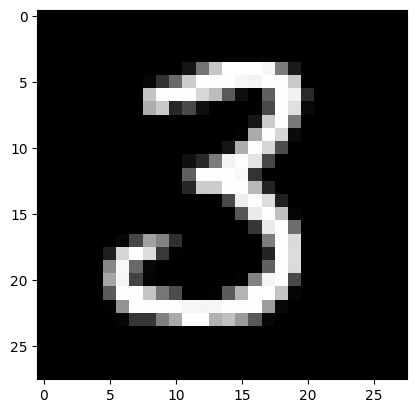

Prediction:  [2]
Label:  2


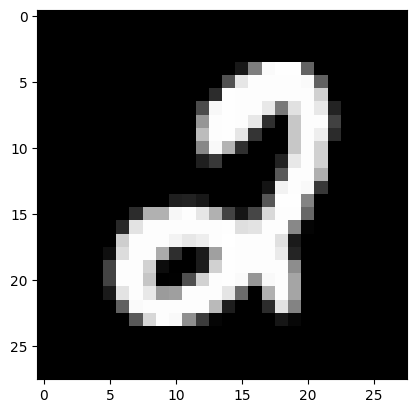

Prediction:  [6]
Label:  6


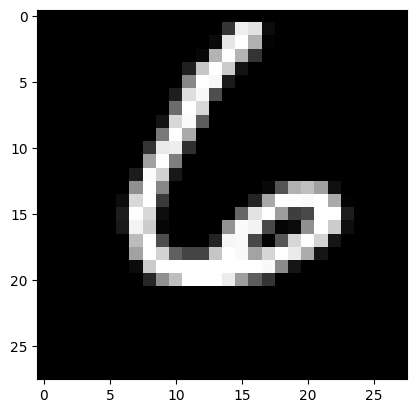

Prediction:  [1]
Label:  1


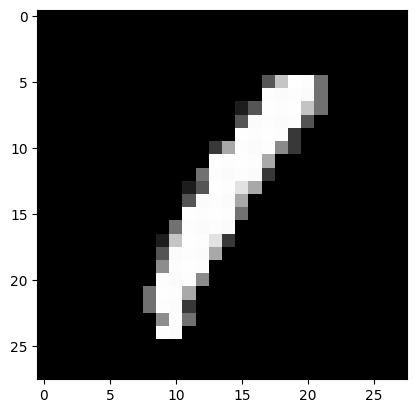

Prediction:  [5]
Label:  5


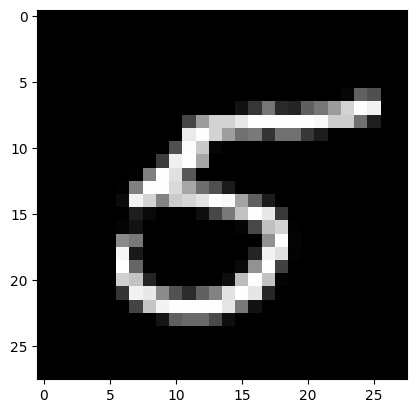

Prediction:  [0]
Label:  0


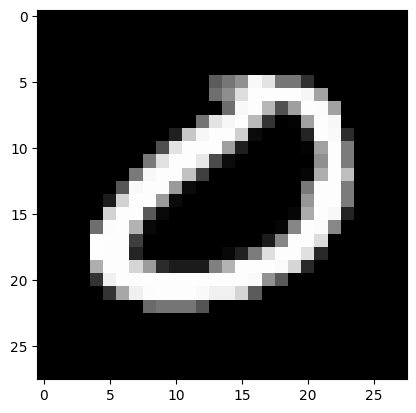

Prediction:  [8]
Label:  8


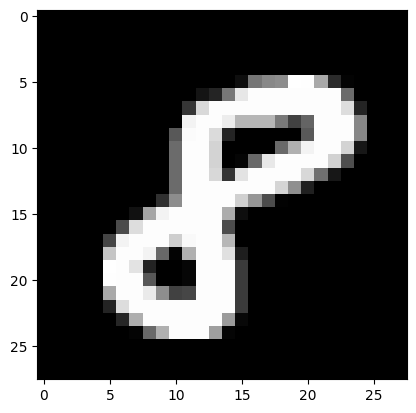

Prediction:  [3]
Label:  3


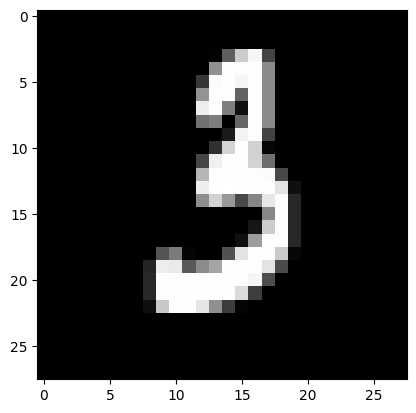

Prediction:  [5]
Label:  5


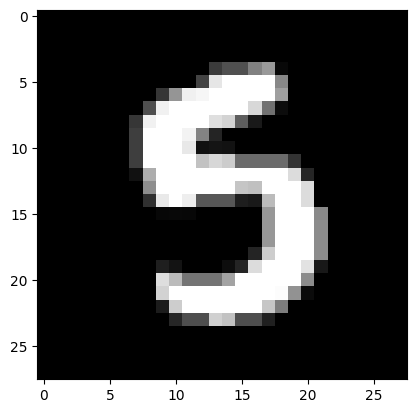

Prediction:  [9]
Label:  9


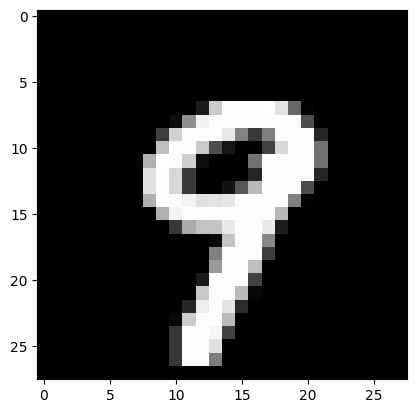

Prediction:  [3]
Label:  3


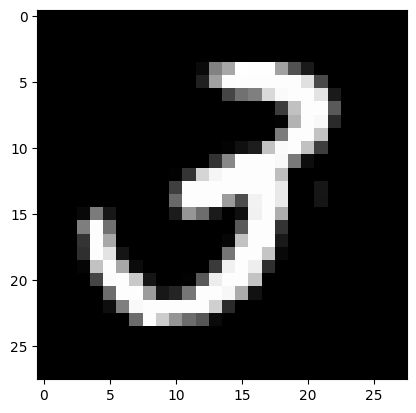

Prediction:  [6]
Label:  6


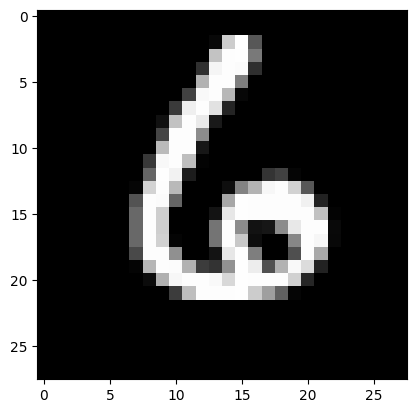

Prediction:  [3]
Label:  3


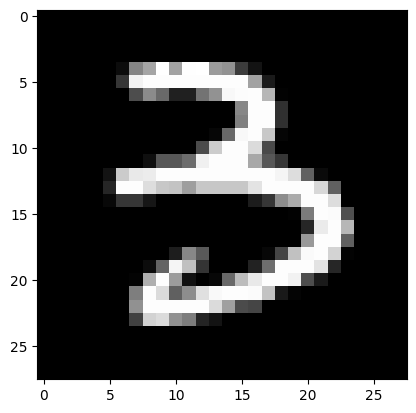

Prediction:  [0]
Label:  0


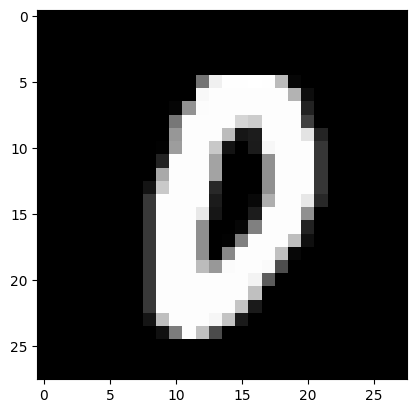

Prediction:  [8]
Label:  8


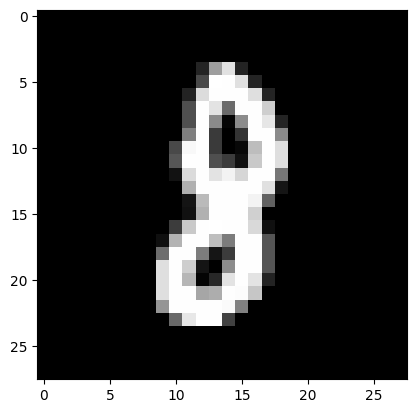

Prediction:  [1]
Label:  1


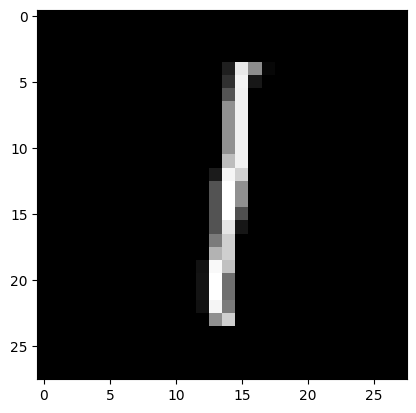

Prediction:  [6]
Label:  6


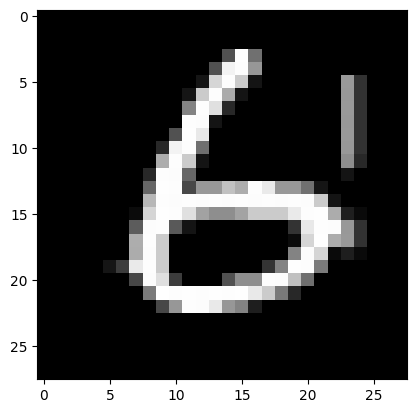

Prediction:  [6]
Label:  6


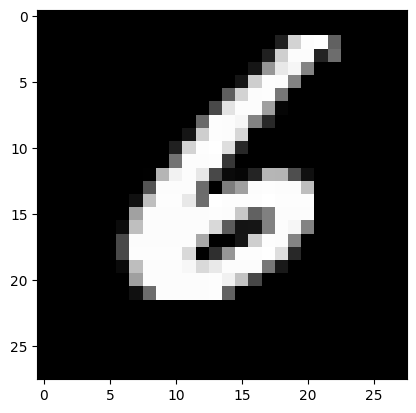

Prediction:  [4]
Label:  4


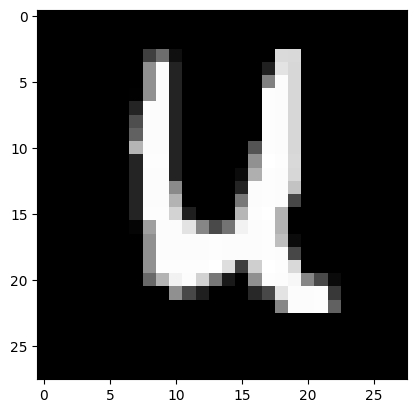

Prediction:  [7]
Label:  7


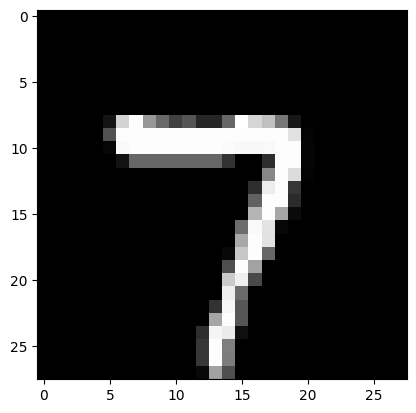

Prediction:  [2]
Label:  2


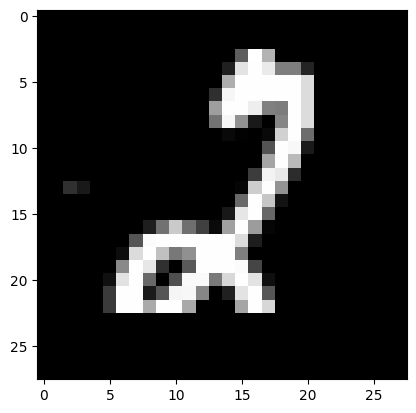

Prediction:  [6]
Label:  6


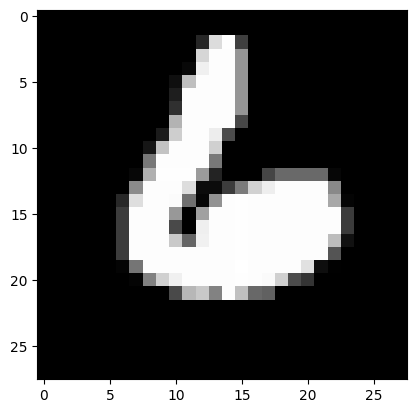

Prediction:  [0]
Label:  0


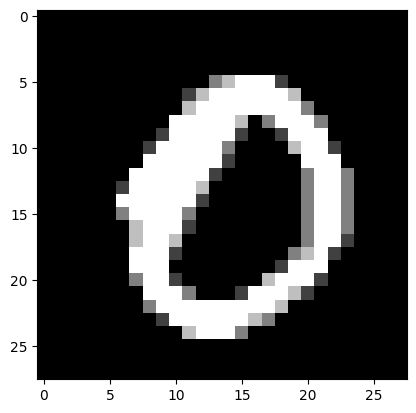

Prediction:  [1]
Label:  1


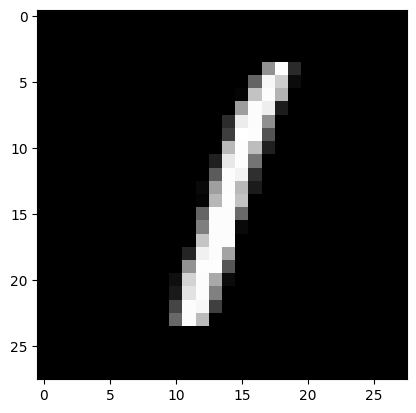

Prediction:  [4]
Label:  4


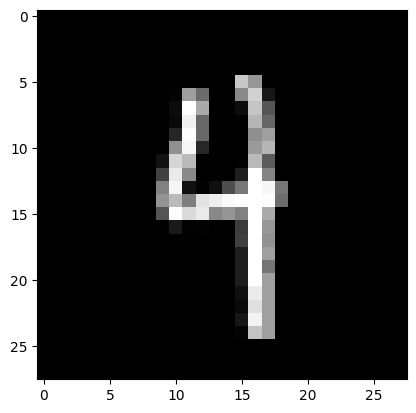

Prediction:  [2]
Label:  2


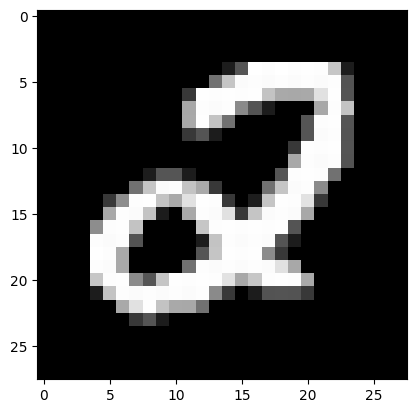

Prediction:  [9]
Label:  9


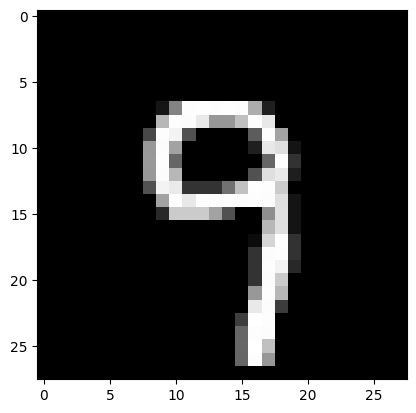

Prediction:  [1]
Label:  1


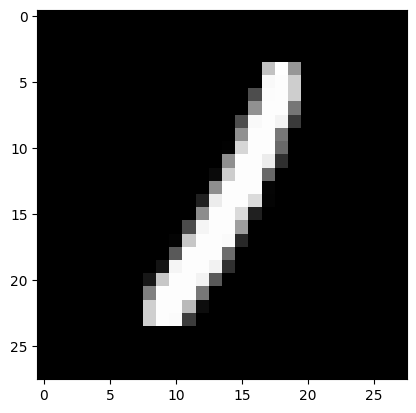

Prediction:  [5]
Label:  5


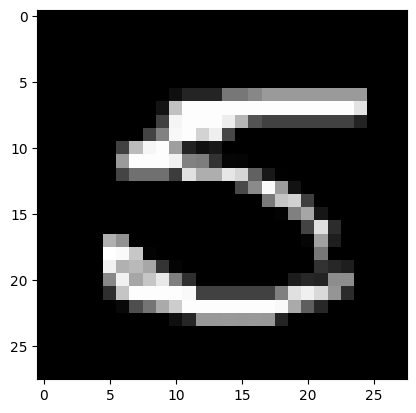

Prediction:  [0]
Label:  0


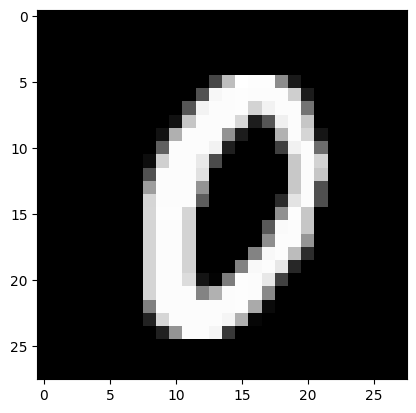

Prediction:  [3]
Label:  3


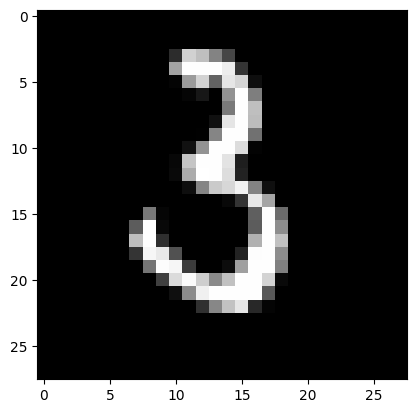

Prediction:  [5]
Label:  5


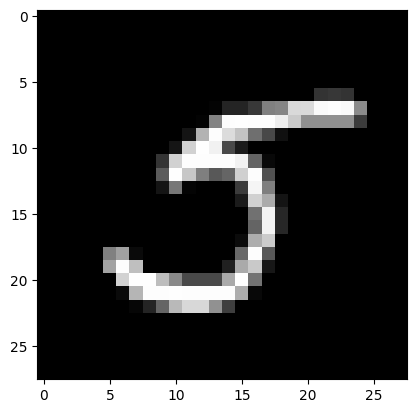

Prediction:  [0]
Label:  0


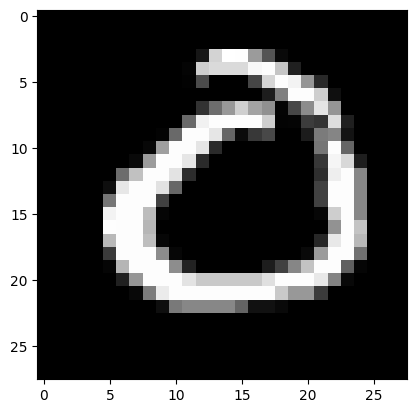

Prediction:  [0]
Label:  0


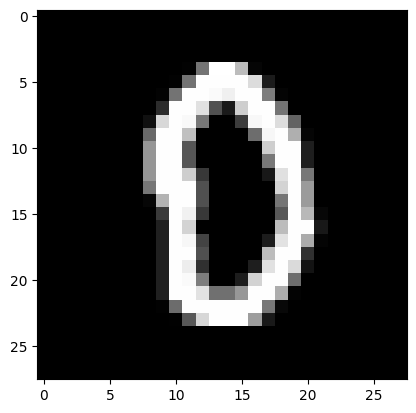

Prediction:  [0]
Label:  0


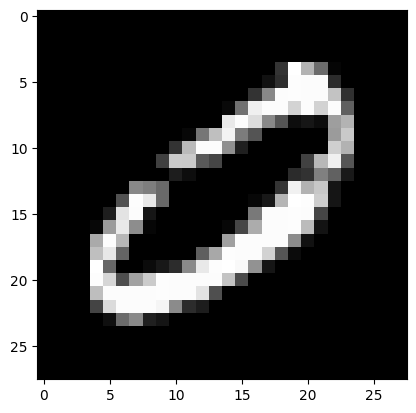

Prediction:  [3]
Label:  3


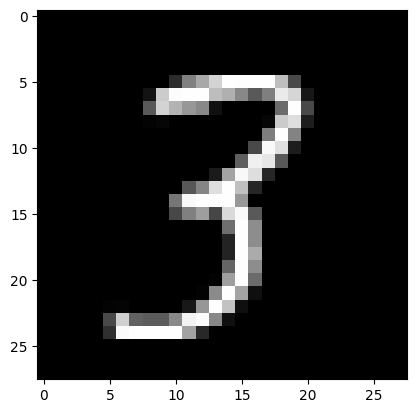

Prediction:  [1]
Label:  1


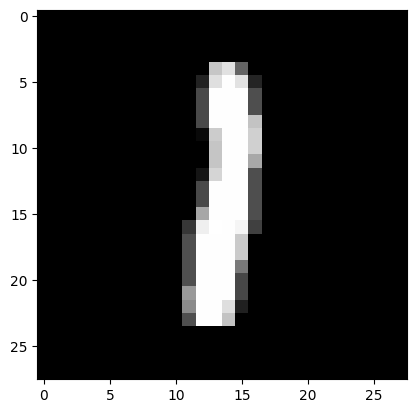

Prediction:  [7]
Label:  7


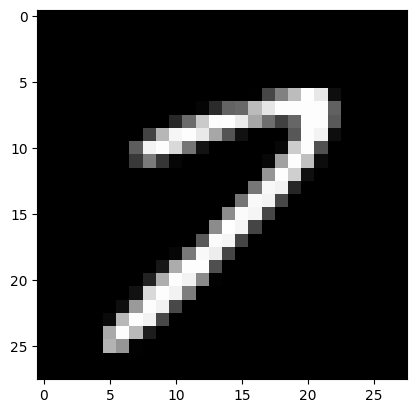

Prediction:  [0]
Label:  0


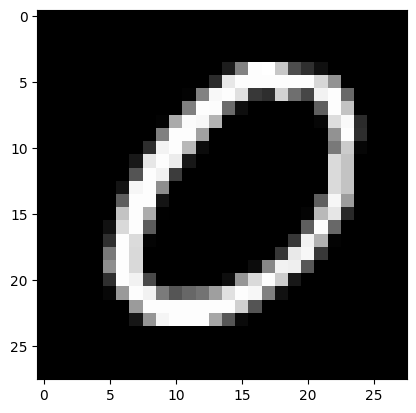

Prediction:  [7]
Label:  7


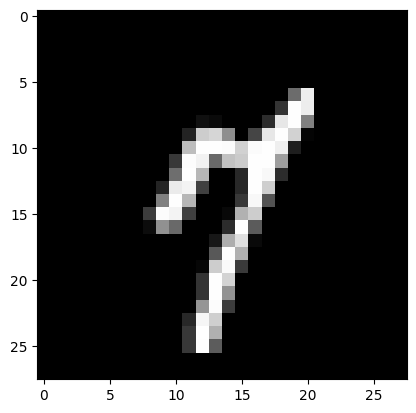

Prediction:  [3]
Label:  3


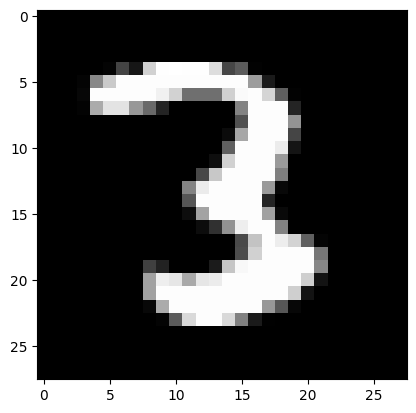

Prediction:  [2]
Label:  2


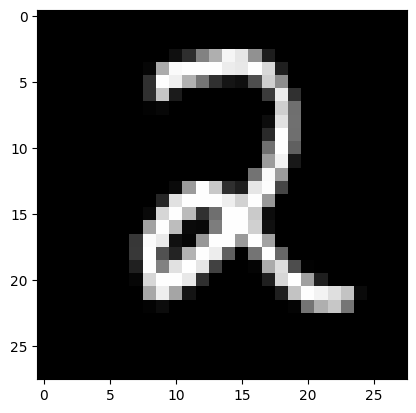

Prediction:  [9]
Label:  1


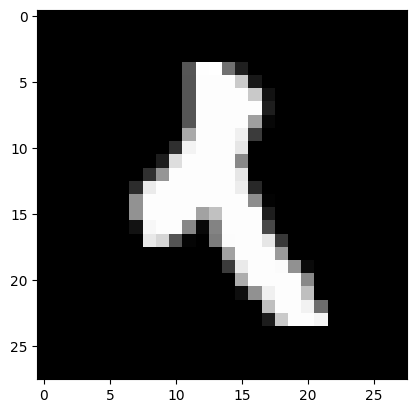

Prediction:  [1]
Label:  1


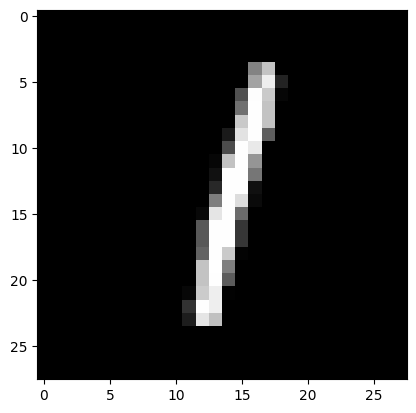

Prediction:  [9]
Label:  9


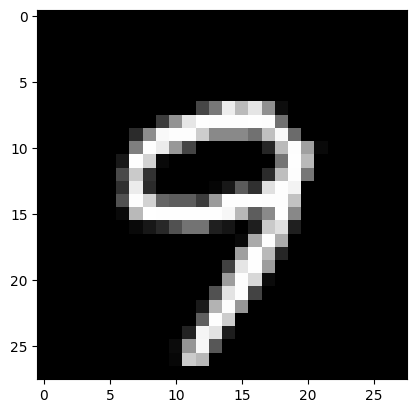

Prediction:  [8]
Label:  3


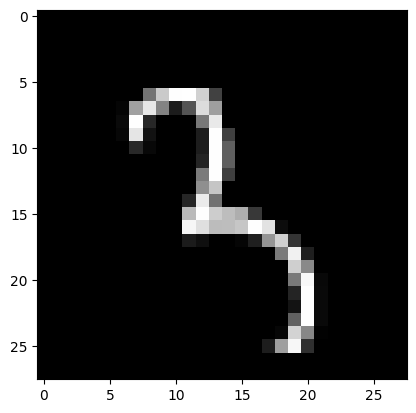

Prediction:  [8]
Label:  8


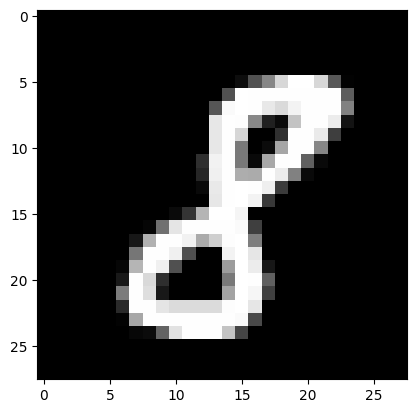

Prediction:  [4]
Label:  4


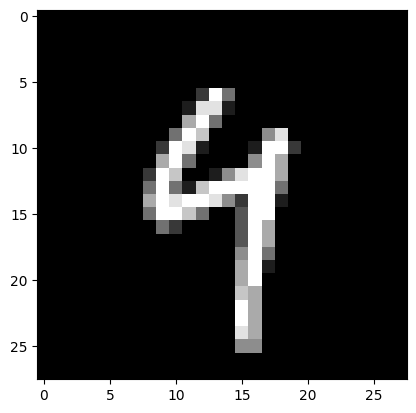

Prediction:  [6]
Label:  6


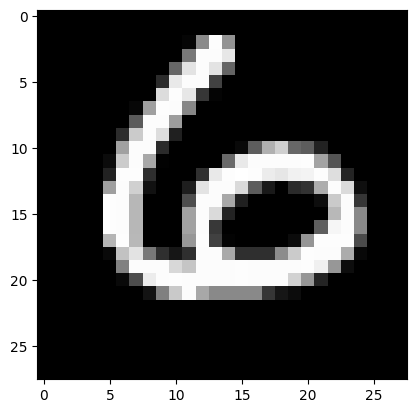

Prediction:  [8]
Label:  8


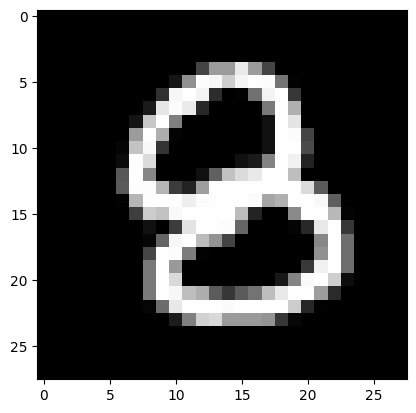

Prediction:  [9]
Label:  9


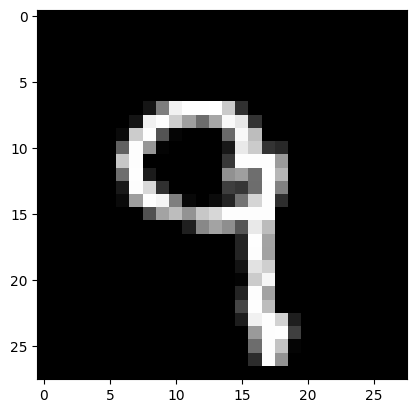

Prediction:  [9]
Label:  9


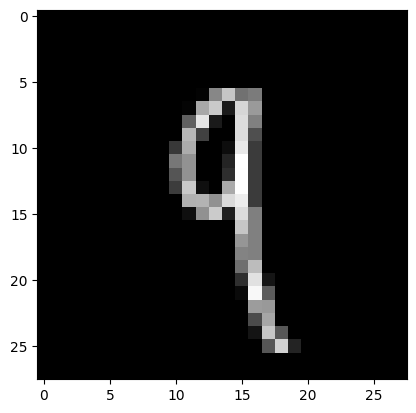

Prediction:  [2]
Label:  2


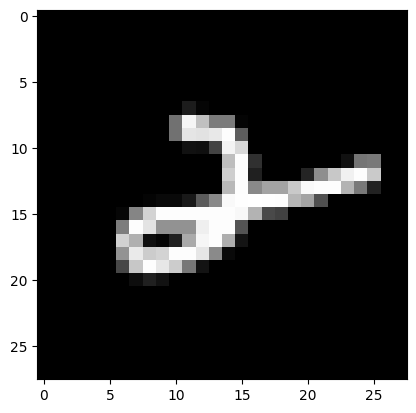

Prediction:  [1]
Label:  1


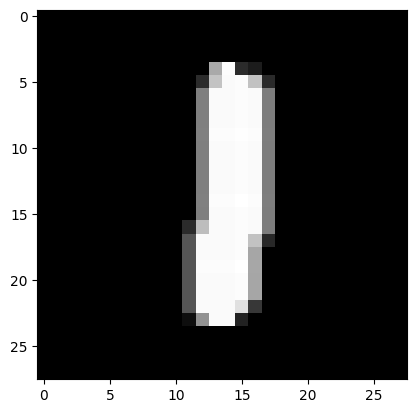

Prediction:  [8]
Label:  8


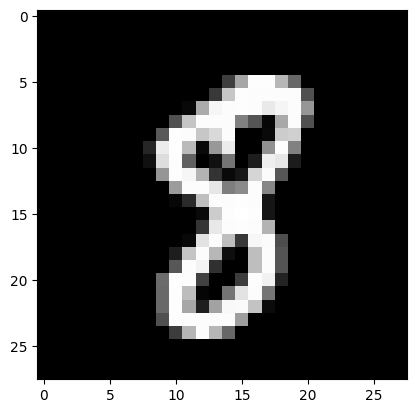

Prediction:  [2]
Label:  2


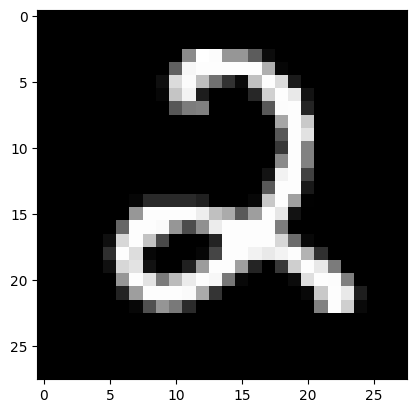

Prediction:  [3]
Label:  3


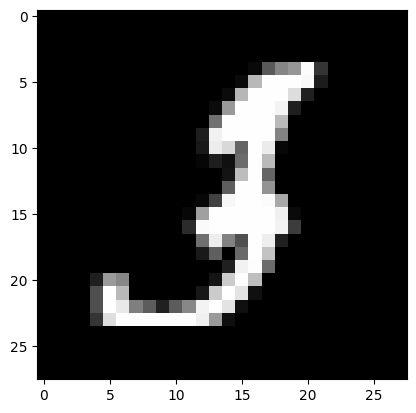

Prediction:  [3]
Label:  8


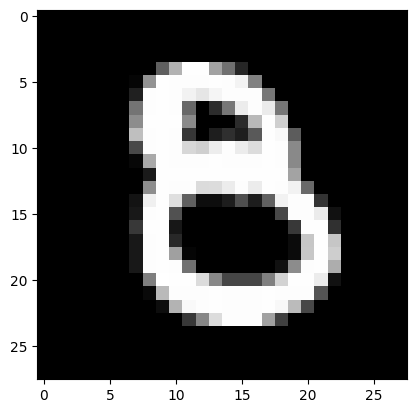

Prediction:  [7]
Label:  7


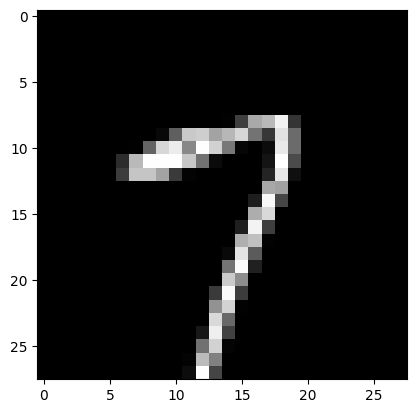

Prediction:  [6]
Label:  6


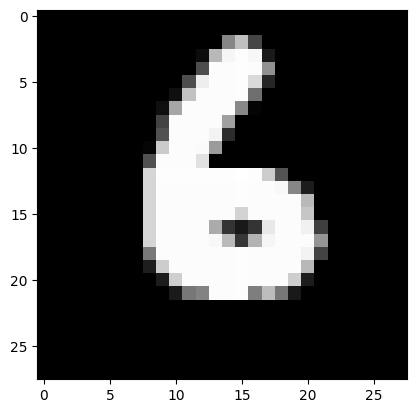

Prediction:  [9]
Label:  9


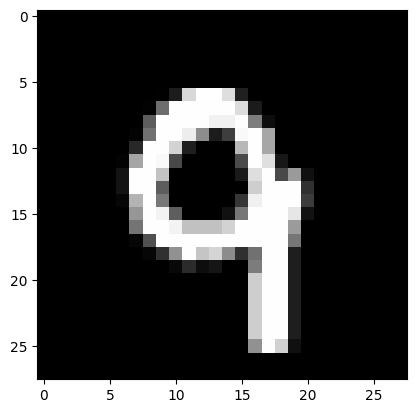

Prediction:  [3]
Label:  3


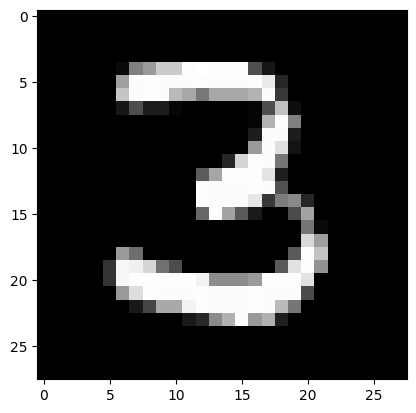

Prediction:  [1]
Label:  1


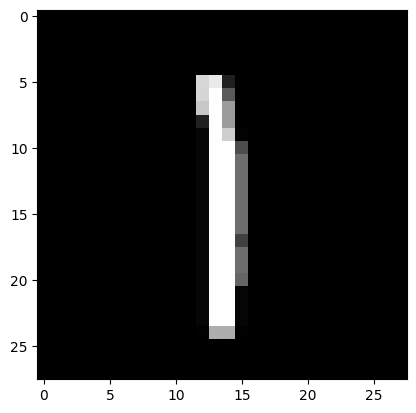

Prediction:  [1]
Label:  1


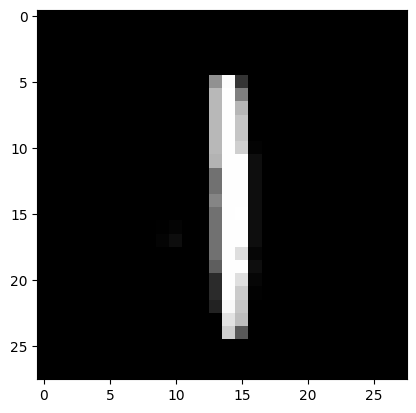

Prediction:  [7]
Label:  7


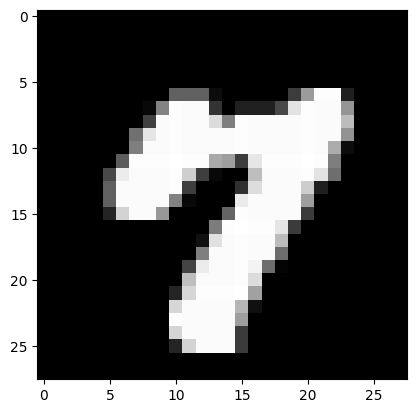

Prediction:  [0]
Label:  0


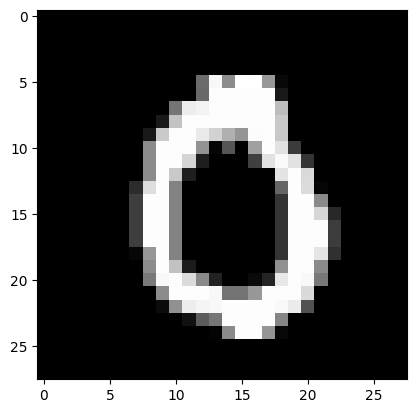

Prediction:  [3]
Label:  3


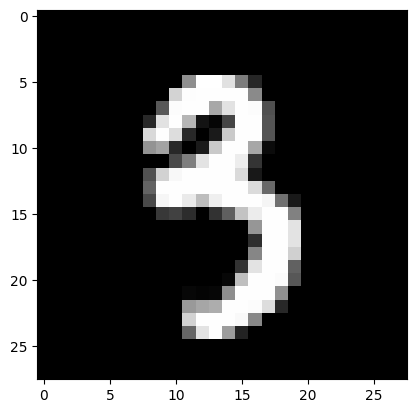

Prediction:  [6]
Label:  6


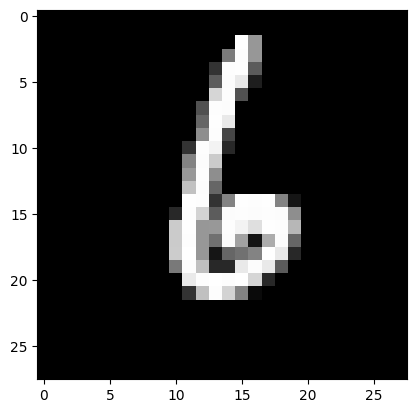

Prediction:  [6]
Label:  6


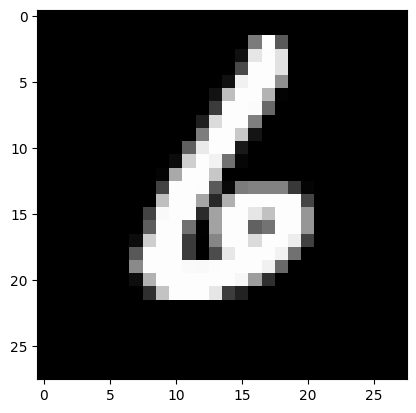

Prediction:  [5]
Label:  5


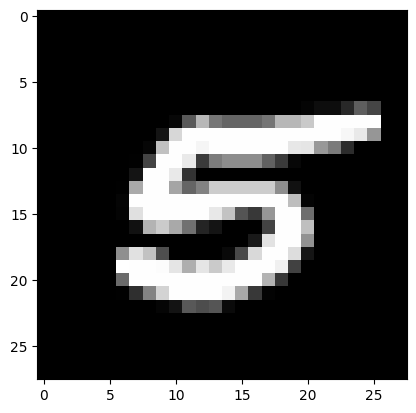

Prediction:  [3]
Label:  8


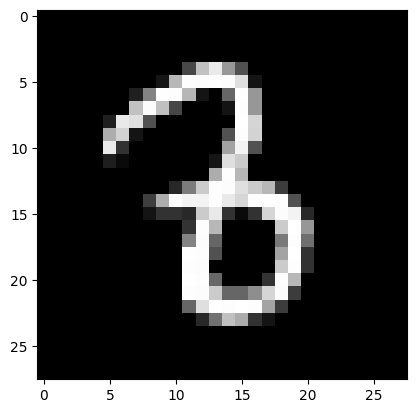

Prediction:  [2]
Label:  2


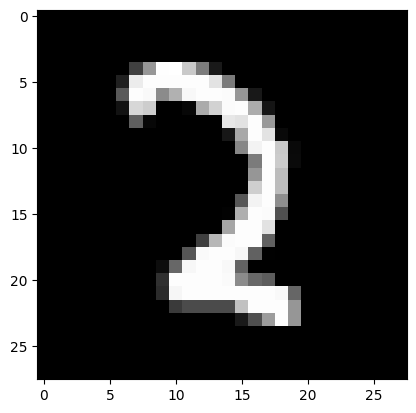

Prediction:  [7]
Label:  7


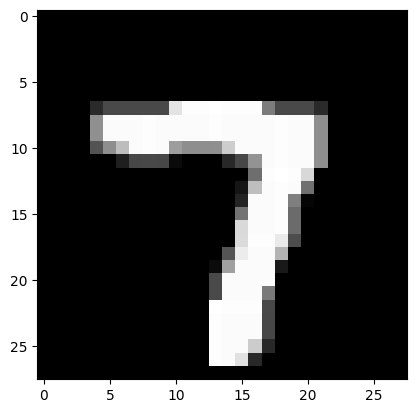

Prediction:  [1]
Label:  1


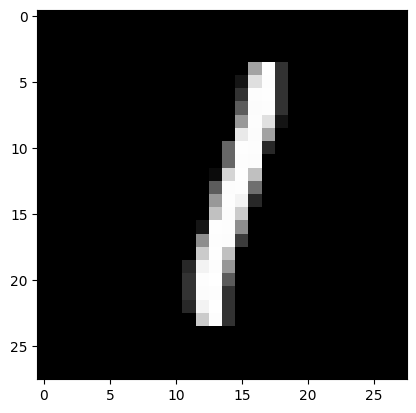

Prediction:  [9]
Label:  9


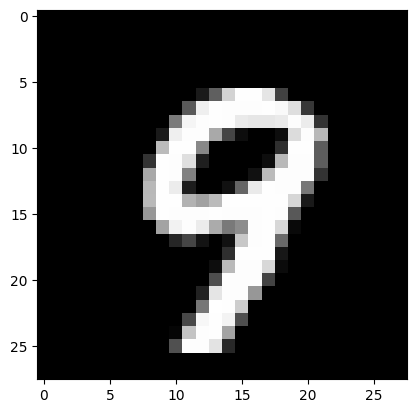

Prediction:  [7]
Label:  7


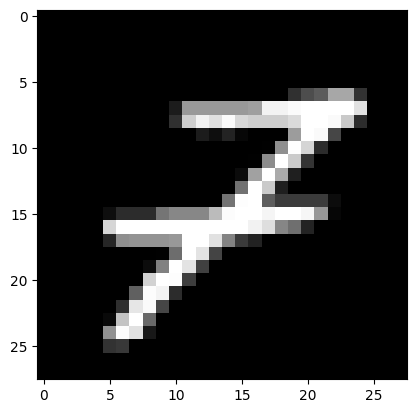

Prediction:  [2]
Label:  2


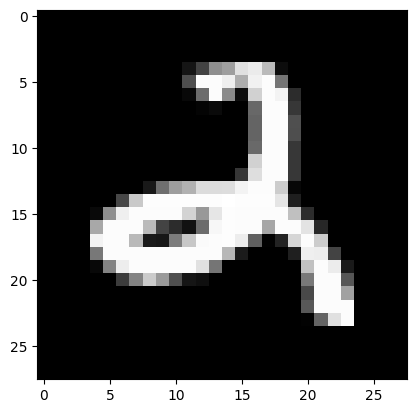

Prediction:  [6]
Label:  6


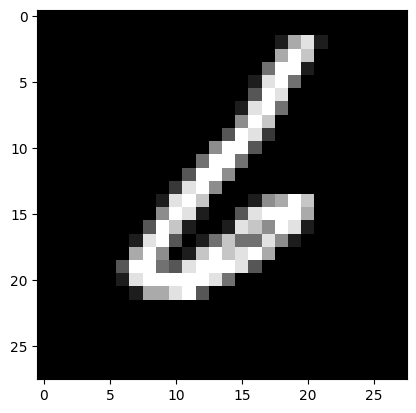

Prediction:  [6]
Label:  6


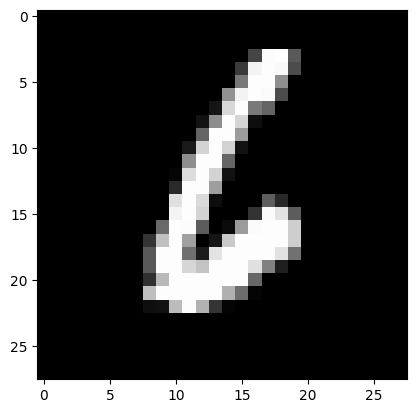

Prediction:  [8]
Label:  8


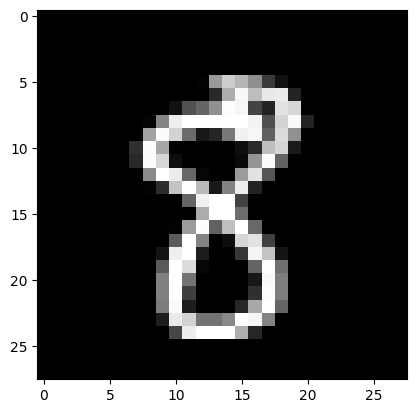

Prediction:  [0]
Label:  0


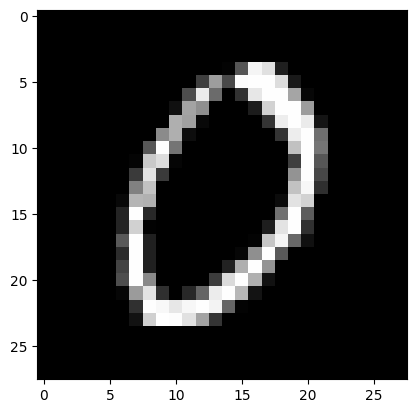

Prediction:  [9]
Label:  9


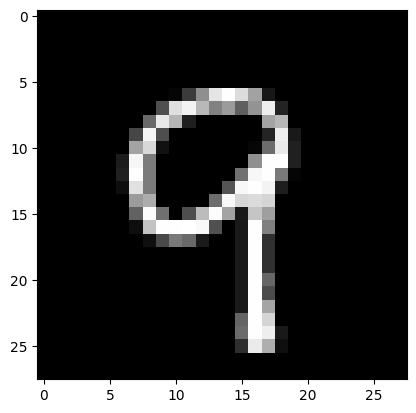

Prediction:  [4]
Label:  4


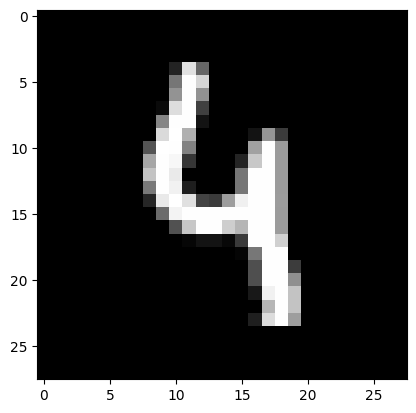

Prediction:  [3]
Label:  3


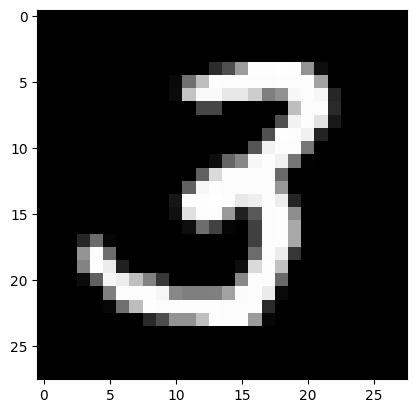

Prediction:  [3]
Label:  3


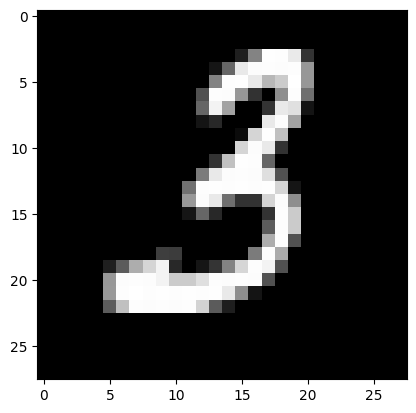

Prediction:  [4]
Label:  4


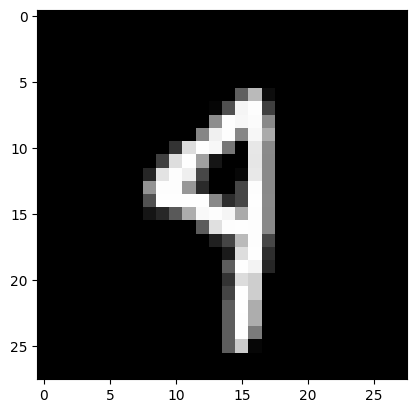

Prediction:  [8]
Label:  8


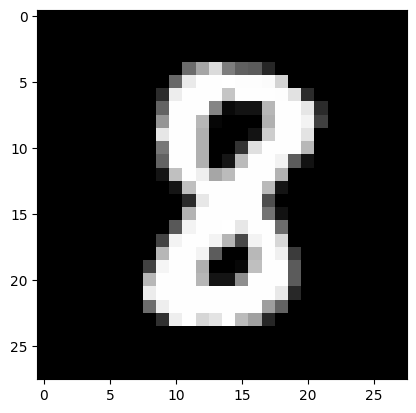

Prediction:  [2]
Label:  2


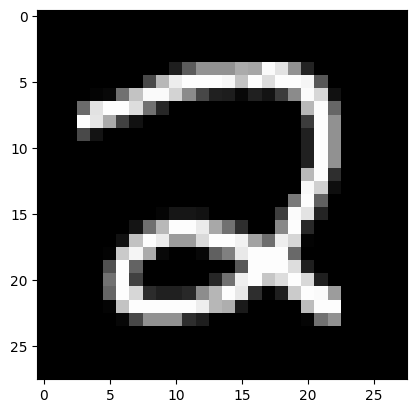

Prediction:  [0]
Label:  0


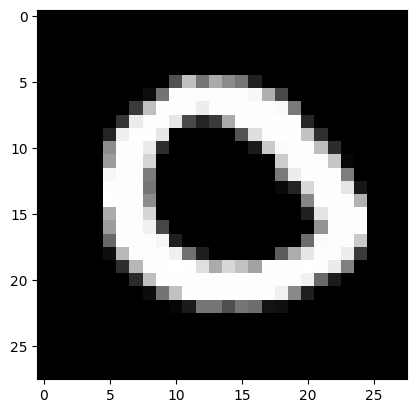

Prediction:  [4]
Label:  4


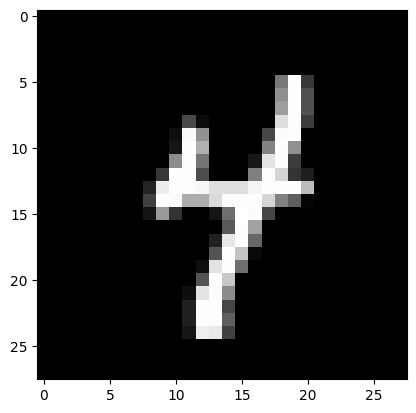

Prediction:  [6]
Label:  6


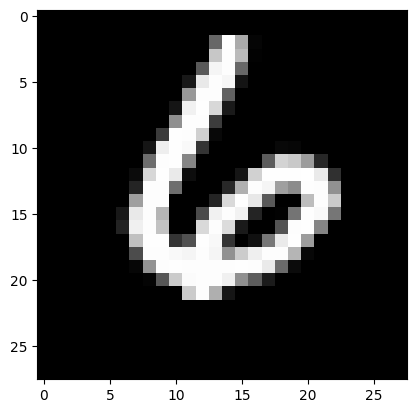

Prediction:  [9]
Label:  9


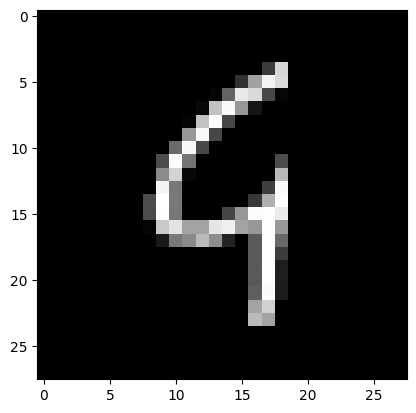

Prediction:  [1]
Label:  1


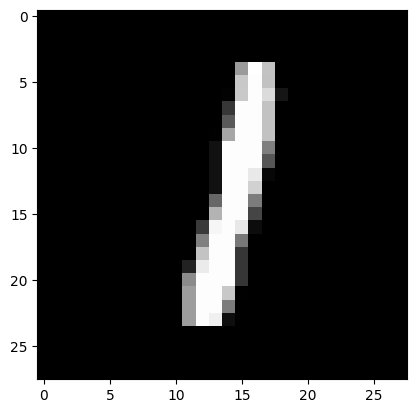

Prediction:  [1]
Label:  1


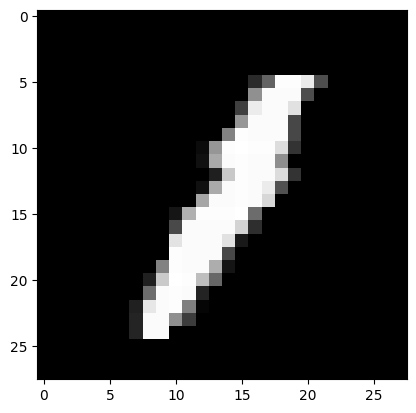

Prediction:  [6]
Label:  6


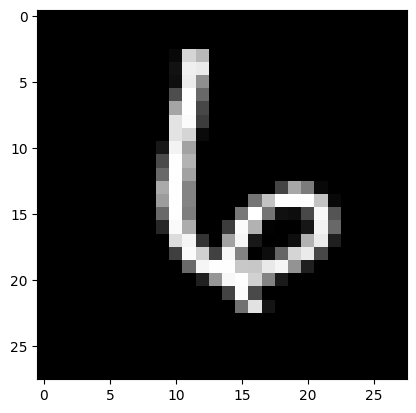

Prediction:  [1]
Label:  1


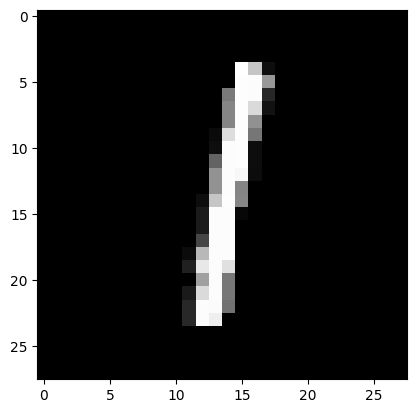

Prediction:  [0]
Label:  0


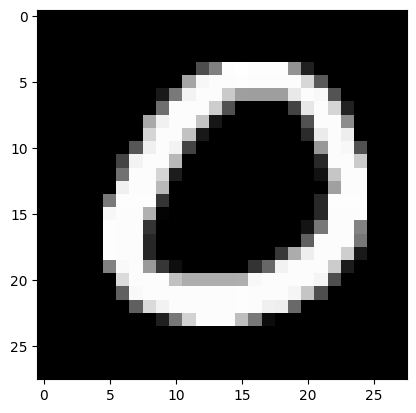

Prediction:  [3]
Label:  3


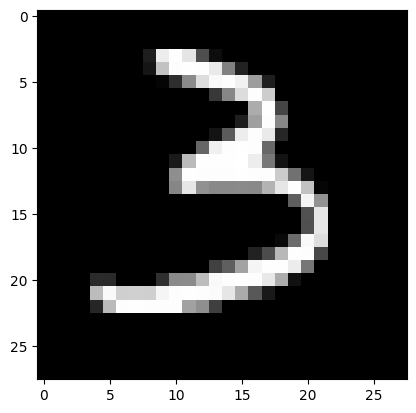

Prediction:  [8]
Label:  8


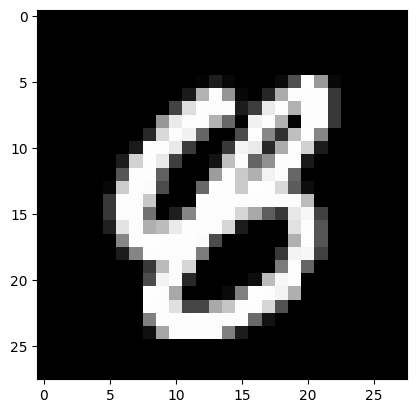

Prediction:  [2]
Label:  2


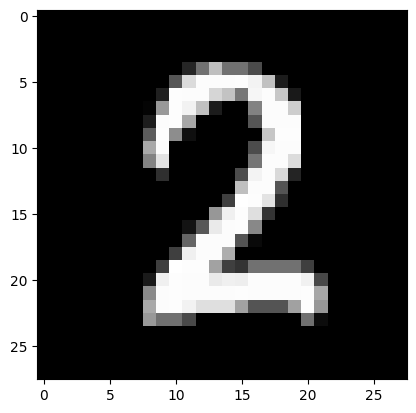

Prediction:  [4]
Label:  4


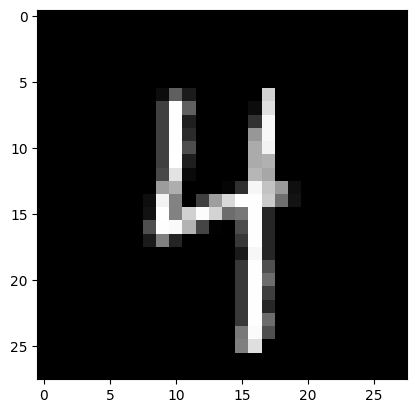

Prediction:  [5]
Label:  5


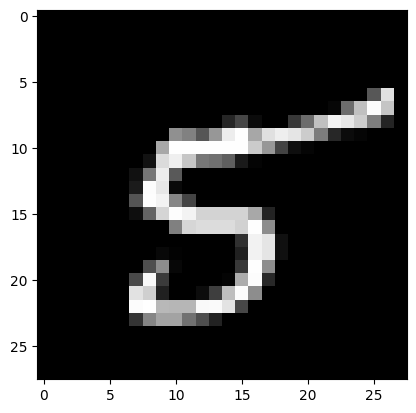

Prediction:  [9]
Label:  9


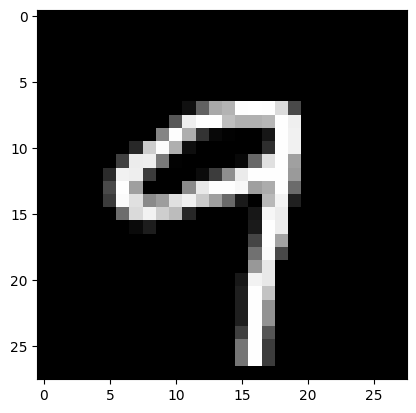

Prediction:  [7]
Label:  7


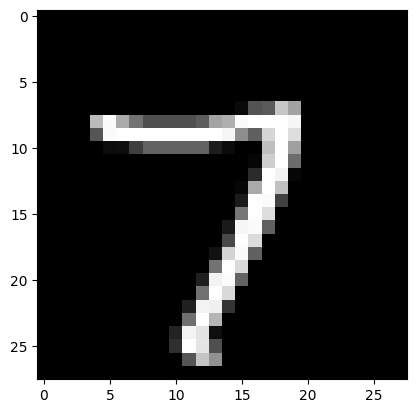

Prediction:  [3]
Label:  3


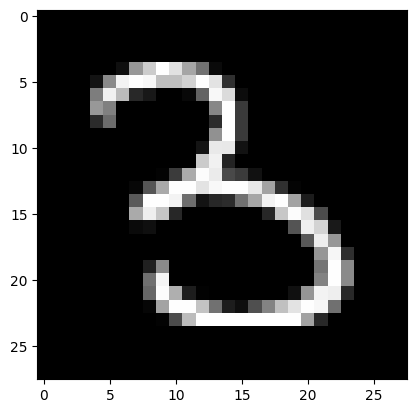

Prediction:  [0]
Label:  0


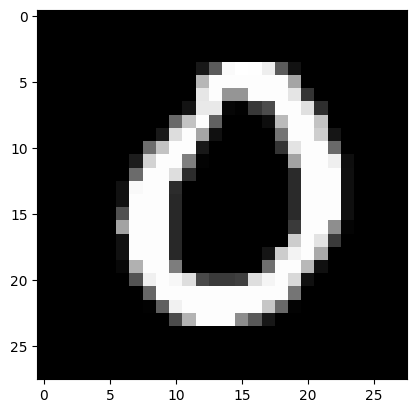

Prediction:  [6]
Label:  6


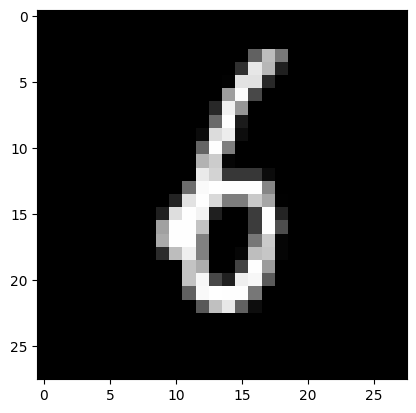

Prediction:  [3]
Label:  3


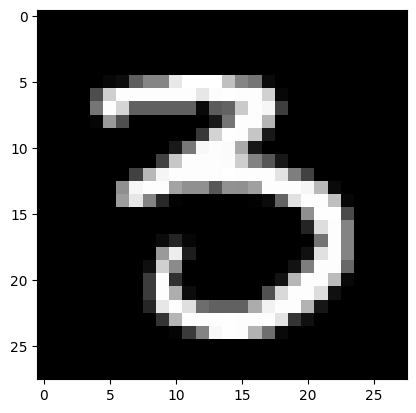

Prediction:  [4]
Label:  4


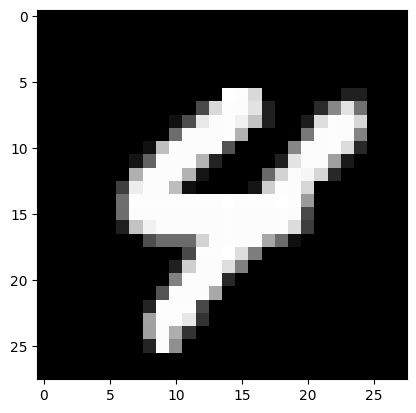

Prediction:  [4]
Label:  4


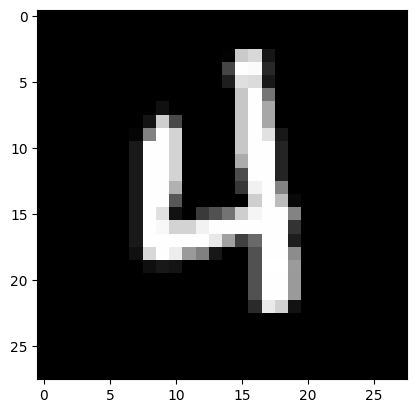

Prediction:  [0]
Label:  0


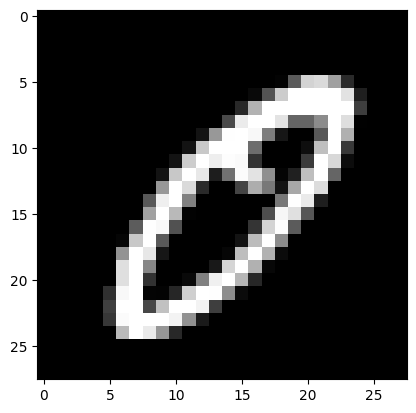

Prediction:  [5]
Label:  5


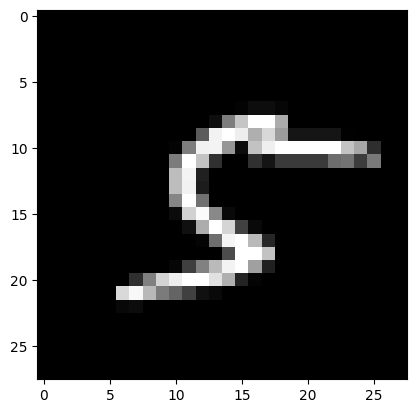

Prediction:  [2]
Label:  2


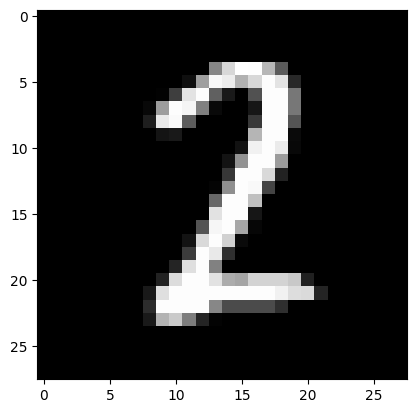

Prediction:  [0]
Label:  0


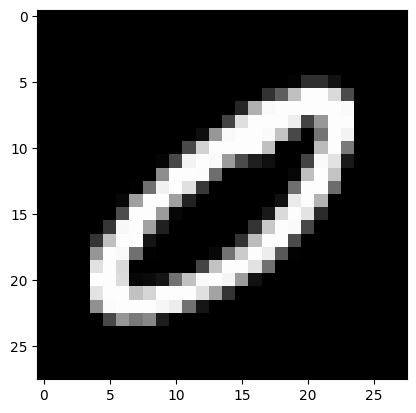

Prediction:  [6]
Label:  6


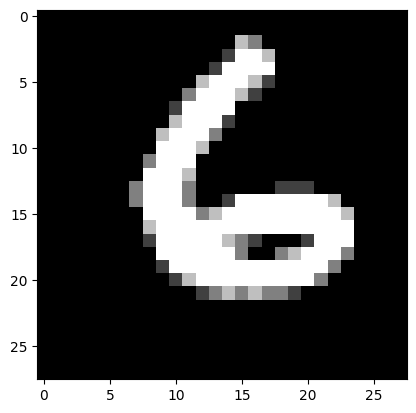

Prediction:  [4]
Label:  4


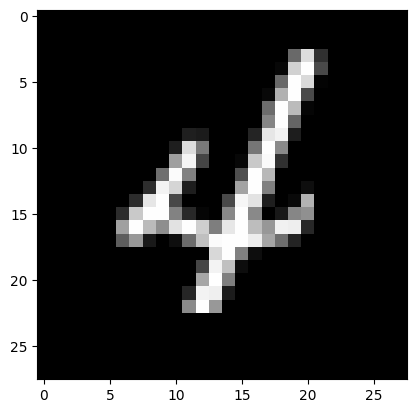

Prediction:  [1]
Label:  1


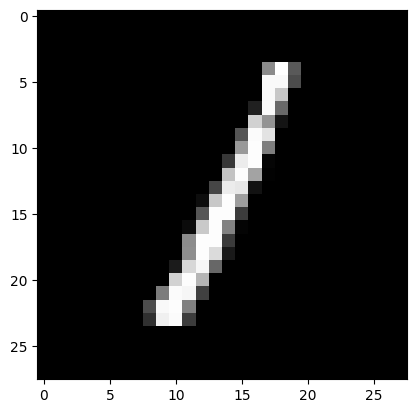

Prediction:  [6]
Label:  6


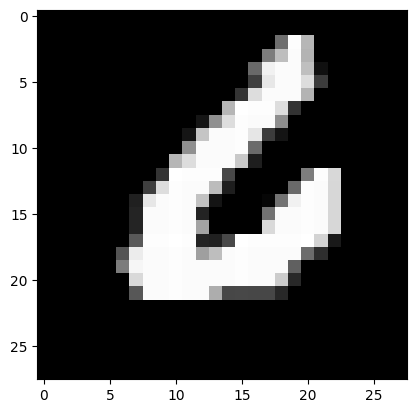

Prediction:  [9]
Label:  9


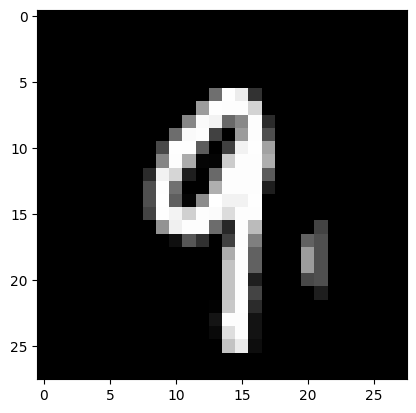

Prediction:  [8]
Label:  8


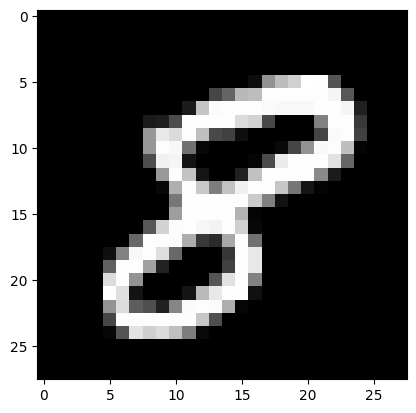

Prediction:  [2]
Label:  2


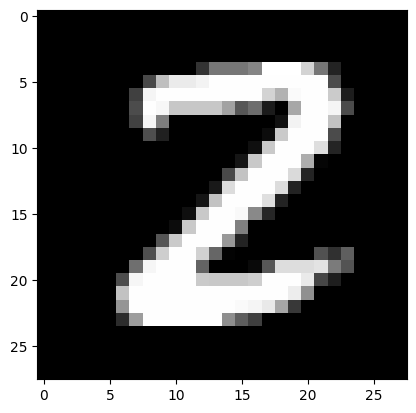

Prediction:  [3]
Label:  3


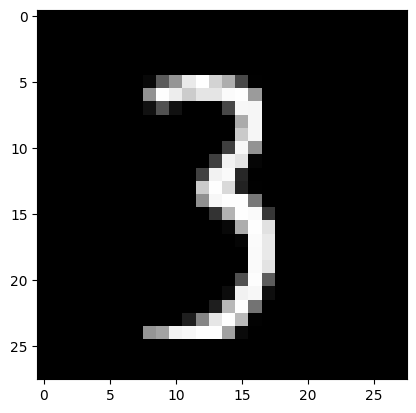

Prediction:  [1]
Label:  1


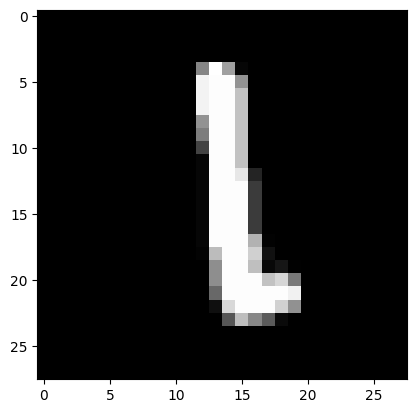

Prediction:  [4]
Label:  4


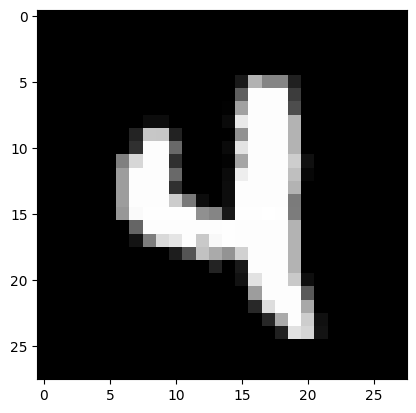

Prediction:  [4]
Label:  4


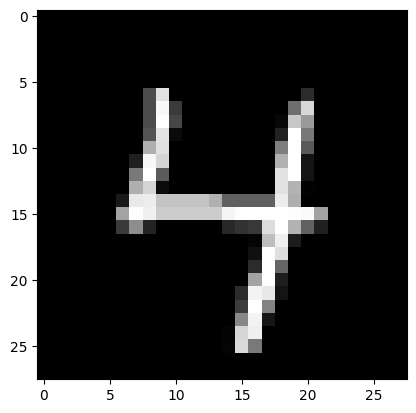

Prediction:  [1]
Label:  1


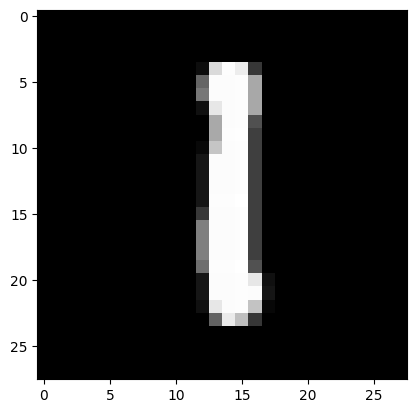

Prediction:  [3]
Label:  3


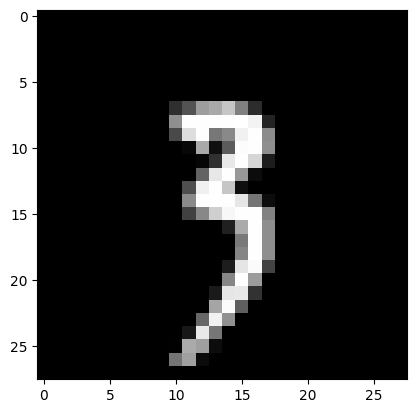

Prediction:  [5]
Label:  5


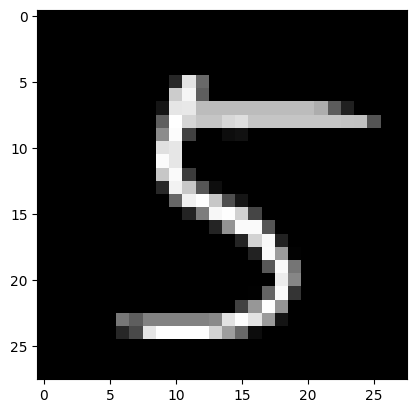

Prediction:  [1]
Label:  1


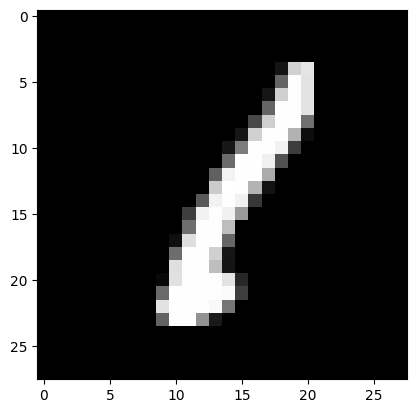

Prediction:  [0]
Label:  0


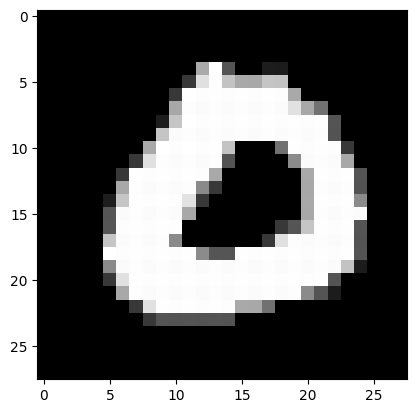

Prediction:  [3]
Label:  5


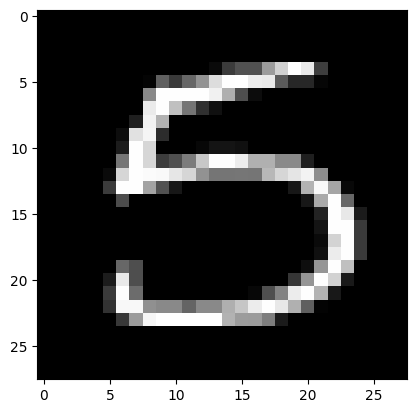

Prediction:  [4]
Label:  4


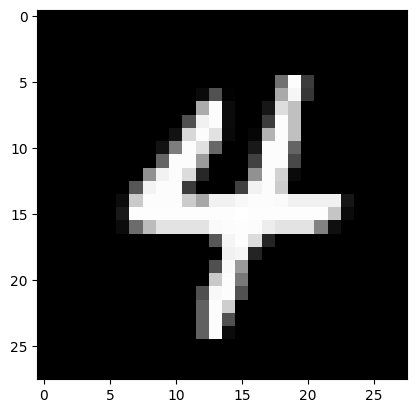

Prediction:  [0]
Label:  0


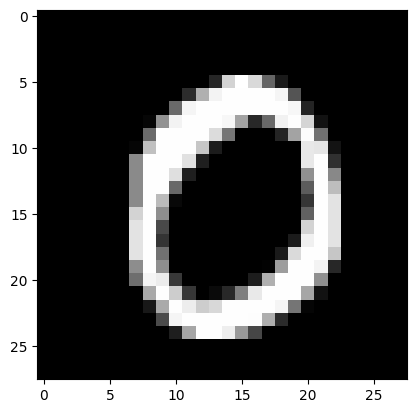

Prediction:  [4]
Label:  4


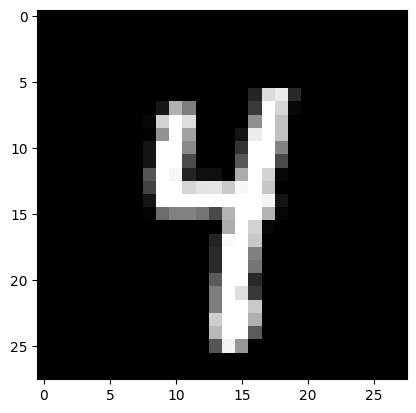

Prediction:  [7]
Label:  7


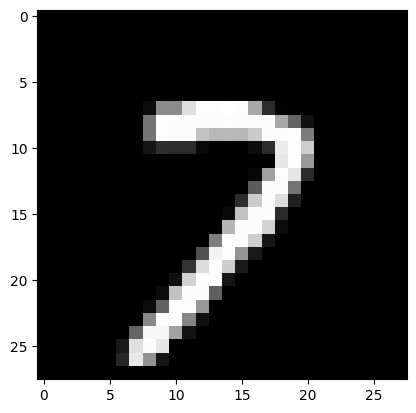

Prediction:  [0]
Label:  0


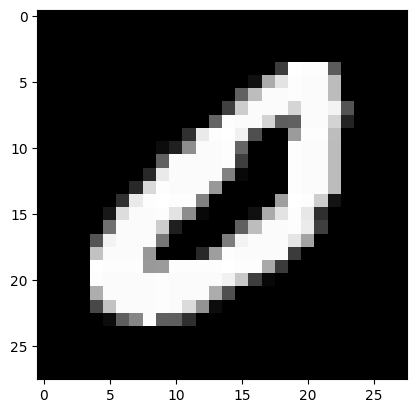

Prediction:  [9]
Label:  9


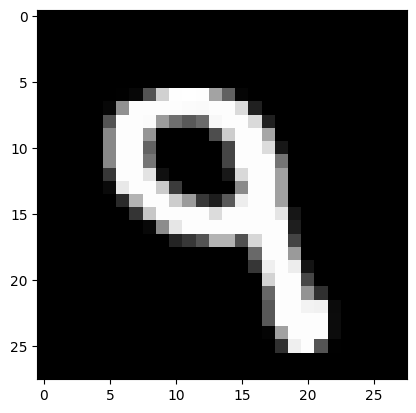

Prediction:  [1]
Label:  8


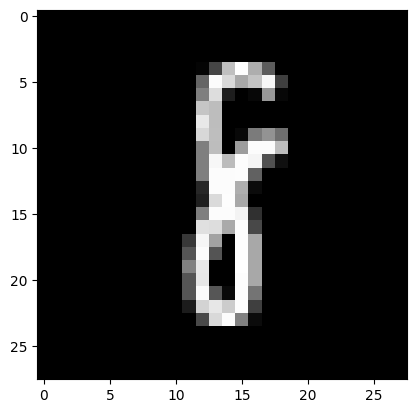

Prediction:  [8]
Label:  8


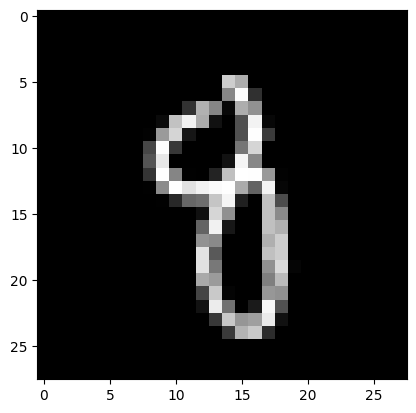

In [15]:
def make_prediction(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_prediction(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    

for idx, val in enumerate(X_train):
    test_prediction(idx, W1, b1, W2, b2)